In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = True
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024

experiment_id = f"classification-lstm-{lstm_hidden_size}-of-sentences-finetuned-bert-{max_training_samples}-orig-data-{epochs}-epochs"

In [3]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [4]:
from data_parsing import load_dataset, load_gen_dataset
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [5]:
from training_utils import split_train_validation
def get_train_valid():
    train_x, valid_x, train_y, valid_y = split_train_validation(data, 0.01)

    if not enable_orig:
        train_x = []
        train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
    
    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [6]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

528245
528245
5336
5336


In [7]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [8]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [9]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x[:max_training_samples]))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)

In [10]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [11]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-data-{hash_key(finetuning_data_key)}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


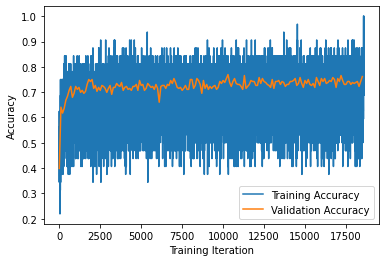

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [13]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}-finetuned-{hash_key(finetuning_model_key)}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x[:max_training_samples]),
        get_embeds(valid_x)
    ),
    main_data_key
)

In [14]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    print(train_x_embeds.shape)
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=256
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], train_x_embeds.shape[2])
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [15]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{hash_key(main_data_key)}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

(100000, 10, 769)


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.209 Validation Loss: 2.204 Accuracy: 0.039 Validation Accuracy: 0.035:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.208 Validation Loss: 2.204 Accuracy: 0.039 Validation Accuracy: 0.035:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.202 Validation Loss: 2.204 Accuracy: 0.060 Validation Accuracy: 0.035:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.200 Validation Loss: 2.204 Accuracy: 0.080 Validation Accuracy: 0.035:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.194 Validation Loss: 2.204 Accuracy: 0.125 Validation Accuracy: 0.035:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.191 Validation Loss: 2.204 Accuracy: 0.146 Validation Accuracy: 0.035:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.189 Validation Loss: 2.204 Accuracy: 0.167 Validation Accuracy: 0.035:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.185 Validation Loss: 2.204 Accuracy: 0.188 Validation Accuracy: 0.035:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.183 Validation Loss: 2.204 Accuracy: 0.205 Validation Accuracy: 0.035:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.180 Validation Loss: 2.204 Accuracy: 0.216 Validation Accuracy: 0.035:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.177 Validation Loss: 2.204 Accuracy: 0.246 Validation Accuracy: 0.035:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.174 Validation Loss: 2.204 Accuracy: 0.274 Validation Accuracy: 0.035:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.174 Validation Loss: 2.204 Accuracy: 0.274 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 12 Loss: 2.172 Validation Loss: 2.204 Accuracy: 0.299 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 13 Loss: 2.170 Validation Loss: 2.204 Accuracy: 0.325 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 14 Loss: 2.166 Validation Loss: 2.204 Accuracy: 0.338 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 15 Loss: 2.164 Validation Loss: 2.204 Accuracy: 0.359 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 16 Loss: 2.163 Validation Loss: 2.204 Accuracy: 0.371 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 17 Loss: 2.160 Validation Loss: 2.204 Accuracy: 0.384 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 18 Loss: 2.156 Validation Loss: 2.204 Accuracy: 0.402 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 19 Loss: 2.153 Validation Loss: 2.204 Accuracy: 0.411 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 20 Loss: 2.147 Validation Loss: 2.204 Accuracy: 0.428 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 21 Loss: 2.142 Validation Loss: 2.204 Accuracy: 0.439 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 22 Loss: 2.137 Validation Loss: 2.204 Accuracy: 0.455 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 23 Loss: 2.131 Validation Loss: 2.204 Accuracy: 0.464 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 24 Loss: 2.127 Validation Loss: 2.204 Accuracy: 0.471 Validation Accuracy: 0.035:   2%|▏         | 12/782 [00:00<00:06, 117.85it/s]

Epoch: 0 Iteration: 24 Loss: 2.127 Validation Loss: 2.204 Accuracy: 0.471 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 25 Loss: 2.123 Validation Loss: 2.204 Accuracy: 0.474 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 26 Loss: 2.116 Validation Loss: 2.204 Accuracy: 0.491 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 27 Loss: 2.112 Validation Loss: 2.204 Accuracy: 0.503 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 28 Loss: 2.106 Validation Loss: 2.204 Accuracy: 0.505 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 29 Loss: 2.101 Validation Loss: 2.204 Accuracy: 0.523 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 30 Loss: 2.096 Validation Loss: 2.204 Accuracy: 0.528 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 31 Loss: 2.089 Validation Loss: 2.204 Accuracy: 0.548 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 32 Loss: 2.085 Validation Loss: 2.204 Accuracy: 0.552 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 33 Loss: 2.079 Validation Loss: 2.204 Accuracy: 0.565 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 34 Loss: 2.074 Validation Loss: 2.204 Accuracy: 0.570 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 35 Loss: 2.068 Validation Loss: 2.204 Accuracy: 0.581 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 36 Loss: 2.060 Validation Loss: 2.204 Accuracy: 0.579 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 37 Loss: 2.054 Validation Loss: 2.204 Accuracy: 0.570 Validation Accuracy: 0.035:   3%|▎         | 25/782 [00:00<00:06, 124.93it/s]

Epoch: 0 Iteration: 37 Loss: 2.054 Validation Loss: 2.204 Accuracy: 0.570 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 38 Loss: 2.046 Validation Loss: 2.204 Accuracy: 0.564 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 39 Loss: 2.038 Validation Loss: 2.204 Accuracy: 0.567 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 40 Loss: 2.031 Validation Loss: 2.204 Accuracy: 0.563 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 41 Loss: 2.022 Validation Loss: 2.204 Accuracy: 0.555 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 42 Loss: 2.018 Validation Loss: 2.204 Accuracy: 0.551 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 43 Loss: 2.012 Validation Loss: 2.204 Accuracy: 0.537 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 44 Loss: 2.003 Validation Loss: 2.204 Accuracy: 0.541 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 45 Loss: 1.994 Validation Loss: 2.204 Accuracy: 0.533 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 46 Loss: 1.992 Validation Loss: 2.204 Accuracy: 0.526 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 47 Loss: 1.984 Validation Loss: 2.204 Accuracy: 0.534 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 48 Loss: 1.979 Validation Loss: 2.204 Accuracy: 0.544 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 49 Loss: 1.974 Validation Loss: 2.204 Accuracy: 0.534 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 50 Loss: 1.965 Validation Loss: 2.204 Accuracy: 0.537 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 51 Loss: 1.959 Validation Loss: 2.204 Accuracy: 0.536 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 52 Loss: 1.955 Validation Loss: 2.204 Accuracy: 0.530 Validation Accuracy: 0.035:   5%|▍         | 38/782 [00:00<00:05, 127.12it/s]

Epoch: 0 Iteration: 52 Loss: 1.955 Validation Loss: 2.204 Accuracy: 0.530 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 53 Loss: 1.948 Validation Loss: 2.204 Accuracy: 0.543 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 54 Loss: 1.943 Validation Loss: 2.204 Accuracy: 0.539 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 55 Loss: 1.936 Validation Loss: 2.204 Accuracy: 0.542 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 56 Loss: 1.933 Validation Loss: 2.204 Accuracy: 0.540 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 57 Loss: 1.926 Validation Loss: 2.204 Accuracy: 0.538 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 58 Loss: 1.923 Validation Loss: 2.204 Accuracy: 0.534 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 59 Loss: 1.920 Validation Loss: 2.204 Accuracy: 0.533 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 60 Loss: 1.914 Validation Loss: 2.204 Accuracy: 0.537 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 61 Loss: 1.909 Validation Loss: 2.204 Accuracy: 0.534 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 62 Loss: 1.901 Validation Loss: 2.204 Accuracy: 0.550 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 63 Loss: 1.893 Validation Loss: 2.204 Accuracy: 0.546 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 64 Loss: 1.887 Validation Loss: 2.204 Accuracy: 0.546 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 65 Loss: 1.881 Validation Loss: 2.204 Accuracy: 0.552 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 66 Loss: 1.868 Validation Loss: 2.204 Accuracy: 0.565 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 67 Loss: 1.862 Validation Loss: 2.204 Accuracy: 0.562 Validation Accuracy: 0.035:   7%|▋         | 53/782 [00:00<00:05, 133.71it/s]

Epoch: 0 Iteration: 67 Loss: 1.862 Validation Loss: 2.204 Accuracy: 0.562 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 68 Loss: 1.857 Validation Loss: 2.204 Accuracy: 0.565 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 69 Loss: 1.847 Validation Loss: 2.204 Accuracy: 0.566 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 70 Loss: 1.840 Validation Loss: 2.204 Accuracy: 0.562 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 71 Loss: 1.836 Validation Loss: 2.204 Accuracy: 0.567 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 72 Loss: 1.823 Validation Loss: 2.204 Accuracy: 0.566 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 73 Loss: 1.817 Validation Loss: 2.204 Accuracy: 0.566 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 74 Loss: 1.809 Validation Loss: 2.204 Accuracy: 0.567 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 75 Loss: 1.803 Validation Loss: 2.204 Accuracy: 0.563 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 76 Loss: 1.788 Validation Loss: 2.204 Accuracy: 0.565 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 77 Loss: 1.775 Validation Loss: 2.204 Accuracy: 0.573 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 78 Loss: 1.760 Validation Loss: 2.204 Accuracy: 0.575 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 79 Loss: 1.746 Validation Loss: 2.204 Accuracy: 0.585 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 80 Loss: 1.736 Validation Loss: 2.204 Accuracy: 0.587 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 81 Loss: 1.728 Validation Loss: 2.204 Accuracy: 0.579 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 82 Loss: 1.716 Validation Loss: 2.204 Accuracy: 0.580 Validation Accuracy: 0.035:   9%|▊         | 68/782 [00:00<00:05, 137.25it/s]

Epoch: 0 Iteration: 82 Loss: 1.716 Validation Loss: 2.204 Accuracy: 0.580 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 83 Loss: 1.711 Validation Loss: 2.204 Accuracy: 0.570 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 84 Loss: 1.701 Validation Loss: 2.204 Accuracy: 0.566 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 85 Loss: 1.695 Validation Loss: 2.204 Accuracy: 0.557 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 86 Loss: 1.690 Validation Loss: 2.204 Accuracy: 0.548 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 87 Loss: 1.681 Validation Loss: 2.204 Accuracy: 0.541 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 88 Loss: 1.670 Validation Loss: 2.204 Accuracy: 0.534 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 89 Loss: 1.660 Validation Loss: 2.204 Accuracy: 0.522 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 90 Loss: 1.642 Validation Loss: 2.204 Accuracy: 0.520 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 91 Loss: 1.629 Validation Loss: 2.204 Accuracy: 0.524 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 92 Loss: 1.622 Validation Loss: 2.204 Accuracy: 0.515 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 93 Loss: 1.612 Validation Loss: 2.204 Accuracy: 0.523 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 94 Loss: 1.595 Validation Loss: 2.204 Accuracy: 0.532 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 95 Loss: 1.585 Validation Loss: 2.204 Accuracy: 0.534 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 96 Loss: 1.580 Validation Loss: 2.204 Accuracy: 0.541 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 97 Loss: 1.575 Validation Loss: 2.204 Accuracy: 0.544 Validation Accuracy: 0.035:  11%|█         | 83/782 [00:00<00:05, 139.13it/s]

Epoch: 0 Iteration: 97 Loss: 1.575 Validation Loss: 2.204 Accuracy: 0.544 Validation Accuracy: 0.035:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 98 Loss: 1.570 Validation Loss: 2.204 Accuracy: 0.550 Validation Accuracy: 0.035:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 99 Loss: 1.551 Validation Loss: 2.204 Accuracy: 0.566 Validation Accuracy: 0.035:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 100 Loss: 1.546 Validation Loss: 1.420 Accuracy: 0.563 Validation Accuracy: 0.320:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 101 Loss: 1.531 Validation Loss: 1.420 Accuracy: 0.570 Validation Accuracy: 0.320:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 102 Loss: 1.532 Validation Loss: 1.420 Accuracy: 0.563 Validation Accuracy: 0.320:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 103 Loss: 1.514 Validation Loss: 1.420 Accuracy: 0.569 Validation Accuracy: 0.320:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 104 Loss: 1.505 Validation Loss: 1.420 Accuracy: 0.566 Validation Accuracy: 0.320:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 105 Loss: 1.487 Validation Loss: 1.420 Accuracy: 0.578 Validation Accuracy: 0.320:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 106 Loss: 1.473 Validation Loss: 1.420 Accuracy: 0.577 Validation Accuracy: 0.320:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 107 Loss: 1.457 Validation Loss: 1.420 Accuracy: 0.582 Validation Accuracy: 0.320:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 108 Loss: 1.443 Validation Loss: 1.420 Accuracy: 0.577 Validation Accuracy: 0.320:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 109 Loss: 1.430 Validation Loss: 1.420 Accuracy: 0.574 Validation Accuracy: 0.320:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 110 Loss: 1.425 Validation Loss: 1.420 Accuracy: 0.577 Validation Accuracy: 0.320:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 111 Loss: 1.411 Validation Loss: 1.420 Accuracy: 0.578 Validation Accuracy: 0.320:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 112 Loss: 1.388 Validation Loss: 1.420 Accuracy: 0.598 Validation Accuracy: 0.320:  13%|█▎        | 98/782 [00:00<00:04, 140.57it/s]

Epoch: 0 Iteration: 112 Loss: 1.388 Validation Loss: 1.420 Accuracy: 0.598 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 113 Loss: 1.378 Validation Loss: 1.420 Accuracy: 0.594 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 114 Loss: 1.367 Validation Loss: 1.420 Accuracy: 0.599 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 115 Loss: 1.349 Validation Loss: 1.420 Accuracy: 0.598 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 116 Loss: 1.333 Validation Loss: 1.420 Accuracy: 0.603 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 117 Loss: 1.316 Validation Loss: 1.420 Accuracy: 0.605 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 118 Loss: 1.313 Validation Loss: 1.420 Accuracy: 0.604 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 119 Loss: 1.314 Validation Loss: 1.420 Accuracy: 0.595 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 120 Loss: 1.297 Validation Loss: 1.420 Accuracy: 0.602 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 121 Loss: 1.288 Validation Loss: 1.420 Accuracy: 0.604 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 122 Loss: 1.268 Validation Loss: 1.420 Accuracy: 0.599 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 123 Loss: 1.256 Validation Loss: 1.420 Accuracy: 0.608 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 124 Loss: 1.243 Validation Loss: 1.420 Accuracy: 0.605 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 125 Loss: 1.232 Validation Loss: 1.420 Accuracy: 0.611 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 126 Loss: 1.213 Validation Loss: 1.420 Accuracy: 0.616 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 127 Loss: 1.208 Validation Loss: 1.420 Accuracy: 0.610 Validation Accuracy: 0.320:  14%|█▍        | 113/782 [00:00<00:04, 138.39it/s]

Epoch: 0 Iteration: 127 Loss: 1.208 Validation Loss: 1.420 Accuracy: 0.610 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:00<00:04, 139.84it/s]

Epoch: 0 Iteration: 128 Loss: 1.194 Validation Loss: 1.420 Accuracy: 0.622 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:00<00:04, 139.84it/s]

Epoch: 0 Iteration: 129 Loss: 1.186 Validation Loss: 1.420 Accuracy: 0.630 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:00<00:04, 139.84it/s]

Epoch: 0 Iteration: 130 Loss: 1.174 Validation Loss: 1.420 Accuracy: 0.633 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:00<00:04, 139.84it/s]

Epoch: 0 Iteration: 131 Loss: 1.170 Validation Loss: 1.420 Accuracy: 0.631 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:00<00:04, 139.84it/s]

Epoch: 0 Iteration: 132 Loss: 1.165 Validation Loss: 1.420 Accuracy: 0.636 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:00<00:04, 139.84it/s]

Epoch: 0 Iteration: 133 Loss: 1.144 Validation Loss: 1.420 Accuracy: 0.639 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:00<00:04, 139.84it/s]

Epoch: 0 Iteration: 134 Loss: 1.138 Validation Loss: 1.420 Accuracy: 0.638 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:00<00:04, 139.84it/s]

Epoch: 0 Iteration: 135 Loss: 1.129 Validation Loss: 1.420 Accuracy: 0.634 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:00<00:04, 139.84it/s]

Epoch: 0 Iteration: 136 Loss: 1.124 Validation Loss: 1.420 Accuracy: 0.631 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:01<00:04, 139.84it/s]

Epoch: 0 Iteration: 137 Loss: 1.120 Validation Loss: 1.420 Accuracy: 0.638 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:01<00:04, 139.84it/s]

Epoch: 0 Iteration: 138 Loss: 1.098 Validation Loss: 1.420 Accuracy: 0.644 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:01<00:04, 139.84it/s]

Epoch: 0 Iteration: 139 Loss: 1.079 Validation Loss: 1.420 Accuracy: 0.652 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:01<00:04, 139.84it/s]

Epoch: 0 Iteration: 140 Loss: 1.078 Validation Loss: 1.420 Accuracy: 0.644 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:01<00:04, 139.84it/s]

Epoch: 0 Iteration: 141 Loss: 1.067 Validation Loss: 1.420 Accuracy: 0.651 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:01<00:04, 139.84it/s]

Epoch: 0 Iteration: 142 Loss: 1.063 Validation Loss: 1.420 Accuracy: 0.645 Validation Accuracy: 0.320:  16%|█▋        | 128/782 [00:01<00:04, 139.84it/s]

Epoch: 0 Iteration: 142 Loss: 1.063 Validation Loss: 1.420 Accuracy: 0.645 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 143 Loss: 1.060 Validation Loss: 1.420 Accuracy: 0.643 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 144 Loss: 1.050 Validation Loss: 1.420 Accuracy: 0.649 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 145 Loss: 1.043 Validation Loss: 1.420 Accuracy: 0.657 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 146 Loss: 1.038 Validation Loss: 1.420 Accuracy: 0.662 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 147 Loss: 1.029 Validation Loss: 1.420 Accuracy: 0.661 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 148 Loss: 1.025 Validation Loss: 1.420 Accuracy: 0.659 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 149 Loss: 1.018 Validation Loss: 1.420 Accuracy: 0.655 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 150 Loss: 1.017 Validation Loss: 1.420 Accuracy: 0.659 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 151 Loss: 1.005 Validation Loss: 1.420 Accuracy: 0.663 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 152 Loss: 0.991 Validation Loss: 1.420 Accuracy: 0.679 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 153 Loss: 0.995 Validation Loss: 1.420 Accuracy: 0.678 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 154 Loss: 0.983 Validation Loss: 1.420 Accuracy: 0.686 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 155 Loss: 0.983 Validation Loss: 1.420 Accuracy: 0.681 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 156 Loss: 0.972 Validation Loss: 1.420 Accuracy: 0.682 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 157 Loss: 0.959 Validation Loss: 1.420 Accuracy: 0.691 Validation Accuracy: 0.320:  18%|█▊        | 143/782 [00:01<00:04, 140.76it/s]

Epoch: 0 Iteration: 157 Loss: 0.959 Validation Loss: 1.420 Accuracy: 0.691 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 158 Loss: 0.954 Validation Loss: 1.420 Accuracy: 0.693 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 159 Loss: 0.955 Validation Loss: 1.420 Accuracy: 0.698 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 160 Loss: 0.940 Validation Loss: 1.420 Accuracy: 0.711 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 161 Loss: 0.936 Validation Loss: 1.420 Accuracy: 0.709 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 162 Loss: 0.924 Validation Loss: 1.420 Accuracy: 0.706 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 163 Loss: 0.915 Validation Loss: 1.420 Accuracy: 0.712 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 164 Loss: 0.900 Validation Loss: 1.420 Accuracy: 0.716 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 165 Loss: 0.890 Validation Loss: 1.420 Accuracy: 0.723 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 166 Loss: 0.878 Validation Loss: 1.420 Accuracy: 0.733 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 167 Loss: 0.873 Validation Loss: 1.420 Accuracy: 0.728 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 168 Loss: 0.862 Validation Loss: 1.420 Accuracy: 0.734 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 169 Loss: 0.851 Validation Loss: 1.420 Accuracy: 0.738 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 170 Loss: 0.837 Validation Loss: 1.420 Accuracy: 0.738 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 171 Loss: 0.838 Validation Loss: 1.420 Accuracy: 0.735 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 172 Loss: 0.837 Validation Loss: 1.420 Accuracy: 0.737 Validation Accuracy: 0.320:  20%|██        | 158/782 [00:01<00:04, 141.35it/s]

Epoch: 0 Iteration: 172 Loss: 0.837 Validation Loss: 1.420 Accuracy: 0.737 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 173 Loss: 0.824 Validation Loss: 1.420 Accuracy: 0.742 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 174 Loss: 0.818 Validation Loss: 1.420 Accuracy: 0.738 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 175 Loss: 0.808 Validation Loss: 1.420 Accuracy: 0.735 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 176 Loss: 0.797 Validation Loss: 1.420 Accuracy: 0.736 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 177 Loss: 0.800 Validation Loss: 1.420 Accuracy: 0.738 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 178 Loss: 0.790 Validation Loss: 1.420 Accuracy: 0.741 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 179 Loss: 0.787 Validation Loss: 1.420 Accuracy: 0.737 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 180 Loss: 0.788 Validation Loss: 1.420 Accuracy: 0.734 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 181 Loss: 0.789 Validation Loss: 1.420 Accuracy: 0.733 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 182 Loss: 0.782 Validation Loss: 1.420 Accuracy: 0.736 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 183 Loss: 0.782 Validation Loss: 1.420 Accuracy: 0.734 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 184 Loss: 0.794 Validation Loss: 1.420 Accuracy: 0.724 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 185 Loss: 0.798 Validation Loss: 1.420 Accuracy: 0.726 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 186 Loss: 0.803 Validation Loss: 1.420 Accuracy: 0.722 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 187 Loss: 0.803 Validation Loss: 1.420 Accuracy: 0.715 Validation Accuracy: 0.320:  22%|██▏       | 173/782 [00:01<00:04, 141.86it/s]

Epoch: 0 Iteration: 187 Loss: 0.803 Validation Loss: 1.420 Accuracy: 0.715 Validation Accuracy: 0.320:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 188 Loss: 0.801 Validation Loss: 1.420 Accuracy: 0.715 Validation Accuracy: 0.320:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 189 Loss: 0.800 Validation Loss: 1.420 Accuracy: 0.716 Validation Accuracy: 0.320:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 190 Loss: 0.806 Validation Loss: 1.420 Accuracy: 0.713 Validation Accuracy: 0.320:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 191 Loss: 0.794 Validation Loss: 1.420 Accuracy: 0.726 Validation Accuracy: 0.320:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 192 Loss: 0.790 Validation Loss: 1.420 Accuracy: 0.729 Validation Accuracy: 0.320:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 193 Loss: 0.790 Validation Loss: 1.420 Accuracy: 0.730 Validation Accuracy: 0.320:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 194 Loss: 0.794 Validation Loss: 1.420 Accuracy: 0.734 Validation Accuracy: 0.320:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 195 Loss: 0.793 Validation Loss: 1.420 Accuracy: 0.733 Validation Accuracy: 0.320:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 196 Loss: 0.802 Validation Loss: 1.420 Accuracy: 0.728 Validation Accuracy: 0.320:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 197 Loss: 0.797 Validation Loss: 1.420 Accuracy: 0.738 Validation Accuracy: 0.320:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 198 Loss: 0.801 Validation Loss: 1.420 Accuracy: 0.733 Validation Accuracy: 0.320:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 199 Loss: 0.796 Validation Loss: 1.420 Accuracy: 0.734 Validation Accuracy: 0.320:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 200 Loss: 0.787 Validation Loss: 0.729 Accuracy: 0.738 Validation Accuracy: 0.464:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 201 Loss: 0.778 Validation Loss: 0.729 Accuracy: 0.730 Validation Accuracy: 0.464:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 202 Loss: 0.776 Validation Loss: 0.729 Accuracy: 0.726 Validation Accuracy: 0.464:  24%|██▍       | 188/782 [00:01<00:04, 142.14it/s]

Epoch: 0 Iteration: 202 Loss: 0.776 Validation Loss: 0.729 Accuracy: 0.726 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 203 Loss: 0.771 Validation Loss: 0.729 Accuracy: 0.725 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 204 Loss: 0.759 Validation Loss: 0.729 Accuracy: 0.736 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 205 Loss: 0.758 Validation Loss: 0.729 Accuracy: 0.734 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 206 Loss: 0.753 Validation Loss: 0.729 Accuracy: 0.738 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 207 Loss: 0.743 Validation Loss: 0.729 Accuracy: 0.736 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 208 Loss: 0.739 Validation Loss: 0.729 Accuracy: 0.741 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 209 Loss: 0.739 Validation Loss: 0.729 Accuracy: 0.738 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 210 Loss: 0.727 Validation Loss: 0.729 Accuracy: 0.742 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 211 Loss: 0.728 Validation Loss: 0.729 Accuracy: 0.746 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 212 Loss: 0.729 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 213 Loss: 0.729 Validation Loss: 0.729 Accuracy: 0.739 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 214 Loss: 0.717 Validation Loss: 0.729 Accuracy: 0.742 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 215 Loss: 0.715 Validation Loss: 0.729 Accuracy: 0.747 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 216 Loss: 0.709 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 217 Loss: 0.704 Validation Loss: 0.729 Accuracy: 0.749 Validation Accuracy: 0.464:  26%|██▌       | 203/782 [00:01<00:04, 139.42it/s]

Epoch: 0 Iteration: 217 Loss: 0.704 Validation Loss: 0.729 Accuracy: 0.749 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 218 Loss: 0.695 Validation Loss: 0.729 Accuracy: 0.754 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 219 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.759 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 220 Loss: 0.694 Validation Loss: 0.729 Accuracy: 0.757 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 221 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.753 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 222 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 223 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.758 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 224 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 225 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.753 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 226 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 227 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 228 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 229 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.741 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 230 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.744 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 231 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.744 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 232 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.740 Validation Accuracy: 0.464:  28%|██▊       | 218/782 [00:01<00:04, 140.53it/s]

Epoch: 0 Iteration: 232 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.740 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 233 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.746 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 234 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.738 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 235 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.742 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 236 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.736 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 237 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.734 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 238 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.737 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 239 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 240 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.743 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 241 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.750 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 242 Loss: 0.662 Validation Loss: 0.729 Accuracy: 0.753 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 243 Loss: 0.660 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 244 Loss: 0.659 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 245 Loss: 0.657 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 246 Loss: 0.656 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 247 Loss: 0.656 Validation Loss: 0.729 Accuracy: 0.762 Validation Accuracy: 0.464:  30%|██▉       | 233/782 [00:01<00:03, 141.35it/s]

Epoch: 0 Iteration: 247 Loss: 0.656 Validation Loss: 0.729 Accuracy: 0.762 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 248 Loss: 0.656 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 249 Loss: 0.647 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 250 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.756 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 251 Loss: 0.644 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 252 Loss: 0.643 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 253 Loss: 0.649 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 254 Loss: 0.640 Validation Loss: 0.729 Accuracy: 0.754 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 255 Loss: 0.644 Validation Loss: 0.729 Accuracy: 0.754 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 256 Loss: 0.642 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 257 Loss: 0.636 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 258 Loss: 0.642 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 259 Loss: 0.647 Validation Loss: 0.729 Accuracy: 0.743 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 260 Loss: 0.647 Validation Loss: 0.729 Accuracy: 0.741 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 261 Loss: 0.645 Validation Loss: 0.729 Accuracy: 0.742 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 262 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.744 Validation Accuracy: 0.464:  32%|███▏      | 248/782 [00:01<00:03, 141.82it/s]

Epoch: 0 Iteration: 262 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.744 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 263 Loss: 0.644 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 264 Loss: 0.643 Validation Loss: 0.729 Accuracy: 0.749 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 265 Loss: 0.646 Validation Loss: 0.729 Accuracy: 0.750 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 266 Loss: 0.645 Validation Loss: 0.729 Accuracy: 0.756 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 267 Loss: 0.645 Validation Loss: 0.729 Accuracy: 0.753 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 268 Loss: 0.643 Validation Loss: 0.729 Accuracy: 0.760 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 269 Loss: 0.646 Validation Loss: 0.729 Accuracy: 0.764 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 270 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.765 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 271 Loss: 0.653 Validation Loss: 0.729 Accuracy: 0.761 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 272 Loss: 0.651 Validation Loss: 0.729 Accuracy: 0.761 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 273 Loss: 0.645 Validation Loss: 0.729 Accuracy: 0.764 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 274 Loss: 0.643 Validation Loss: 0.729 Accuracy: 0.762 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 275 Loss: 0.638 Validation Loss: 0.729 Accuracy: 0.761 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 276 Loss: 0.633 Validation Loss: 0.729 Accuracy: 0.762 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 277 Loss: 0.634 Validation Loss: 0.729 Accuracy: 0.767 Validation Accuracy: 0.464:  34%|███▎      | 263/782 [00:01<00:03, 142.18it/s]

Epoch: 0 Iteration: 277 Loss: 0.634 Validation Loss: 0.729 Accuracy: 0.767 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:01<00:03, 142.35it/s]

Epoch: 0 Iteration: 278 Loss: 0.630 Validation Loss: 0.729 Accuracy: 0.767 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 279 Loss: 0.628 Validation Loss: 0.729 Accuracy: 0.768 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 280 Loss: 0.629 Validation Loss: 0.729 Accuracy: 0.770 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 281 Loss: 0.630 Validation Loss: 0.729 Accuracy: 0.773 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 282 Loss: 0.630 Validation Loss: 0.729 Accuracy: 0.772 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 283 Loss: 0.632 Validation Loss: 0.729 Accuracy: 0.766 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 284 Loss: 0.631 Validation Loss: 0.729 Accuracy: 0.770 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 285 Loss: 0.629 Validation Loss: 0.729 Accuracy: 0.766 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 286 Loss: 0.624 Validation Loss: 0.729 Accuracy: 0.773 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 287 Loss: 0.621 Validation Loss: 0.729 Accuracy: 0.773 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 288 Loss: 0.622 Validation Loss: 0.729 Accuracy: 0.772 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 289 Loss: 0.625 Validation Loss: 0.729 Accuracy: 0.770 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 290 Loss: 0.618 Validation Loss: 0.729 Accuracy: 0.774 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 291 Loss: 0.612 Validation Loss: 0.729 Accuracy: 0.777 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 292 Loss: 0.613 Validation Loss: 0.729 Accuracy: 0.778 Validation Accuracy: 0.464:  36%|███▌      | 278/782 [00:02<00:03, 142.35it/s]

Epoch: 0 Iteration: 292 Loss: 0.613 Validation Loss: 0.729 Accuracy: 0.778 Validation Accuracy: 0.464:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 293 Loss: 0.618 Validation Loss: 0.729 Accuracy: 0.778 Validation Accuracy: 0.464:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 294 Loss: 0.617 Validation Loss: 0.729 Accuracy: 0.773 Validation Accuracy: 0.464:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 295 Loss: 0.618 Validation Loss: 0.729 Accuracy: 0.775 Validation Accuracy: 0.464:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 296 Loss: 0.621 Validation Loss: 0.729 Accuracy: 0.766 Validation Accuracy: 0.464:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 297 Loss: 0.620 Validation Loss: 0.729 Accuracy: 0.761 Validation Accuracy: 0.464:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 298 Loss: 0.620 Validation Loss: 0.729 Accuracy: 0.759 Validation Accuracy: 0.464:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 299 Loss: 0.618 Validation Loss: 0.729 Accuracy: 0.760 Validation Accuracy: 0.464:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 300 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.537:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 301 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.537:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 302 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.537:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 303 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.537:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 304 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.537:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 305 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.537:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 306 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.537:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 307 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.537:  37%|███▋      | 293/782 [00:02<00:03, 142.57it/s]

Epoch: 0 Iteration: 307 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 308 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 309 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 310 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 311 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 312 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 313 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 314 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 315 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 316 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 317 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 318 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 319 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 320 Loss: 0.625 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 321 Loss: 0.627 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 322 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.537:  39%|███▉      | 308/782 [00:02<00:03, 139.66it/s]

Epoch: 0 Iteration: 322 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 323 Loss: 0.619 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 324 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 325 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 326 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 327 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 328 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 329 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 330 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 331 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 332 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 333 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 334 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 335 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 336 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 337 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.537:  41%|████▏     | 323/782 [00:02<00:03, 140.62it/s]

Epoch: 0 Iteration: 337 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 338 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 339 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 340 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 341 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 342 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 343 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 344 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 345 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 346 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 347 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 348 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 349 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 350 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 351 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 352 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.537:  43%|████▎     | 338/782 [00:02<00:03, 141.41it/s]

Epoch: 0 Iteration: 352 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 353 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 354 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 355 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 356 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 357 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.799 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 358 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.802 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 359 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 360 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.800 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 361 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.793 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 362 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.793 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 363 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.794 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 364 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 365 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 366 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 367 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.792 Validation Accuracy: 0.537:  45%|████▌     | 353/782 [00:02<00:03, 141.81it/s]

Epoch: 0 Iteration: 367 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.792 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 368 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.788 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 369 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.792 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 370 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 371 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 372 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.790 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 373 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 374 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 375 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 376 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 377 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 378 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 379 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 380 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 381 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 382 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.537:  47%|████▋     | 368/782 [00:02<00:02, 142.11it/s]

Epoch: 0 Iteration: 382 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 383 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 384 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 385 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 386 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 387 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 388 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 389 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 390 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 391 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 392 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 393 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 394 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 395 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 396 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 397 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.788 Validation Accuracy: 0.537:  49%|████▉     | 383/782 [00:02<00:02, 142.38it/s]

Epoch: 0 Iteration: 397 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.788 Validation Accuracy: 0.537:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 398 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.537:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 399 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.537:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 400 Loss: 0.564 Validation Loss: 0.598 Accuracy: 0.784 Validation Accuracy: 0.584:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 401 Loss: 0.569 Validation Loss: 0.598 Accuracy: 0.778 Validation Accuracy: 0.584:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 402 Loss: 0.568 Validation Loss: 0.598 Accuracy: 0.774 Validation Accuracy: 0.584:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 403 Loss: 0.572 Validation Loss: 0.598 Accuracy: 0.779 Validation Accuracy: 0.584:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 404 Loss: 0.566 Validation Loss: 0.598 Accuracy: 0.782 Validation Accuracy: 0.584:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 405 Loss: 0.566 Validation Loss: 0.598 Accuracy: 0.782 Validation Accuracy: 0.584:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 406 Loss: 0.571 Validation Loss: 0.598 Accuracy: 0.777 Validation Accuracy: 0.584:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 407 Loss: 0.571 Validation Loss: 0.598 Accuracy: 0.776 Validation Accuracy: 0.584:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 408 Loss: 0.571 Validation Loss: 0.598 Accuracy: 0.777 Validation Accuracy: 0.584:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 409 Loss: 0.574 Validation Loss: 0.598 Accuracy: 0.780 Validation Accuracy: 0.584:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 410 Loss: 0.574 Validation Loss: 0.598 Accuracy: 0.768 Validation Accuracy: 0.584:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 411 Loss: 0.578 Validation Loss: 0.598 Accuracy: 0.770 Validation Accuracy: 0.584:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 412 Loss: 0.579 Validation Loss: 0.598 Accuracy: 0.771 Validation Accuracy: 0.584:  51%|█████     | 398/782 [00:02<00:02, 142.61it/s]

Epoch: 0 Iteration: 412 Loss: 0.579 Validation Loss: 0.598 Accuracy: 0.771 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:02<00:02, 139.66it/s]

Epoch: 0 Iteration: 413 Loss: 0.579 Validation Loss: 0.598 Accuracy: 0.768 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:02<00:02, 139.66it/s]

Epoch: 0 Iteration: 414 Loss: 0.579 Validation Loss: 0.598 Accuracy: 0.761 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:02<00:02, 139.66it/s]

Epoch: 0 Iteration: 415 Loss: 0.576 Validation Loss: 0.598 Accuracy: 0.766 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:02<00:02, 139.66it/s]

Epoch: 0 Iteration: 416 Loss: 0.578 Validation Loss: 0.598 Accuracy: 0.771 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:02<00:02, 139.66it/s]

Epoch: 0 Iteration: 417 Loss: 0.581 Validation Loss: 0.598 Accuracy: 0.768 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:02<00:02, 139.66it/s]

Epoch: 0 Iteration: 418 Loss: 0.582 Validation Loss: 0.598 Accuracy: 0.770 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:02<00:02, 139.66it/s]

Epoch: 0 Iteration: 419 Loss: 0.584 Validation Loss: 0.598 Accuracy: 0.769 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:03<00:02, 139.66it/s]

Epoch: 0 Iteration: 420 Loss: 0.587 Validation Loss: 0.598 Accuracy: 0.777 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:03<00:02, 139.66it/s]

Epoch: 0 Iteration: 421 Loss: 0.588 Validation Loss: 0.598 Accuracy: 0.774 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:03<00:02, 139.66it/s]

Epoch: 0 Iteration: 422 Loss: 0.591 Validation Loss: 0.598 Accuracy: 0.770 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:03<00:02, 139.66it/s]

Epoch: 0 Iteration: 423 Loss: 0.592 Validation Loss: 0.598 Accuracy: 0.774 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:03<00:02, 139.66it/s]

Epoch: 0 Iteration: 424 Loss: 0.591 Validation Loss: 0.598 Accuracy: 0.780 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:03<00:02, 139.66it/s]

Epoch: 0 Iteration: 425 Loss: 0.592 Validation Loss: 0.598 Accuracy: 0.773 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:03<00:02, 139.66it/s]

Epoch: 0 Iteration: 426 Loss: 0.590 Validation Loss: 0.598 Accuracy: 0.767 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:03<00:02, 139.66it/s]

Epoch: 0 Iteration: 427 Loss: 0.593 Validation Loss: 0.598 Accuracy: 0.769 Validation Accuracy: 0.584:  53%|█████▎    | 413/782 [00:03<00:02, 139.66it/s]

Epoch: 0 Iteration: 427 Loss: 0.593 Validation Loss: 0.598 Accuracy: 0.769 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 428 Loss: 0.588 Validation Loss: 0.598 Accuracy: 0.767 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 429 Loss: 0.588 Validation Loss: 0.598 Accuracy: 0.770 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 430 Loss: 0.581 Validation Loss: 0.598 Accuracy: 0.773 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 431 Loss: 0.576 Validation Loss: 0.598 Accuracy: 0.784 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 432 Loss: 0.575 Validation Loss: 0.598 Accuracy: 0.790 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 433 Loss: 0.571 Validation Loss: 0.598 Accuracy: 0.788 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 434 Loss: 0.576 Validation Loss: 0.598 Accuracy: 0.780 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 435 Loss: 0.582 Validation Loss: 0.598 Accuracy: 0.778 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 436 Loss: 0.580 Validation Loss: 0.598 Accuracy: 0.779 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 437 Loss: 0.570 Validation Loss: 0.598 Accuracy: 0.784 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 438 Loss: 0.569 Validation Loss: 0.598 Accuracy: 0.787 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 439 Loss: 0.559 Validation Loss: 0.598 Accuracy: 0.794 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 440 Loss: 0.563 Validation Loss: 0.598 Accuracy: 0.783 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 441 Loss: 0.558 Validation Loss: 0.598 Accuracy: 0.777 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 442 Loss: 0.555 Validation Loss: 0.598 Accuracy: 0.774 Validation Accuracy: 0.584:  55%|█████▍    | 428/782 [00:03<00:02, 140.54it/s]

Epoch: 0 Iteration: 442 Loss: 0.555 Validation Loss: 0.598 Accuracy: 0.774 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 443 Loss: 0.553 Validation Loss: 0.598 Accuracy: 0.773 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 444 Loss: 0.556 Validation Loss: 0.598 Accuracy: 0.775 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 445 Loss: 0.547 Validation Loss: 0.598 Accuracy: 0.785 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 446 Loss: 0.543 Validation Loss: 0.598 Accuracy: 0.791 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 447 Loss: 0.541 Validation Loss: 0.598 Accuracy: 0.785 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 448 Loss: 0.543 Validation Loss: 0.598 Accuracy: 0.780 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 449 Loss: 0.538 Validation Loss: 0.598 Accuracy: 0.773 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 450 Loss: 0.543 Validation Loss: 0.598 Accuracy: 0.774 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 451 Loss: 0.548 Validation Loss: 0.598 Accuracy: 0.773 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 452 Loss: 0.549 Validation Loss: 0.598 Accuracy: 0.775 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 453 Loss: 0.552 Validation Loss: 0.598 Accuracy: 0.775 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 454 Loss: 0.541 Validation Loss: 0.598 Accuracy: 0.784 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 455 Loss: 0.533 Validation Loss: 0.598 Accuracy: 0.784 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 456 Loss: 0.534 Validation Loss: 0.598 Accuracy: 0.782 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 457 Loss: 0.548 Validation Loss: 0.598 Accuracy: 0.771 Validation Accuracy: 0.584:  57%|█████▋    | 443/782 [00:03<00:02, 141.21it/s]

Epoch: 0 Iteration: 457 Loss: 0.548 Validation Loss: 0.598 Accuracy: 0.771 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 458 Loss: 0.551 Validation Loss: 0.598 Accuracy: 0.768 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 459 Loss: 0.562 Validation Loss: 0.598 Accuracy: 0.767 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 460 Loss: 0.558 Validation Loss: 0.598 Accuracy: 0.767 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 461 Loss: 0.569 Validation Loss: 0.598 Accuracy: 0.759 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 462 Loss: 0.573 Validation Loss: 0.598 Accuracy: 0.756 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 463 Loss: 0.576 Validation Loss: 0.598 Accuracy: 0.759 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 464 Loss: 0.578 Validation Loss: 0.598 Accuracy: 0.753 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 465 Loss: 0.581 Validation Loss: 0.598 Accuracy: 0.747 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 466 Loss: 0.580 Validation Loss: 0.598 Accuracy: 0.750 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 467 Loss: 0.580 Validation Loss: 0.598 Accuracy: 0.759 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 468 Loss: 0.573 Validation Loss: 0.598 Accuracy: 0.772 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 469 Loss: 0.577 Validation Loss: 0.598 Accuracy: 0.773 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 470 Loss: 0.575 Validation Loss: 0.598 Accuracy: 0.773 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 471 Loss: 0.574 Validation Loss: 0.598 Accuracy: 0.780 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 472 Loss: 0.573 Validation Loss: 0.598 Accuracy: 0.784 Validation Accuracy: 0.584:  59%|█████▊    | 458/782 [00:03<00:02, 141.63it/s]

Epoch: 0 Iteration: 472 Loss: 0.573 Validation Loss: 0.598 Accuracy: 0.784 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 473 Loss: 0.573 Validation Loss: 0.598 Accuracy: 0.781 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 474 Loss: 0.574 Validation Loss: 0.598 Accuracy: 0.780 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 475 Loss: 0.575 Validation Loss: 0.598 Accuracy: 0.787 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 476 Loss: 0.580 Validation Loss: 0.598 Accuracy: 0.780 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 477 Loss: 0.577 Validation Loss: 0.598 Accuracy: 0.777 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 478 Loss: 0.575 Validation Loss: 0.598 Accuracy: 0.770 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 479 Loss: 0.569 Validation Loss: 0.598 Accuracy: 0.776 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 480 Loss: 0.567 Validation Loss: 0.598 Accuracy: 0.779 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 481 Loss: 0.554 Validation Loss: 0.598 Accuracy: 0.785 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 482 Loss: 0.549 Validation Loss: 0.598 Accuracy: 0.781 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 483 Loss: 0.547 Validation Loss: 0.598 Accuracy: 0.782 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 484 Loss: 0.544 Validation Loss: 0.598 Accuracy: 0.781 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 485 Loss: 0.544 Validation Loss: 0.598 Accuracy: 0.779 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 486 Loss: 0.548 Validation Loss: 0.598 Accuracy: 0.781 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 487 Loss: 0.546 Validation Loss: 0.598 Accuracy: 0.785 Validation Accuracy: 0.584:  60%|██████    | 473/782 [00:03<00:02, 141.85it/s]

Epoch: 0 Iteration: 487 Loss: 0.546 Validation Loss: 0.598 Accuracy: 0.785 Validation Accuracy: 0.584:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 488 Loss: 0.554 Validation Loss: 0.598 Accuracy: 0.782 Validation Accuracy: 0.584:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 489 Loss: 0.549 Validation Loss: 0.598 Accuracy: 0.778 Validation Accuracy: 0.584:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 490 Loss: 0.553 Validation Loss: 0.598 Accuracy: 0.777 Validation Accuracy: 0.584:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 491 Loss: 0.549 Validation Loss: 0.598 Accuracy: 0.779 Validation Accuracy: 0.584:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 492 Loss: 0.546 Validation Loss: 0.598 Accuracy: 0.787 Validation Accuracy: 0.584:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 493 Loss: 0.539 Validation Loss: 0.598 Accuracy: 0.796 Validation Accuracy: 0.584:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 494 Loss: 0.546 Validation Loss: 0.598 Accuracy: 0.792 Validation Accuracy: 0.584:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 495 Loss: 0.545 Validation Loss: 0.598 Accuracy: 0.790 Validation Accuracy: 0.584:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 496 Loss: 0.537 Validation Loss: 0.598 Accuracy: 0.794 Validation Accuracy: 0.584:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 497 Loss: 0.535 Validation Loss: 0.598 Accuracy: 0.794 Validation Accuracy: 0.584:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 498 Loss: 0.538 Validation Loss: 0.598 Accuracy: 0.794 Validation Accuracy: 0.584:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 499 Loss: 0.544 Validation Loss: 0.598 Accuracy: 0.790 Validation Accuracy: 0.584:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 500 Loss: 0.546 Validation Loss: 0.589 Accuracy: 0.790 Validation Accuracy: 0.617:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 501 Loss: 0.550 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.617:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 502 Loss: 0.550 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.617:  62%|██████▏   | 488/782 [00:03<00:02, 142.04it/s]

Epoch: 0 Iteration: 502 Loss: 0.550 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 503 Loss: 0.547 Validation Loss: 0.589 Accuracy: 0.774 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 504 Loss: 0.555 Validation Loss: 0.589 Accuracy: 0.771 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 505 Loss: 0.557 Validation Loss: 0.589 Accuracy: 0.769 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 506 Loss: 0.555 Validation Loss: 0.589 Accuracy: 0.767 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 507 Loss: 0.555 Validation Loss: 0.589 Accuracy: 0.769 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 508 Loss: 0.554 Validation Loss: 0.589 Accuracy: 0.768 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 509 Loss: 0.554 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 510 Loss: 0.551 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 511 Loss: 0.551 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 512 Loss: 0.556 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 513 Loss: 0.553 Validation Loss: 0.589 Accuracy: 0.781 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 514 Loss: 0.546 Validation Loss: 0.589 Accuracy: 0.790 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 515 Loss: 0.543 Validation Loss: 0.589 Accuracy: 0.795 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 516 Loss: 0.548 Validation Loss: 0.589 Accuracy: 0.790 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 517 Loss: 0.546 Validation Loss: 0.589 Accuracy: 0.789 Validation Accuracy: 0.617:  64%|██████▍   | 503/782 [00:03<00:02, 139.30it/s]

Epoch: 0 Iteration: 517 Loss: 0.546 Validation Loss: 0.589 Accuracy: 0.789 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 518 Loss: 0.548 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 519 Loss: 0.544 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 520 Loss: 0.544 Validation Loss: 0.589 Accuracy: 0.776 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 521 Loss: 0.546 Validation Loss: 0.589 Accuracy: 0.767 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 522 Loss: 0.546 Validation Loss: 0.589 Accuracy: 0.766 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 523 Loss: 0.543 Validation Loss: 0.589 Accuracy: 0.766 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 524 Loss: 0.533 Validation Loss: 0.589 Accuracy: 0.766 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 525 Loss: 0.530 Validation Loss: 0.589 Accuracy: 0.764 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 526 Loss: 0.538 Validation Loss: 0.589 Accuracy: 0.764 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 527 Loss: 0.538 Validation Loss: 0.589 Accuracy: 0.766 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 528 Loss: 0.540 Validation Loss: 0.589 Accuracy: 0.772 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 529 Loss: 0.546 Validation Loss: 0.589 Accuracy: 0.772 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 530 Loss: 0.542 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 531 Loss: 0.540 Validation Loss: 0.589 Accuracy: 0.789 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 532 Loss: 0.544 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.617:  66%|██████▌   | 518/782 [00:03<00:01, 140.33it/s]

Epoch: 0 Iteration: 532 Loss: 0.544 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 533 Loss: 0.552 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 534 Loss: 0.555 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 535 Loss: 0.558 Validation Loss: 0.589 Accuracy: 0.782 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 536 Loss: 0.554 Validation Loss: 0.589 Accuracy: 0.788 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 537 Loss: 0.556 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 538 Loss: 0.548 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 539 Loss: 0.548 Validation Loss: 0.589 Accuracy: 0.793 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 540 Loss: 0.547 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 541 Loss: 0.545 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 542 Loss: 0.542 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 543 Loss: 0.548 Validation Loss: 0.589 Accuracy: 0.785 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 544 Loss: 0.554 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 545 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.778 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 546 Loss: 0.557 Validation Loss: 0.589 Accuracy: 0.770 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 547 Loss: 0.556 Validation Loss: 0.589 Accuracy: 0.773 Validation Accuracy: 0.617:  68%|██████▊   | 533/782 [00:03<00:01, 140.97it/s]

Epoch: 0 Iteration: 547 Loss: 0.556 Validation Loss: 0.589 Accuracy: 0.773 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 548 Loss: 0.557 Validation Loss: 0.589 Accuracy: 0.767 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 549 Loss: 0.549 Validation Loss: 0.589 Accuracy: 0.769 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 550 Loss: 0.552 Validation Loss: 0.589 Accuracy: 0.767 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 551 Loss: 0.559 Validation Loss: 0.589 Accuracy: 0.770 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 552 Loss: 0.556 Validation Loss: 0.589 Accuracy: 0.767 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 553 Loss: 0.555 Validation Loss: 0.589 Accuracy: 0.766 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 554 Loss: 0.555 Validation Loss: 0.589 Accuracy: 0.762 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 555 Loss: 0.551 Validation Loss: 0.589 Accuracy: 0.773 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 556 Loss: 0.554 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 557 Loss: 0.554 Validation Loss: 0.589 Accuracy: 0.773 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 558 Loss: 0.562 Validation Loss: 0.589 Accuracy: 0.771 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 559 Loss: 0.567 Validation Loss: 0.589 Accuracy: 0.762 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 560 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.770 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:03<00:01, 141.43it/s]

Epoch: 0 Iteration: 561 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.774 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:04<00:01, 141.43it/s]

Epoch: 0 Iteration: 562 Loss: 0.563 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.617:  70%|███████   | 548/782 [00:04<00:01, 141.43it/s]

Epoch: 0 Iteration: 562 Loss: 0.563 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 563 Loss: 0.568 Validation Loss: 0.589 Accuracy: 0.779 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 564 Loss: 0.565 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 565 Loss: 0.558 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 566 Loss: 0.557 Validation Loss: 0.589 Accuracy: 0.779 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 567 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 568 Loss: 0.555 Validation Loss: 0.589 Accuracy: 0.786 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 569 Loss: 0.559 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 570 Loss: 0.555 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 571 Loss: 0.557 Validation Loss: 0.589 Accuracy: 0.782 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 572 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.774 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 573 Loss: 0.564 Validation Loss: 0.589 Accuracy: 0.775 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 574 Loss: 0.568 Validation Loss: 0.589 Accuracy: 0.773 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 575 Loss: 0.568 Validation Loss: 0.589 Accuracy: 0.779 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 576 Loss: 0.566 Validation Loss: 0.589 Accuracy: 0.782 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 577 Loss: 0.572 Validation Loss: 0.589 Accuracy: 0.781 Validation Accuracy: 0.617:  72%|███████▏  | 563/782 [00:04<00:01, 141.78it/s]

Epoch: 0 Iteration: 577 Loss: 0.572 Validation Loss: 0.589 Accuracy: 0.781 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 578 Loss: 0.566 Validation Loss: 0.589 Accuracy: 0.781 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 579 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.779 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 580 Loss: 0.569 Validation Loss: 0.589 Accuracy: 0.773 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 581 Loss: 0.563 Validation Loss: 0.589 Accuracy: 0.786 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 582 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.795 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 583 Loss: 0.557 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 584 Loss: 0.556 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 585 Loss: 0.557 Validation Loss: 0.589 Accuracy: 0.786 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 586 Loss: 0.557 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 587 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 588 Loss: 0.557 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 589 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.785 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 590 Loss: 0.569 Validation Loss: 0.589 Accuracy: 0.786 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 591 Loss: 0.561 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 592 Loss: 0.553 Validation Loss: 0.589 Accuracy: 0.775 Validation Accuracy: 0.617:  74%|███████▍  | 578/782 [00:04<00:01, 141.99it/s]

Epoch: 0 Iteration: 592 Loss: 0.553 Validation Loss: 0.589 Accuracy: 0.775 Validation Accuracy: 0.617:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 593 Loss: 0.556 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.617:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 594 Loss: 0.555 Validation Loss: 0.589 Accuracy: 0.778 Validation Accuracy: 0.617:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 595 Loss: 0.558 Validation Loss: 0.589 Accuracy: 0.776 Validation Accuracy: 0.617:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 596 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.778 Validation Accuracy: 0.617:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 597 Loss: 0.557 Validation Loss: 0.589 Accuracy: 0.775 Validation Accuracy: 0.617:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 598 Loss: 0.559 Validation Loss: 0.589 Accuracy: 0.776 Validation Accuracy: 0.617:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 599 Loss: 0.554 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.617:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 600 Loss: 0.556 Validation Loss: 0.590 Accuracy: 0.781 Validation Accuracy: 0.640:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 601 Loss: 0.561 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.640:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 602 Loss: 0.562 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.640:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 603 Loss: 0.557 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.640:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 604 Loss: 0.557 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.640:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 605 Loss: 0.557 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.640:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 606 Loss: 0.553 Validation Loss: 0.590 Accuracy: 0.783 Validation Accuracy: 0.640:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 607 Loss: 0.553 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.640:  76%|███████▌  | 593/782 [00:04<00:01, 142.18it/s]

Epoch: 0 Iteration: 607 Loss: 0.553 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 608 Loss: 0.557 Validation Loss: 0.590 Accuracy: 0.785 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 609 Loss: 0.561 Validation Loss: 0.590 Accuracy: 0.776 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 610 Loss: 0.554 Validation Loss: 0.590 Accuracy: 0.779 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 611 Loss: 0.556 Validation Loss: 0.590 Accuracy: 0.778 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 612 Loss: 0.562 Validation Loss: 0.590 Accuracy: 0.776 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 613 Loss: 0.558 Validation Loss: 0.590 Accuracy: 0.770 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 614 Loss: 0.554 Validation Loss: 0.590 Accuracy: 0.772 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 615 Loss: 0.552 Validation Loss: 0.590 Accuracy: 0.772 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 616 Loss: 0.551 Validation Loss: 0.590 Accuracy: 0.773 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 617 Loss: 0.549 Validation Loss: 0.590 Accuracy: 0.771 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 618 Loss: 0.550 Validation Loss: 0.590 Accuracy: 0.766 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 619 Loss: 0.556 Validation Loss: 0.590 Accuracy: 0.774 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 620 Loss: 0.555 Validation Loss: 0.590 Accuracy: 0.768 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 621 Loss: 0.552 Validation Loss: 0.590 Accuracy: 0.773 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 622 Loss: 0.559 Validation Loss: 0.590 Accuracy: 0.768 Validation Accuracy: 0.640:  78%|███████▊  | 608/782 [00:04<00:01, 139.42it/s]

Epoch: 0 Iteration: 622 Loss: 0.559 Validation Loss: 0.590 Accuracy: 0.768 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 623 Loss: 0.564 Validation Loss: 0.590 Accuracy: 0.771 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 624 Loss: 0.563 Validation Loss: 0.590 Accuracy: 0.765 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 625 Loss: 0.570 Validation Loss: 0.590 Accuracy: 0.762 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 626 Loss: 0.571 Validation Loss: 0.590 Accuracy: 0.762 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 627 Loss: 0.568 Validation Loss: 0.590 Accuracy: 0.770 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 628 Loss: 0.567 Validation Loss: 0.590 Accuracy: 0.776 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 629 Loss: 0.561 Validation Loss: 0.590 Accuracy: 0.779 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 630 Loss: 0.557 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 631 Loss: 0.558 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 632 Loss: 0.551 Validation Loss: 0.590 Accuracy: 0.790 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 633 Loss: 0.540 Validation Loss: 0.590 Accuracy: 0.796 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 634 Loss: 0.547 Validation Loss: 0.590 Accuracy: 0.795 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 635 Loss: 0.551 Validation Loss: 0.590 Accuracy: 0.795 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 636 Loss: 0.557 Validation Loss: 0.590 Accuracy: 0.795 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 637 Loss: 0.550 Validation Loss: 0.590 Accuracy: 0.798 Validation Accuracy: 0.640:  80%|███████▉  | 623/782 [00:04<00:01, 140.48it/s]

Epoch: 0 Iteration: 637 Loss: 0.550 Validation Loss: 0.590 Accuracy: 0.798 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 638 Loss: 0.550 Validation Loss: 0.590 Accuracy: 0.797 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 639 Loss: 0.547 Validation Loss: 0.590 Accuracy: 0.791 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 640 Loss: 0.540 Validation Loss: 0.590 Accuracy: 0.788 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 641 Loss: 0.540 Validation Loss: 0.590 Accuracy: 0.788 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 642 Loss: 0.538 Validation Loss: 0.590 Accuracy: 0.781 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 643 Loss: 0.533 Validation Loss: 0.590 Accuracy: 0.777 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 644 Loss: 0.535 Validation Loss: 0.590 Accuracy: 0.785 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 645 Loss: 0.528 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 646 Loss: 0.527 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 647 Loss: 0.528 Validation Loss: 0.590 Accuracy: 0.777 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 648 Loss: 0.532 Validation Loss: 0.590 Accuracy: 0.777 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 649 Loss: 0.532 Validation Loss: 0.590 Accuracy: 0.778 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 650 Loss: 0.537 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 651 Loss: 0.537 Validation Loss: 0.590 Accuracy: 0.785 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 652 Loss: 0.537 Validation Loss: 0.590 Accuracy: 0.793 Validation Accuracy: 0.640:  82%|████████▏ | 638/782 [00:04<00:01, 141.27it/s]

Epoch: 0 Iteration: 652 Loss: 0.537 Validation Loss: 0.590 Accuracy: 0.793 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 653 Loss: 0.545 Validation Loss: 0.590 Accuracy: 0.788 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 654 Loss: 0.537 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 655 Loss: 0.534 Validation Loss: 0.590 Accuracy: 0.788 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 656 Loss: 0.533 Validation Loss: 0.590 Accuracy: 0.789 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 657 Loss: 0.539 Validation Loss: 0.590 Accuracy: 0.793 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 658 Loss: 0.536 Validation Loss: 0.590 Accuracy: 0.793 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 659 Loss: 0.542 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 660 Loss: 0.547 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 661 Loss: 0.546 Validation Loss: 0.590 Accuracy: 0.781 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 662 Loss: 0.544 Validation Loss: 0.590 Accuracy: 0.774 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 663 Loss: 0.547 Validation Loss: 0.590 Accuracy: 0.776 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 664 Loss: 0.546 Validation Loss: 0.590 Accuracy: 0.776 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 665 Loss: 0.543 Validation Loss: 0.590 Accuracy: 0.779 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 666 Loss: 0.545 Validation Loss: 0.590 Accuracy: 0.781 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 667 Loss: 0.545 Validation Loss: 0.590 Accuracy: 0.779 Validation Accuracy: 0.640:  84%|████████▎ | 653/782 [00:04<00:00, 141.79it/s]

Epoch: 0 Iteration: 667 Loss: 0.545 Validation Loss: 0.590 Accuracy: 0.779 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 668 Loss: 0.544 Validation Loss: 0.590 Accuracy: 0.781 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 669 Loss: 0.542 Validation Loss: 0.590 Accuracy: 0.790 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 670 Loss: 0.550 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 671 Loss: 0.555 Validation Loss: 0.590 Accuracy: 0.783 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 672 Loss: 0.559 Validation Loss: 0.590 Accuracy: 0.790 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 673 Loss: 0.557 Validation Loss: 0.590 Accuracy: 0.793 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 674 Loss: 0.563 Validation Loss: 0.590 Accuracy: 0.788 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 675 Loss: 0.569 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 676 Loss: 0.564 Validation Loss: 0.590 Accuracy: 0.782 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 677 Loss: 0.564 Validation Loss: 0.590 Accuracy: 0.786 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 678 Loss: 0.567 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 679 Loss: 0.561 Validation Loss: 0.590 Accuracy: 0.777 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 680 Loss: 0.566 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 681 Loss: 0.571 Validation Loss: 0.590 Accuracy: 0.775 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 682 Loss: 0.566 Validation Loss: 0.590 Accuracy: 0.773 Validation Accuracy: 0.640:  85%|████████▌ | 668/782 [00:04<00:00, 142.25it/s]

Epoch: 0 Iteration: 682 Loss: 0.566 Validation Loss: 0.590 Accuracy: 0.773 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 683 Loss: 0.570 Validation Loss: 0.590 Accuracy: 0.767 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 684 Loss: 0.572 Validation Loss: 0.590 Accuracy: 0.773 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 685 Loss: 0.568 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 686 Loss: 0.563 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 687 Loss: 0.563 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 688 Loss: 0.562 Validation Loss: 0.590 Accuracy: 0.784 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 689 Loss: 0.565 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 690 Loss: 0.557 Validation Loss: 0.590 Accuracy: 0.781 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 691 Loss: 0.554 Validation Loss: 0.590 Accuracy: 0.788 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 692 Loss: 0.555 Validation Loss: 0.590 Accuracy: 0.786 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 693 Loss: 0.553 Validation Loss: 0.590 Accuracy: 0.792 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 694 Loss: 0.553 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 695 Loss: 0.549 Validation Loss: 0.590 Accuracy: 0.778 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 696 Loss: 0.549 Validation Loss: 0.590 Accuracy: 0.780 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 697 Loss: 0.549 Validation Loss: 0.590 Accuracy: 0.781 Validation Accuracy: 0.640:  87%|████████▋ | 683/782 [00:04<00:00, 142.39it/s]

Epoch: 0 Iteration: 697 Loss: 0.549 Validation Loss: 0.590 Accuracy: 0.781 Validation Accuracy: 0.640:  89%|████████▉ | 698/782 [00:04<00:00, 142.61it/s]

Epoch: 0 Iteration: 698 Loss: 0.550 Validation Loss: 0.590 Accuracy: 0.777 Validation Accuracy: 0.640:  89%|████████▉ | 698/782 [00:04<00:00, 142.61it/s]

Epoch: 0 Iteration: 699 Loss: 0.546 Validation Loss: 0.590 Accuracy: 0.787 Validation Accuracy: 0.640:  89%|████████▉ | 698/782 [00:04<00:00, 142.61it/s]

Epoch: 0 Iteration: 700 Loss: 0.544 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.656:  89%|████████▉ | 698/782 [00:04<00:00, 142.61it/s]

Epoch: 0 Iteration: 701 Loss: 0.543 Validation Loss: 0.581 Accuracy: 0.783 Validation Accuracy: 0.656:  89%|████████▉ | 698/782 [00:04<00:00, 142.61it/s]

Epoch: 0 Iteration: 702 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.781 Validation Accuracy: 0.656:  89%|████████▉ | 698/782 [00:05<00:00, 142.61it/s]

Epoch: 0 Iteration: 703 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.773 Validation Accuracy: 0.656:  89%|████████▉ | 698/782 [00:05<00:00, 142.61it/s]

Epoch: 0 Iteration: 704 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.773 Validation Accuracy: 0.656:  89%|████████▉ | 698/782 [00:05<00:00, 142.61it/s]

Epoch: 0 Iteration: 705 Loss: 0.561 Validation Loss: 0.581 Accuracy: 0.770 Validation Accuracy: 0.656:  89%|████████▉ | 698/782 [00:05<00:00, 142.61it/s]

Epoch: 0 Iteration: 706 Loss: 0.565 Validation Loss: 0.581 Accuracy: 0.764 Validation Accuracy: 0.656:  89%|████████▉ | 698/782 [00:05<00:00, 142.61it/s]

Epoch: 0 Iteration: 707 Loss: 0.563 Validation Loss: 0.581 Accuracy: 0.761 Validation Accuracy: 0.656:  89%|████████▉ | 698/782 [00:05<00:00, 142.61it/s]

Epoch: 0 Iteration: 708 Loss: 0.563 Validation Loss: 0.581 Accuracy: 0.763 Validation Accuracy: 0.656:  89%|████████▉ | 698/782 [00:05<00:00, 142.61it/s]

Epoch: 0 Iteration: 709 Loss: 0.563 Validation Loss: 0.581 Accuracy: 0.760 Validation Accuracy: 0.656:  89%|████████▉ | 698/782 [00:05<00:00, 142.61it/s]

Epoch: 0 Iteration: 710 Loss: 0.563 Validation Loss: 0.581 Accuracy: 0.766 Validation Accuracy: 0.656:  89%|████████▉ | 698/782 [00:05<00:00, 142.61it/s]

Epoch: 0 Iteration: 711 Loss: 0.557 Validation Loss: 0.581 Accuracy: 0.770 Validation Accuracy: 0.656:  89%|████████▉ | 698/782 [00:05<00:00, 142.61it/s]

Epoch: 0 Iteration: 712 Loss: 0.555 Validation Loss: 0.581 Accuracy: 0.773 Validation Accuracy: 0.656:  89%|████████▉ | 698/782 [00:05<00:00, 142.61it/s]

Epoch: 0 Iteration: 712 Loss: 0.555 Validation Loss: 0.581 Accuracy: 0.773 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 713 Loss: 0.557 Validation Loss: 0.581 Accuracy: 0.780 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 714 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 715 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.792 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 716 Loss: 0.555 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 717 Loss: 0.556 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 718 Loss: 0.552 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 719 Loss: 0.561 Validation Loss: 0.581 Accuracy: 0.783 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 720 Loss: 0.554 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 721 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 722 Loss: 0.552 Validation Loss: 0.581 Accuracy: 0.780 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 723 Loss: 0.543 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 724 Loss: 0.544 Validation Loss: 0.581 Accuracy: 0.774 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 725 Loss: 0.538 Validation Loss: 0.581 Accuracy: 0.778 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 726 Loss: 0.533 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 727 Loss: 0.535 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.656:  91%|█████████ | 713/782 [00:05<00:00, 139.87it/s]

Epoch: 0 Iteration: 727 Loss: 0.535 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 728 Loss: 0.532 Validation Loss: 0.581 Accuracy: 0.789 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 729 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 730 Loss: 0.535 Validation Loss: 0.581 Accuracy: 0.781 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 731 Loss: 0.541 Validation Loss: 0.581 Accuracy: 0.780 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 732 Loss: 0.539 Validation Loss: 0.581 Accuracy: 0.789 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 733 Loss: 0.541 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 734 Loss: 0.542 Validation Loss: 0.581 Accuracy: 0.793 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 735 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 736 Loss: 0.541 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 737 Loss: 0.540 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 738 Loss: 0.541 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 739 Loss: 0.539 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 740 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.794 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 741 Loss: 0.542 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 742 Loss: 0.540 Validation Loss: 0.581 Accuracy: 0.783 Validation Accuracy: 0.656:  93%|█████████▎| 728/782 [00:05<00:00, 140.83it/s]

Epoch: 0 Iteration: 742 Loss: 0.540 Validation Loss: 0.581 Accuracy: 0.783 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 743 Loss: 0.543 Validation Loss: 0.581 Accuracy: 0.783 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 744 Loss: 0.541 Validation Loss: 0.581 Accuracy: 0.780 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 745 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 746 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 747 Loss: 0.555 Validation Loss: 0.581 Accuracy: 0.774 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 748 Loss: 0.554 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 749 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.783 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 750 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 751 Loss: 0.545 Validation Loss: 0.581 Accuracy: 0.783 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 752 Loss: 0.550 Validation Loss: 0.581 Accuracy: 0.779 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 753 Loss: 0.549 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 754 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 755 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 756 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 757 Loss: 0.540 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.656:  95%|█████████▌| 743/782 [00:05<00:00, 141.54it/s]

Epoch: 0 Iteration: 757 Loss: 0.540 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 758 Loss: 0.537 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 759 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.782 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 760 Loss: 0.548 Validation Loss: 0.581 Accuracy: 0.775 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 761 Loss: 0.538 Validation Loss: 0.581 Accuracy: 0.770 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 762 Loss: 0.537 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 763 Loss: 0.542 Validation Loss: 0.581 Accuracy: 0.771 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 764 Loss: 0.537 Validation Loss: 0.581 Accuracy: 0.775 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 765 Loss: 0.530 Validation Loss: 0.581 Accuracy: 0.778 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 766 Loss: 0.531 Validation Loss: 0.581 Accuracy: 0.769 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 767 Loss: 0.520 Validation Loss: 0.581 Accuracy: 0.781 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 768 Loss: 0.522 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 769 Loss: 0.520 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 770 Loss: 0.521 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 771 Loss: 0.527 Validation Loss: 0.581 Accuracy: 0.801 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 772 Loss: 0.520 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.656:  97%|█████████▋| 758/782 [00:05<00:00, 142.01it/s]

Epoch: 0 Iteration: 772 Loss: 0.520 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.656:  99%|█████████▉| 773/782 [00:05<00:00, 142.35it/s]

Epoch: 0 Iteration: 773 Loss: 0.520 Validation Loss: 0.581 Accuracy: 0.808 Validation Accuracy: 0.656:  99%|█████████▉| 773/782 [00:05<00:00, 142.35it/s]

Epoch: 0 Iteration: 774 Loss: 0.522 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.656:  99%|█████████▉| 773/782 [00:05<00:00, 142.35it/s]

Epoch: 0 Iteration: 775 Loss: 0.524 Validation Loss: 0.581 Accuracy: 0.797 Validation Accuracy: 0.656:  99%|█████████▉| 773/782 [00:05<00:00, 142.35it/s]

Epoch: 0 Iteration: 776 Loss: 0.531 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.656:  99%|█████████▉| 773/782 [00:05<00:00, 142.35it/s]

Epoch: 0 Iteration: 777 Loss: 0.532 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.656:  99%|█████████▉| 773/782 [00:05<00:00, 142.35it/s]

Epoch: 0 Iteration: 778 Loss: 0.538 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.656:  99%|█████████▉| 773/782 [00:05<00:00, 142.35it/s]

Epoch: 0 Iteration: 779 Loss: 0.538 Validation Loss: 0.581 Accuracy: 0.780 Validation Accuracy: 0.656:  99%|█████████▉| 773/782 [00:05<00:00, 142.35it/s]

Epoch: 0 Iteration: 780 Loss: 0.529 Validation Loss: 0.581 Accuracy: 0.776 Validation Accuracy: 0.656:  99%|█████████▉| 773/782 [00:05<00:00, 142.35it/s]

Epoch: 0 Iteration: 781 Loss: 0.524 Validation Loss: 0.581 Accuracy: 0.781 Validation Accuracy: 0.656:  99%|█████████▉| 773/782 [00:05<00:00, 142.35it/s]

Epoch: 0 Iteration: 781 Loss: 0.524 Validation Loss: 0.581 Accuracy: 0.781 Validation Accuracy: 0.656: 100%|██████████| 782/782 [00:05<00:00, 140.70it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.524 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.516 Validation Loss: 0.576 Accuracy: 0.785 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.520 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.524 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.525 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.532 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.525 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.526 Validation Loss: 0.576 Accuracy: 0.775 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.534 Validation Loss: 0.576 Accuracy: 0.775 Validation Accuracy: 0.668:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.534 Validation Loss: 0.576 Accuracy: 0.775 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 14 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 15 Loss: 0.525 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 16 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 17 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 18 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 19 Loss: 0.542 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 20 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.778 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 21 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.773 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 22 Loss: 0.546 Validation Loss: 0.576 Accuracy: 0.778 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 23 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 24 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.793 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 25 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 26 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 27 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.668:   2%|▏         | 14/782 [00:00<00:05, 134.92it/s]

Epoch: 1 Iteration: 27 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 28 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 29 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 30 Loss: 0.546 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 31 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 32 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 33 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 34 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 35 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 36 Loss: 0.518 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 37 Loss: 0.523 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 38 Loss: 0.521 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 39 Loss: 0.526 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 40 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 41 Loss: 0.524 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 42 Loss: 0.520 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.668:   4%|▎         | 28/782 [00:00<00:06, 107.99it/s]

Epoch: 1 Iteration: 42 Loss: 0.520 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 43 Loss: 0.520 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 44 Loss: 0.526 Validation Loss: 0.576 Accuracy: 0.793 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 45 Loss: 0.529 Validation Loss: 0.576 Accuracy: 0.793 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 46 Loss: 0.532 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 47 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 48 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 49 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.797 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 50 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 51 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 52 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.793 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 53 Loss: 0.542 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 54 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 55 Loss: 0.549 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 56 Loss: 0.558 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 57 Loss: 0.553 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.668:   5%|▌         | 43/782 [00:00<00:06, 121.92it/s]

Epoch: 1 Iteration: 57 Loss: 0.553 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 58 Loss: 0.552 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 59 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 60 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 61 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 62 Loss: 0.550 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 63 Loss: 0.551 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 64 Loss: 0.549 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 65 Loss: 0.546 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 66 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 67 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.799 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 68 Loss: 0.525 Validation Loss: 0.576 Accuracy: 0.804 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 69 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 70 Loss: 0.534 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 71 Loss: 0.534 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 72 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.793 Validation Accuracy: 0.668:   7%|▋         | 58/782 [00:00<00:05, 129.35it/s]

Epoch: 1 Iteration: 72 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.793 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 73 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.800 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 74 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 75 Loss: 0.516 Validation Loss: 0.576 Accuracy: 0.810 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 76 Loss: 0.519 Validation Loss: 0.576 Accuracy: 0.807 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 77 Loss: 0.516 Validation Loss: 0.576 Accuracy: 0.807 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 78 Loss: 0.519 Validation Loss: 0.576 Accuracy: 0.803 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 79 Loss: 0.526 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 80 Loss: 0.527 Validation Loss: 0.576 Accuracy: 0.801 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 81 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 82 Loss: 0.529 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 83 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 84 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 85 Loss: 0.524 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 86 Loss: 0.516 Validation Loss: 0.576 Accuracy: 0.796 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 87 Loss: 0.522 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.668:   9%|▉         | 73/782 [00:00<00:05, 133.93it/s]

Epoch: 1 Iteration: 87 Loss: 0.522 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.668:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 88 Loss: 0.522 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.668:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 89 Loss: 0.516 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.668:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 90 Loss: 0.505 Validation Loss: 0.576 Accuracy: 0.812 Validation Accuracy: 0.668:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 91 Loss: 0.505 Validation Loss: 0.576 Accuracy: 0.810 Validation Accuracy: 0.668:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 92 Loss: 0.501 Validation Loss: 0.576 Accuracy: 0.809 Validation Accuracy: 0.668:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 93 Loss: 0.506 Validation Loss: 0.576 Accuracy: 0.813 Validation Accuracy: 0.668:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 94 Loss: 0.509 Validation Loss: 0.576 Accuracy: 0.812 Validation Accuracy: 0.668:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 95 Loss: 0.516 Validation Loss: 0.576 Accuracy: 0.809 Validation Accuracy: 0.668:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 96 Loss: 0.506 Validation Loss: 0.576 Accuracy: 0.805 Validation Accuracy: 0.668:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 97 Loss: 0.510 Validation Loss: 0.576 Accuracy: 0.805 Validation Accuracy: 0.668:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 98 Loss: 0.513 Validation Loss: 0.576 Accuracy: 0.801 Validation Accuracy: 0.668:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 99 Loss: 0.509 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.668:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 100 Loss: 0.506 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.677:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 101 Loss: 0.500 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.677:  11%|█▏        | 88/782 [00:00<00:05, 136.91it/s]

Epoch: 1 Iteration: 101 Loss: 0.500 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 102 Loss: 0.501 Validation Loss: 0.576 Accuracy: 0.799 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 103 Loss: 0.499 Validation Loss: 0.576 Accuracy: 0.801 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 104 Loss: 0.496 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 105 Loss: 0.505 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 106 Loss: 0.505 Validation Loss: 0.576 Accuracy: 0.800 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 107 Loss: 0.508 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 108 Loss: 0.517 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 109 Loss: 0.517 Validation Loss: 0.576 Accuracy: 0.800 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 110 Loss: 0.526 Validation Loss: 0.576 Accuracy: 0.796 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 111 Loss: 0.525 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 112 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 113 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 114 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 115 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 116 Loss: 0.527 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.677:  13%|█▎        | 102/782 [00:00<00:05, 135.56it/s]

Epoch: 1 Iteration: 116 Loss: 0.527 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 117 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 118 Loss: 0.525 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 119 Loss: 0.527 Validation Loss: 0.576 Accuracy: 0.793 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 120 Loss: 0.532 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 121 Loss: 0.534 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 122 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 123 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 124 Loss: 0.543 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 125 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 126 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.776 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 127 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 128 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 129 Loss: 0.525 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 130 Loss: 0.523 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 131 Loss: 0.521 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.677:  15%|█▍        | 117/782 [00:00<00:04, 137.92it/s]

Epoch: 1 Iteration: 131 Loss: 0.521 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:00<00:04, 139.28it/s]

Epoch: 1 Iteration: 132 Loss: 0.520 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:00<00:04, 139.28it/s]

Epoch: 1 Iteration: 133 Loss: 0.523 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 134 Loss: 0.527 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 135 Loss: 0.532 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 136 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 137 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.785 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 138 Loss: 0.534 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 139 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 140 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 141 Loss: 0.534 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 142 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 143 Loss: 0.534 Validation Loss: 0.576 Accuracy: 0.785 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 144 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 145 Loss: 0.549 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 146 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.677:  17%|█▋        | 132/782 [00:01<00:04, 139.28it/s]

Epoch: 1 Iteration: 146 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 147 Loss: 0.543 Validation Loss: 0.576 Accuracy: 0.793 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 148 Loss: 0.549 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 149 Loss: 0.557 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 150 Loss: 0.563 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 151 Loss: 0.571 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 152 Loss: 0.567 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 153 Loss: 0.562 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 154 Loss: 0.564 Validation Loss: 0.576 Accuracy: 0.778 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 155 Loss: 0.556 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 156 Loss: 0.556 Validation Loss: 0.576 Accuracy: 0.775 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 157 Loss: 0.555 Validation Loss: 0.576 Accuracy: 0.776 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 158 Loss: 0.555 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 159 Loss: 0.553 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 160 Loss: 0.547 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 161 Loss: 0.549 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.677:  19%|█▉        | 147/782 [00:01<00:04, 139.91it/s]

Epoch: 1 Iteration: 161 Loss: 0.549 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 162 Loss: 0.546 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 163 Loss: 0.553 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 164 Loss: 0.548 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 165 Loss: 0.547 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 166 Loss: 0.552 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 167 Loss: 0.549 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 168 Loss: 0.549 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 169 Loss: 0.556 Validation Loss: 0.576 Accuracy: 0.770 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 170 Loss: 0.551 Validation Loss: 0.576 Accuracy: 0.769 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 171 Loss: 0.557 Validation Loss: 0.576 Accuracy: 0.762 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 172 Loss: 0.564 Validation Loss: 0.576 Accuracy: 0.758 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 173 Loss: 0.567 Validation Loss: 0.576 Accuracy: 0.762 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 174 Loss: 0.569 Validation Loss: 0.576 Accuracy: 0.762 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 175 Loss: 0.571 Validation Loss: 0.576 Accuracy: 0.763 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 176 Loss: 0.567 Validation Loss: 0.576 Accuracy: 0.765 Validation Accuracy: 0.677:  21%|██        | 162/782 [00:01<00:04, 140.59it/s]

Epoch: 1 Iteration: 176 Loss: 0.567 Validation Loss: 0.576 Accuracy: 0.765 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 177 Loss: 0.567 Validation Loss: 0.576 Accuracy: 0.765 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 178 Loss: 0.567 Validation Loss: 0.576 Accuracy: 0.772 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 179 Loss: 0.565 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 180 Loss: 0.569 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 181 Loss: 0.565 Validation Loss: 0.576 Accuracy: 0.797 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 182 Loss: 0.558 Validation Loss: 0.576 Accuracy: 0.805 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 183 Loss: 0.555 Validation Loss: 0.576 Accuracy: 0.807 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 184 Loss: 0.553 Validation Loss: 0.576 Accuracy: 0.803 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 185 Loss: 0.550 Validation Loss: 0.576 Accuracy: 0.803 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 186 Loss: 0.553 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 187 Loss: 0.550 Validation Loss: 0.576 Accuracy: 0.800 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 188 Loss: 0.550 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 189 Loss: 0.542 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 190 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 191 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.677:  23%|██▎       | 177/782 [00:01<00:04, 141.05it/s]

Epoch: 1 Iteration: 191 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.677:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 192 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.677:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 193 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.677:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 194 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.677:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 195 Loss: 0.527 Validation Loss: 0.576 Accuracy: 0.793 Validation Accuracy: 0.677:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 196 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.796 Validation Accuracy: 0.677:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 197 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.677:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 198 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.677:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 199 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.677:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 200 Loss: 0.541 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.750:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 201 Loss: 0.539 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.750:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 202 Loss: 0.542 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.750:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 203 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.750:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 204 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.750:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 205 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.750:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 206 Loss: 0.526 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.750:  25%|██▍       | 192/782 [00:01<00:04, 141.42it/s]

Epoch: 1 Iteration: 206 Loss: 0.526 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 207 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 208 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.816 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 209 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.820 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 210 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.819 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 211 Loss: 0.506 Validation Loss: 0.572 Accuracy: 0.816 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 212 Loss: 0.505 Validation Loss: 0.572 Accuracy: 0.811 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 213 Loss: 0.512 Validation Loss: 0.572 Accuracy: 0.806 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 214 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 215 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 216 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 217 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 218 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 219 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.776 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 220 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 221 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.767 Validation Accuracy: 0.750:  26%|██▋       | 207/782 [00:01<00:04, 138.49it/s]

Epoch: 1 Iteration: 221 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.767 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 222 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.760 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 223 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.759 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 224 Loss: 0.535 Validation Loss: 0.572 Accuracy: 0.762 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 225 Loss: 0.544 Validation Loss: 0.572 Accuracy: 0.762 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 226 Loss: 0.548 Validation Loss: 0.572 Accuracy: 0.764 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 227 Loss: 0.558 Validation Loss: 0.572 Accuracy: 0.759 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 228 Loss: 0.571 Validation Loss: 0.572 Accuracy: 0.755 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 229 Loss: 0.575 Validation Loss: 0.572 Accuracy: 0.752 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 230 Loss: 0.570 Validation Loss: 0.572 Accuracy: 0.758 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 231 Loss: 0.571 Validation Loss: 0.572 Accuracy: 0.763 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 232 Loss: 0.573 Validation Loss: 0.572 Accuracy: 0.766 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 233 Loss: 0.569 Validation Loss: 0.572 Accuracy: 0.772 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 234 Loss: 0.563 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 235 Loss: 0.558 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 236 Loss: 0.556 Validation Loss: 0.572 Accuracy: 0.781 Validation Accuracy: 0.750:  28%|██▊       | 222/782 [00:01<00:04, 139.59it/s]

Epoch: 1 Iteration: 236 Loss: 0.556 Validation Loss: 0.572 Accuracy: 0.781 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 237 Loss: 0.564 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 238 Loss: 0.560 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 239 Loss: 0.559 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 240 Loss: 0.566 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 241 Loss: 0.561 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 242 Loss: 0.554 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 243 Loss: 0.554 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 244 Loss: 0.556 Validation Loss: 0.572 Accuracy: 0.779 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 245 Loss: 0.553 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 246 Loss: 0.556 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 247 Loss: 0.547 Validation Loss: 0.572 Accuracy: 0.782 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 248 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 249 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.779 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 250 Loss: 0.539 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 251 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.750:  30%|███       | 237/782 [00:01<00:03, 140.30it/s]

Epoch: 1 Iteration: 251 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 252 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 253 Loss: 0.539 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 254 Loss: 0.547 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 255 Loss: 0.550 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 256 Loss: 0.551 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 257 Loss: 0.547 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 258 Loss: 0.546 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 259 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 260 Loss: 0.553 Validation Loss: 0.572 Accuracy: 0.766 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 261 Loss: 0.551 Validation Loss: 0.572 Accuracy: 0.769 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 262 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.766 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 263 Loss: 0.551 Validation Loss: 0.572 Accuracy: 0.766 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 264 Loss: 0.541 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 265 Loss: 0.535 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 266 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.750:  32%|███▏      | 252/782 [00:01<00:03, 140.90it/s]

Epoch: 1 Iteration: 266 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:01<00:03, 141.39it/s]

Epoch: 1 Iteration: 267 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:01<00:03, 141.39it/s]

Epoch: 1 Iteration: 268 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.779 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:01<00:03, 141.39it/s]

Epoch: 1 Iteration: 269 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:01<00:03, 141.39it/s]

Epoch: 1 Iteration: 270 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:01<00:03, 141.39it/s]

Epoch: 1 Iteration: 271 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:01<00:03, 141.39it/s]

Epoch: 1 Iteration: 272 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:01<00:03, 141.39it/s]

Epoch: 1 Iteration: 273 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:01<00:03, 141.39it/s]

Epoch: 1 Iteration: 274 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:02<00:03, 141.39it/s]

Epoch: 1 Iteration: 275 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.774 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:02<00:03, 141.39it/s]

Epoch: 1 Iteration: 276 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.770 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:02<00:03, 141.39it/s]

Epoch: 1 Iteration: 277 Loss: 0.535 Validation Loss: 0.572 Accuracy: 0.769 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:02<00:03, 141.39it/s]

Epoch: 1 Iteration: 278 Loss: 0.541 Validation Loss: 0.572 Accuracy: 0.771 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:02<00:03, 141.39it/s]

Epoch: 1 Iteration: 279 Loss: 0.539 Validation Loss: 0.572 Accuracy: 0.771 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:02<00:03, 141.39it/s]

Epoch: 1 Iteration: 280 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.769 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:02<00:03, 141.39it/s]

Epoch: 1 Iteration: 281 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.750:  34%|███▍      | 267/782 [00:02<00:03, 141.39it/s]

Epoch: 1 Iteration: 281 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 282 Loss: 0.525 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 283 Loss: 0.524 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 284 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 285 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 286 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 287 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 288 Loss: 0.525 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 289 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.800 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 290 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 291 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 292 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 293 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.809 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 294 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 295 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 296 Loss: 0.509 Validation Loss: 0.572 Accuracy: 0.808 Validation Accuracy: 0.750:  36%|███▌      | 282/782 [00:02<00:03, 141.55it/s]

Epoch: 1 Iteration: 296 Loss: 0.509 Validation Loss: 0.572 Accuracy: 0.808 Validation Accuracy: 0.750:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 297 Loss: 0.506 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.750:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 298 Loss: 0.510 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.750:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 299 Loss: 0.506 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.750:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 300 Loss: 0.510 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.767:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 301 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.767:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 302 Loss: 0.511 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.767:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 303 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.767:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 304 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.767:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 305 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.767:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 306 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.767:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 307 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.767:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 308 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 309 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.767:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 310 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.767:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 311 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  38%|███▊      | 297/782 [00:02<00:03, 141.70it/s]

Epoch: 1 Iteration: 311 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 312 Loss: 0.524 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 313 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 314 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 315 Loss: 0.524 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 316 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 317 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 318 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 319 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 320 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 321 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 322 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 323 Loss: 0.510 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 324 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 325 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 326 Loss: 0.510 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.767:  40%|███▉      | 312/782 [00:02<00:03, 138.85it/s]

Epoch: 1 Iteration: 326 Loss: 0.510 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 327 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 328 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 329 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 330 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 331 Loss: 0.505 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 332 Loss: 0.500 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 333 Loss: 0.504 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 334 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 335 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 336 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 337 Loss: 0.506 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 338 Loss: 0.506 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 339 Loss: 0.500 Validation Loss: 0.572 Accuracy: 0.809 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 340 Loss: 0.496 Validation Loss: 0.572 Accuracy: 0.800 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 341 Loss: 0.500 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  42%|████▏     | 327/782 [00:02<00:03, 139.72it/s]

Epoch: 1 Iteration: 341 Loss: 0.500 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 342 Loss: 0.504 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 343 Loss: 0.504 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 344 Loss: 0.505 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 345 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 346 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.782 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 347 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 348 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 349 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.761 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 350 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.760 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 351 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.771 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 352 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 353 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 354 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 355 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 356 Loss: 0.539 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.767:  44%|████▎     | 342/782 [00:02<00:03, 140.29it/s]

Epoch: 1 Iteration: 356 Loss: 0.539 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 357 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 358 Loss: 0.550 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 359 Loss: 0.562 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 360 Loss: 0.559 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 361 Loss: 0.556 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 362 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 363 Loss: 0.551 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 364 Loss: 0.544 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 365 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.809 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 366 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 367 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 368 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 369 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 370 Loss: 0.512 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 371 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.767:  46%|████▌     | 357/782 [00:02<00:03, 140.78it/s]

Epoch: 1 Iteration: 371 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 372 Loss: 0.526 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 373 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 374 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 375 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 376 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.782 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 377 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 378 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 379 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.775 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 380 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 381 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 382 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 383 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.774 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 384 Loss: 0.553 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 385 Loss: 0.556 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 386 Loss: 0.548 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.767:  48%|████▊     | 372/782 [00:02<00:02, 141.15it/s]

Epoch: 1 Iteration: 386 Loss: 0.548 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 387 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.779 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 388 Loss: 0.553 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 389 Loss: 0.549 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 390 Loss: 0.546 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 391 Loss: 0.548 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 392 Loss: 0.541 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 393 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 394 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 395 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 396 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 397 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 398 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 399 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.767:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 400 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.769:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 401 Loss: 0.539 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.769:  49%|████▉     | 387/782 [00:02<00:02, 141.27it/s]

Epoch: 1 Iteration: 401 Loss: 0.539 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:02<00:02, 138.31it/s]

Epoch: 1 Iteration: 402 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.774 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:02<00:02, 138.31it/s]

Epoch: 1 Iteration: 403 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.779 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:02<00:02, 138.31it/s]

Epoch: 1 Iteration: 404 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.769 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:02<00:02, 138.31it/s]

Epoch: 1 Iteration: 405 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.770 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:02<00:02, 138.31it/s]

Epoch: 1 Iteration: 406 Loss: 0.539 Validation Loss: 0.566 Accuracy: 0.774 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:02<00:02, 138.31it/s]

Epoch: 1 Iteration: 407 Loss: 0.534 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:02<00:02, 138.31it/s]

Epoch: 1 Iteration: 408 Loss: 0.538 Validation Loss: 0.566 Accuracy: 0.772 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:02<00:02, 138.31it/s]

Epoch: 1 Iteration: 409 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:02<00:02, 138.31it/s]

Epoch: 1 Iteration: 410 Loss: 0.534 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:02<00:02, 138.31it/s]

Epoch: 1 Iteration: 411 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:02<00:02, 138.31it/s]

Epoch: 1 Iteration: 412 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:02<00:02, 138.31it/s]

Epoch: 1 Iteration: 413 Loss: 0.539 Validation Loss: 0.566 Accuracy: 0.779 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:02<00:02, 138.31it/s]

Epoch: 1 Iteration: 414 Loss: 0.548 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:03<00:02, 138.31it/s]

Epoch: 1 Iteration: 415 Loss: 0.546 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:03<00:02, 138.31it/s]

Epoch: 1 Iteration: 416 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.778 Validation Accuracy: 0.769:  51%|█████▏    | 402/782 [00:03<00:02, 138.31it/s]

Epoch: 1 Iteration: 416 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.778 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 417 Loss: 0.540 Validation Loss: 0.566 Accuracy: 0.773 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 418 Loss: 0.538 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 419 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.773 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 420 Loss: 0.531 Validation Loss: 0.566 Accuracy: 0.772 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 421 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.779 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 422 Loss: 0.526 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 423 Loss: 0.525 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 424 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 425 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 426 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 427 Loss: 0.523 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 428 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.788 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 429 Loss: 0.534 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 430 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 431 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.769:  53%|█████▎    | 417/782 [00:03<00:02, 139.43it/s]

Epoch: 1 Iteration: 431 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 432 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 433 Loss: 0.529 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 434 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 435 Loss: 0.523 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 436 Loss: 0.522 Validation Loss: 0.566 Accuracy: 0.788 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 437 Loss: 0.513 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 438 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 439 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 440 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 441 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 442 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 443 Loss: 0.525 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 444 Loss: 0.523 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 445 Loss: 0.530 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 446 Loss: 0.530 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.769:  55%|█████▌    | 432/782 [00:03<00:02, 140.22it/s]

Epoch: 1 Iteration: 446 Loss: 0.530 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 447 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 448 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 449 Loss: 0.509 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 450 Loss: 0.504 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 451 Loss: 0.500 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 452 Loss: 0.502 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 453 Loss: 0.508 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 454 Loss: 0.511 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 455 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 456 Loss: 0.517 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 457 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 458 Loss: 0.512 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 459 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 460 Loss: 0.510 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 461 Loss: 0.510 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.769:  57%|█████▋    | 447/782 [00:03<00:02, 140.83it/s]

Epoch: 1 Iteration: 461 Loss: 0.510 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 462 Loss: 0.505 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 463 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 464 Loss: 0.510 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 465 Loss: 0.504 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 466 Loss: 0.506 Validation Loss: 0.566 Accuracy: 0.797 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 467 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 468 Loss: 0.511 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 469 Loss: 0.522 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 470 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 471 Loss: 0.513 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 472 Loss: 0.508 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 473 Loss: 0.500 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 474 Loss: 0.498 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 475 Loss: 0.497 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 476 Loss: 0.498 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.769:  59%|█████▉    | 462/782 [00:03<00:02, 141.18it/s]

Epoch: 1 Iteration: 476 Loss: 0.498 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 477 Loss: 0.502 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 478 Loss: 0.503 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 479 Loss: 0.503 Validation Loss: 0.566 Accuracy: 0.816 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 480 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 481 Loss: 0.517 Validation Loss: 0.566 Accuracy: 0.801 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 482 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 483 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.797 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 484 Loss: 0.503 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 485 Loss: 0.500 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 486 Loss: 0.500 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 487 Loss: 0.498 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 488 Loss: 0.503 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 489 Loss: 0.493 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 490 Loss: 0.505 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 491 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.769:  61%|██████    | 477/782 [00:03<00:02, 141.50it/s]

Epoch: 1 Iteration: 491 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.769:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 492 Loss: 0.534 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.769:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 493 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.769:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 494 Loss: 0.531 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.769:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 495 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.773 Validation Accuracy: 0.769:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 496 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.776 Validation Accuracy: 0.769:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 497 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.773 Validation Accuracy: 0.769:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 498 Loss: 0.534 Validation Loss: 0.566 Accuracy: 0.776 Validation Accuracy: 0.769:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 499 Loss: 0.530 Validation Loss: 0.566 Accuracy: 0.775 Validation Accuracy: 0.769:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 500 Loss: 0.534 Validation Loss: 0.568 Accuracy: 0.770 Validation Accuracy: 0.771:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 501 Loss: 0.526 Validation Loss: 0.568 Accuracy: 0.770 Validation Accuracy: 0.771:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 502 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.790 Validation Accuracy: 0.771:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 503 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.771:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 504 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.771:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 505 Loss: 0.534 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.771:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 506 Loss: 0.534 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.771:  63%|██████▎   | 492/782 [00:03<00:02, 141.76it/s]

Epoch: 1 Iteration: 506 Loss: 0.534 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 507 Loss: 0.537 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 508 Loss: 0.536 Validation Loss: 0.568 Accuracy: 0.790 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 509 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 510 Loss: 0.536 Validation Loss: 0.568 Accuracy: 0.792 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 511 Loss: 0.529 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 512 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 513 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 514 Loss: 0.529 Validation Loss: 0.568 Accuracy: 0.776 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 515 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 516 Loss: 0.529 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 517 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 518 Loss: 0.526 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 519 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 520 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.790 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 521 Loss: 0.515 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.771:  65%|██████▍   | 507/782 [00:03<00:01, 138.90it/s]

Epoch: 1 Iteration: 521 Loss: 0.515 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 522 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.800 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 523 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.796 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 524 Loss: 0.536 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 525 Loss: 0.534 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 526 Loss: 0.531 Validation Loss: 0.568 Accuracy: 0.800 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 527 Loss: 0.529 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 528 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 529 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 530 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 531 Loss: 0.531 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 532 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 533 Loss: 0.521 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 534 Loss: 0.515 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 535 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 536 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.771:  67%|██████▋   | 522/782 [00:03<00:01, 140.02it/s]

Epoch: 1 Iteration: 536 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 537 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.770 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 538 Loss: 0.540 Validation Loss: 0.568 Accuracy: 0.768 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 539 Loss: 0.543 Validation Loss: 0.568 Accuracy: 0.768 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 540 Loss: 0.547 Validation Loss: 0.568 Accuracy: 0.770 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 541 Loss: 0.557 Validation Loss: 0.568 Accuracy: 0.770 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 542 Loss: 0.542 Validation Loss: 0.568 Accuracy: 0.773 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 543 Loss: 0.542 Validation Loss: 0.568 Accuracy: 0.773 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 544 Loss: 0.548 Validation Loss: 0.568 Accuracy: 0.764 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 545 Loss: 0.545 Validation Loss: 0.568 Accuracy: 0.773 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 546 Loss: 0.547 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 547 Loss: 0.556 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 548 Loss: 0.561 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 549 Loss: 0.557 Validation Loss: 0.568 Accuracy: 0.779 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 550 Loss: 0.554 Validation Loss: 0.568 Accuracy: 0.779 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 551 Loss: 0.557 Validation Loss: 0.568 Accuracy: 0.775 Validation Accuracy: 0.771:  69%|██████▊   | 537/782 [00:03<00:01, 140.87it/s]

Epoch: 1 Iteration: 551 Loss: 0.557 Validation Loss: 0.568 Accuracy: 0.775 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:03<00:01, 141.28it/s]

Epoch: 1 Iteration: 552 Loss: 0.560 Validation Loss: 0.568 Accuracy: 0.768 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:03<00:01, 141.28it/s]

Epoch: 1 Iteration: 553 Loss: 0.558 Validation Loss: 0.568 Accuracy: 0.771 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:03<00:01, 141.28it/s]

Epoch: 1 Iteration: 554 Loss: 0.561 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:03<00:01, 141.28it/s]

Epoch: 1 Iteration: 555 Loss: 0.553 Validation Loss: 0.568 Accuracy: 0.778 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:04<00:01, 141.28it/s]

Epoch: 1 Iteration: 556 Loss: 0.545 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:04<00:01, 141.28it/s]

Epoch: 1 Iteration: 557 Loss: 0.542 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:04<00:01, 141.28it/s]

Epoch: 1 Iteration: 558 Loss: 0.540 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:04<00:01, 141.28it/s]

Epoch: 1 Iteration: 559 Loss: 0.537 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:04<00:01, 141.28it/s]

Epoch: 1 Iteration: 560 Loss: 0.538 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:04<00:01, 141.28it/s]

Epoch: 1 Iteration: 561 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:04<00:01, 141.28it/s]

Epoch: 1 Iteration: 562 Loss: 0.540 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:04<00:01, 141.28it/s]

Epoch: 1 Iteration: 563 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:04<00:01, 141.28it/s]

Epoch: 1 Iteration: 564 Loss: 0.526 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:04<00:01, 141.28it/s]

Epoch: 1 Iteration: 565 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:04<00:01, 141.28it/s]

Epoch: 1 Iteration: 566 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.782 Validation Accuracy: 0.771:  71%|███████   | 552/782 [00:04<00:01, 141.28it/s]

Epoch: 1 Iteration: 566 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.782 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 567 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.782 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 568 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 569 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.779 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 570 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 571 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 572 Loss: 0.519 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 573 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 574 Loss: 0.521 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 575 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 576 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 577 Loss: 0.521 Validation Loss: 0.568 Accuracy: 0.792 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 578 Loss: 0.519 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 579 Loss: 0.522 Validation Loss: 0.568 Accuracy: 0.797 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 580 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.797 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 581 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.801 Validation Accuracy: 0.771:  73%|███████▎  | 567/782 [00:04<00:01, 141.58it/s]

Epoch: 1 Iteration: 581 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.801 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 582 Loss: 0.514 Validation Loss: 0.568 Accuracy: 0.808 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 583 Loss: 0.516 Validation Loss: 0.568 Accuracy: 0.801 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 584 Loss: 0.522 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 585 Loss: 0.526 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 586 Loss: 0.531 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 587 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 588 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.781 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 589 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 590 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.778 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 591 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 592 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 593 Loss: 0.528 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 594 Loss: 0.529 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 595 Loss: 0.522 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 596 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.771:  74%|███████▍  | 582/782 [00:04<00:01, 141.79it/s]

Epoch: 1 Iteration: 596 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 597 Loss: 0.532 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 598 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 599 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 600 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 601 Loss: 0.535 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 602 Loss: 0.541 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 603 Loss: 0.542 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 604 Loss: 0.542 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 605 Loss: 0.540 Validation Loss: 0.558 Accuracy: 0.771 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 606 Loss: 0.533 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 607 Loss: 0.535 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 608 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 609 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 610 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 611 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.771:  76%|███████▋  | 597/782 [00:04<00:01, 141.98it/s]

Epoch: 1 Iteration: 611 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 612 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 613 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 614 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 615 Loss: 0.533 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 616 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 617 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 618 Loss: 0.531 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 619 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 620 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 621 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 622 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 623 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 624 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 625 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 626 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.771:  78%|███████▊  | 612/782 [00:04<00:01, 138.95it/s]

Epoch: 1 Iteration: 626 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 627 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 628 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 629 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 630 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 631 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 632 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 633 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 634 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 635 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 636 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 637 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 638 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 639 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 640 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 641 Loss: 0.510 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.771:  80%|████████  | 627/782 [00:04<00:01, 139.84it/s]

Epoch: 1 Iteration: 641 Loss: 0.510 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 642 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 643 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 644 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 645 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 646 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 647 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 648 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 649 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 650 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 651 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 652 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 653 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 654 Loss: 0.536 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 655 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 656 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.771:  82%|████████▏ | 642/782 [00:04<00:00, 140.48it/s]

Epoch: 1 Iteration: 656 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 657 Loss: 0.539 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 658 Loss: 0.542 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 659 Loss: 0.539 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 660 Loss: 0.537 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 661 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 662 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 663 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 664 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 665 Loss: 0.538 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 666 Loss: 0.537 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 667 Loss: 0.537 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 668 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 669 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 670 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 671 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.771:  84%|████████▍ | 657/782 [00:04<00:00, 140.90it/s]

Epoch: 1 Iteration: 671 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 672 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 673 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 674 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 675 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 676 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 677 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 678 Loss: 0.517 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 679 Loss: 0.517 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 680 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 681 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 682 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 683 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 684 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 685 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 686 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.771:  86%|████████▌ | 672/782 [00:04<00:00, 141.26it/s]

Epoch: 1 Iteration: 686 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:04<00:00, 140.74it/s]

Epoch: 1 Iteration: 687 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:04<00:00, 140.74it/s]

Epoch: 1 Iteration: 688 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:04<00:00, 140.74it/s]

Epoch: 1 Iteration: 689 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:04<00:00, 140.74it/s]

Epoch: 1 Iteration: 690 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:04<00:00, 140.74it/s]

Epoch: 1 Iteration: 691 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:04<00:00, 140.74it/s]

Epoch: 1 Iteration: 692 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:04<00:00, 140.74it/s]

Epoch: 1 Iteration: 693 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:04<00:00, 140.74it/s]

Epoch: 1 Iteration: 694 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:04<00:00, 140.74it/s]

Epoch: 1 Iteration: 695 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:04<00:00, 140.74it/s]

Epoch: 1 Iteration: 696 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:05<00:00, 140.74it/s]

Epoch: 1 Iteration: 697 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:05<00:00, 140.74it/s]

Epoch: 1 Iteration: 698 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:05<00:00, 140.74it/s]

Epoch: 1 Iteration: 699 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:05<00:00, 140.74it/s]

Epoch: 1 Iteration: 700 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.808 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:05<00:00, 140.74it/s]

Epoch: 1 Iteration: 701 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.771:  88%|████████▊ | 687/782 [00:05<00:00, 140.74it/s]

Epoch: 1 Iteration: 701 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 702 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 703 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 704 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 705 Loss: 0.490 Validation Loss: 0.560 Accuracy: 0.816 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 706 Loss: 0.489 Validation Loss: 0.560 Accuracy: 0.814 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 707 Loss: 0.490 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 708 Loss: 0.493 Validation Loss: 0.560 Accuracy: 0.808 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 709 Loss: 0.489 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 710 Loss: 0.493 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 711 Loss: 0.497 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 712 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 713 Loss: 0.497 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 714 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 715 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.771:  90%|████████▉ | 702/782 [00:05<00:00, 137.14it/s]

Epoch: 1 Iteration: 715 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 716 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 717 Loss: 0.505 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 718 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 719 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 720 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.779 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 721 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 722 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 723 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 724 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 725 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 726 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 727 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 728 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 729 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.771:  92%|█████████▏| 716/782 [00:05<00:00, 137.82it/s]

Epoch: 1 Iteration: 729 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 730 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 731 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 732 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 733 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 734 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 735 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 736 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 737 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 738 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 739 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 740 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 741 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 742 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 743 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 744 Loss: 0.496 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.771:  93%|█████████▎| 730/782 [00:05<00:00, 138.22it/s]

Epoch: 1 Iteration: 744 Loss: 0.496 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 745 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 746 Loss: 0.498 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 747 Loss: 0.495 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 748 Loss: 0.494 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 749 Loss: 0.496 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 750 Loss: 0.493 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 751 Loss: 0.497 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 752 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 753 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 754 Loss: 0.505 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 755 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 756 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 757 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 758 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 759 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.771:  95%|█████████▌| 745/782 [00:05<00:00, 139.07it/s]

Epoch: 1 Iteration: 759 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 760 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 761 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 762 Loss: 0.538 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 763 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 764 Loss: 0.538 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 765 Loss: 0.545 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 766 Loss: 0.547 Validation Loss: 0.560 Accuracy: 0.776 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 767 Loss: 0.554 Validation Loss: 0.560 Accuracy: 0.775 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 768 Loss: 0.552 Validation Loss: 0.560 Accuracy: 0.773 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 769 Loss: 0.553 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 770 Loss: 0.552 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 771 Loss: 0.549 Validation Loss: 0.560 Accuracy: 0.778 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 772 Loss: 0.545 Validation Loss: 0.560 Accuracy: 0.778 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 773 Loss: 0.542 Validation Loss: 0.560 Accuracy: 0.779 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 774 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.771:  97%|█████████▋| 760/782 [00:05<00:00, 139.88it/s]

Epoch: 1 Iteration: 774 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.771:  99%|█████████▉| 775/782 [00:05<00:00, 140.36it/s]

Epoch: 1 Iteration: 775 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.771:  99%|█████████▉| 775/782 [00:05<00:00, 140.36it/s]

Epoch: 1 Iteration: 776 Loss: 0.540 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.771:  99%|█████████▉| 775/782 [00:05<00:00, 140.36it/s]

Epoch: 1 Iteration: 777 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.771:  99%|█████████▉| 775/782 [00:05<00:00, 140.36it/s]

Epoch: 1 Iteration: 778 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.771:  99%|█████████▉| 775/782 [00:05<00:00, 140.36it/s]

Epoch: 1 Iteration: 779 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.771:  99%|█████████▉| 775/782 [00:05<00:00, 140.36it/s]

Epoch: 1 Iteration: 780 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.771:  99%|█████████▉| 775/782 [00:05<00:00, 140.36it/s]

Epoch: 1 Iteration: 781 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.771:  99%|█████████▉| 775/782 [00:05<00:00, 140.36it/s]

Epoch: 1 Iteration: 781 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.771: 100%|██████████| 782/782 [00:05<00:00, 139.21it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.503 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.506 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.503 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.499 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.495 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.501 Validation Loss: 0.561 Accuracy: 0.775 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.505 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.506 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.772:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 14 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 15 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 16 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 17 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 18 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 19 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 20 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 21 Loss: 0.527 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 22 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 23 Loss: 0.546 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 24 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 25 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 26 Loss: 0.545 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 27 Loss: 0.546 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 28 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.772:   2%|▏         | 14/782 [00:00<00:05, 133.98it/s]

Epoch: 2 Iteration: 28 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 29 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 30 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 31 Loss: 0.535 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 32 Loss: 0.531 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 33 Loss: 0.535 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 34 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 35 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 36 Loss: 0.545 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 37 Loss: 0.545 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 38 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 39 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 40 Loss: 0.531 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 41 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 42 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 43 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.772:   4%|▎         | 29/782 [00:00<00:05, 138.63it/s]

Epoch: 2 Iteration: 43 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 44 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 45 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 46 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 47 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 48 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 49 Loss: 0.504 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 50 Loss: 0.505 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 51 Loss: 0.501 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 52 Loss: 0.504 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 53 Loss: 0.498 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 54 Loss: 0.497 Validation Loss: 0.561 Accuracy: 0.803 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 55 Loss: 0.496 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 56 Loss: 0.494 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 57 Loss: 0.497 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 58 Loss: 0.501 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.772:   6%|▌         | 44/782 [00:00<00:05, 140.17it/s]

Epoch: 2 Iteration: 58 Loss: 0.501 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 59 Loss: 0.507 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 60 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 61 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 62 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 63 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 64 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.774 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 65 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.769 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 66 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 67 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 68 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 69 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 70 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 71 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 72 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 73 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.772:   8%|▊         | 59/782 [00:00<00:05, 141.04it/s]

Epoch: 2 Iteration: 73 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 74 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.808 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 75 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 76 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 77 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.810 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 78 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.807 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 79 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 80 Loss: 0.503 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 81 Loss: 0.501 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 82 Loss: 0.503 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 83 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 84 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 85 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 86 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 87 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 88 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.772 Validation Accuracy: 0.772:   9%|▉         | 74/782 [00:00<00:05, 141.34it/s]

Epoch: 2 Iteration: 88 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.772 Validation Accuracy: 0.772:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 89 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.772:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 90 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.770 Validation Accuracy: 0.772:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 91 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.768 Validation Accuracy: 0.772:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 92 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.774 Validation Accuracy: 0.772:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 93 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.772:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 94 Loss: 0.531 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.772:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 95 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.772:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 96 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.772:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 97 Loss: 0.535 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.772:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 98 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.772:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 99 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.772:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 100 Loss: 0.547 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.773:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 101 Loss: 0.550 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.773:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 102 Loss: 0.545 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.773:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 103 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.773:  11%|█▏        | 89/782 [00:00<00:04, 141.60it/s]

Epoch: 2 Iteration: 103 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 104 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 105 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 106 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 107 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 108 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 109 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 110 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 111 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 112 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 113 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 114 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 115 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 116 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 117 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 118 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.773:  13%|█▎        | 104/782 [00:00<00:04, 138.51it/s]

Epoch: 2 Iteration: 118 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 119 Loss: 0.503 Validation Loss: 0.561 Accuracy: 0.812 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 120 Loss: 0.496 Validation Loss: 0.561 Accuracy: 0.812 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 121 Loss: 0.494 Validation Loss: 0.561 Accuracy: 0.811 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 122 Loss: 0.491 Validation Loss: 0.561 Accuracy: 0.810 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 123 Loss: 0.485 Validation Loss: 0.561 Accuracy: 0.811 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 124 Loss: 0.497 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 125 Loss: 0.500 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 126 Loss: 0.497 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 127 Loss: 0.493 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 128 Loss: 0.496 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 129 Loss: 0.497 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 130 Loss: 0.501 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 131 Loss: 0.502 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 132 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 133 Loss: 0.509 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.773:  15%|█▌        | 119/782 [00:00<00:04, 139.46it/s]

Epoch: 2 Iteration: 133 Loss: 0.509 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:00<00:04, 139.97it/s]

Epoch: 2 Iteration: 134 Loss: 0.502 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:00<00:04, 139.97it/s]

Epoch: 2 Iteration: 135 Loss: 0.506 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:00<00:04, 139.97it/s]

Epoch: 2 Iteration: 136 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:00<00:04, 139.97it/s]

Epoch: 2 Iteration: 137 Loss: 0.507 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:00<00:04, 139.97it/s]

Epoch: 2 Iteration: 138 Loss: 0.509 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:00<00:04, 139.97it/s]

Epoch: 2 Iteration: 139 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:00<00:04, 139.97it/s]

Epoch: 2 Iteration: 140 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 2 Iteration: 141 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 2 Iteration: 142 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 2 Iteration: 143 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.803 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 2 Iteration: 144 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 2 Iteration: 145 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 2 Iteration: 146 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 2 Iteration: 147 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 2 Iteration: 148 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.773:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 2 Iteration: 148 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 149 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 150 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 151 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 152 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 153 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 154 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 155 Loss: 0.504 Validation Loss: 0.561 Accuracy: 0.808 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 156 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.812 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 157 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 158 Loss: 0.503 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 159 Loss: 0.497 Validation Loss: 0.561 Accuracy: 0.814 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 160 Loss: 0.497 Validation Loss: 0.561 Accuracy: 0.812 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 161 Loss: 0.499 Validation Loss: 0.561 Accuracy: 0.810 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 162 Loss: 0.499 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 163 Loss: 0.501 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.773:  19%|█▉        | 149/782 [00:01<00:04, 140.36it/s]

Epoch: 2 Iteration: 163 Loss: 0.501 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 164 Loss: 0.498 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 165 Loss: 0.496 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 166 Loss: 0.491 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 167 Loss: 0.492 Validation Loss: 0.561 Accuracy: 0.807 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 168 Loss: 0.497 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 169 Loss: 0.498 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 170 Loss: 0.497 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 171 Loss: 0.498 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 172 Loss: 0.500 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 173 Loss: 0.499 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 174 Loss: 0.500 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 175 Loss: 0.504 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 176 Loss: 0.498 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 177 Loss: 0.504 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 178 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.773:  21%|██        | 164/782 [00:01<00:04, 140.66it/s]

Epoch: 2 Iteration: 178 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 179 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 180 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 181 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 182 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 183 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.775 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 184 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 185 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 186 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 187 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 188 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 189 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 190 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 191 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 192 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 193 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.773:  23%|██▎       | 179/782 [00:01<00:04, 141.12it/s]

Epoch: 2 Iteration: 193 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 194 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 195 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 196 Loss: 0.544 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 197 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.771 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 198 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 199 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 200 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 201 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 202 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 203 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 204 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 205 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 206 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 207 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 208 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 141.40it/s]

Epoch: 2 Iteration: 208 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 209 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 210 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 211 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 212 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 213 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 214 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 215 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 216 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 217 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 218 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 219 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 220 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 221 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 222 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 223 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 138.50it/s]

Epoch: 2 Iteration: 223 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 224 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 225 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 226 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 227 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 228 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 229 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 230 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 231 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 232 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 233 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 234 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 235 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 236 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 237 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 238 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 139.43it/s]

Epoch: 2 Iteration: 238 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 239 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 240 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 241 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 242 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 243 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 244 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 245 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 246 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 247 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 248 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 249 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 250 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 251 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 252 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 253 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.775:  31%|███       | 239/782 [00:01<00:03, 140.15it/s]

Epoch: 2 Iteration: 253 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 254 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 255 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 256 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 257 Loss: 0.491 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 258 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 259 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 260 Loss: 0.485 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 261 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 262 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 263 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 264 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 265 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 266 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 267 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 268 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  32%|███▏      | 254/782 [00:01<00:03, 140.57it/s]

Epoch: 2 Iteration: 268 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:01<00:03, 140.92it/s]

Epoch: 2 Iteration: 269 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:01<00:03, 140.92it/s]

Epoch: 2 Iteration: 270 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:01<00:03, 140.92it/s]

Epoch: 2 Iteration: 271 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:01<00:03, 140.92it/s]

Epoch: 2 Iteration: 272 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:01<00:03, 140.92it/s]

Epoch: 2 Iteration: 273 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:01<00:03, 140.92it/s]

Epoch: 2 Iteration: 274 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:01<00:03, 140.92it/s]

Epoch: 2 Iteration: 275 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:01<00:03, 140.92it/s]

Epoch: 2 Iteration: 276 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:01<00:03, 140.92it/s]

Epoch: 2 Iteration: 277 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:01<00:03, 140.92it/s]

Epoch: 2 Iteration: 278 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:01<00:03, 140.92it/s]

Epoch: 2 Iteration: 279 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:01<00:03, 140.92it/s]

Epoch: 2 Iteration: 280 Loss: 0.539 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:02<00:03, 140.92it/s]

Epoch: 2 Iteration: 281 Loss: 0.539 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:02<00:03, 140.92it/s]

Epoch: 2 Iteration: 282 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:02<00:03, 140.92it/s]

Epoch: 2 Iteration: 283 Loss: 0.542 Validation Loss: 0.555 Accuracy: 0.769 Validation Accuracy: 0.775:  34%|███▍      | 269/782 [00:02<00:03, 140.92it/s]

Epoch: 2 Iteration: 283 Loss: 0.542 Validation Loss: 0.555 Accuracy: 0.769 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 284 Loss: 0.539 Validation Loss: 0.555 Accuracy: 0.764 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 285 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 286 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 287 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 288 Loss: 0.540 Validation Loss: 0.555 Accuracy: 0.768 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 289 Loss: 0.546 Validation Loss: 0.555 Accuracy: 0.767 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 290 Loss: 0.551 Validation Loss: 0.555 Accuracy: 0.772 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 291 Loss: 0.545 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 292 Loss: 0.543 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 293 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 294 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 295 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 296 Loss: 0.540 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 297 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 298 Loss: 0.535 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.775:  36%|███▋      | 284/782 [00:02<00:03, 141.29it/s]

Epoch: 2 Iteration: 298 Loss: 0.535 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.775:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 299 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 300 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 301 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 302 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 303 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 304 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 305 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 306 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.820 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 307 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.815 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 308 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.815 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 309 Loss: 0.495 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 310 Loss: 0.489 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 311 Loss: 0.491 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 312 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 313 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.777:  38%|███▊      | 299/782 [00:02<00:03, 141.42it/s]

Epoch: 2 Iteration: 313 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 314 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 315 Loss: 0.493 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 316 Loss: 0.489 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 317 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 318 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 319 Loss: 0.512 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 320 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 321 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.783 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 322 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 323 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 324 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.777 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 325 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.764 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 326 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.770 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 327 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 328 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.777:  40%|████      | 314/782 [00:02<00:03, 138.64it/s]

Epoch: 2 Iteration: 328 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 329 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 330 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 331 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 332 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 333 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 334 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 335 Loss: 0.542 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 336 Loss: 0.545 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 337 Loss: 0.544 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 338 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 339 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 340 Loss: 0.534 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 341 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 342 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 343 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.777:  42%|████▏     | 329/782 [00:02<00:03, 139.49it/s]

Epoch: 2 Iteration: 343 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 344 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 345 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 346 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 347 Loss: 0.539 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 348 Loss: 0.544 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 349 Loss: 0.545 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 350 Loss: 0.540 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 351 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 352 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 353 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 354 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 355 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 356 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.817 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 357 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 358 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.777:  44%|████▍     | 344/782 [00:02<00:03, 140.07it/s]

Epoch: 2 Iteration: 358 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 359 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.820 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 360 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.821 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 361 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 362 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 363 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 364 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 365 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 366 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 367 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 368 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 369 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 370 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.778 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 371 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.781 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 372 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 373 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.777:  46%|████▌     | 359/782 [00:02<00:03, 140.59it/s]

Epoch: 2 Iteration: 373 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 374 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 375 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 376 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 377 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.811 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 378 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.815 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 379 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 380 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.815 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 381 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 382 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 383 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 384 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 385 Loss: 0.512 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 386 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 387 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 388 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.777:  48%|████▊     | 374/782 [00:02<00:02, 140.87it/s]

Epoch: 2 Iteration: 388 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 389 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 390 Loss: 0.501 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 391 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 392 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 393 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.783 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 394 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 395 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 396 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 397 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 398 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 399 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 400 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 401 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.779:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 402 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.779:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 403 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  50%|████▉     | 389/782 [00:02<00:02, 141.00it/s]

Epoch: 2 Iteration: 403 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 404 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 405 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 406 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.778 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 407 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 408 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 409 Loss: 0.516 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 410 Loss: 0.515 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 411 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 412 Loss: 0.515 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 413 Loss: 0.516 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 414 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 415 Loss: 0.528 Validation Loss: 0.547 Accuracy: 0.781 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 416 Loss: 0.533 Validation Loss: 0.547 Accuracy: 0.775 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 417 Loss: 0.540 Validation Loss: 0.547 Accuracy: 0.771 Validation Accuracy: 0.779:  52%|█████▏    | 404/782 [00:02<00:02, 138.17it/s]

Epoch: 2 Iteration: 417 Loss: 0.540 Validation Loss: 0.547 Accuracy: 0.771 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:02<00:02, 138.05it/s]

Epoch: 2 Iteration: 418 Loss: 0.541 Validation Loss: 0.547 Accuracy: 0.777 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:02<00:02, 138.05it/s]

Epoch: 2 Iteration: 419 Loss: 0.542 Validation Loss: 0.547 Accuracy: 0.781 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 420 Loss: 0.539 Validation Loss: 0.547 Accuracy: 0.781 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 421 Loss: 0.540 Validation Loss: 0.547 Accuracy: 0.781 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 422 Loss: 0.539 Validation Loss: 0.547 Accuracy: 0.781 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 423 Loss: 0.537 Validation Loss: 0.547 Accuracy: 0.778 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 424 Loss: 0.539 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 425 Loss: 0.535 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 426 Loss: 0.535 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 427 Loss: 0.539 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 428 Loss: 0.539 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 429 Loss: 0.533 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 430 Loss: 0.539 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 431 Loss: 0.533 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 432 Loss: 0.526 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:03<00:02, 138.05it/s]

Epoch: 2 Iteration: 432 Loss: 0.526 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 433 Loss: 0.526 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 434 Loss: 0.525 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 435 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 436 Loss: 0.523 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 437 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 438 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 439 Loss: 0.520 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 440 Loss: 0.519 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 441 Loss: 0.527 Validation Loss: 0.547 Accuracy: 0.777 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 442 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.779 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 443 Loss: 0.519 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 444 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.781 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 445 Loss: 0.516 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 446 Loss: 0.519 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 447 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.779:  55%|█████▌    | 433/782 [00:03<00:02, 139.14it/s]

Epoch: 2 Iteration: 447 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 448 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 449 Loss: 0.515 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 450 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 451 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 452 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 453 Loss: 0.515 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 454 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 455 Loss: 0.520 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 456 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 457 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 458 Loss: 0.515 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 459 Loss: 0.515 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 460 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 461 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 462 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.779:  57%|█████▋    | 448/782 [00:03<00:02, 139.85it/s]

Epoch: 2 Iteration: 462 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 463 Loss: 0.519 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 464 Loss: 0.526 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 465 Loss: 0.526 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 466 Loss: 0.530 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 467 Loss: 0.537 Validation Loss: 0.547 Accuracy: 0.777 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 468 Loss: 0.539 Validation Loss: 0.547 Accuracy: 0.778 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 469 Loss: 0.537 Validation Loss: 0.547 Accuracy: 0.779 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 470 Loss: 0.543 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 471 Loss: 0.551 Validation Loss: 0.547 Accuracy: 0.774 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 472 Loss: 0.555 Validation Loss: 0.547 Accuracy: 0.768 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 473 Loss: 0.554 Validation Loss: 0.547 Accuracy: 0.760 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 474 Loss: 0.559 Validation Loss: 0.547 Accuracy: 0.762 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 475 Loss: 0.550 Validation Loss: 0.547 Accuracy: 0.764 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 476 Loss: 0.554 Validation Loss: 0.547 Accuracy: 0.771 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 477 Loss: 0.558 Validation Loss: 0.547 Accuracy: 0.765 Validation Accuracy: 0.779:  59%|█████▉    | 463/782 [00:03<00:02, 140.34it/s]

Epoch: 2 Iteration: 477 Loss: 0.558 Validation Loss: 0.547 Accuracy: 0.765 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 478 Loss: 0.555 Validation Loss: 0.547 Accuracy: 0.766 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 479 Loss: 0.550 Validation Loss: 0.547 Accuracy: 0.769 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 480 Loss: 0.550 Validation Loss: 0.547 Accuracy: 0.770 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 481 Loss: 0.547 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 482 Loss: 0.543 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 483 Loss: 0.543 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 484 Loss: 0.533 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 485 Loss: 0.533 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 486 Loss: 0.525 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 487 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 488 Loss: 0.524 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 489 Loss: 0.526 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 490 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 491 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 492 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  61%|██████    | 478/782 [00:03<00:02, 140.55it/s]

Epoch: 2 Iteration: 492 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 493 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 494 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 495 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 496 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 497 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 498 Loss: 0.515 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 499 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 500 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.780:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 501 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.780:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 502 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.780:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 503 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.780:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 504 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.780:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 505 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.780:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 506 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.780:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 507 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 493/782 [00:03<00:02, 140.86it/s]

Epoch: 2 Iteration: 507 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 508 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 509 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 510 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 511 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 512 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 513 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 514 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 515 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 516 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 517 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 518 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 519 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 520 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 521 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 522 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:01, 138.12it/s]

Epoch: 2 Iteration: 522 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 523 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 524 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 525 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 526 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 527 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 528 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 529 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 530 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.776 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 531 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.770 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 532 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.773 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 533 Loss: 0.530 Validation Loss: 0.550 Accuracy: 0.770 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 534 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.766 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 535 Loss: 0.526 Validation Loss: 0.550 Accuracy: 0.762 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 536 Loss: 0.530 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 537 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 139.22it/s]

Epoch: 2 Iteration: 537 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 538 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 539 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 540 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 541 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 542 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 543 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 544 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 545 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 546 Loss: 0.526 Validation Loss: 0.550 Accuracy: 0.776 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 547 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.766 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 548 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.775 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 549 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.775 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 550 Loss: 0.519 Validation Loss: 0.550 Accuracy: 0.774 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 551 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 552 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 139.93it/s]

Epoch: 2 Iteration: 552 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:03<00:01, 140.40it/s]

Epoch: 2 Iteration: 553 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:03<00:01, 140.40it/s]

Epoch: 2 Iteration: 554 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:03<00:01, 140.40it/s]

Epoch: 2 Iteration: 555 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:03<00:01, 140.40it/s]

Epoch: 2 Iteration: 556 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:03<00:01, 140.40it/s]

Epoch: 2 Iteration: 557 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:03<00:01, 140.40it/s]

Epoch: 2 Iteration: 558 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:03<00:01, 140.40it/s]

Epoch: 2 Iteration: 559 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:03<00:01, 140.40it/s]

Epoch: 2 Iteration: 560 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 2 Iteration: 561 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 2 Iteration: 562 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 2 Iteration: 563 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 2 Iteration: 564 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 2 Iteration: 565 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 2 Iteration: 566 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 2 Iteration: 567 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 2 Iteration: 567 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 568 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 569 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 570 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 571 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 572 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 573 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 574 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 575 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 576 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 577 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 578 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 579 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 580 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 581 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 582 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.77it/s]

Epoch: 2 Iteration: 582 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 583 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 584 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 585 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 586 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 587 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 588 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 589 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 590 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 591 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 592 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 593 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 594 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 595 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 596 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 597 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.10it/s]

Epoch: 2 Iteration: 597 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.780:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 598 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.780:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 599 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.780:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 600 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.782:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 601 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.782:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 602 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.782:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 603 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.782:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 604 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.782:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 605 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.782:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 606 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.782:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 607 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.763 Validation Accuracy: 0.782:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 608 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.768 Validation Accuracy: 0.782:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 609 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.782:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 610 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.775 Validation Accuracy: 0.782:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 611 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.782:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 612 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.782:  76%|███████▋  | 598/782 [00:04<00:01, 141.34it/s]

Epoch: 2 Iteration: 612 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 613 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 614 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 615 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 616 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 617 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 618 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 619 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 620 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 621 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 622 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 623 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.765 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 624 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.765 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 625 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.766 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 626 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 627 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.768 Validation Accuracy: 0.782:  78%|███████▊  | 613/782 [00:04<00:01, 138.62it/s]

Epoch: 2 Iteration: 627 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.768 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 628 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.767 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 629 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 630 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 631 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 632 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 633 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 634 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 635 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 636 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 637 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 638 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 639 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 640 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 641 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 642 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.782:  80%|████████  | 628/782 [00:04<00:01, 139.55it/s]

Epoch: 2 Iteration: 642 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 643 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 644 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 645 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 646 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.768 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 647 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.765 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 648 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 649 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 650 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 651 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.769 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 652 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 653 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 654 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 655 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 656 Loss: 0.539 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 657 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.782:  82%|████████▏ | 643/782 [00:04<00:00, 140.23it/s]

Epoch: 2 Iteration: 657 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 658 Loss: 0.540 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 659 Loss: 0.544 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 660 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 661 Loss: 0.554 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 662 Loss: 0.548 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 663 Loss: 0.545 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 664 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 665 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 666 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 667 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 668 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 669 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 670 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 671 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 672 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.782:  84%|████████▍ | 658/782 [00:04<00:00, 125.16it/s]

Epoch: 2 Iteration: 672 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 673 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 674 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 675 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 676 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 677 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 678 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 679 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 680 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 681 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.768 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 682 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 683 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 684 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 685 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 686 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 687 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.782:  86%|████████▌ | 673/782 [00:04<00:00, 129.76it/s]

Epoch: 2 Iteration: 687 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:04<00:00, 133.16it/s]

Epoch: 2 Iteration: 688 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:04<00:00, 133.16it/s]

Epoch: 2 Iteration: 689 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:04<00:00, 133.16it/s]

Epoch: 2 Iteration: 690 Loss: 0.540 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:04<00:00, 133.16it/s]

Epoch: 2 Iteration: 691 Loss: 0.539 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:04<00:00, 133.16it/s]

Epoch: 2 Iteration: 692 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:04<00:00, 133.16it/s]

Epoch: 2 Iteration: 693 Loss: 0.544 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:04<00:00, 133.16it/s]

Epoch: 2 Iteration: 694 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:05<00:00, 133.16it/s]

Epoch: 2 Iteration: 695 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:05<00:00, 133.16it/s]

Epoch: 2 Iteration: 696 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:05<00:00, 133.16it/s]

Epoch: 2 Iteration: 697 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:05<00:00, 133.16it/s]

Epoch: 2 Iteration: 698 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:05<00:00, 133.16it/s]

Epoch: 2 Iteration: 699 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:05<00:00, 133.16it/s]

Epoch: 2 Iteration: 700 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:05<00:00, 133.16it/s]

Epoch: 2 Iteration: 701 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:05<00:00, 133.16it/s]

Epoch: 2 Iteration: 701 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 702 Loss: 0.541 Validation Loss: 0.551 Accuracy: 0.776 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 703 Loss: 0.541 Validation Loss: 0.551 Accuracy: 0.781 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 704 Loss: 0.536 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 705 Loss: 0.533 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 706 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 707 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 708 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.773 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 709 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.776 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 710 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.774 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 711 Loss: 0.534 Validation Loss: 0.551 Accuracy: 0.776 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 712 Loss: 0.538 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 713 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.783 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 714 Loss: 0.528 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 715 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.777 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 716 Loss: 0.536 Validation Loss: 0.551 Accuracy: 0.772 Validation Accuracy: 0.782:  90%|████████▉ | 702/782 [00:05<00:00, 132.80it/s]

Epoch: 2 Iteration: 716 Loss: 0.536 Validation Loss: 0.551 Accuracy: 0.772 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 717 Loss: 0.535 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 718 Loss: 0.537 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 719 Loss: 0.533 Validation Loss: 0.551 Accuracy: 0.783 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 720 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 721 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 722 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 723 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.783 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 724 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 725 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 726 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.783 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 727 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 728 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 729 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 730 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 731 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.782:  92%|█████████▏| 717/782 [00:05<00:00, 135.61it/s]

Epoch: 2 Iteration: 731 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 732 Loss: 0.510 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 733 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 734 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 735 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 736 Loss: 0.500 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 737 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 738 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 739 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 740 Loss: 0.513 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 741 Loss: 0.506 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 742 Loss: 0.507 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 743 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 744 Loss: 0.506 Validation Loss: 0.551 Accuracy: 0.781 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 745 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.779 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 746 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.782:  94%|█████████▎| 732/782 [00:05<00:00, 137.64it/s]

Epoch: 2 Iteration: 746 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 747 Loss: 0.512 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 748 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.783 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 749 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 750 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 751 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 752 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 753 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 754 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 755 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 756 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.783 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 757 Loss: 0.528 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 758 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 759 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 760 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 761 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.782:  96%|█████████▌| 747/782 [00:05<00:00, 139.05it/s]

Epoch: 2 Iteration: 761 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 762 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 763 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 764 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.783 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 765 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 766 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 767 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 768 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 769 Loss: 0.512 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 770 Loss: 0.512 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 771 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 772 Loss: 0.510 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 773 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 774 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 775 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 776 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.782:  97%|█████████▋| 762/782 [00:05<00:00, 140.08it/s]

Epoch: 2 Iteration: 776 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.782:  99%|█████████▉| 777/782 [00:05<00:00, 140.80it/s]

Epoch: 2 Iteration: 777 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.782:  99%|█████████▉| 777/782 [00:05<00:00, 140.80it/s]

Epoch: 2 Iteration: 778 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.782:  99%|█████████▉| 777/782 [00:05<00:00, 140.80it/s]

Epoch: 2 Iteration: 779 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.782:  99%|█████████▉| 777/782 [00:05<00:00, 140.80it/s]

Epoch: 2 Iteration: 780 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.782:  99%|█████████▉| 777/782 [00:05<00:00, 140.80it/s]

Epoch: 2 Iteration: 781 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.782:  99%|█████████▉| 777/782 [00:05<00:00, 140.80it/s]

Epoch: 2 Iteration: 781 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.782: 100%|██████████| 782/782 [00:05<00:00, 139.17it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 14 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 15 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.821 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 16 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 17 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 18 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 19 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 20 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 21 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 22 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 23 Loss: 0.500 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 24 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 25 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 26 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 27 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 28 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.783:   2%|▏         | 14/782 [00:00<00:05, 134.64it/s]

Epoch: 3 Iteration: 28 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 29 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 30 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 31 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 32 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 33 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 34 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 35 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 36 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 37 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 38 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 39 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 40 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 41 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 42 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 43 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.783:   4%|▎         | 29/782 [00:00<00:05, 139.27it/s]

Epoch: 3 Iteration: 43 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 44 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 45 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 46 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 47 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 48 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 49 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 50 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 51 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 52 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 53 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 54 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 55 Loss: 0.530 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 56 Loss: 0.532 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 57 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.778 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 58 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.783:   6%|▌         | 44/782 [00:00<00:05, 140.86it/s]

Epoch: 3 Iteration: 58 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 59 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 60 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 61 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 62 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 63 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 64 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 65 Loss: 0.530 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 66 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 67 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 68 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 69 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 70 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 71 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 72 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 73 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.783:   8%|▊         | 59/782 [00:00<00:05, 141.57it/s]

Epoch: 3 Iteration: 73 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 74 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 75 Loss: 0.526 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 76 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 77 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 78 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 79 Loss: 0.529 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 80 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 81 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 82 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 83 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 84 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 85 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 86 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 87 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 88 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.783:   9%|▉         | 74/782 [00:00<00:04, 141.98it/s]

Epoch: 3 Iteration: 88 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.783:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 89 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.783:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 90 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.783:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 91 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.813 Validation Accuracy: 0.783:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 92 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.783:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 93 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.783:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 94 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.783:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 95 Loss: 0.482 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 96 Loss: 0.483 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.783:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 97 Loss: 0.481 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.783:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 98 Loss: 0.482 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.783:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 99 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.783:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 100 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 101 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 102 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 103 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.11it/s]

Epoch: 3 Iteration: 103 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 104 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 105 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 106 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 107 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 108 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 109 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 110 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 111 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 112 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 113 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 114 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 115 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 116 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 117 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 118 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 139.09it/s]

Epoch: 3 Iteration: 118 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 119 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 120 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 121 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 122 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 123 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 124 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 125 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 126 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 127 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 128 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 129 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 130 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 131 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 132 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 133 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.00it/s]

Epoch: 3 Iteration: 133 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.68it/s]

Epoch: 3 Iteration: 134 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.68it/s]

Epoch: 3 Iteration: 135 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.68it/s]

Epoch: 3 Iteration: 136 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.68it/s]

Epoch: 3 Iteration: 137 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.68it/s]

Epoch: 3 Iteration: 138 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.68it/s]

Epoch: 3 Iteration: 139 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.68it/s]

Epoch: 3 Iteration: 140 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.68it/s]

Epoch: 3 Iteration: 141 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.68it/s]

Epoch: 3 Iteration: 142 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.68it/s]

Epoch: 3 Iteration: 143 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.68it/s]

Epoch: 3 Iteration: 144 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.68it/s]

Epoch: 3 Iteration: 145 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.68it/s]

Epoch: 3 Iteration: 146 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.68it/s]

Epoch: 3 Iteration: 147 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.68it/s]

Epoch: 3 Iteration: 148 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.68it/s]

Epoch: 3 Iteration: 148 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 149 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 150 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 151 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 152 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 153 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 154 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 155 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 156 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 157 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 158 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 159 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 160 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 161 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 162 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 163 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.14it/s]

Epoch: 3 Iteration: 163 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 164 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 165 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 166 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 167 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 168 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 169 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 170 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 171 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 172 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 173 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 174 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 175 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 176 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 177 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 178 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.50it/s]

Epoch: 3 Iteration: 178 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 179 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 180 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 181 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 182 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 183 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 184 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 185 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 186 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 187 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 188 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 189 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 190 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 191 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 192 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 193 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 141.71it/s]

Epoch: 3 Iteration: 193 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 194 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 195 Loss: 0.535 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 196 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 197 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 198 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 199 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 200 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.779 Validation Accuracy: 0.780:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 201 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.779 Validation Accuracy: 0.780:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 202 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.781 Validation Accuracy: 0.780:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 203 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 204 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.780:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 205 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 206 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.780:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 207 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.780:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 208 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.780:  25%|██▍       | 194/782 [00:01<00:04, 141.74it/s]

Epoch: 3 Iteration: 208 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 209 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 210 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 211 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 212 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 213 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 214 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 215 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 216 Loss: 0.501 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 217 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 218 Loss: 0.500 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 219 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 220 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 221 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 222 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 223 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 138.84it/s]

Epoch: 3 Iteration: 223 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 224 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 225 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 226 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 227 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 228 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 229 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 230 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 231 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 232 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 233 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 234 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 235 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 236 Loss: 0.526 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 237 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.779 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 238 Loss: 0.536 Validation Loss: 0.549 Accuracy: 0.773 Validation Accuracy: 0.780:  29%|██▊       | 224/782 [00:01<00:03, 139.81it/s]

Epoch: 3 Iteration: 238 Loss: 0.536 Validation Loss: 0.549 Accuracy: 0.773 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 239 Loss: 0.535 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 240 Loss: 0.531 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 241 Loss: 0.534 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 242 Loss: 0.539 Validation Loss: 0.549 Accuracy: 0.774 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 243 Loss: 0.537 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 244 Loss: 0.533 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 245 Loss: 0.532 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 246 Loss: 0.529 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 247 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 248 Loss: 0.528 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 249 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 250 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 251 Loss: 0.529 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 252 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 253 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.780:  31%|███       | 239/782 [00:01<00:03, 140.43it/s]

Epoch: 3 Iteration: 253 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 254 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 255 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 256 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 257 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 258 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.777 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 259 Loss: 0.526 Validation Loss: 0.549 Accuracy: 0.773 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 260 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.774 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 261 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 262 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.775 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 263 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.775 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 264 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.777 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 265 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.762 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 266 Loss: 0.530 Validation Loss: 0.549 Accuracy: 0.766 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 267 Loss: 0.534 Validation Loss: 0.549 Accuracy: 0.775 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 268 Loss: 0.543 Validation Loss: 0.549 Accuracy: 0.774 Validation Accuracy: 0.780:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 3 Iteration: 268 Loss: 0.543 Validation Loss: 0.549 Accuracy: 0.774 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:01<00:03, 141.12it/s]

Epoch: 3 Iteration: 269 Loss: 0.543 Validation Loss: 0.549 Accuracy: 0.781 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:01<00:03, 141.12it/s]

Epoch: 3 Iteration: 270 Loss: 0.537 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:01<00:03, 141.12it/s]

Epoch: 3 Iteration: 271 Loss: 0.533 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:01<00:03, 141.12it/s]

Epoch: 3 Iteration: 272 Loss: 0.537 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:01<00:03, 141.12it/s]

Epoch: 3 Iteration: 273 Loss: 0.536 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:01<00:03, 141.12it/s]

Epoch: 3 Iteration: 274 Loss: 0.532 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:01<00:03, 141.12it/s]

Epoch: 3 Iteration: 275 Loss: 0.536 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:01<00:03, 141.12it/s]

Epoch: 3 Iteration: 276 Loss: 0.535 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:01<00:03, 141.12it/s]

Epoch: 3 Iteration: 277 Loss: 0.535 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:01<00:03, 141.12it/s]

Epoch: 3 Iteration: 278 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:01<00:03, 141.12it/s]

Epoch: 3 Iteration: 279 Loss: 0.526 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:01<00:03, 141.12it/s]

Epoch: 3 Iteration: 280 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:01<00:03, 141.12it/s]

Epoch: 3 Iteration: 281 Loss: 0.528 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:02<00:03, 141.12it/s]

Epoch: 3 Iteration: 282 Loss: 0.535 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:02<00:03, 141.12it/s]

Epoch: 3 Iteration: 283 Loss: 0.534 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  34%|███▍      | 269/782 [00:02<00:03, 141.12it/s]

Epoch: 3 Iteration: 283 Loss: 0.534 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 284 Loss: 0.542 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 285 Loss: 0.534 Validation Loss: 0.549 Accuracy: 0.773 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 286 Loss: 0.531 Validation Loss: 0.549 Accuracy: 0.778 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 287 Loss: 0.534 Validation Loss: 0.549 Accuracy: 0.777 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 288 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.775 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 289 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 290 Loss: 0.528 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 291 Loss: 0.529 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 292 Loss: 0.529 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 293 Loss: 0.532 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 294 Loss: 0.529 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 295 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 296 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 297 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 298 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.780:  36%|███▋      | 284/782 [00:02<00:03, 141.35it/s]

Epoch: 3 Iteration: 298 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 299 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 300 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 301 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 302 Loss: 0.515 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 303 Loss: 0.517 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 304 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.781 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 305 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.781 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 306 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 307 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.777 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 308 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.770 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 309 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.772 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 310 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.766 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 311 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.772 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 312 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 313 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.780:  38%|███▊      | 299/782 [00:02<00:03, 141.44it/s]

Epoch: 3 Iteration: 313 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 314 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 315 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 316 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 317 Loss: 0.515 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 318 Loss: 0.516 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 319 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 320 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 321 Loss: 0.525 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 322 Loss: 0.517 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 323 Loss: 0.517 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 324 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 325 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 326 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 327 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 328 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:02<00:03, 138.73it/s]

Epoch: 3 Iteration: 328 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 329 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 330 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 331 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 332 Loss: 0.497 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 333 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 334 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 335 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 336 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 337 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 338 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 339 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 340 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 341 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 342 Loss: 0.498 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 343 Loss: 0.497 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.780:  42%|████▏     | 329/782 [00:02<00:03, 139.70it/s]

Epoch: 3 Iteration: 343 Loss: 0.497 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 344 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 345 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 346 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 347 Loss: 0.520 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 348 Loss: 0.524 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 349 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 350 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 351 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 352 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 353 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 354 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 355 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 356 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 357 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 358 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.780:  44%|████▍     | 344/782 [00:02<00:03, 140.16it/s]

Epoch: 3 Iteration: 358 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 359 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 360 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 361 Loss: 0.498 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 362 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 363 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 364 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 365 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 366 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 367 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 368 Loss: 0.515 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 369 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 370 Loss: 0.532 Validation Loss: 0.547 Accuracy: 0.777 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 371 Loss: 0.529 Validation Loss: 0.547 Accuracy: 0.776 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 372 Loss: 0.531 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 373 Loss: 0.536 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.780:  46%|████▌     | 359/782 [00:02<00:03, 140.92it/s]

Epoch: 3 Iteration: 373 Loss: 0.536 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 374 Loss: 0.529 Validation Loss: 0.547 Accuracy: 0.779 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 375 Loss: 0.537 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 376 Loss: 0.544 Validation Loss: 0.547 Accuracy: 0.776 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 377 Loss: 0.544 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 378 Loss: 0.549 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 379 Loss: 0.556 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 380 Loss: 0.554 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 381 Loss: 0.543 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 382 Loss: 0.541 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 383 Loss: 0.537 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 384 Loss: 0.542 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 385 Loss: 0.541 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 386 Loss: 0.546 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 387 Loss: 0.539 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 388 Loss: 0.538 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.780:  48%|████▊     | 374/782 [00:02<00:02, 141.52it/s]

Epoch: 3 Iteration: 388 Loss: 0.538 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 389 Loss: 0.536 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 390 Loss: 0.527 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 391 Loss: 0.525 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 392 Loss: 0.526 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 393 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 394 Loss: 0.520 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 395 Loss: 0.516 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 396 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 397 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 398 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 399 Loss: 0.498 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 400 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.781:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 401 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.781:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 402 Loss: 0.511 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 403 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.781:  50%|████▉     | 389/782 [00:02<00:02, 141.92it/s]

Epoch: 3 Iteration: 403 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 404 Loss: 0.517 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 405 Loss: 0.511 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 406 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 407 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 408 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 409 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 410 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 411 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 412 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 413 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 414 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 415 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 416 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 417 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 418 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 138.75it/s]

Epoch: 3 Iteration: 418 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:02<00:02, 139.81it/s]

Epoch: 3 Iteration: 419 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:02<00:02, 139.81it/s]

Epoch: 3 Iteration: 420 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:02<00:02, 139.81it/s]

Epoch: 3 Iteration: 421 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 139.81it/s]

Epoch: 3 Iteration: 422 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 139.81it/s]

Epoch: 3 Iteration: 423 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 139.81it/s]

Epoch: 3 Iteration: 424 Loss: 0.488 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 139.81it/s]

Epoch: 3 Iteration: 425 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 139.81it/s]

Epoch: 3 Iteration: 426 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 139.81it/s]

Epoch: 3 Iteration: 427 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 139.81it/s]

Epoch: 3 Iteration: 428 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 139.81it/s]

Epoch: 3 Iteration: 429 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 139.81it/s]

Epoch: 3 Iteration: 430 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 139.81it/s]

Epoch: 3 Iteration: 431 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 139.81it/s]

Epoch: 3 Iteration: 432 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 139.81it/s]

Epoch: 3 Iteration: 433 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 139.81it/s]

Epoch: 3 Iteration: 433 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 434 Loss: 0.511 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 435 Loss: 0.511 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 436 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 437 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 438 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 439 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 440 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 441 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 442 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 443 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 444 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 445 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 446 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 447 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 448 Loss: 0.511 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 140.63it/s]

Epoch: 3 Iteration: 448 Loss: 0.511 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 449 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 450 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 451 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 452 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 453 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 454 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 455 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 456 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 457 Loss: 0.521 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 458 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 459 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 460 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 461 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 462 Loss: 0.520 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 463 Loss: 0.526 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 141.29it/s]

Epoch: 3 Iteration: 463 Loss: 0.526 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 464 Loss: 0.529 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 465 Loss: 0.532 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 466 Loss: 0.530 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 467 Loss: 0.527 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 468 Loss: 0.529 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 469 Loss: 0.529 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 470 Loss: 0.524 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 471 Loss: 0.525 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 472 Loss: 0.532 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 473 Loss: 0.531 Validation Loss: 0.552 Accuracy: 0.785 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 474 Loss: 0.530 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 475 Loss: 0.529 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 476 Loss: 0.524 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 477 Loss: 0.522 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 478 Loss: 0.521 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 140.82it/s]

Epoch: 3 Iteration: 478 Loss: 0.521 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 479 Loss: 0.522 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 480 Loss: 0.530 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 481 Loss: 0.525 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 482 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 483 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 484 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 485 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 486 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 487 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 488 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 489 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 490 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 491 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 492 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 493 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 140.68it/s]

Epoch: 3 Iteration: 493 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 494 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 495 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 496 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 497 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 498 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 499 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.816 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 500 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 501 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.814 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 502 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.810 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 503 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 504 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 505 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 506 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 507 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 508 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 141.40it/s]

Epoch: 3 Iteration: 508 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 509 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.789 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 510 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 511 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 512 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 513 Loss: 0.496 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 514 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 515 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 516 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 517 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 518 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 519 Loss: 0.515 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 520 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 521 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 522 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 523 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.777 Validation Accuracy: 0.781:  65%|██████▌   | 509/782 [00:03<00:01, 138.78it/s]

Epoch: 3 Iteration: 523 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.777 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 524 Loss: 0.530 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 525 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.783 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 526 Loss: 0.525 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 527 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 528 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.779 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 529 Loss: 0.533 Validation Loss: 0.557 Accuracy: 0.773 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 530 Loss: 0.529 Validation Loss: 0.557 Accuracy: 0.781 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 531 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 532 Loss: 0.533 Validation Loss: 0.557 Accuracy: 0.778 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 533 Loss: 0.534 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 534 Loss: 0.533 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 535 Loss: 0.531 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 536 Loss: 0.535 Validation Loss: 0.557 Accuracy: 0.782 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 537 Loss: 0.532 Validation Loss: 0.557 Accuracy: 0.776 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 538 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.789 Validation Accuracy: 0.781:  67%|██████▋   | 524/782 [00:03<00:01, 139.95it/s]

Epoch: 3 Iteration: 538 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.789 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 539 Loss: 0.525 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 540 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 541 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 542 Loss: 0.525 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 543 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 544 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 545 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.779 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 546 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.777 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 547 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.781 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 548 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.774 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 549 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.771 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 550 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.777 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 551 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 552 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.783 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 553 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.781:  69%|██████▉   | 539/782 [00:03<00:01, 140.79it/s]

Epoch: 3 Iteration: 553 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:03<00:01, 141.25it/s]

Epoch: 3 Iteration: 554 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.783 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:03<00:01, 141.25it/s]

Epoch: 3 Iteration: 555 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:03<00:01, 141.25it/s]

Epoch: 3 Iteration: 556 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:03<00:01, 141.25it/s]

Epoch: 3 Iteration: 557 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:03<00:01, 141.25it/s]

Epoch: 3 Iteration: 558 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:03<00:01, 141.25it/s]

Epoch: 3 Iteration: 559 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:03<00:01, 141.25it/s]

Epoch: 3 Iteration: 560 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:03<00:01, 141.25it/s]

Epoch: 3 Iteration: 561 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:03<00:01, 141.25it/s]

Epoch: 3 Iteration: 562 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:04<00:01, 141.25it/s]

Epoch: 3 Iteration: 563 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:04<00:01, 141.25it/s]

Epoch: 3 Iteration: 564 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:04<00:01, 141.25it/s]

Epoch: 3 Iteration: 565 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:04<00:01, 141.25it/s]

Epoch: 3 Iteration: 566 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:04<00:01, 141.25it/s]

Epoch: 3 Iteration: 567 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:04<00:01, 141.25it/s]

Epoch: 3 Iteration: 568 Loss: 0.498 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.781:  71%|███████   | 554/782 [00:04<00:01, 141.25it/s]

Epoch: 3 Iteration: 568 Loss: 0.498 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 569 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 570 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 571 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 572 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 573 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 574 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 575 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 576 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 577 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 578 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 579 Loss: 0.493 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 580 Loss: 0.496 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 581 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.816 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 582 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 583 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.816 Validation Accuracy: 0.781:  73%|███████▎  | 569/782 [00:04<00:01, 141.55it/s]

Epoch: 3 Iteration: 583 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.816 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 584 Loss: 0.494 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 585 Loss: 0.491 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 586 Loss: 0.492 Validation Loss: 0.557 Accuracy: 0.816 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 587 Loss: 0.486 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 588 Loss: 0.487 Validation Loss: 0.557 Accuracy: 0.813 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 589 Loss: 0.473 Validation Loss: 0.557 Accuracy: 0.810 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 590 Loss: 0.476 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 591 Loss: 0.476 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 592 Loss: 0.476 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 593 Loss: 0.477 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 594 Loss: 0.482 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 595 Loss: 0.480 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 596 Loss: 0.480 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 597 Loss: 0.482 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 598 Loss: 0.489 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.781:  75%|███████▍  | 584/782 [00:04<00:01, 141.86it/s]

Epoch: 3 Iteration: 598 Loss: 0.489 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 599 Loss: 0.491 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 600 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 601 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 602 Loss: 0.490 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 603 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 604 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 605 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 606 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 607 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 608 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 609 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 610 Loss: 0.509 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 611 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 612 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 613 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.782:  77%|███████▋  | 599/782 [00:04<00:01, 141.89it/s]

Epoch: 3 Iteration: 613 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 614 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 615 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 616 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.793 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 617 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.793 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 618 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 619 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 620 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 621 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 622 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 623 Loss: 0.508 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 624 Loss: 0.516 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 625 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 626 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 627 Loss: 0.517 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 628 Loss: 0.509 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.782:  79%|███████▊  | 614/782 [00:04<00:01, 138.96it/s]

Epoch: 3 Iteration: 628 Loss: 0.509 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 629 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 630 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.793 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 631 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 632 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 633 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 634 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 635 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 636 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 637 Loss: 0.509 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 638 Loss: 0.513 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 639 Loss: 0.513 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 640 Loss: 0.517 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 641 Loss: 0.520 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 642 Loss: 0.522 Validation Loss: 0.543 Accuracy: 0.776 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 643 Loss: 0.522 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.782:  80%|████████  | 629/782 [00:04<00:01, 139.91it/s]

Epoch: 3 Iteration: 643 Loss: 0.522 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 644 Loss: 0.520 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 645 Loss: 0.520 Validation Loss: 0.543 Accuracy: 0.779 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 646 Loss: 0.516 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 647 Loss: 0.517 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 648 Loss: 0.523 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 649 Loss: 0.522 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 650 Loss: 0.524 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 651 Loss: 0.525 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 652 Loss: 0.529 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 653 Loss: 0.526 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 654 Loss: 0.524 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 655 Loss: 0.522 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 656 Loss: 0.518 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 657 Loss: 0.509 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 658 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.782:  82%|████████▏ | 644/782 [00:04<00:01, 123.61it/s]

Epoch: 3 Iteration: 658 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 659 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.823 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 660 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.821 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 661 Loss: 0.497 Validation Loss: 0.543 Accuracy: 0.823 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 662 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.822 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 663 Loss: 0.490 Validation Loss: 0.543 Accuracy: 0.818 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 664 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.814 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 665 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 666 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 667 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 668 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 669 Loss: 0.478 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 670 Loss: 0.473 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 671 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 672 Loss: 0.478 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 673 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.782:  84%|████████▍ | 659/782 [00:04<00:00, 128.33it/s]

Epoch: 3 Iteration: 673 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 674 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 675 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 676 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 677 Loss: 0.501 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 678 Loss: 0.508 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 679 Loss: 0.516 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 680 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.775 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 681 Loss: 0.513 Validation Loss: 0.543 Accuracy: 0.783 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 682 Loss: 0.513 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 683 Loss: 0.514 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 684 Loss: 0.519 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 685 Loss: 0.520 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 686 Loss: 0.523 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 687 Loss: 0.516 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 688 Loss: 0.517 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.782:  86%|████████▌ | 674/782 [00:04<00:00, 131.81it/s]

Epoch: 3 Iteration: 688 Loss: 0.517 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:04<00:00, 134.51it/s]

Epoch: 3 Iteration: 689 Loss: 0.518 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:04<00:00, 134.51it/s]

Epoch: 3 Iteration: 690 Loss: 0.524 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:04<00:00, 134.51it/s]

Epoch: 3 Iteration: 691 Loss: 0.528 Validation Loss: 0.543 Accuracy: 0.793 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:04<00:00, 134.51it/s]

Epoch: 3 Iteration: 692 Loss: 0.526 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:04<00:00, 134.51it/s]

Epoch: 3 Iteration: 693 Loss: 0.530 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:04<00:00, 134.51it/s]

Epoch: 3 Iteration: 694 Loss: 0.523 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:04<00:00, 134.51it/s]

Epoch: 3 Iteration: 695 Loss: 0.526 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:04<00:00, 134.51it/s]

Epoch: 3 Iteration: 696 Loss: 0.524 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:05<00:00, 134.51it/s]

Epoch: 3 Iteration: 697 Loss: 0.523 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:05<00:00, 134.51it/s]

Epoch: 3 Iteration: 698 Loss: 0.523 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:05<00:00, 134.51it/s]

Epoch: 3 Iteration: 699 Loss: 0.518 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:05<00:00, 134.51it/s]

Epoch: 3 Iteration: 700 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:05<00:00, 134.51it/s]

Epoch: 3 Iteration: 701 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:05<00:00, 134.51it/s]

Epoch: 3 Iteration: 702 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.782:  88%|████████▊ | 689/782 [00:05<00:00, 134.51it/s]

Epoch: 3 Iteration: 702 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 703 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 704 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 705 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 706 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 707 Loss: 0.529 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 708 Loss: 0.529 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 709 Loss: 0.532 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 710 Loss: 0.533 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 711 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 712 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 713 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 714 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 715 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 716 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 717 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 133.57it/s]

Epoch: 3 Iteration: 717 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 718 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 719 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 720 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 721 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 722 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 723 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 724 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 725 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 726 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 727 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 728 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 729 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 730 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 731 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 732 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 135.92it/s]

Epoch: 3 Iteration: 732 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 733 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 734 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 735 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 736 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 737 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 738 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 739 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 740 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 741 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 742 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 743 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 744 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 745 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 746 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 747 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 137.64it/s]

Epoch: 3 Iteration: 747 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 748 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 749 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 750 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 751 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 752 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 753 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 754 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 755 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 756 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 757 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 758 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 759 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 760 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 761 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 762 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 138.87it/s]

Epoch: 3 Iteration: 762 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 763 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 764 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 765 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 766 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 767 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 768 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 769 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 770 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 771 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 772 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 773 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 774 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 775 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 776 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 777 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 139.78it/s]

Epoch: 3 Iteration: 777 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  99%|█████████▉| 778/782 [00:05<00:00, 140.34it/s]

Epoch: 3 Iteration: 778 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.782:  99%|█████████▉| 778/782 [00:05<00:00, 140.34it/s]

Epoch: 3 Iteration: 779 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.782:  99%|█████████▉| 778/782 [00:05<00:00, 140.34it/s]

Epoch: 3 Iteration: 780 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.782:  99%|█████████▉| 778/782 [00:05<00:00, 140.34it/s]

Epoch: 3 Iteration: 781 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.782:  99%|█████████▉| 778/782 [00:05<00:00, 140.34it/s]

Epoch: 3 Iteration: 781 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.782: 100%|██████████| 782/782 [00:05<00:00, 139.37it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 14 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 15 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 16 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 17 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.819 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 18 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.824 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 19 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.818 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 20 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.822 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 21 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 22 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 23 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 24 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 25 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 26 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 27 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 28 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 132.94it/s]

Epoch: 4 Iteration: 28 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 29 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 30 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 31 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 32 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 33 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 34 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.817 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 35 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 36 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 37 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 38 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 39 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 40 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 41 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 42 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 43 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 138.01it/s]

Epoch: 4 Iteration: 43 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 44 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 45 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 46 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 47 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 48 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 49 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 50 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 51 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 52 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 53 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 54 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 55 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 56 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 57 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 58 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 139.45it/s]

Epoch: 4 Iteration: 58 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 59 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 60 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 61 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 62 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 63 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 64 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 65 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 66 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.776 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 67 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 68 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.778 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 69 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.775 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 70 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 71 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 72 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 73 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 140.19it/s]

Epoch: 4 Iteration: 73 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 74 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 75 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 76 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 77 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 78 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 79 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 80 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 81 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 82 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 83 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 84 Loss: 0.530 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 85 Loss: 0.533 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 86 Loss: 0.535 Validation Loss: 0.550 Accuracy: 0.775 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 87 Loss: 0.534 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 88 Loss: 0.542 Validation Loss: 0.550 Accuracy: 0.774 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:05, 140.68it/s]

Epoch: 4 Iteration: 88 Loss: 0.542 Validation Loss: 0.550 Accuracy: 0.774 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 89 Loss: 0.537 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 90 Loss: 0.542 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 91 Loss: 0.553 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 92 Loss: 0.550 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 93 Loss: 0.535 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 94 Loss: 0.533 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 95 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 96 Loss: 0.530 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 97 Loss: 0.536 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 98 Loss: 0.532 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 99 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 100 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 101 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 102 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 103 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 140.87it/s]

Epoch: 4 Iteration: 103 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 104 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 105 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 106 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 107 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 108 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 109 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 110 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 111 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 112 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 113 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 114 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 115 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 116 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 117 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 118 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 137.82it/s]

Epoch: 4 Iteration: 118 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 119 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 120 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 121 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 122 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 123 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 124 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 125 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 126 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 127 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 128 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 129 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 130 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 131 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 132 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 133 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 139.06it/s]

Epoch: 4 Iteration: 133 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:00<00:04, 139.80it/s]

Epoch: 4 Iteration: 134 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:00<00:04, 139.80it/s]

Epoch: 4 Iteration: 135 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:00<00:04, 139.80it/s]

Epoch: 4 Iteration: 136 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:00<00:04, 139.80it/s]

Epoch: 4 Iteration: 137 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:00<00:04, 139.80it/s]

Epoch: 4 Iteration: 138 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:00<00:04, 139.80it/s]

Epoch: 4 Iteration: 139 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 139.80it/s]

Epoch: 4 Iteration: 140 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 139.80it/s]

Epoch: 4 Iteration: 141 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 139.80it/s]

Epoch: 4 Iteration: 142 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 139.80it/s]

Epoch: 4 Iteration: 143 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 139.80it/s]

Epoch: 4 Iteration: 144 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 139.80it/s]

Epoch: 4 Iteration: 145 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 139.80it/s]

Epoch: 4 Iteration: 146 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 139.80it/s]

Epoch: 4 Iteration: 147 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 139.80it/s]

Epoch: 4 Iteration: 148 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 139.80it/s]

Epoch: 4 Iteration: 148 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 149 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 150 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 151 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 152 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 153 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 154 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 155 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 156 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 157 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 158 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 159 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 160 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 161 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 162 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 163 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 140.39it/s]

Epoch: 4 Iteration: 163 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 164 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 165 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 166 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 167 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 168 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 169 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 170 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 171 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 172 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 173 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 174 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 175 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 176 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 177 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 178 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 140.76it/s]

Epoch: 4 Iteration: 178 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 179 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 180 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 181 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 182 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 183 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 184 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 185 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 186 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 187 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 188 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 189 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 190 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 191 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 192 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 193 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 141.03it/s]

Epoch: 4 Iteration: 193 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 194 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 195 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 196 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 197 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 198 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 199 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 200 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 201 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 202 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 203 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 204 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 205 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 206 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 207 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 208 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 141.29it/s]

Epoch: 4 Iteration: 208 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 209 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 210 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 211 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 212 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 213 Loss: 0.530 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 214 Loss: 0.538 Validation Loss: 0.536 Accuracy: 0.769 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 215 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 216 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.771 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 217 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 218 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 219 Loss: 0.534 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 220 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 221 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 222 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 223 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.782:  27%|██▋       | 209/782 [00:01<00:04, 138.58it/s]

Epoch: 4 Iteration: 223 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 224 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 225 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 226 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 227 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 228 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 229 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 230 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 231 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 232 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 233 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 234 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 235 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 236 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 237 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 238 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.782:  29%|██▊       | 224/782 [00:01<00:03, 139.60it/s]

Epoch: 4 Iteration: 238 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 239 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 240 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 241 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 242 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 243 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 244 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.764 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 245 Loss: 0.522 Validation Loss: 0.536 Accuracy: 0.766 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 246 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.766 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 247 Loss: 0.530 Validation Loss: 0.536 Accuracy: 0.766 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 248 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.774 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 249 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 250 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 251 Loss: 0.530 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 252 Loss: 0.540 Validation Loss: 0.536 Accuracy: 0.772 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 253 Loss: 0.540 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.782:  31%|███       | 239/782 [00:01<00:03, 140.28it/s]

Epoch: 4 Iteration: 253 Loss: 0.540 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 254 Loss: 0.544 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 255 Loss: 0.545 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 256 Loss: 0.534 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 257 Loss: 0.536 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 258 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 259 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 260 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 261 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 262 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 263 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 264 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 265 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 266 Loss: 0.522 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 267 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 268 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.782:  32%|███▏      | 254/782 [00:01<00:03, 140.78it/s]

Epoch: 4 Iteration: 268 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:01<00:03, 141.13it/s]

Epoch: 4 Iteration: 269 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:01<00:03, 141.13it/s]

Epoch: 4 Iteration: 270 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:01<00:03, 141.13it/s]

Epoch: 4 Iteration: 271 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:01<00:03, 141.13it/s]

Epoch: 4 Iteration: 272 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:01<00:03, 141.13it/s]

Epoch: 4 Iteration: 273 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:01<00:03, 141.13it/s]

Epoch: 4 Iteration: 274 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:01<00:03, 141.13it/s]

Epoch: 4 Iteration: 275 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:01<00:03, 141.13it/s]

Epoch: 4 Iteration: 276 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:01<00:03, 141.13it/s]

Epoch: 4 Iteration: 277 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:01<00:03, 141.13it/s]

Epoch: 4 Iteration: 278 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:01<00:03, 141.13it/s]

Epoch: 4 Iteration: 279 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:01<00:03, 141.13it/s]

Epoch: 4 Iteration: 280 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:02<00:03, 141.13it/s]

Epoch: 4 Iteration: 281 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:02<00:03, 141.13it/s]

Epoch: 4 Iteration: 282 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:02<00:03, 141.13it/s]

Epoch: 4 Iteration: 283 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.782:  34%|███▍      | 269/782 [00:02<00:03, 141.13it/s]

Epoch: 4 Iteration: 283 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 284 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 285 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 286 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 287 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 288 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 289 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 290 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 291 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 292 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 293 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 294 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 295 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 296 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 297 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 298 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  36%|███▋      | 284/782 [00:02<00:03, 141.44it/s]

Epoch: 4 Iteration: 298 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 299 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 300 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 301 Loss: 0.475 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 302 Loss: 0.473 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 303 Loss: 0.466 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 304 Loss: 0.475 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 305 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 306 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 307 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 308 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 309 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 310 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 311 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 312 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 313 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.779 Validation Accuracy: 0.783:  38%|███▊      | 299/782 [00:02<00:03, 141.66it/s]

Epoch: 4 Iteration: 313 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.779 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 314 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.776 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 315 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 316 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 317 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 318 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 319 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 320 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 321 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 322 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 323 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 324 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 325 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 326 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 327 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 328 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.783:  40%|████      | 314/782 [00:02<00:03, 138.75it/s]

Epoch: 4 Iteration: 328 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 329 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 330 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 331 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 332 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 333 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 334 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 335 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 336 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 337 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 338 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 339 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 340 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 341 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 342 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 343 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.783:  42%|████▏     | 329/782 [00:02<00:03, 139.88it/s]

Epoch: 4 Iteration: 343 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 344 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 345 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 346 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 347 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 348 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 349 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 350 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 351 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 352 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 353 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 354 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 355 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 356 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 357 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 358 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.783:  44%|████▍     | 344/782 [00:02<00:03, 140.71it/s]

Epoch: 4 Iteration: 358 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 359 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 360 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 361 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 362 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 363 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 364 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 365 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 366 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 367 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 368 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 369 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 370 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 371 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 372 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 373 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  46%|████▌     | 359/782 [00:02<00:02, 141.04it/s]

Epoch: 4 Iteration: 373 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 374 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 375 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 376 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 377 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 378 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 379 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 380 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 381 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 382 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 383 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 384 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 385 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 386 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 387 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 388 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  48%|████▊     | 374/782 [00:02<00:02, 141.36it/s]

Epoch: 4 Iteration: 388 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 389 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.783:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 390 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.783:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 391 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.783:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 392 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.783:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 393 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.777 Validation Accuracy: 0.783:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 394 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.783:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 395 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.783:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 396 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 397 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.783:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 398 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.777 Validation Accuracy: 0.783:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 399 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.783:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 400 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.784:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 401 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.784:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 402 Loss: 0.522 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.784:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 403 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  50%|████▉     | 389/782 [00:02<00:02, 141.50it/s]

Epoch: 4 Iteration: 403 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 404 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 405 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 406 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 407 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 408 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 409 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 410 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 411 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 412 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 413 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 414 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 415 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 416 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 417 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 418 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.784:  52%|█████▏    | 404/782 [00:02<00:02, 138.53it/s]

Epoch: 4 Iteration: 418 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:02<00:02, 139.42it/s]

Epoch: 4 Iteration: 419 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:02<00:02, 139.42it/s]

Epoch: 4 Iteration: 420 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 421 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 422 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 423 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 424 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 425 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 426 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 427 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 428 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 429 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 430 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 431 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 432 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 433 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  54%|█████▎    | 419/782 [00:03<00:02, 139.42it/s]

Epoch: 4 Iteration: 433 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 434 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 435 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 436 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 437 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 438 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 439 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 440 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 441 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 442 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 443 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 444 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 445 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 446 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 447 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 448 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.784:  55%|█████▌    | 434/782 [00:03<00:02, 139.98it/s]

Epoch: 4 Iteration: 448 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 449 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 450 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 451 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 452 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 453 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 454 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 455 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 456 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 457 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 458 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 459 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 460 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 461 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 462 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 463 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  57%|█████▋    | 449/782 [00:03<00:02, 140.32it/s]

Epoch: 4 Iteration: 463 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 464 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 465 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 466 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 467 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 468 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 469 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 470 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 471 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 472 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 473 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 474 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 475 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 476 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 477 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 478 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  59%|█████▉    | 464/782 [00:03<00:02, 140.65it/s]

Epoch: 4 Iteration: 478 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 479 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 480 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 481 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 482 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 483 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 484 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 485 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 486 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 487 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 488 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 489 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 490 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 491 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 492 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 493 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.784:  61%|██████▏   | 479/782 [00:03<00:02, 140.95it/s]

Epoch: 4 Iteration: 493 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 494 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 495 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 496 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 497 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 498 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 499 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 500 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 501 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 502 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 503 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 504 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 505 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 506 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 507 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 508 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.784:  63%|██████▎   | 494/782 [00:03<00:02, 141.06it/s]

Epoch: 4 Iteration: 508 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 509 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 510 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 511 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 512 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 513 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 514 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 515 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 516 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 517 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 518 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 519 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 520 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 521 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 522 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 523 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:  65%|██████▌   | 509/782 [00:03<00:01, 138.24it/s]

Epoch: 4 Iteration: 523 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 524 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 525 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 526 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 527 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 528 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 529 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 530 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 531 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 532 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 533 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 534 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 535 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 536 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 537 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:  67%|██████▋   | 524/782 [00:03<00:01, 139.18it/s]

Epoch: 4 Iteration: 537 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 538 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 539 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 540 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 541 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 542 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 543 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 544 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 545 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 546 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 547 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 548 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 549 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 550 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 124.74it/s]

Epoch: 4 Iteration: 550 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:03<00:01, 125.39it/s]

Epoch: 4 Iteration: 551 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:03<00:01, 125.39it/s]

Epoch: 4 Iteration: 552 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:03<00:01, 125.39it/s]

Epoch: 4 Iteration: 553 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:04<00:01, 125.39it/s]

Epoch: 4 Iteration: 554 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:04<00:01, 125.39it/s]

Epoch: 4 Iteration: 555 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:04<00:01, 125.39it/s]

Epoch: 4 Iteration: 556 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:04<00:01, 125.39it/s]

Epoch: 4 Iteration: 557 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:04<00:01, 125.39it/s]

Epoch: 4 Iteration: 558 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:04<00:01, 125.39it/s]

Epoch: 4 Iteration: 559 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:04<00:01, 125.39it/s]

Epoch: 4 Iteration: 560 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:04<00:01, 125.39it/s]

Epoch: 4 Iteration: 561 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:04<00:01, 125.39it/s]

Epoch: 4 Iteration: 562 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:04<00:01, 125.39it/s]

Epoch: 4 Iteration: 563 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:04<00:01, 125.39it/s]

Epoch: 4 Iteration: 564 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:04<00:01, 125.39it/s]

Epoch: 4 Iteration: 565 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:  70%|███████   | 551/782 [00:04<00:01, 125.39it/s]

Epoch: 4 Iteration: 565 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 566 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 567 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 568 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 569 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 570 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 571 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 572 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 573 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 574 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 575 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 576 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 577 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 578 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 579 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 580 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.762 Validation Accuracy: 0.784:  72%|███████▏  | 566/782 [00:04<00:01, 129.99it/s]

Epoch: 4 Iteration: 580 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.762 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 581 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.762 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 582 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.763 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 583 Loss: 0.534 Validation Loss: 0.538 Accuracy: 0.767 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 584 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 585 Loss: 0.532 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 586 Loss: 0.534 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 587 Loss: 0.535 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 588 Loss: 0.537 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 589 Loss: 0.537 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 590 Loss: 0.539 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 591 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 592 Loss: 0.535 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 593 Loss: 0.533 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 594 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 595 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.784:  74%|███████▍  | 581/782 [00:04<00:01, 133.23it/s]

Epoch: 4 Iteration: 595 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.784:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 596 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.784:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 597 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.784:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 598 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.827 Validation Accuracy: 0.784:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 599 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.830 Validation Accuracy: 0.784:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 600 Loss: 0.484 Validation Loss: 0.551 Accuracy: 0.829 Validation Accuracy: 0.783:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 601 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.825 Validation Accuracy: 0.783:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 602 Loss: 0.476 Validation Loss: 0.551 Accuracy: 0.827 Validation Accuracy: 0.783:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 603 Loss: 0.474 Validation Loss: 0.551 Accuracy: 0.830 Validation Accuracy: 0.783:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 604 Loss: 0.476 Validation Loss: 0.551 Accuracy: 0.828 Validation Accuracy: 0.783:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 605 Loss: 0.475 Validation Loss: 0.551 Accuracy: 0.826 Validation Accuracy: 0.783:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 606 Loss: 0.480 Validation Loss: 0.551 Accuracy: 0.813 Validation Accuracy: 0.783:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 607 Loss: 0.476 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.783:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 608 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.783:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 609 Loss: 0.487 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.783:  76%|███████▌  | 596/782 [00:04<00:01, 135.68it/s]

Epoch: 4 Iteration: 609 Loss: 0.487 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 610 Loss: 0.483 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 611 Loss: 0.489 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 612 Loss: 0.484 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 613 Loss: 0.487 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 614 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 615 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 616 Loss: 0.499 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 617 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 618 Loss: 0.512 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 619 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 620 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 621 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 622 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 623 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 624 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.783:  78%|███████▊  | 610/782 [00:04<00:01, 134.07it/s]

Epoch: 4 Iteration: 624 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 625 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.783 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 626 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.781 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 627 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 628 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.775 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 629 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.776 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 630 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.776 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 631 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.774 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 632 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 633 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.778 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 634 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 635 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 636 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 637 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 638 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 639 Loss: 0.518 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.783:  80%|███████▉  | 625/782 [00:04<00:01, 136.44it/s]

Epoch: 4 Iteration: 639 Loss: 0.518 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 640 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 641 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 642 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 643 Loss: 0.526 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 644 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 645 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 646 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 647 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 648 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 649 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 650 Loss: 0.518 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 651 Loss: 0.512 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 652 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.778 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 653 Loss: 0.518 Validation Loss: 0.551 Accuracy: 0.783 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 654 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.781 Validation Accuracy: 0.783:  82%|████████▏ | 640/782 [00:04<00:01, 138.14it/s]

Epoch: 4 Iteration: 654 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.781 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 655 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 656 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 657 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 658 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 659 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 660 Loss: 0.533 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 661 Loss: 0.533 Validation Loss: 0.551 Accuracy: 0.771 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 662 Loss: 0.541 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 663 Loss: 0.535 Validation Loss: 0.551 Accuracy: 0.775 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 664 Loss: 0.528 Validation Loss: 0.551 Accuracy: 0.781 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 665 Loss: 0.533 Validation Loss: 0.551 Accuracy: 0.778 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 666 Loss: 0.533 Validation Loss: 0.551 Accuracy: 0.773 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 667 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.770 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 668 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.770 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 669 Loss: 0.534 Validation Loss: 0.551 Accuracy: 0.772 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:04<00:00, 139.32it/s]

Epoch: 4 Iteration: 669 Loss: 0.534 Validation Loss: 0.551 Accuracy: 0.772 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 670 Loss: 0.536 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 671 Loss: 0.539 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 672 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 673 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 674 Loss: 0.528 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 675 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 676 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 677 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 678 Loss: 0.528 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 679 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 680 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 681 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 682 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 683 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 684 Loss: 0.510 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:04<00:00, 140.29it/s]

Epoch: 4 Iteration: 684 Loss: 0.510 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:04<00:00, 140.93it/s]

Epoch: 4 Iteration: 685 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:04<00:00, 140.93it/s]

Epoch: 4 Iteration: 686 Loss: 0.497 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:04<00:00, 140.93it/s]

Epoch: 4 Iteration: 687 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:04<00:00, 140.93it/s]

Epoch: 4 Iteration: 688 Loss: 0.505 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:04<00:00, 140.93it/s]

Epoch: 4 Iteration: 689 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:04<00:00, 140.93it/s]

Epoch: 4 Iteration: 690 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:04<00:00, 140.93it/s]

Epoch: 4 Iteration: 691 Loss: 0.500 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:04<00:00, 140.93it/s]

Epoch: 4 Iteration: 692 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:04<00:00, 140.93it/s]

Epoch: 4 Iteration: 693 Loss: 0.491 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:05<00:00, 140.93it/s]

Epoch: 4 Iteration: 694 Loss: 0.490 Validation Loss: 0.551 Accuracy: 0.821 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:05<00:00, 140.93it/s]

Epoch: 4 Iteration: 695 Loss: 0.482 Validation Loss: 0.551 Accuracy: 0.818 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:05<00:00, 140.93it/s]

Epoch: 4 Iteration: 696 Loss: 0.487 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:05<00:00, 140.93it/s]

Epoch: 4 Iteration: 697 Loss: 0.487 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:05<00:00, 140.93it/s]

Epoch: 4 Iteration: 698 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:05<00:00, 140.93it/s]

Epoch: 4 Iteration: 699 Loss: 0.499 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.783:  88%|████████▊ | 685/782 [00:05<00:00, 140.93it/s]

Epoch: 4 Iteration: 699 Loss: 0.499 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 700 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 701 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 702 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 703 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 704 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.772 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 705 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.762 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 706 Loss: 0.526 Validation Loss: 0.534 Accuracy: 0.759 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 707 Loss: 0.529 Validation Loss: 0.534 Accuracy: 0.760 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 708 Loss: 0.528 Validation Loss: 0.534 Accuracy: 0.764 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 709 Loss: 0.532 Validation Loss: 0.534 Accuracy: 0.773 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 710 Loss: 0.530 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 711 Loss: 0.532 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 712 Loss: 0.534 Validation Loss: 0.534 Accuracy: 0.778 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 713 Loss: 0.537 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 714 Loss: 0.537 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.783:  90%|████████▉ | 700/782 [00:05<00:00, 141.38it/s]

Epoch: 4 Iteration: 714 Loss: 0.537 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 715 Loss: 0.550 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 716 Loss: 0.550 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 717 Loss: 0.545 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 718 Loss: 0.537 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 719 Loss: 0.527 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 720 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 721 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 722 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 723 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 724 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 725 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 726 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 727 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 728 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 729 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  91%|█████████▏| 715/782 [00:05<00:00, 138.65it/s]

Epoch: 4 Iteration: 729 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 730 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 731 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 732 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 733 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 734 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 735 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 736 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 737 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 738 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 739 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 740 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 741 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 742 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 743 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 744 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.783:  93%|█████████▎| 730/782 [00:05<00:00, 139.74it/s]

Epoch: 4 Iteration: 744 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 745 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.772 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 746 Loss: 0.527 Validation Loss: 0.534 Accuracy: 0.770 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 747 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 748 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 749 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.778 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 750 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.778 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 751 Loss: 0.528 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 752 Loss: 0.529 Validation Loss: 0.534 Accuracy: 0.770 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 753 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 754 Loss: 0.528 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 755 Loss: 0.528 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 756 Loss: 0.533 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 757 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 758 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 759 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  95%|█████████▌| 745/782 [00:05<00:00, 140.45it/s]

Epoch: 4 Iteration: 759 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 760 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 761 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 762 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 763 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 764 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 765 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 766 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 767 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 768 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 769 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 770 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 771 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 772 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 773 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 774 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.783:  97%|█████████▋| 760/782 [00:05<00:00, 140.96it/s]

Epoch: 4 Iteration: 774 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.783:  99%|█████████▉| 775/782 [00:05<00:00, 141.25it/s]

Epoch: 4 Iteration: 775 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  99%|█████████▉| 775/782 [00:05<00:00, 141.25it/s]

Epoch: 4 Iteration: 776 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  99%|█████████▉| 775/782 [00:05<00:00, 141.25it/s]

Epoch: 4 Iteration: 777 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  99%|█████████▉| 775/782 [00:05<00:00, 141.25it/s]

Epoch: 4 Iteration: 778 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  99%|█████████▉| 775/782 [00:05<00:00, 141.25it/s]

Epoch: 4 Iteration: 779 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.783:  99%|█████████▉| 775/782 [00:05<00:00, 141.25it/s]

Epoch: 4 Iteration: 780 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  99%|█████████▉| 775/782 [00:05<00:00, 141.25it/s]

Epoch: 4 Iteration: 781 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.783:  99%|█████████▉| 775/782 [00:05<00:00, 141.25it/s]

Epoch: 4 Iteration: 781 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.783: 100%|██████████| 782/782 [00:05<00:00, 138.98it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.519 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.776 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.779 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.775 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.774 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.770 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.525 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.527 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.529 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.782:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.529 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 14 Loss: 0.527 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 15 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 16 Loss: 0.526 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 17 Loss: 0.526 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 18 Loss: 0.526 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 19 Loss: 0.532 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 20 Loss: 0.531 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 21 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 22 Loss: 0.519 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 23 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 24 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 25 Loss: 0.510 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 26 Loss: 0.510 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 27 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 28 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   2%|▏         | 14/782 [00:00<00:05, 134.23it/s]

Epoch: 5 Iteration: 28 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 29 Loss: 0.510 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 30 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 31 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 32 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 33 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 34 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 35 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 36 Loss: 0.510 Validation Loss: 0.535 Accuracy: 0.782 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 37 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 38 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.783 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 39 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 40 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 41 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 42 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.776 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 43 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.782:   4%|▎         | 29/782 [00:00<00:05, 139.03it/s]

Epoch: 5 Iteration: 43 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 44 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 45 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.783 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 46 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 47 Loss: 0.527 Validation Loss: 0.535 Accuracy: 0.783 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 48 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.783 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 49 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 50 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 51 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 52 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 53 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 54 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 55 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 56 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 57 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 58 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:   6%|▌         | 44/782 [00:00<00:05, 140.72it/s]

Epoch: 5 Iteration: 58 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 59 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 60 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 61 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 62 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 63 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 64 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 65 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 66 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 67 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 68 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 69 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 70 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 71 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 72 Loss: 0.510 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 73 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.782:   8%|▊         | 59/782 [00:00<00:05, 141.24it/s]

Epoch: 5 Iteration: 73 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 74 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 75 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 76 Loss: 0.519 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 77 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.783 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 78 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 79 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 80 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 81 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 82 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 83 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 84 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 85 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.776 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 86 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 87 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 88 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.782:   9%|▉         | 74/782 [00:00<00:04, 141.68it/s]

Epoch: 5 Iteration: 88 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 89 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 90 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.783 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 91 Loss: 0.519 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 92 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 93 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 94 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 95 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 96 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 97 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 98 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 99 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 100 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 101 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 102 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 103 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  11%|█▏        | 89/782 [00:00<00:04, 142.01it/s]

Epoch: 5 Iteration: 103 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 104 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 105 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 106 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 107 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 108 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 109 Loss: 0.518 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 110 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 111 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 112 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 113 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 114 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 115 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 116 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 117 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 118 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.782:  13%|█▎        | 104/782 [00:00<00:04, 138.89it/s]

Epoch: 5 Iteration: 118 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 119 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 120 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 121 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 122 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 123 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 124 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 125 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 126 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 127 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 128 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 129 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 130 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 131 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 132 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 133 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  15%|█▌        | 119/782 [00:00<00:04, 140.17it/s]

Epoch: 5 Iteration: 133 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.98it/s]

Epoch: 5 Iteration: 134 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.98it/s]

Epoch: 5 Iteration: 135 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.98it/s]

Epoch: 5 Iteration: 136 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.98it/s]

Epoch: 5 Iteration: 137 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.98it/s]

Epoch: 5 Iteration: 138 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.98it/s]

Epoch: 5 Iteration: 139 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:00<00:04, 140.98it/s]

Epoch: 5 Iteration: 140 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.98it/s]

Epoch: 5 Iteration: 141 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.98it/s]

Epoch: 5 Iteration: 142 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.98it/s]

Epoch: 5 Iteration: 143 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.98it/s]

Epoch: 5 Iteration: 144 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.98it/s]

Epoch: 5 Iteration: 145 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.98it/s]

Epoch: 5 Iteration: 146 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.98it/s]

Epoch: 5 Iteration: 147 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.98it/s]

Epoch: 5 Iteration: 148 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.782:  17%|█▋        | 134/782 [00:01<00:04, 140.98it/s]

Epoch: 5 Iteration: 148 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 149 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 150 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 151 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 152 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 153 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 154 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 155 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 156 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 157 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 158 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 159 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 160 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 161 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 162 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 163 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  19%|█▉        | 149/782 [00:01<00:04, 141.48it/s]

Epoch: 5 Iteration: 163 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 164 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 165 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 166 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 167 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 168 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 169 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 170 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 171 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 172 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.826 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 173 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 174 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 175 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 176 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 177 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 178 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.782:  21%|██        | 164/782 [00:01<00:04, 141.71it/s]

Epoch: 5 Iteration: 178 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 179 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 180 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 181 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 182 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 183 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 184 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 185 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 186 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 187 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 188 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 189 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 190 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 191 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 192 Loss: 0.529 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 193 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.782:  23%|██▎       | 179/782 [00:01<00:04, 142.05it/s]

Epoch: 5 Iteration: 193 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 194 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 195 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 196 Loss: 0.535 Validation Loss: 0.538 Accuracy: 0.774 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 197 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.774 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 198 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.767 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 199 Loss: 0.529 Validation Loss: 0.538 Accuracy: 0.763 Validation Accuracy: 0.782:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 200 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.773 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 201 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 202 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 203 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 204 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 205 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 206 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 207 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 208 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.21it/s]

Epoch: 5 Iteration: 208 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 209 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 210 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 211 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 212 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 213 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 214 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 215 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 216 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 217 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 218 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 219 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 220 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 221 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 222 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.778 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 223 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.766 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.40it/s]

Epoch: 5 Iteration: 223 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.766 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 224 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.775 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 225 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 226 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 227 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 228 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 229 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 230 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 231 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 232 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 233 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 234 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 235 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 236 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 237 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 238 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.26it/s]

Epoch: 5 Iteration: 238 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 239 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 240 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 241 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 242 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 243 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 244 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 245 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 246 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 247 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 248 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 249 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 250 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 251 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 252 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 253 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.98it/s]

Epoch: 5 Iteration: 253 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 254 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 255 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 256 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 257 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 258 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 259 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 260 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 261 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 262 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 263 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 264 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 265 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 266 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 267 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 268 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 141.51it/s]

Epoch: 5 Iteration: 268 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 269 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 270 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 271 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 272 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 273 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 274 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 275 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 276 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 277 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 278 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 279 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 280 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 281 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.79it/s]

Epoch: 5 Iteration: 282 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:02<00:03, 141.79it/s]

Epoch: 5 Iteration: 283 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:02<00:03, 141.79it/s]

Epoch: 5 Iteration: 283 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 284 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 285 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 286 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 287 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 288 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 289 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 290 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 291 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 292 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 293 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 294 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 295 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 296 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 297 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 298 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 142.02it/s]

Epoch: 5 Iteration: 298 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.781:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 299 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.781:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 300 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 301 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 302 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 303 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 304 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 305 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 306 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 307 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 308 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 309 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 310 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 311 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 312 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.774 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 313 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 142.22it/s]

Epoch: 5 Iteration: 313 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 314 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 315 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 316 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 317 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 318 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 319 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 320 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 321 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 322 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 323 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 324 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 325 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 326 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 327 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 328 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.33it/s]

Epoch: 5 Iteration: 328 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 329 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 330 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 331 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 332 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 333 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 334 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 335 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 336 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 337 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 338 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 339 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 340 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 341 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 342 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 343 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.22it/s]

Epoch: 5 Iteration: 343 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 344 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 345 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 346 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 347 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 348 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 349 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 350 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 351 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 352 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 353 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 354 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 355 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 356 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 357 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 358 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.91it/s]

Epoch: 5 Iteration: 358 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 359 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 360 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 361 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 362 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 363 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 364 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 365 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 366 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 367 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 368 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 369 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 370 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 371 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 372 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 373 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:02, 141.47it/s]

Epoch: 5 Iteration: 373 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 374 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 375 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 376 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 377 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 378 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 379 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 380 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 381 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 382 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 383 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 384 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 385 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 386 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 387 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 388 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:02, 141.89it/s]

Epoch: 5 Iteration: 388 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 389 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 390 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 391 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 392 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 393 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 394 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 395 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 396 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 397 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 398 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 399 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 400 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.781:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 401 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 402 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 403 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  50%|████▉     | 389/782 [00:02<00:02, 142.17it/s]

Epoch: 5 Iteration: 403 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 404 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 405 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 406 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 407 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 408 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 409 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 410 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 411 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 412 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 413 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 414 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 415 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 416 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 417 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 418 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.781:  52%|█████▏    | 404/782 [00:02<00:02, 139.34it/s]

Epoch: 5 Iteration: 418 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:02<00:02, 140.39it/s]

Epoch: 5 Iteration: 419 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:02<00:02, 140.39it/s]

Epoch: 5 Iteration: 420 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:02<00:02, 140.39it/s]

Epoch: 5 Iteration: 421 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:02<00:02, 140.39it/s]

Epoch: 5 Iteration: 422 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 140.39it/s]

Epoch: 5 Iteration: 423 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 140.39it/s]

Epoch: 5 Iteration: 424 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 140.39it/s]

Epoch: 5 Iteration: 425 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 140.39it/s]

Epoch: 5 Iteration: 426 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 140.39it/s]

Epoch: 5 Iteration: 427 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 140.39it/s]

Epoch: 5 Iteration: 428 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 140.39it/s]

Epoch: 5 Iteration: 429 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 140.39it/s]

Epoch: 5 Iteration: 430 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 140.39it/s]

Epoch: 5 Iteration: 431 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.781 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 140.39it/s]

Epoch: 5 Iteration: 432 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 140.39it/s]

Epoch: 5 Iteration: 433 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 140.39it/s]

Epoch: 5 Iteration: 433 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 434 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 435 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 436 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 437 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 438 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 439 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 440 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 441 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 442 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 443 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.773 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 444 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 445 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 446 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 447 Loss: 0.525 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 448 Loss: 0.528 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  55%|█████▌    | 434/782 [00:03<00:02, 141.06it/s]

Epoch: 5 Iteration: 448 Loss: 0.528 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 449 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 450 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 451 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 452 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 453 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 454 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 455 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 456 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 457 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 458 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 459 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 460 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 461 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 462 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 463 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  57%|█████▋    | 449/782 [00:03<00:02, 123.54it/s]

Epoch: 5 Iteration: 463 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 464 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 465 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 466 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 467 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 468 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 469 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 470 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 471 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 472 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 473 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 474 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 475 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 476 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 477 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 478 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  59%|█████▉    | 464/782 [00:03<00:02, 128.47it/s]

Epoch: 5 Iteration: 478 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 479 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 480 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 481 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 482 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 483 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 484 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 485 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 486 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.781 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 487 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 488 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 489 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 490 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 491 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 492 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 493 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  61%|██████▏   | 479/782 [00:03<00:02, 132.31it/s]

Epoch: 5 Iteration: 493 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 494 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 495 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 496 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 497 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 498 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 499 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 500 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 501 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 502 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 503 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 504 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 505 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.780:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 506 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 507 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.780:  63%|██████▎   | 494/782 [00:03<00:02, 135.06it/s]

Epoch: 5 Iteration: 507 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 508 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 509 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 510 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 511 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 512 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 513 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 514 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 515 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 516 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 517 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 518 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 519 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 520 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 521 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 522 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  65%|██████▍   | 508/782 [00:03<00:02, 134.29it/s]

Epoch: 5 Iteration: 522 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 523 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 524 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 525 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 526 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 527 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 528 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 529 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 530 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 531 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 532 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 533 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 534 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 535 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 536 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 537 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  67%|██████▋   | 523/782 [00:03<00:01, 136.70it/s]

Epoch: 5 Iteration: 537 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 538 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 539 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 540 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 541 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 542 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 543 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 544 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 545 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 546 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 547 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 548 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 549 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 550 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 551 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 552 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  69%|██████▉   | 538/782 [00:03<00:01, 138.37it/s]

Epoch: 5 Iteration: 552 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:03<00:01, 139.56it/s]

Epoch: 5 Iteration: 553 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:03<00:01, 139.56it/s]

Epoch: 5 Iteration: 554 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:03<00:01, 139.56it/s]

Epoch: 5 Iteration: 555 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:03<00:01, 139.56it/s]

Epoch: 5 Iteration: 556 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 139.56it/s]

Epoch: 5 Iteration: 557 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 139.56it/s]

Epoch: 5 Iteration: 558 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 139.56it/s]

Epoch: 5 Iteration: 559 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 139.56it/s]

Epoch: 5 Iteration: 560 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 139.56it/s]

Epoch: 5 Iteration: 561 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 139.56it/s]

Epoch: 5 Iteration: 562 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 139.56it/s]

Epoch: 5 Iteration: 563 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 139.56it/s]

Epoch: 5 Iteration: 564 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 139.56it/s]

Epoch: 5 Iteration: 565 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 139.56it/s]

Epoch: 5 Iteration: 566 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 139.56it/s]

Epoch: 5 Iteration: 567 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  71%|███████   | 553/782 [00:04<00:01, 139.56it/s]

Epoch: 5 Iteration: 567 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 568 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 569 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 570 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 571 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 572 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 573 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 574 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 575 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 576 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 577 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 578 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 579 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 580 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 581 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 582 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:  73%|███████▎  | 568/782 [00:04<00:01, 140.49it/s]

Epoch: 5 Iteration: 582 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 583 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 584 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 585 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 586 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 587 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 588 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 589 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 590 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 591 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 592 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.776 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 593 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 594 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 595 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 596 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 597 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  75%|███████▍  | 583/782 [00:04<00:01, 141.09it/s]

Epoch: 5 Iteration: 597 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 598 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 599 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 600 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 601 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 602 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 603 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.781:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 604 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.781:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 605 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 606 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 607 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 608 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.781:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 609 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.781:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 610 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 611 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 612 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.781:  76%|███████▋  | 598/782 [00:04<00:01, 141.55it/s]

Epoch: 5 Iteration: 612 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 613 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 614 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 615 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 616 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 617 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 618 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 619 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 620 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 621 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 622 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 623 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 624 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 625 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 626 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 627 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 138.53it/s]

Epoch: 5 Iteration: 627 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 628 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 629 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 630 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 631 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 632 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 633 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 634 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 635 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 636 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 637 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 638 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 639 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 640 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 641 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 642 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 139.63it/s]

Epoch: 5 Iteration: 642 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 643 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 644 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 645 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 646 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 647 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 648 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 649 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 650 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 651 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 652 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 653 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 654 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 655 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 656 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 657 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.781:  82%|████████▏ | 643/782 [00:04<00:00, 140.25it/s]

Epoch: 5 Iteration: 657 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 658 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 659 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 660 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 661 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 662 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 663 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 664 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 665 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 666 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 667 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 668 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 669 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 670 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 671 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 672 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  84%|████████▍ | 658/782 [00:04<00:00, 140.88it/s]

Epoch: 5 Iteration: 672 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 673 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 674 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 675 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 676 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 677 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 678 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 679 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 680 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 681 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 682 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 683 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 684 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 685 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 686 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 687 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:  86%|████████▌ | 673/782 [00:04<00:00, 141.31it/s]

Epoch: 5 Iteration: 687 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:  88%|████████▊ | 688/782 [00:04<00:00, 141.64it/s]

Epoch: 5 Iteration: 688 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.781:  88%|████████▊ | 688/782 [00:04<00:00, 141.64it/s]

Epoch: 5 Iteration: 689 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.781:  88%|████████▊ | 688/782 [00:04<00:00, 141.64it/s]

Epoch: 5 Iteration: 690 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.781:  88%|████████▊ | 688/782 [00:04<00:00, 141.64it/s]

Epoch: 5 Iteration: 691 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.781:  88%|████████▊ | 688/782 [00:04<00:00, 141.64it/s]

Epoch: 5 Iteration: 692 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  88%|████████▊ | 688/782 [00:04<00:00, 141.64it/s]

Epoch: 5 Iteration: 693 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  88%|████████▊ | 688/782 [00:04<00:00, 141.64it/s]

Epoch: 5 Iteration: 694 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  88%|████████▊ | 688/782 [00:04<00:00, 141.64it/s]

Epoch: 5 Iteration: 695 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  88%|████████▊ | 688/782 [00:04<00:00, 141.64it/s]

Epoch: 5 Iteration: 696 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  88%|████████▊ | 688/782 [00:04<00:00, 141.64it/s]

Epoch: 5 Iteration: 697 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  88%|████████▊ | 688/782 [00:05<00:00, 141.64it/s]

Epoch: 5 Iteration: 698 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.825 Validation Accuracy: 0.781:  88%|████████▊ | 688/782 [00:05<00:00, 141.64it/s]

Epoch: 5 Iteration: 699 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.830 Validation Accuracy: 0.781:  88%|████████▊ | 688/782 [00:05<00:00, 141.64it/s]

Epoch: 5 Iteration: 700 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.828 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:05<00:00, 141.64it/s]

Epoch: 5 Iteration: 701 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.829 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:05<00:00, 141.64it/s]

Epoch: 5 Iteration: 702 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.782:  88%|████████▊ | 688/782 [00:05<00:00, 141.64it/s]

Epoch: 5 Iteration: 702 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 703 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 704 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 705 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 706 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 707 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 708 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 709 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 710 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 711 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 712 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 713 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 714 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 715 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 716 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 717 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.782:  90%|████████▉ | 703/782 [00:05<00:00, 138.92it/s]

Epoch: 5 Iteration: 717 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 718 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 719 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 720 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 721 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 722 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 723 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 724 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 725 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 726 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 727 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 728 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 729 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 730 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 731 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 732 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.782:  92%|█████████▏| 718/782 [00:05<00:00, 139.95it/s]

Epoch: 5 Iteration: 732 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 733 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 734 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 735 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 736 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 737 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 738 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 739 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 740 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 741 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 742 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 743 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 744 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 745 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 746 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 747 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  94%|█████████▎| 733/782 [00:05<00:00, 140.70it/s]

Epoch: 5 Iteration: 747 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 748 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 749 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 750 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 751 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 752 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 753 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 754 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 755 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 756 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 757 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 758 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 759 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 760 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 761 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 762 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.782:  96%|█████████▌| 748/782 [00:05<00:00, 141.21it/s]

Epoch: 5 Iteration: 762 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 763 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 764 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 765 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 766 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 767 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 768 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 769 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 770 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 771 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 772 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 773 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 774 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 775 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 776 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 777 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.782:  98%|█████████▊| 763/782 [00:05<00:00, 141.59it/s]

Epoch: 5 Iteration: 777 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.782:  99%|█████████▉| 778/782 [00:05<00:00, 141.77it/s]

Epoch: 5 Iteration: 778 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  99%|█████████▉| 778/782 [00:05<00:00, 141.77it/s]

Epoch: 5 Iteration: 779 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.782:  99%|█████████▉| 778/782 [00:05<00:00, 141.77it/s]

Epoch: 5 Iteration: 780 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.782:  99%|█████████▉| 778/782 [00:05<00:00, 141.77it/s]

Epoch: 5 Iteration: 781 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.782:  99%|█████████▉| 778/782 [00:05<00:00, 141.77it/s]

Epoch: 5 Iteration: 781 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.782: 100%|██████████| 782/782 [00:05<00:00, 139.70it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 14 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 15 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 16 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 17 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 18 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 19 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 20 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 21 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 22 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 23 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 24 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 25 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 26 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 27 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 28 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.781:   2%|▏         | 14/782 [00:00<00:05, 134.49it/s]

Epoch: 6 Iteration: 28 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 29 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 30 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 31 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 32 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 33 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 34 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 35 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 36 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 37 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 38 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 39 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 40 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 41 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 42 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 43 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:   4%|▎         | 29/782 [00:00<00:05, 139.10it/s]

Epoch: 6 Iteration: 43 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 44 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 45 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 46 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 47 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 48 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 49 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 50 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 51 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 52 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 53 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 54 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 55 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 56 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 57 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 58 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:   6%|▌         | 44/782 [00:00<00:05, 140.61it/s]

Epoch: 6 Iteration: 58 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 59 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 60 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 61 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 62 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 63 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 64 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 65 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 66 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 67 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 68 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 69 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 70 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 71 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 72 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 73 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:   8%|▊         | 59/782 [00:00<00:05, 141.35it/s]

Epoch: 6 Iteration: 73 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 74 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 75 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 76 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 77 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 78 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 79 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 80 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 81 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 82 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 83 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 84 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 85 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.774 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 86 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.774 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 87 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.774 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 88 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.781:   9%|▉         | 74/782 [00:00<00:04, 141.74it/s]

Epoch: 6 Iteration: 88 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 89 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 90 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 91 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 92 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 93 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.779 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 94 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 95 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 96 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 97 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 98 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 99 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 100 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 101 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 102 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 103 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  11%|█▏        | 89/782 [00:00<00:04, 142.00it/s]

Epoch: 6 Iteration: 103 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 104 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 105 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 106 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 107 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 108 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 109 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 110 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 111 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 112 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 113 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 114 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 115 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 116 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 117 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 118 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:04, 138.94it/s]

Epoch: 6 Iteration: 118 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 119 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 120 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 121 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 122 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 123 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 124 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 125 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 126 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 127 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 128 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 129 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 130 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 131 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 132 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 133 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.781:  15%|█▌        | 119/782 [00:00<00:04, 140.26it/s]

Epoch: 6 Iteration: 133 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:00<00:04, 141.03it/s]

Epoch: 6 Iteration: 134 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:00<00:04, 141.03it/s]

Epoch: 6 Iteration: 135 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:00<00:04, 141.03it/s]

Epoch: 6 Iteration: 136 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:00<00:04, 141.03it/s]

Epoch: 6 Iteration: 137 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:00<00:04, 141.03it/s]

Epoch: 6 Iteration: 138 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:00<00:04, 141.03it/s]

Epoch: 6 Iteration: 139 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:00<00:04, 141.03it/s]

Epoch: 6 Iteration: 140 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 141.03it/s]

Epoch: 6 Iteration: 141 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 141.03it/s]

Epoch: 6 Iteration: 142 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 141.03it/s]

Epoch: 6 Iteration: 143 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 141.03it/s]

Epoch: 6 Iteration: 144 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 141.03it/s]

Epoch: 6 Iteration: 145 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 141.03it/s]

Epoch: 6 Iteration: 146 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 141.03it/s]

Epoch: 6 Iteration: 147 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 141.03it/s]

Epoch: 6 Iteration: 148 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  17%|█▋        | 134/782 [00:01<00:04, 141.03it/s]

Epoch: 6 Iteration: 148 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 149 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 150 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 151 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 152 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 153 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 154 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 155 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 156 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 157 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 158 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 159 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 160 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 161 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 162 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 163 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.781:  19%|█▉        | 149/782 [00:01<00:04, 141.56it/s]

Epoch: 6 Iteration: 163 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 164 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 165 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 166 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 167 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 168 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 169 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 170 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 171 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 172 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 173 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 174 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 175 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 176 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 177 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 178 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  21%|██        | 164/782 [00:01<00:04, 141.85it/s]

Epoch: 6 Iteration: 178 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 179 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 180 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 181 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 182 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 183 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 184 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 185 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 186 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 187 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 188 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 189 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 190 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 191 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 192 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 193 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  23%|██▎       | 179/782 [00:01<00:04, 142.12it/s]

Epoch: 6 Iteration: 193 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 194 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 195 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 196 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 197 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 198 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 199 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 200 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 201 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 202 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 203 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 204 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 205 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 206 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 207 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 208 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  25%|██▍       | 194/782 [00:01<00:04, 142.32it/s]

Epoch: 6 Iteration: 208 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 209 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 210 Loss: 0.525 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 211 Loss: 0.534 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 212 Loss: 0.534 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 213 Loss: 0.537 Validation Loss: 0.530 Accuracy: 0.772 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 214 Loss: 0.535 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 215 Loss: 0.532 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 216 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 217 Loss: 0.527 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 218 Loss: 0.532 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 219 Loss: 0.534 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 220 Loss: 0.525 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 221 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 222 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 223 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 139.54it/s]

Epoch: 6 Iteration: 223 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 224 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 225 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 226 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 227 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 228 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 229 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 230 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 231 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 232 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 233 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 234 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 235 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 236 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 237 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 238 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  29%|██▊       | 224/782 [00:01<00:03, 140.30it/s]

Epoch: 6 Iteration: 238 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 239 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 240 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 241 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 242 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 243 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 244 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 245 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 246 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 247 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 248 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 249 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 250 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 251 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 252 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 253 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  31%|███       | 239/782 [00:01<00:03, 140.93it/s]

Epoch: 6 Iteration: 253 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 254 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 255 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 256 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 257 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 258 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 259 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 260 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 261 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 262 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 263 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 264 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 265 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 266 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 267 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 268 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  32%|███▏      | 254/782 [00:01<00:03, 140.81it/s]

Epoch: 6 Iteration: 268 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.18it/s]

Epoch: 6 Iteration: 269 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.18it/s]

Epoch: 6 Iteration: 270 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.18it/s]

Epoch: 6 Iteration: 271 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.18it/s]

Epoch: 6 Iteration: 272 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.18it/s]

Epoch: 6 Iteration: 273 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.18it/s]

Epoch: 6 Iteration: 274 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.18it/s]

Epoch: 6 Iteration: 275 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.18it/s]

Epoch: 6 Iteration: 276 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.18it/s]

Epoch: 6 Iteration: 277 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.18it/s]

Epoch: 6 Iteration: 278 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.18it/s]

Epoch: 6 Iteration: 279 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.18it/s]

Epoch: 6 Iteration: 280 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:01<00:03, 141.18it/s]

Epoch: 6 Iteration: 281 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:02<00:03, 141.18it/s]

Epoch: 6 Iteration: 282 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:02<00:03, 141.18it/s]

Epoch: 6 Iteration: 283 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  34%|███▍      | 269/782 [00:02<00:03, 141.18it/s]

Epoch: 6 Iteration: 283 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 284 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 285 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 286 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 287 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 288 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 289 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 290 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 291 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 292 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 293 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 294 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 295 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 296 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 297 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 298 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.781:  36%|███▋      | 284/782 [00:02<00:03, 141.58it/s]

Epoch: 6 Iteration: 298 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.781:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 299 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.781:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 300 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 301 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 302 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 303 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 304 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 305 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 306 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 307 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 308 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 309 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 310 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 311 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 312 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 313 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.782:  38%|███▊      | 299/782 [00:02<00:03, 141.82it/s]

Epoch: 6 Iteration: 313 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 314 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 315 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 316 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 317 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 318 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 319 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 320 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 321 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 322 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 323 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 324 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 325 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 326 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 327 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 328 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.782:  40%|████      | 314/782 [00:02<00:03, 139.06it/s]

Epoch: 6 Iteration: 328 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 329 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 330 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 331 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 332 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 333 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 334 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 335 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 336 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 337 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 338 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 339 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 340 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 341 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 342 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 343 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.782:  42%|████▏     | 329/782 [00:02<00:03, 140.04it/s]

Epoch: 6 Iteration: 343 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 344 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 345 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 346 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 347 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 348 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 349 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 350 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 351 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 352 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 353 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 354 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 355 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 356 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 357 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 358 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.782:  44%|████▍     | 344/782 [00:02<00:03, 140.72it/s]

Epoch: 6 Iteration: 358 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 359 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 360 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 361 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 362 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 363 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 364 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 365 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 366 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 367 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 368 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 369 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 370 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 371 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 372 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 373 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.782:  46%|████▌     | 359/782 [00:02<00:03, 127.60it/s]

Epoch: 6 Iteration: 373 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 374 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 375 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 376 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 377 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 378 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 379 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 380 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 381 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 382 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 383 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 384 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 385 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 386 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 387 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 388 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.782:  48%|████▊     | 374/782 [00:02<00:03, 131.40it/s]

Epoch: 6 Iteration: 388 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 389 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 390 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 391 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 392 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 393 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 394 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 395 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 396 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 397 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 398 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 399 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 400 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 401 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 402 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.782:  50%|████▉     | 389/782 [00:02<00:02, 133.99it/s]

Epoch: 6 Iteration: 402 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 403 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 404 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 405 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 406 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 407 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 408 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 409 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 410 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 411 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 412 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 413 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 414 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 415 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:02<00:02, 133.33it/s]

Epoch: 6 Iteration: 416 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:03<00:02, 133.33it/s]

Epoch: 6 Iteration: 417 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.782:  52%|█████▏    | 403/782 [00:03<00:02, 133.33it/s]

Epoch: 6 Iteration: 417 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 418 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 419 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 420 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 421 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 422 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 423 Loss: 0.534 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 424 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 425 Loss: 0.527 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 426 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 427 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 428 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 429 Loss: 0.527 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 430 Loss: 0.529 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 431 Loss: 0.527 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 432 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.782:  53%|█████▎    | 418/782 [00:03<00:02, 135.79it/s]

Epoch: 6 Iteration: 432 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 433 Loss: 0.529 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 434 Loss: 0.533 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 435 Loss: 0.537 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 436 Loss: 0.531 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 437 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 438 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 439 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 440 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 441 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 442 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 443 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 444 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 445 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 446 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 447 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.782:  55%|█████▌    | 433/782 [00:03<00:02, 137.62it/s]

Epoch: 6 Iteration: 447 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 448 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 449 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 450 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 451 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 452 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 453 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 454 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 455 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 456 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 457 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 458 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 459 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 460 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 461 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 462 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.782:  57%|█████▋    | 448/782 [00:03<00:02, 138.94it/s]

Epoch: 6 Iteration: 462 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 463 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 464 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 465 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 466 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 467 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 468 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 469 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 470 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 471 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 472 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 473 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 474 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 475 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 476 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 477 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.782:  59%|█████▉    | 463/782 [00:03<00:02, 139.80it/s]

Epoch: 6 Iteration: 477 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 478 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 479 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 480 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 481 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 482 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 483 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 484 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 485 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 486 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 487 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 488 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 489 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 490 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 491 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 492 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.782:  61%|██████    | 478/782 [00:03<00:02, 140.38it/s]

Epoch: 6 Iteration: 492 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.782:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 493 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.782:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 494 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.782:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 495 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.782:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 496 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.782:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 497 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.782:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 498 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.782:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 499 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.782:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 500 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.784:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 501 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.784:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 502 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.784:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 503 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.784:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 504 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.784:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 505 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.784:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 506 Loss: 0.491 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.784:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 507 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.784:  63%|██████▎   | 493/782 [00:03<00:02, 140.81it/s]

Epoch: 6 Iteration: 507 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 508 Loss: 0.497 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 509 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 510 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 511 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 512 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 513 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 514 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 515 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 516 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 517 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 518 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 519 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 520 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 521 Loss: 0.501 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 522 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.784:  65%|██████▍   | 508/782 [00:03<00:01, 138.14it/s]

Epoch: 6 Iteration: 522 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 523 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 524 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 525 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 526 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 527 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 528 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 529 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 530 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 531 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 532 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 533 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 534 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 535 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 536 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 537 Loss: 0.490 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.784:  67%|██████▋   | 523/782 [00:03<00:01, 139.14it/s]

Epoch: 6 Iteration: 537 Loss: 0.490 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 538 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 539 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 540 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 541 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 542 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 543 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 544 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 545 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 546 Loss: 0.478 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 547 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 548 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 549 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 550 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 551 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 552 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.784:  69%|██████▉   | 538/782 [00:03<00:01, 139.75it/s]

Epoch: 6 Iteration: 552 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:03<00:01, 140.24it/s]

Epoch: 6 Iteration: 553 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:03<00:01, 140.24it/s]

Epoch: 6 Iteration: 554 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:03<00:01, 140.24it/s]

Epoch: 6 Iteration: 555 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:03<00:01, 140.24it/s]

Epoch: 6 Iteration: 556 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:03<00:01, 140.24it/s]

Epoch: 6 Iteration: 557 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.818 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:04<00:01, 140.24it/s]

Epoch: 6 Iteration: 558 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.814 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:04<00:01, 140.24it/s]

Epoch: 6 Iteration: 559 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:04<00:01, 140.24it/s]

Epoch: 6 Iteration: 560 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:04<00:01, 140.24it/s]

Epoch: 6 Iteration: 561 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:04<00:01, 140.24it/s]

Epoch: 6 Iteration: 562 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:04<00:01, 140.24it/s]

Epoch: 6 Iteration: 563 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:04<00:01, 140.24it/s]

Epoch: 6 Iteration: 564 Loss: 0.490 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:04<00:01, 140.24it/s]

Epoch: 6 Iteration: 565 Loss: 0.491 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:04<00:01, 140.24it/s]

Epoch: 6 Iteration: 566 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:04<00:01, 140.24it/s]

Epoch: 6 Iteration: 567 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.784:  71%|███████   | 553/782 [00:04<00:01, 140.24it/s]

Epoch: 6 Iteration: 567 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 568 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 569 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 570 Loss: 0.480 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 571 Loss: 0.480 Validation Loss: 0.543 Accuracy: 0.793 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 572 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 573 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 574 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 575 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 576 Loss: 0.491 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 577 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 578 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 579 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 580 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 581 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 582 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.784:  73%|███████▎  | 568/782 [00:04<00:01, 140.46it/s]

Epoch: 6 Iteration: 582 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 583 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 584 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 585 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 586 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 587 Loss: 0.501 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 588 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 589 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 590 Loss: 0.501 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 591 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 592 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 593 Loss: 0.514 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 594 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 595 Loss: 0.514 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 596 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 597 Loss: 0.509 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.784:  75%|███████▍  | 583/782 [00:04<00:01, 140.64it/s]

Epoch: 6 Iteration: 597 Loss: 0.509 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 598 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 599 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 600 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 601 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 602 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 603 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 604 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 605 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 606 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 607 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 608 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 609 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 610 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 611 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 612 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.784:  76%|███████▋  | 598/782 [00:04<00:01, 140.81it/s]

Epoch: 6 Iteration: 612 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 613 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 614 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 615 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 616 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 617 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 618 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 619 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 620 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 621 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 622 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 623 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 624 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 625 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 626 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 627 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.784:  78%|███████▊  | 613/782 [00:04<00:01, 138.13it/s]

Epoch: 6 Iteration: 627 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 628 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 629 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 630 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 631 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 632 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 633 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 634 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 635 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 636 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 637 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 638 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 639 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 640 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 641 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 642 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 139.08it/s]

Epoch: 6 Iteration: 642 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 643 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 644 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 645 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 646 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 647 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 648 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 649 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 650 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 651 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 652 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 653 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 654 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 655 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 656 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 657 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.784:  82%|████████▏ | 643/782 [00:04<00:00, 139.89it/s]

Epoch: 6 Iteration: 657 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 658 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 659 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 660 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 661 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 662 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 663 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 664 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 665 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 666 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 667 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 668 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 669 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 670 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 671 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 672 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.784:  84%|████████▍ | 658/782 [00:04<00:00, 140.53it/s]

Epoch: 6 Iteration: 672 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 673 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 674 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 675 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 676 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 677 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 678 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 679 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 680 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 681 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 682 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 683 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 684 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 685 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 686 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 687 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.784:  86%|████████▌ | 673/782 [00:04<00:00, 140.48it/s]

Epoch: 6 Iteration: 687 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:04<00:00, 141.06it/s]

Epoch: 6 Iteration: 688 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:04<00:00, 141.06it/s]

Epoch: 6 Iteration: 689 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:04<00:00, 141.06it/s]

Epoch: 6 Iteration: 690 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:04<00:00, 141.06it/s]

Epoch: 6 Iteration: 691 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:04<00:00, 141.06it/s]

Epoch: 6 Iteration: 692 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:04<00:00, 141.06it/s]

Epoch: 6 Iteration: 693 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:04<00:00, 141.06it/s]

Epoch: 6 Iteration: 694 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:04<00:00, 141.06it/s]

Epoch: 6 Iteration: 695 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:04<00:00, 141.06it/s]

Epoch: 6 Iteration: 696 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:04<00:00, 141.06it/s]

Epoch: 6 Iteration: 697 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:05<00:00, 141.06it/s]

Epoch: 6 Iteration: 698 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:05<00:00, 141.06it/s]

Epoch: 6 Iteration: 699 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:05<00:00, 141.06it/s]

Epoch: 6 Iteration: 700 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:05<00:00, 141.06it/s]

Epoch: 6 Iteration: 701 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:05<00:00, 141.06it/s]

Epoch: 6 Iteration: 702 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.784:  88%|████████▊ | 688/782 [00:05<00:00, 141.06it/s]

Epoch: 6 Iteration: 702 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 703 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 704 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 705 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 706 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 707 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 708 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 709 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 710 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 711 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 712 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 713 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 714 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 715 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 716 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 717 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.784:  90%|████████▉ | 703/782 [00:05<00:00, 138.41it/s]

Epoch: 6 Iteration: 717 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 718 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 719 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 720 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 721 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 722 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 723 Loss: 0.522 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 724 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 725 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 726 Loss: 0.527 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 727 Loss: 0.528 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 728 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 729 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 730 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 731 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 732 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.784:  92%|█████████▏| 718/782 [00:05<00:00, 139.48it/s]

Epoch: 6 Iteration: 732 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 733 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 734 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 735 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 736 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 737 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 738 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 739 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 740 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 741 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 742 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 743 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 744 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.773 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 745 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.774 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 746 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.776 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 747 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.776 Validation Accuracy: 0.784:  94%|█████████▎| 733/782 [00:05<00:00, 140.21it/s]

Epoch: 6 Iteration: 747 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.776 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 748 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.773 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 749 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.771 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 750 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.775 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 751 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 752 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 753 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 754 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 755 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 756 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 757 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 758 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 759 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 760 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 761 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 762 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.784:  96%|█████████▌| 748/782 [00:05<00:00, 140.80it/s]

Epoch: 6 Iteration: 762 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 763 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 764 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 765 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 766 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 767 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 768 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 769 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 770 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 771 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 772 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 773 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 774 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 775 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 776 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 777 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.784:  98%|█████████▊| 763/782 [00:05<00:00, 141.18it/s]

Epoch: 6 Iteration: 777 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.784:  99%|█████████▉| 778/782 [00:05<00:00, 141.47it/s]

Epoch: 6 Iteration: 778 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.784:  99%|█████████▉| 778/782 [00:05<00:00, 141.47it/s]

Epoch: 6 Iteration: 779 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:  99%|█████████▉| 778/782 [00:05<00:00, 141.47it/s]

Epoch: 6 Iteration: 780 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.784:  99%|█████████▉| 778/782 [00:05<00:00, 141.47it/s]

Epoch: 6 Iteration: 781 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.784:  99%|█████████▉| 778/782 [00:05<00:00, 141.47it/s]

Epoch: 6 Iteration: 781 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.784: 100%|██████████| 782/782 [00:05<00:00, 139.59it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.785:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 14 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 15 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 16 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 17 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 18 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 19 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 20 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 21 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 22 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 23 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 24 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 25 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 26 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 27 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 28 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.785:   2%|▏         | 14/782 [00:00<00:05, 134.10it/s]

Epoch: 7 Iteration: 28 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 29 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 30 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 31 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 32 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 33 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 34 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 35 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 36 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 37 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 38 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 39 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 40 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 41 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 42 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 43 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.785:   4%|▎         | 29/782 [00:00<00:05, 138.87it/s]

Epoch: 7 Iteration: 43 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 44 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 45 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 46 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 47 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 48 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 49 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 50 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 51 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 52 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 53 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 54 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 55 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 56 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 57 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 58 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.785:   6%|▌         | 44/782 [00:00<00:05, 140.57it/s]

Epoch: 7 Iteration: 58 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 59 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 60 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 61 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 62 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 63 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 64 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 65 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 66 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 67 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 68 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 69 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 70 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 71 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 72 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 73 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.785:   8%|▊         | 59/782 [00:00<00:05, 141.30it/s]

Epoch: 7 Iteration: 73 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 74 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 75 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 76 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 77 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 78 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 79 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 80 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 81 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 82 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 83 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 84 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 85 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 86 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 87 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 88 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.785:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 7 Iteration: 88 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 89 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 90 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 91 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 92 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 93 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 94 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 95 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 96 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 97 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 98 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 99 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 100 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 101 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 102 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 103 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.785:  11%|█▏        | 89/782 [00:00<00:04, 141.79it/s]

Epoch: 7 Iteration: 103 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 104 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 105 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 106 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 107 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 108 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 109 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 110 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 111 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 112 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 113 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 114 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 115 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 116 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 117 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 118 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.785:  13%|█▎        | 104/782 [00:00<00:04, 138.80it/s]

Epoch: 7 Iteration: 118 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 119 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 120 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 121 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 122 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 123 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 124 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 125 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 126 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 127 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 128 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.779 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 129 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 130 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 131 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 132 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 133 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.785:  15%|█▌        | 119/782 [00:00<00:04, 139.85it/s]

Epoch: 7 Iteration: 133 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:00<00:04, 140.58it/s]

Epoch: 7 Iteration: 134 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:00<00:04, 140.58it/s]

Epoch: 7 Iteration: 135 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:00<00:04, 140.58it/s]

Epoch: 7 Iteration: 136 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:00<00:04, 140.58it/s]

Epoch: 7 Iteration: 137 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:00<00:04, 140.58it/s]

Epoch: 7 Iteration: 138 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:00<00:04, 140.58it/s]

Epoch: 7 Iteration: 139 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:00<00:04, 140.58it/s]

Epoch: 7 Iteration: 140 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:01<00:04, 140.58it/s]

Epoch: 7 Iteration: 141 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:01<00:04, 140.58it/s]

Epoch: 7 Iteration: 142 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:01<00:04, 140.58it/s]

Epoch: 7 Iteration: 143 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:01<00:04, 140.58it/s]

Epoch: 7 Iteration: 144 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:01<00:04, 140.58it/s]

Epoch: 7 Iteration: 145 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:01<00:04, 140.58it/s]

Epoch: 7 Iteration: 146 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:01<00:04, 140.58it/s]

Epoch: 7 Iteration: 147 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:01<00:04, 140.58it/s]

Epoch: 7 Iteration: 148 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.785:  17%|█▋        | 134/782 [00:01<00:04, 140.58it/s]

Epoch: 7 Iteration: 148 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 149 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 150 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 151 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 152 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 153 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 154 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 155 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 156 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 157 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 158 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 159 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 160 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 161 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 162 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 163 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.785:  19%|█▉        | 149/782 [00:01<00:04, 141.03it/s]

Epoch: 7 Iteration: 163 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 164 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 165 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 166 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 167 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 168 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 169 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 170 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 171 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 172 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 173 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 174 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 175 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 176 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 177 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 178 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.785:  21%|██        | 164/782 [00:01<00:04, 141.27it/s]

Epoch: 7 Iteration: 178 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 179 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 180 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 181 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 182 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 183 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 184 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 185 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 186 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 187 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 188 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 189 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 190 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 191 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 192 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 193 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.785:  23%|██▎       | 179/782 [00:01<00:04, 141.53it/s]

Epoch: 7 Iteration: 193 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 194 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 195 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 196 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 197 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 198 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 199 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 200 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 201 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 202 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 203 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 204 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 205 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 206 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 207 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 208 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.785:  25%|██▍       | 194/782 [00:01<00:04, 141.73it/s]

Epoch: 7 Iteration: 208 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 209 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 210 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 211 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 212 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 213 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 214 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 215 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 216 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 217 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 218 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 219 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 220 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 221 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 222 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 223 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.785:  27%|██▋       | 209/782 [00:01<00:04, 138.81it/s]

Epoch: 7 Iteration: 223 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 224 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 225 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 226 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 227 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 228 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 229 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 230 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 231 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 232 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 233 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 234 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 235 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 236 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 237 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 238 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.785:  29%|██▊       | 224/782 [00:01<00:03, 139.82it/s]

Epoch: 7 Iteration: 238 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 239 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 240 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 241 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 242 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 243 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 244 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 245 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 246 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 247 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 248 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 249 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 250 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 251 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 252 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 253 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.785:  31%|███       | 239/782 [00:01<00:03, 140.55it/s]

Epoch: 7 Iteration: 253 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 254 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 255 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 256 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 257 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 258 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 259 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 260 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 261 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 262 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 263 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 264 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 265 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 266 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 267 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 268 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.785:  32%|███▏      | 254/782 [00:01<00:03, 140.97it/s]

Epoch: 7 Iteration: 268 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:01<00:03, 141.11it/s]

Epoch: 7 Iteration: 269 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:01<00:03, 141.11it/s]

Epoch: 7 Iteration: 270 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:01<00:03, 141.11it/s]

Epoch: 7 Iteration: 271 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:01<00:03, 141.11it/s]

Epoch: 7 Iteration: 272 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:01<00:03, 141.11it/s]

Epoch: 7 Iteration: 273 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:01<00:03, 141.11it/s]

Epoch: 7 Iteration: 274 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:01<00:03, 141.11it/s]

Epoch: 7 Iteration: 275 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:01<00:03, 141.11it/s]

Epoch: 7 Iteration: 276 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:01<00:03, 141.11it/s]

Epoch: 7 Iteration: 277 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:01<00:03, 141.11it/s]

Epoch: 7 Iteration: 278 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:01<00:03, 141.11it/s]

Epoch: 7 Iteration: 279 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:01<00:03, 141.11it/s]

Epoch: 7 Iteration: 280 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:01<00:03, 141.11it/s]

Epoch: 7 Iteration: 281 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:02<00:03, 141.11it/s]

Epoch: 7 Iteration: 282 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:02<00:03, 141.11it/s]

Epoch: 7 Iteration: 283 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.785:  34%|███▍      | 269/782 [00:02<00:03, 141.11it/s]

Epoch: 7 Iteration: 283 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 284 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 285 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 286 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 287 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 288 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 289 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 290 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 291 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 292 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 293 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 294 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 295 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 296 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 297 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 298 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.785:  36%|███▋      | 284/782 [00:02<00:03, 141.48it/s]

Epoch: 7 Iteration: 298 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 299 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 300 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 301 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 302 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 303 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 304 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 305 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 306 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 307 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 308 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 309 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 310 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 311 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 312 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 313 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.785:  38%|███▊      | 299/782 [00:02<00:03, 141.67it/s]

Epoch: 7 Iteration: 313 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 314 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 315 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.830 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 316 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.828 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 317 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.830 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 318 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.828 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 319 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 320 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 321 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 322 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 323 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 324 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 325 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 326 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 327 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 328 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.785:  40%|████      | 314/782 [00:02<00:03, 139.01it/s]

Epoch: 7 Iteration: 328 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 329 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 330 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 331 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 332 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 333 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 334 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 335 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 336 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 337 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 338 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 339 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 340 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 341 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 342 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 343 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.785:  42%|████▏     | 329/782 [00:02<00:03, 139.94it/s]

Epoch: 7 Iteration: 343 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 344 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 345 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 346 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 347 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 348 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 349 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 350 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 351 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 352 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 353 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 354 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 355 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 356 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 357 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 358 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.785:  44%|████▍     | 344/782 [00:02<00:03, 124.76it/s]

Epoch: 7 Iteration: 358 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 359 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 360 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 361 Loss: 0.521 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 362 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 363 Loss: 0.527 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 364 Loss: 0.521 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 365 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 366 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 367 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 368 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 369 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 370 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 371 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 372 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 373 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.785:  46%|████▌     | 359/782 [00:02<00:03, 129.35it/s]

Epoch: 7 Iteration: 373 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 374 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 375 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 376 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 377 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 378 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 379 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 380 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 381 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 382 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 383 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 384 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 385 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 386 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 387 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 388 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.785:  48%|████▊     | 374/782 [00:02<00:03, 132.84it/s]

Epoch: 7 Iteration: 388 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.785:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 389 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.785:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 390 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.785:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 391 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.785:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 392 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.785:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 393 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.785:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 394 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.785:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 395 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.785:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 396 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.785:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 397 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.785:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 398 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.785:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 399 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.785:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 400 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.786:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 401 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.786:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 402 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.786:  50%|████▉     | 389/782 [00:02<00:02, 135.34it/s]

Epoch: 7 Iteration: 402 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:02<00:02, 134.38it/s]

Epoch: 7 Iteration: 403 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:02<00:02, 134.38it/s]

Epoch: 7 Iteration: 404 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:02<00:02, 134.38it/s]

Epoch: 7 Iteration: 405 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:02<00:02, 134.38it/s]

Epoch: 7 Iteration: 406 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:02<00:02, 134.38it/s]

Epoch: 7 Iteration: 407 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:02<00:02, 134.38it/s]

Epoch: 7 Iteration: 408 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:02<00:02, 134.38it/s]

Epoch: 7 Iteration: 409 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:02<00:02, 134.38it/s]

Epoch: 7 Iteration: 410 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:02<00:02, 134.38it/s]

Epoch: 7 Iteration: 411 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:02<00:02, 134.38it/s]

Epoch: 7 Iteration: 412 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:02<00:02, 134.38it/s]

Epoch: 7 Iteration: 413 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:02<00:02, 134.38it/s]

Epoch: 7 Iteration: 414 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:02, 134.38it/s]

Epoch: 7 Iteration: 415 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:02, 134.38it/s]

Epoch: 7 Iteration: 416 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:02, 134.38it/s]

Epoch: 7 Iteration: 417 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:02, 134.38it/s]

Epoch: 7 Iteration: 417 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 418 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 419 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 420 Loss: 0.527 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 421 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 422 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 423 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 424 Loss: 0.528 Validation Loss: 0.530 Accuracy: 0.774 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 425 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.772 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 426 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.771 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 427 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 428 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 429 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 430 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 431 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 432 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 136.39it/s]

Epoch: 7 Iteration: 432 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 433 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 434 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 435 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 436 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 437 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 438 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 439 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 440 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 441 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 442 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 443 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 444 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 445 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 446 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 447 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.786:  55%|█████▌    | 433/782 [00:03<00:02, 137.85it/s]

Epoch: 7 Iteration: 447 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 448 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 449 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 450 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 451 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 452 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 453 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 454 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 455 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 456 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 457 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 458 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 459 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 460 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 461 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 462 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.786:  57%|█████▋    | 448/782 [00:03<00:02, 138.81it/s]

Epoch: 7 Iteration: 462 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 463 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 464 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 465 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 466 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 467 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 468 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 469 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 470 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 471 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 472 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 473 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 474 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 475 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 476 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 477 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.786:  59%|█████▉    | 463/782 [00:03<00:02, 139.55it/s]

Epoch: 7 Iteration: 477 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 478 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 479 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 480 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 481 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 482 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 483 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 484 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 485 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 486 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 487 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 488 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 489 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 490 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 491 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 492 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.786:  61%|██████    | 478/782 [00:03<00:02, 140.09it/s]

Epoch: 7 Iteration: 492 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 493 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 494 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 495 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 496 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 497 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 498 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 499 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 500 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 501 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 502 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 503 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 504 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 505 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 506 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 507 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  63%|██████▎   | 493/782 [00:03<00:02, 140.48it/s]

Epoch: 7 Iteration: 507 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 508 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 509 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 510 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 511 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 512 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 513 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 514 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 515 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 516 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 517 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 518 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 519 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 520 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 521 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 522 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.786:  65%|██████▍   | 508/782 [00:03<00:01, 137.81it/s]

Epoch: 7 Iteration: 522 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 523 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 524 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 525 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 526 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 527 Loss: 0.527 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 528 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 529 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 530 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 531 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 532 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 533 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 534 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 535 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 536 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 537 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.786:  67%|██████▋   | 523/782 [00:03<00:01, 138.90it/s]

Epoch: 7 Iteration: 537 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 538 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 539 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 540 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 541 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 542 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 543 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 544 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 545 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 546 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 547 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 548 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 549 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 550 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 551 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 552 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.786:  69%|██████▉   | 538/782 [00:03<00:01, 139.70it/s]

Epoch: 7 Iteration: 552 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:03<00:01, 140.40it/s]

Epoch: 7 Iteration: 553 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:03<00:01, 140.40it/s]

Epoch: 7 Iteration: 554 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:03<00:01, 140.40it/s]

Epoch: 7 Iteration: 555 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 7 Iteration: 556 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 7 Iteration: 557 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 7 Iteration: 558 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 7 Iteration: 559 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 7 Iteration: 560 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 7 Iteration: 561 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 7 Iteration: 562 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 7 Iteration: 563 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 7 Iteration: 564 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 7 Iteration: 565 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 7 Iteration: 566 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 7 Iteration: 567 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.786:  71%|███████   | 553/782 [00:04<00:01, 140.40it/s]

Epoch: 7 Iteration: 567 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 568 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 569 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 570 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 571 Loss: 0.531 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 572 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 573 Loss: 0.530 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 574 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 575 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 576 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 577 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 578 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 579 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 580 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 581 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 582 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.786:  73%|███████▎  | 568/782 [00:04<00:01, 140.82it/s]

Epoch: 7 Iteration: 582 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 583 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 584 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 585 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 586 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 587 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 588 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 589 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 590 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 591 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 592 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 593 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 594 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 595 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 596 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 597 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.786:  75%|███████▍  | 583/782 [00:04<00:01, 141.14it/s]

Epoch: 7 Iteration: 597 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 598 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 599 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 600 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 601 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 602 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 603 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 604 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 605 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 606 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 607 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 608 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 609 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 610 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 611 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 612 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  76%|███████▋  | 598/782 [00:04<00:01, 141.39it/s]

Epoch: 7 Iteration: 612 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 613 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 614 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 615 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 616 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 617 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 618 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 619 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 620 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 621 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 622 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 623 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 624 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 625 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 626 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 627 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.786:  78%|███████▊  | 613/782 [00:04<00:01, 138.67it/s]

Epoch: 7 Iteration: 627 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 628 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 629 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 630 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 631 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 632 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 633 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 634 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 635 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 636 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 637 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 638 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 639 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 640 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 641 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 642 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.786:  80%|████████  | 628/782 [00:04<00:01, 139.66it/s]

Epoch: 7 Iteration: 642 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 643 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 644 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 645 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 646 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 647 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 648 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 649 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 650 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 651 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 652 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 653 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 654 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 655 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 656 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 657 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.786:  82%|████████▏ | 643/782 [00:04<00:00, 140.40it/s]

Epoch: 7 Iteration: 657 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 658 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 659 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 660 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 661 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 662 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 663 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 664 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 665 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 666 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 667 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 668 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 669 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 670 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 671 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 672 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.786:  84%|████████▍ | 658/782 [00:04<00:00, 140.92it/s]

Epoch: 7 Iteration: 672 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 673 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 674 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 675 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 676 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 677 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 678 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 679 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 680 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 681 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 682 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 683 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 684 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 685 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 686 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 687 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  86%|████████▌ | 673/782 [00:04<00:00, 141.19it/s]

Epoch: 7 Iteration: 687 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  88%|████████▊ | 688/782 [00:04<00:00, 141.48it/s]

Epoch: 7 Iteration: 688 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.786:  88%|████████▊ | 688/782 [00:04<00:00, 141.48it/s]

Epoch: 7 Iteration: 689 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.786:  88%|████████▊ | 688/782 [00:04<00:00, 141.48it/s]

Epoch: 7 Iteration: 690 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.786:  88%|████████▊ | 688/782 [00:04<00:00, 141.48it/s]

Epoch: 7 Iteration: 691 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.786:  88%|████████▊ | 688/782 [00:04<00:00, 141.48it/s]

Epoch: 7 Iteration: 692 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.786:  88%|████████▊ | 688/782 [00:04<00:00, 141.48it/s]

Epoch: 7 Iteration: 693 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.786:  88%|████████▊ | 688/782 [00:04<00:00, 141.48it/s]

Epoch: 7 Iteration: 694 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.786:  88%|████████▊ | 688/782 [00:04<00:00, 141.48it/s]

Epoch: 7 Iteration: 695 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  88%|████████▊ | 688/782 [00:04<00:00, 141.48it/s]

Epoch: 7 Iteration: 696 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  88%|████████▊ | 688/782 [00:05<00:00, 141.48it/s]

Epoch: 7 Iteration: 697 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  88%|████████▊ | 688/782 [00:05<00:00, 141.48it/s]

Epoch: 7 Iteration: 698 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.786:  88%|████████▊ | 688/782 [00:05<00:00, 141.48it/s]

Epoch: 7 Iteration: 699 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.786:  88%|████████▊ | 688/782 [00:05<00:00, 141.48it/s]

Epoch: 7 Iteration: 700 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.785:  88%|████████▊ | 688/782 [00:05<00:00, 141.48it/s]

Epoch: 7 Iteration: 701 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.785:  88%|████████▊ | 688/782 [00:05<00:00, 141.48it/s]

Epoch: 7 Iteration: 702 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.785:  88%|████████▊ | 688/782 [00:05<00:00, 141.48it/s]

Epoch: 7 Iteration: 702 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 703 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 704 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 705 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 706 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 707 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 708 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 709 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 710 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 711 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 712 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 713 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 714 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 715 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 716 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 717 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.785:  90%|████████▉ | 703/782 [00:05<00:00, 138.68it/s]

Epoch: 7 Iteration: 717 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 718 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 719 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 720 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 721 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 722 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 723 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 724 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 725 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 726 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 727 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 728 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 729 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 730 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 731 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 732 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.785:  92%|█████████▏| 718/782 [00:05<00:00, 139.70it/s]

Epoch: 7 Iteration: 732 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 733 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 734 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 735 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 736 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 737 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 738 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 739 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 740 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 741 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 742 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 743 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 744 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 745 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 746 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 747 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.785:  94%|█████████▎| 733/782 [00:05<00:00, 140.24it/s]

Epoch: 7 Iteration: 747 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 748 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 749 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 750 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 751 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 752 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 753 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 754 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 755 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 756 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 757 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 758 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 759 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 760 Loss: 0.521 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 761 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 762 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.785:  96%|█████████▌| 748/782 [00:05<00:00, 140.74it/s]

Epoch: 7 Iteration: 762 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 763 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 764 Loss: 0.512 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 765 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 766 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 767 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 768 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 769 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 770 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 771 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 772 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 773 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 774 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 775 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 776 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 777 Loss: 0.519 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.785:  98%|█████████▊| 763/782 [00:05<00:00, 141.15it/s]

Epoch: 7 Iteration: 777 Loss: 0.519 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.785:  99%|█████████▉| 778/782 [00:05<00:00, 141.46it/s]

Epoch: 7 Iteration: 778 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.785:  99%|█████████▉| 778/782 [00:05<00:00, 141.46it/s]

Epoch: 7 Iteration: 779 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.785:  99%|█████████▉| 778/782 [00:05<00:00, 141.46it/s]

Epoch: 7 Iteration: 780 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.779 Validation Accuracy: 0.785:  99%|█████████▉| 778/782 [00:05<00:00, 141.46it/s]

Epoch: 7 Iteration: 781 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.785:  99%|█████████▉| 778/782 [00:05<00:00, 141.46it/s]

Epoch: 7 Iteration: 781 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.785: 100%|██████████| 782/782 [00:05<00:00, 139.35it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 14 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 15 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 16 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 17 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 18 Loss: 0.469 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 19 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 20 Loss: 0.466 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 21 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 22 Loss: 0.463 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 23 Loss: 0.461 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 24 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.824 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 25 Loss: 0.466 Validation Loss: 0.527 Accuracy: 0.824 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 26 Loss: 0.458 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 27 Loss: 0.457 Validation Loss: 0.527 Accuracy: 0.822 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 28 Loss: 0.456 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.95it/s]

Epoch: 8 Iteration: 28 Loss: 0.456 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 29 Loss: 0.454 Validation Loss: 0.527 Accuracy: 0.824 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 30 Loss: 0.454 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 31 Loss: 0.461 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 32 Loss: 0.461 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 33 Loss: 0.463 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 34 Loss: 0.462 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 35 Loss: 0.463 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 36 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 37 Loss: 0.469 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 38 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 39 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 40 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 41 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 42 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 43 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.89it/s]

Epoch: 8 Iteration: 43 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 44 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 45 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 46 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 47 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 48 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 49 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 50 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 51 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 52 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 53 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 54 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 55 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 56 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 57 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 58 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 140.32it/s]

Epoch: 8 Iteration: 58 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 59 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 60 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 61 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 62 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 63 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 64 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 65 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 66 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 67 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 68 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 69 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 70 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 71 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 72 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 73 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 141.14it/s]

Epoch: 8 Iteration: 73 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 74 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 75 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 76 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 77 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 78 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 79 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 80 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 81 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 82 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 83 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 84 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 85 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 86 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 87 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 88 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 141.38it/s]

Epoch: 8 Iteration: 88 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 89 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 90 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 91 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 92 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 93 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 94 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 95 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 96 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 97 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 98 Loss: 0.518 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 99 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 100 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 101 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 102 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 103 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 141.63it/s]

Epoch: 8 Iteration: 103 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 104 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 105 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 106 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 107 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 108 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 109 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 110 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 111 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 112 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 113 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 114 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 115 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 116 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 117 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 118 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 138.65it/s]

Epoch: 8 Iteration: 118 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 119 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 120 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 121 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 122 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 123 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 124 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 125 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 126 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 127 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 128 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 129 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 130 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 131 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 132 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 133 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 139.08it/s]

Epoch: 8 Iteration: 133 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:00<00:04, 139.63it/s]

Epoch: 8 Iteration: 134 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:00<00:04, 139.63it/s]

Epoch: 8 Iteration: 135 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:00<00:04, 139.63it/s]

Epoch: 8 Iteration: 136 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:00<00:04, 139.63it/s]

Epoch: 8 Iteration: 137 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:00<00:04, 139.63it/s]

Epoch: 8 Iteration: 138 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:00<00:04, 139.63it/s]

Epoch: 8 Iteration: 139 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.63it/s]

Epoch: 8 Iteration: 140 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.63it/s]

Epoch: 8 Iteration: 141 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.63it/s]

Epoch: 8 Iteration: 142 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.63it/s]

Epoch: 8 Iteration: 143 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.63it/s]

Epoch: 8 Iteration: 144 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.63it/s]

Epoch: 8 Iteration: 145 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.63it/s]

Epoch: 8 Iteration: 146 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.63it/s]

Epoch: 8 Iteration: 147 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.63it/s]

Epoch: 8 Iteration: 148 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.63it/s]

Epoch: 8 Iteration: 148 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 149 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 150 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 151 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 152 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 153 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 154 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 155 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 156 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 157 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 158 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 159 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 160 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 161 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 162 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 163 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.56it/s]

Epoch: 8 Iteration: 163 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 164 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 165 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 166 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 167 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 168 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 169 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 170 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 171 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 172 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 173 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 174 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 175 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 176 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 177 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 178 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 141.18it/s]

Epoch: 8 Iteration: 178 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 179 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 180 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 181 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 182 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 183 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 184 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 185 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 186 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 187 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 188 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 189 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 190 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 191 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 192 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 193 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 141.63it/s]

Epoch: 8 Iteration: 193 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 194 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 195 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 196 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 197 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 198 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 199 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 200 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 201 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 202 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 203 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 204 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 205 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 206 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 207 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 208 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.94it/s]

Epoch: 8 Iteration: 208 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 209 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 210 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 211 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 212 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 213 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 214 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 215 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 216 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 217 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 218 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 219 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 220 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 221 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 222 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 223 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 139.24it/s]

Epoch: 8 Iteration: 223 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 224 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 225 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 226 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 227 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 228 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 229 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 230 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 231 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 232 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 233 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 234 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 235 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 236 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 237 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 238 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:03, 140.14it/s]

Epoch: 8 Iteration: 238 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 239 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 240 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 241 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 242 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 243 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 244 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 245 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 246 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 247 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 248 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 249 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 250 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 251 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 252 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 253 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.67it/s]

Epoch: 8 Iteration: 253 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 254 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 255 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 256 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 257 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 258 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 259 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 260 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 261 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 262 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 263 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 264 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 265 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 266 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 267 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 268 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:04, 125.63it/s]

Epoch: 8 Iteration: 268 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 130.19it/s]

Epoch: 8 Iteration: 269 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 130.19it/s]

Epoch: 8 Iteration: 270 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 130.19it/s]

Epoch: 8 Iteration: 271 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 130.19it/s]

Epoch: 8 Iteration: 272 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 130.19it/s]

Epoch: 8 Iteration: 273 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 130.19it/s]

Epoch: 8 Iteration: 274 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 130.19it/s]

Epoch: 8 Iteration: 275 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 130.19it/s]

Epoch: 8 Iteration: 276 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 130.19it/s]

Epoch: 8 Iteration: 277 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 130.19it/s]

Epoch: 8 Iteration: 278 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 130.19it/s]

Epoch: 8 Iteration: 279 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 130.19it/s]

Epoch: 8 Iteration: 280 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 130.19it/s]

Epoch: 8 Iteration: 281 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 130.19it/s]

Epoch: 8 Iteration: 282 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 130.19it/s]

Epoch: 8 Iteration: 283 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 130.19it/s]

Epoch: 8 Iteration: 283 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 284 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 285 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 286 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 287 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 288 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 289 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 290 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 291 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 292 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 293 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 294 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 295 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 296 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 297 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 298 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 133.63it/s]

Epoch: 8 Iteration: 298 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 299 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 300 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 301 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 302 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 303 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 304 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 305 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 306 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 307 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 308 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 309 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 310 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 311 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 312 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 136.05it/s]

Epoch: 8 Iteration: 312 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 313 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 314 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 315 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 316 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 317 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 318 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 319 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 320 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 321 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 322 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 323 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 324 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 325 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 326 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 327 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.789:  40%|████      | 313/782 [00:02<00:03, 134.80it/s]

Epoch: 8 Iteration: 327 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 328 Loss: 0.524 Validation Loss: 0.522 Accuracy: 0.776 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 329 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 330 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 331 Loss: 0.519 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 332 Loss: 0.524 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 333 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 334 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 335 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 336 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 337 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 338 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 339 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 340 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 341 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 342 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 328/782 [00:02<00:03, 136.86it/s]

Epoch: 8 Iteration: 342 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 343 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 344 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 345 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 346 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 347 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 348 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 349 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 350 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 351 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 352 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 353 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 354 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 355 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 356 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 357 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.789:  44%|████▍     | 343/782 [00:02<00:03, 138.22it/s]

Epoch: 8 Iteration: 357 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 358 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 359 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 360 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 361 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 362 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 363 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 364 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 365 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 366 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 367 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 368 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 369 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 370 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 371 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 372 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.789:  46%|████▌     | 358/782 [00:02<00:03, 139.08it/s]

Epoch: 8 Iteration: 372 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 373 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 374 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 375 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 376 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 377 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 378 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 379 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 380 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 381 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 382 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 383 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 384 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 385 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 386 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 387 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.789:  48%|████▊     | 373/782 [00:02<00:02, 139.84it/s]

Epoch: 8 Iteration: 387 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.789:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 388 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.789:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 389 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.789:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 390 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.789:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 391 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.789:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 392 Loss: 0.525 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.789:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 393 Loss: 0.526 Validation Loss: 0.522 Accuracy: 0.776 Validation Accuracy: 0.789:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 394 Loss: 0.525 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.789:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 395 Loss: 0.529 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.789:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 396 Loss: 0.524 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.789:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 397 Loss: 0.529 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.789:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 398 Loss: 0.526 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.789:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 399 Loss: 0.528 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.789:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 400 Loss: 0.532 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.790:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 401 Loss: 0.531 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.790:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 402 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.790:  50%|████▉     | 388/782 [00:02<00:02, 140.31it/s]

Epoch: 8 Iteration: 402 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:02<00:02, 137.82it/s]

Epoch: 8 Iteration: 403 Loss: 0.537 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:02<00:02, 137.82it/s]

Epoch: 8 Iteration: 404 Loss: 0.528 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:02<00:02, 137.82it/s]

Epoch: 8 Iteration: 405 Loss: 0.529 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:02<00:02, 137.82it/s]

Epoch: 8 Iteration: 406 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:02<00:02, 137.82it/s]

Epoch: 8 Iteration: 407 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:02<00:02, 137.82it/s]

Epoch: 8 Iteration: 408 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:02<00:02, 137.82it/s]

Epoch: 8 Iteration: 409 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:02<00:02, 137.82it/s]

Epoch: 8 Iteration: 410 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:02<00:02, 137.82it/s]

Epoch: 8 Iteration: 411 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:02<00:02, 137.82it/s]

Epoch: 8 Iteration: 412 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:02<00:02, 137.82it/s]

Epoch: 8 Iteration: 413 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:02<00:02, 137.82it/s]

Epoch: 8 Iteration: 414 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:03<00:02, 137.82it/s]

Epoch: 8 Iteration: 415 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:03<00:02, 137.82it/s]

Epoch: 8 Iteration: 416 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:03<00:02, 137.82it/s]

Epoch: 8 Iteration: 417 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.790:  52%|█████▏    | 403/782 [00:03<00:02, 137.82it/s]

Epoch: 8 Iteration: 417 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 418 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 419 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 420 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 421 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 422 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 423 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 424 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 425 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 426 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 427 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 428 Loss: 0.469 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 429 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 430 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 431 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 432 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.790:  53%|█████▎    | 418/782 [00:03<00:02, 138.98it/s]

Epoch: 8 Iteration: 432 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 433 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 434 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 435 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 436 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 437 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 438 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 439 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 440 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 441 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 442 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 443 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 444 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 445 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 446 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 447 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.790:  55%|█████▌    | 433/782 [00:03<00:02, 139.85it/s]

Epoch: 8 Iteration: 447 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 448 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 449 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 450 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 451 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 452 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 453 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 454 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 455 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 456 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 457 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 458 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 459 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 460 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 461 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 462 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.826 Validation Accuracy: 0.790:  57%|█████▋    | 448/782 [00:03<00:02, 140.13it/s]

Epoch: 8 Iteration: 462 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.826 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 463 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.824 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 464 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 465 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 466 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 467 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 468 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 469 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 470 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 471 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 472 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 473 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 474 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 475 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 476 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 477 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.790:  59%|█████▉    | 463/782 [00:03<00:02, 140.67it/s]

Epoch: 8 Iteration: 477 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 478 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 479 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 480 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 481 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 482 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 483 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 484 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 485 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 486 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 487 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 488 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 489 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 490 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 491 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 492 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.790:  61%|██████    | 478/782 [00:03<00:02, 141.14it/s]

Epoch: 8 Iteration: 492 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.790:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 493 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.790:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 494 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.790:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 495 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.790:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 496 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.790:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 497 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.790:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 498 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.790:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 499 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.790:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 500 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.791:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 501 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.791:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 502 Loss: 0.460 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.791:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 503 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.791:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 504 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.791:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 505 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.791:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 506 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.791:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 507 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.791:  63%|██████▎   | 493/782 [00:03<00:02, 141.28it/s]

Epoch: 8 Iteration: 507 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 508 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 509 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 510 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 511 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 512 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 513 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 514 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 515 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 516 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 517 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 518 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 519 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 520 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 521 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.791:  65%|██████▍   | 508/782 [00:03<00:01, 138.42it/s]

Epoch: 8 Iteration: 521 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 522 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 523 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 524 Loss: 0.526 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 525 Loss: 0.520 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 526 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 527 Loss: 0.520 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 528 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 529 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 530 Loss: 0.520 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 531 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 532 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 533 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 534 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 535 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 536 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 138.67it/s]

Epoch: 8 Iteration: 536 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 537 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 538 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 539 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 540 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 541 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 542 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 543 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 544 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 545 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 546 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 547 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 548 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 549 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 550 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 551 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.70it/s]

Epoch: 8 Iteration: 551 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:03<00:01, 140.47it/s]

Epoch: 8 Iteration: 552 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:03<00:01, 140.47it/s]

Epoch: 8 Iteration: 553 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:03<00:01, 140.47it/s]

Epoch: 8 Iteration: 554 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:03<00:01, 140.47it/s]

Epoch: 8 Iteration: 555 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 140.47it/s]

Epoch: 8 Iteration: 556 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 140.47it/s]

Epoch: 8 Iteration: 557 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 140.47it/s]

Epoch: 8 Iteration: 558 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 140.47it/s]

Epoch: 8 Iteration: 559 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 140.47it/s]

Epoch: 8 Iteration: 560 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 140.47it/s]

Epoch: 8 Iteration: 561 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 140.47it/s]

Epoch: 8 Iteration: 562 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 140.47it/s]

Epoch: 8 Iteration: 563 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 140.47it/s]

Epoch: 8 Iteration: 564 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 140.47it/s]

Epoch: 8 Iteration: 565 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 140.47it/s]

Epoch: 8 Iteration: 566 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 140.47it/s]

Epoch: 8 Iteration: 566 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 567 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 568 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 569 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 570 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 571 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 572 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 573 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 574 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 575 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 576 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 577 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 578 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 579 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 580 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 581 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.791:  73%|███████▎  | 567/782 [00:04<00:01, 141.08it/s]

Epoch: 8 Iteration: 581 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 582 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 583 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 584 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 585 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 586 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 587 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 588 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 589 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 590 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 591 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 592 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 593 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 594 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 595 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 596 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  74%|███████▍  | 582/782 [00:04<00:01, 141.49it/s]

Epoch: 8 Iteration: 596 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 597 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 598 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 599 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 600 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 601 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 602 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 603 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 604 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 605 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 606 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 607 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 608 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 609 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 610 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 611 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.83it/s]

Epoch: 8 Iteration: 611 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 612 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 613 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 614 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 615 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 616 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 617 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 618 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 619 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 620 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 621 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 622 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 623 Loss: 0.527 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 624 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 625 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 626 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.86it/s]

Epoch: 8 Iteration: 626 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 627 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 628 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 629 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 630 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 631 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 632 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 633 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 634 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 635 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 636 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 637 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 638 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 639 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 640 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 641 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.86it/s]

Epoch: 8 Iteration: 641 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 642 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 643 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 644 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 645 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 646 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 647 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 648 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 649 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 650 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 651 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 652 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 653 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 654 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 655 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 656 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:00, 140.57it/s]

Epoch: 8 Iteration: 656 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 657 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 658 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 659 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 660 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 661 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 662 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 663 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 664 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 665 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 666 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 667 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 668 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 669 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 670 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 671 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 141.12it/s]

Epoch: 8 Iteration: 671 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 672 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 673 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 674 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 675 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 676 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 677 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 678 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.833 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 679 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.830 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 680 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.828 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 681 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 682 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 683 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 684 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 685 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 686 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 141.46it/s]

Epoch: 8 Iteration: 686 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 141.77it/s]

Epoch: 8 Iteration: 687 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 141.77it/s]

Epoch: 8 Iteration: 688 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 141.77it/s]

Epoch: 8 Iteration: 689 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 141.77it/s]

Epoch: 8 Iteration: 690 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 141.77it/s]

Epoch: 8 Iteration: 691 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 141.77it/s]

Epoch: 8 Iteration: 692 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 141.77it/s]

Epoch: 8 Iteration: 693 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 141.77it/s]

Epoch: 8 Iteration: 694 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 141.77it/s]

Epoch: 8 Iteration: 695 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 141.77it/s]

Epoch: 8 Iteration: 696 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:05<00:00, 141.77it/s]

Epoch: 8 Iteration: 697 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:05<00:00, 141.77it/s]

Epoch: 8 Iteration: 698 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:05<00:00, 141.77it/s]

Epoch: 8 Iteration: 699 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:05<00:00, 141.77it/s]

Epoch: 8 Iteration: 700 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:05<00:00, 141.77it/s]

Epoch: 8 Iteration: 701 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:05<00:00, 141.77it/s]

Epoch: 8 Iteration: 701 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 702 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 703 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 704 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 705 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 706 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 707 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 708 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 709 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 710 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 711 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 712 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 713 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 714 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 715 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 716 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.791:  90%|████████▉ | 702/782 [00:05<00:00, 138.96it/s]

Epoch: 8 Iteration: 716 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 717 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 718 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 719 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 720 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 721 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 722 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 723 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 724 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 725 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 726 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 727 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 728 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 729 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 730 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 731 Loss: 0.523 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.791:  92%|█████████▏| 717/782 [00:05<00:00, 139.88it/s]

Epoch: 8 Iteration: 731 Loss: 0.523 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 732 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 733 Loss: 0.523 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 734 Loss: 0.523 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 735 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 736 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 737 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 738 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 739 Loss: 0.523 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 740 Loss: 0.526 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 741 Loss: 0.524 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 742 Loss: 0.526 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 743 Loss: 0.525 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 744 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 745 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 746 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.791:  94%|█████████▎| 732/782 [00:05<00:00, 140.64it/s]

Epoch: 8 Iteration: 746 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 747 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 748 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 749 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 750 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 751 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 752 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 753 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 754 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 755 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 756 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 757 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 758 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 759 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 760 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 761 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  96%|█████████▌| 747/782 [00:05<00:00, 141.16it/s]

Epoch: 8 Iteration: 761 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 762 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 763 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 764 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 765 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 766 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 767 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 768 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 769 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 770 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 771 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 772 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 773 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 774 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 775 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 776 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.791:  97%|█████████▋| 762/782 [00:05<00:00, 141.48it/s]

Epoch: 8 Iteration: 776 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.791:  99%|█████████▉| 777/782 [00:05<00:00, 141.72it/s]

Epoch: 8 Iteration: 777 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.791:  99%|█████████▉| 777/782 [00:05<00:00, 141.72it/s]

Epoch: 8 Iteration: 778 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.791:  99%|█████████▉| 777/782 [00:05<00:00, 141.72it/s]

Epoch: 8 Iteration: 779 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.791:  99%|█████████▉| 777/782 [00:05<00:00, 141.72it/s]

Epoch: 8 Iteration: 780 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  99%|█████████▉| 777/782 [00:05<00:00, 141.72it/s]

Epoch: 8 Iteration: 781 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.791:  99%|█████████▉| 777/782 [00:05<00:00, 141.72it/s]

Epoch: 8 Iteration: 781 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.791: 100%|██████████| 782/782 [00:05<00:00, 139.44it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 14 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 15 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.781 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 16 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 17 Loss: 0.510 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 18 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 19 Loss: 0.512 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 20 Loss: 0.515 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 21 Loss: 0.519 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 22 Loss: 0.522 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 23 Loss: 0.520 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 24 Loss: 0.515 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 25 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 26 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 27 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 28 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.17it/s]

Epoch: 9 Iteration: 28 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 29 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 30 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 31 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 32 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 33 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 34 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.830 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 35 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 36 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 37 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.824 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 38 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 39 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 40 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.828 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 41 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 42 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 43 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 9 Iteration: 43 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 44 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 45 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 46 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 47 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 48 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 49 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 50 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 51 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 52 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 53 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 54 Loss: 0.510 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 55 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 56 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 57 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 58 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.790:   6%|▌         | 44/782 [00:00<00:05, 140.28it/s]

Epoch: 9 Iteration: 58 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 59 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 60 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 61 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 62 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 63 Loss: 0.514 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 64 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 65 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 66 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 67 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 68 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 69 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 70 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 71 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 72 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 73 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.790:   8%|▊         | 59/782 [00:00<00:05, 141.09it/s]

Epoch: 9 Iteration: 73 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 74 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 75 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 76 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 77 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 78 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 79 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 80 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 81 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 82 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 83 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 84 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 85 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 86 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 87 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 88 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.790:   9%|▉         | 74/782 [00:00<00:04, 141.61it/s]

Epoch: 9 Iteration: 88 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 89 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 90 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 91 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 92 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 93 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 94 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 95 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 96 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 97 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 98 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 99 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 100 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 101 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 102 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 103 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.790:  11%|█▏        | 89/782 [00:00<00:04, 141.72it/s]

Epoch: 9 Iteration: 103 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 104 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.826 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 105 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 106 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 107 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.834 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 108 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.828 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 109 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 110 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 111 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 112 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 113 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 114 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 115 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 116 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 117 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 118 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.790:  13%|█▎        | 104/782 [00:00<00:04, 138.66it/s]

Epoch: 9 Iteration: 118 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 119 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 120 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 121 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 122 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 123 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 124 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 125 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 126 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 127 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 128 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 129 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 130 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 131 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 132 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 133 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.790:  15%|█▌        | 119/782 [00:00<00:04, 139.86it/s]

Epoch: 9 Iteration: 133 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:00<00:04, 140.60it/s]

Epoch: 9 Iteration: 134 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:00<00:04, 140.60it/s]

Epoch: 9 Iteration: 135 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:00<00:04, 140.60it/s]

Epoch: 9 Iteration: 136 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:00<00:04, 140.60it/s]

Epoch: 9 Iteration: 137 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:00<00:04, 140.60it/s]

Epoch: 9 Iteration: 138 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:00<00:04, 140.60it/s]

Epoch: 9 Iteration: 139 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:00<00:04, 140.60it/s]

Epoch: 9 Iteration: 140 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:01<00:04, 140.60it/s]

Epoch: 9 Iteration: 141 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:01<00:04, 140.60it/s]

Epoch: 9 Iteration: 142 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:01<00:04, 140.60it/s]

Epoch: 9 Iteration: 143 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:01<00:04, 140.60it/s]

Epoch: 9 Iteration: 144 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:01<00:04, 140.60it/s]

Epoch: 9 Iteration: 145 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:01<00:04, 140.60it/s]

Epoch: 9 Iteration: 146 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:01<00:04, 140.60it/s]

Epoch: 9 Iteration: 147 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:01<00:04, 140.60it/s]

Epoch: 9 Iteration: 148 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.790:  17%|█▋        | 134/782 [00:01<00:04, 140.60it/s]

Epoch: 9 Iteration: 148 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 149 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 150 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 151 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 152 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 153 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 154 Loss: 0.522 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 155 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 156 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 157 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 158 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 159 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 160 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 161 Loss: 0.532 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 162 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 163 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.790:  19%|█▉        | 149/782 [00:01<00:04, 141.22it/s]

Epoch: 9 Iteration: 163 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 164 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 165 Loss: 0.522 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 166 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 167 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 168 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 169 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 170 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 171 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 172 Loss: 0.517 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 173 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 174 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 175 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 176 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 177 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 178 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.790:  21%|██        | 164/782 [00:01<00:04, 124.09it/s]

Epoch: 9 Iteration: 178 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 179 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 180 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 181 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 182 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 183 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 184 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 185 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 186 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 187 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 188 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 189 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 190 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 191 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 192 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 193 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.790:  23%|██▎       | 179/782 [00:01<00:04, 128.67it/s]

Epoch: 9 Iteration: 193 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.790:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 194 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.790:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 195 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.790:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 196 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.790:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 197 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.790:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 198 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.790:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 199 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.790:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 200 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 201 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 202 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 203 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 204 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 205 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 206 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 207 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 132.26it/s]

Epoch: 9 Iteration: 207 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 208 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 209 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 210 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 211 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 212 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 213 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 214 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 215 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 216 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 217 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 218 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 219 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 220 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 221 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 222 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.789:  27%|██▋       | 208/782 [00:01<00:04, 131.95it/s]

Epoch: 9 Iteration: 222 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 223 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 224 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 225 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 226 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 227 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 228 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 229 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 230 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 231 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 232 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 233 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 234 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 235 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 236 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 237 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 134.68it/s]

Epoch: 9 Iteration: 237 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 238 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 239 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 240 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 241 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 242 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 243 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 244 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 245 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 246 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 247 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 248 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 249 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 250 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 251 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 252 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.789:  30%|███       | 238/782 [00:01<00:03, 136.58it/s]

Epoch: 9 Iteration: 252 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 253 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 254 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 255 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 256 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 257 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 258 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 259 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 260 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 261 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 262 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 263 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 264 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 265 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 266 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 267 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.789:  32%|███▏      | 253/782 [00:01<00:03, 138.02it/s]

Epoch: 9 Iteration: 267 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:01<00:03, 139.01it/s]

Epoch: 9 Iteration: 268 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:01<00:03, 139.01it/s]

Epoch: 9 Iteration: 269 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:01<00:03, 139.01it/s]

Epoch: 9 Iteration: 270 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:01<00:03, 139.01it/s]

Epoch: 9 Iteration: 271 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:01<00:03, 139.01it/s]

Epoch: 9 Iteration: 272 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:01<00:03, 139.01it/s]

Epoch: 9 Iteration: 273 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:02<00:03, 139.01it/s]

Epoch: 9 Iteration: 274 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:02<00:03, 139.01it/s]

Epoch: 9 Iteration: 275 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:02<00:03, 139.01it/s]

Epoch: 9 Iteration: 276 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:02<00:03, 139.01it/s]

Epoch: 9 Iteration: 277 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:02<00:03, 139.01it/s]

Epoch: 9 Iteration: 278 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:02<00:03, 139.01it/s]

Epoch: 9 Iteration: 279 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:02<00:03, 139.01it/s]

Epoch: 9 Iteration: 280 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:02<00:03, 139.01it/s]

Epoch: 9 Iteration: 281 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:02<00:03, 139.01it/s]

Epoch: 9 Iteration: 282 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  34%|███▍      | 268/782 [00:02<00:03, 139.01it/s]

Epoch: 9 Iteration: 282 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 283 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 284 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 285 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 286 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 287 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 288 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 289 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 290 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 291 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 292 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 293 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 294 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 295 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 296 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 297 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  36%|███▌      | 283/782 [00:02<00:03, 139.59it/s]

Epoch: 9 Iteration: 297 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 298 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 299 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 300 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.788:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 301 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.788:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 302 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.788:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 303 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.788:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 304 Loss: 0.454 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.788:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 305 Loss: 0.459 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.788:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 306 Loss: 0.457 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.788:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 307 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.788:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 308 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.788:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 309 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.788:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 310 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.788:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 311 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.788:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 312 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.788:  38%|███▊      | 298/782 [00:02<00:03, 140.07it/s]

Epoch: 9 Iteration: 312 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 313 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 314 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 315 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 316 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 317 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 318 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 319 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 320 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 321 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 322 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 323 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 324 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.826 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 325 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.829 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 326 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 327 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.824 Validation Accuracy: 0.788:  40%|████      | 313/782 [00:02<00:03, 137.37it/s]

Epoch: 9 Iteration: 327 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.824 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 328 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.831 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 329 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 330 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 331 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 332 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 333 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 334 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 335 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 336 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 337 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 338 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 339 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 340 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 341 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 342 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.788:  42%|████▏     | 328/782 [00:02<00:03, 138.53it/s]

Epoch: 9 Iteration: 342 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 343 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 344 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 345 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 346 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 347 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 348 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 349 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 350 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 351 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 352 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 353 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 354 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 355 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 356 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 357 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.788:  44%|████▍     | 343/782 [00:02<00:03, 139.39it/s]

Epoch: 9 Iteration: 357 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 358 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 359 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 360 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 361 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 362 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 363 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 364 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 365 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 366 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 367 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 368 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 369 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 370 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 371 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 372 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.788:  46%|████▌     | 358/782 [00:02<00:03, 140.09it/s]

Epoch: 9 Iteration: 372 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 373 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 374 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 375 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 376 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 377 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.824 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 378 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 379 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 380 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 381 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 382 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 383 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 384 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 385 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 386 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 387 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.788:  48%|████▊     | 373/782 [00:02<00:02, 140.61it/s]

Epoch: 9 Iteration: 387 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.788:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 388 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.788:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 389 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.788:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 390 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.788:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 391 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.788:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 392 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.788:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 393 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.788:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 394 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.788:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 395 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.788:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 396 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.788:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 397 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.788:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 398 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.788:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 399 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.788:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 400 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.787:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 401 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.787:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 402 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  50%|████▉     | 388/782 [00:02<00:02, 140.94it/s]

Epoch: 9 Iteration: 402 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:02<00:02, 138.23it/s]

Epoch: 9 Iteration: 403 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:02<00:02, 138.23it/s]

Epoch: 9 Iteration: 404 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:02<00:02, 138.23it/s]

Epoch: 9 Iteration: 405 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:02<00:02, 138.23it/s]

Epoch: 9 Iteration: 406 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:02<00:02, 138.23it/s]

Epoch: 9 Iteration: 407 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:02<00:02, 138.23it/s]

Epoch: 9 Iteration: 408 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:02<00:02, 138.23it/s]

Epoch: 9 Iteration: 409 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:02<00:02, 138.23it/s]

Epoch: 9 Iteration: 410 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:02<00:02, 138.23it/s]

Epoch: 9 Iteration: 411 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:02<00:02, 138.23it/s]

Epoch: 9 Iteration: 412 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:02<00:02, 138.23it/s]

Epoch: 9 Iteration: 413 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:03<00:02, 138.23it/s]

Epoch: 9 Iteration: 414 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:03<00:02, 138.23it/s]

Epoch: 9 Iteration: 415 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:03<00:02, 138.23it/s]

Epoch: 9 Iteration: 416 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:03<00:02, 138.23it/s]

Epoch: 9 Iteration: 417 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.787:  52%|█████▏    | 403/782 [00:03<00:02, 138.23it/s]

Epoch: 9 Iteration: 417 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 418 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 419 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 420 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 421 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 422 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 423 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 424 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 425 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 426 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 427 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 428 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 429 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 430 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 431 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 432 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.787:  53%|█████▎    | 418/782 [00:03<00:02, 139.40it/s]

Epoch: 9 Iteration: 432 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 433 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 434 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 435 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 436 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 437 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 438 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 439 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 440 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 441 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 442 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 443 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 444 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 445 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 446 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 447 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.787:  55%|█████▌    | 433/782 [00:03<00:02, 140.17it/s]

Epoch: 9 Iteration: 447 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 448 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 449 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 450 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 451 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 452 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 453 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 454 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 455 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 456 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 457 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 458 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 459 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 460 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 461 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 462 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.787:  57%|█████▋    | 448/782 [00:03<00:02, 140.73it/s]

Epoch: 9 Iteration: 462 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 463 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 464 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 465 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 466 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 467 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 468 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 469 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 470 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 471 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 472 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 473 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 474 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 475 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 476 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 477 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.787:  59%|█████▉    | 463/782 [00:03<00:02, 141.13it/s]

Epoch: 9 Iteration: 477 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 478 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 479 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 480 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 481 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 482 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 483 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 484 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 485 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 486 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 487 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 488 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 489 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 490 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 491 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 492 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.787:  61%|██████    | 478/782 [00:03<00:02, 141.38it/s]

Epoch: 9 Iteration: 492 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 493 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 494 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 495 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 496 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 497 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 498 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 499 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 500 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 501 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 502 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 503 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 504 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 505 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 506 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 507 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.787:  63%|██████▎   | 493/782 [00:03<00:02, 141.52it/s]

Epoch: 9 Iteration: 507 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 508 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 509 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 510 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 511 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 512 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 513 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 514 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 515 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 516 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 517 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 518 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 519 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 520 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 521 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 522 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.787:  65%|██████▍   | 508/782 [00:03<00:01, 138.68it/s]

Epoch: 9 Iteration: 522 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 523 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 524 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 525 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 526 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 527 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 528 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 529 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 530 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 531 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 532 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 533 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 534 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 535 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 536 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 537 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.787:  67%|██████▋   | 523/782 [00:03<00:01, 139.64it/s]

Epoch: 9 Iteration: 537 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 538 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 539 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 540 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 541 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 542 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 543 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 544 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 545 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 546 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 547 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 548 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 549 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 550 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 551 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 552 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.787:  69%|██████▉   | 538/782 [00:03<00:01, 140.20it/s]

Epoch: 9 Iteration: 552 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:03<00:01, 140.71it/s]

Epoch: 9 Iteration: 553 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 554 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 555 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 556 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 557 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 558 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 559 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 560 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 561 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 562 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 563 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 564 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 565 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 566 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 567 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  71%|███████   | 553/782 [00:04<00:01, 140.71it/s]

Epoch: 9 Iteration: 567 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 568 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 569 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 570 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 571 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 572 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 573 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 574 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 575 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 576 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 577 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 578 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 579 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 580 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 581 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 582 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.787:  73%|███████▎  | 568/782 [00:04<00:01, 140.94it/s]

Epoch: 9 Iteration: 582 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 583 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 584 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 585 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 586 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 587 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 588 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 589 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 590 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 591 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 592 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 593 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 594 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 595 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 596 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 597 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.787:  75%|███████▍  | 583/782 [00:04<00:01, 140.84it/s]

Epoch: 9 Iteration: 597 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 598 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 599 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 600 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 601 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 602 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 603 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 604 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 605 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 606 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 607 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 608 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 609 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 610 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 611 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 612 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.787:  76%|███████▋  | 598/782 [00:04<00:01, 140.52it/s]

Epoch: 9 Iteration: 612 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 613 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 614 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 615 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 616 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 617 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 618 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 619 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 620 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 621 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 622 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 623 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 624 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 625 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 626 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 627 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.787:  78%|███████▊  | 613/782 [00:04<00:01, 137.58it/s]

Epoch: 9 Iteration: 627 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 628 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 629 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 630 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.775 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 631 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 632 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 633 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 634 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 635 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 636 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 637 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 638 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 639 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 640 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 641 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 642 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.787:  80%|████████  | 628/782 [00:04<00:01, 138.49it/s]

Epoch: 9 Iteration: 642 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 643 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 644 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 645 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 646 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 647 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 648 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 649 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 650 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 651 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 652 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 653 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 654 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 655 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 656 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 657 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.787:  82%|████████▏ | 643/782 [00:04<00:00, 139.21it/s]

Epoch: 9 Iteration: 657 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 658 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 659 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 660 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 661 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 662 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 663 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 664 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 665 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 666 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 667 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 668 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 669 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 670 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 671 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.787:  84%|████████▍ | 658/782 [00:04<00:00, 139.84it/s]

Epoch: 9 Iteration: 671 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 672 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 673 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 674 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 675 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 676 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 677 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 678 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 679 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 680 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 681 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 682 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 683 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 684 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 685 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.787:  86%|████████▌ | 672/782 [00:04<00:00, 139.31it/s]

Epoch: 9 Iteration: 685 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:04<00:00, 138.98it/s]

Epoch: 9 Iteration: 686 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:04<00:00, 138.98it/s]

Epoch: 9 Iteration: 687 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:04<00:00, 138.98it/s]

Epoch: 9 Iteration: 688 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:04<00:00, 138.98it/s]

Epoch: 9 Iteration: 689 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:04<00:00, 138.98it/s]

Epoch: 9 Iteration: 690 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:04<00:00, 138.98it/s]

Epoch: 9 Iteration: 691 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:04<00:00, 138.98it/s]

Epoch: 9 Iteration: 692 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:05<00:00, 138.98it/s]

Epoch: 9 Iteration: 693 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:05<00:00, 138.98it/s]

Epoch: 9 Iteration: 694 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:05<00:00, 138.98it/s]

Epoch: 9 Iteration: 695 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:05<00:00, 138.98it/s]

Epoch: 9 Iteration: 696 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:05<00:00, 138.98it/s]

Epoch: 9 Iteration: 697 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:05<00:00, 138.98it/s]

Epoch: 9 Iteration: 698 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:05<00:00, 138.98it/s]

Epoch: 9 Iteration: 699 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.787:  88%|████████▊ | 686/782 [00:05<00:00, 138.98it/s]

Epoch: 9 Iteration: 699 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 700 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 701 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 702 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 703 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 704 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 705 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 706 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 707 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 708 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 709 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 710 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 711 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 712 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 713 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  90%|████████▉ | 700/782 [00:05<00:00, 138.72it/s]

Epoch: 9 Iteration: 713 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 714 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 715 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 716 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 717 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 718 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 719 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 720 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 721 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 722 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 723 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 724 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 725 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 726 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 727 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.787:  91%|█████████▏| 714/782 [00:05<00:00, 135.61it/s]

Epoch: 9 Iteration: 727 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 728 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 729 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 730 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 731 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 732 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 733 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 734 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 735 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 736 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 737 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 738 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 739 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 740 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 741 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 136.32it/s]

Epoch: 9 Iteration: 741 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 742 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 743 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 744 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 745 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 746 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 747 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 748 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 749 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 750 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 751 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 752 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 753 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 754 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 755 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.787:  95%|█████████▍| 742/782 [00:05<00:00, 136.91it/s]

Epoch: 9 Iteration: 755 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 756 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 757 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 758 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 759 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 760 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 761 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 762 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 763 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 764 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 765 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 766 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 767 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 768 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 769 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 770 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.787:  97%|█████████▋| 756/782 [00:05<00:00, 137.29it/s]

Epoch: 9 Iteration: 770 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.787:  99%|█████████▊| 771/782 [00:05<00:00, 138.54it/s]

Epoch: 9 Iteration: 771 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.787:  99%|█████████▊| 771/782 [00:05<00:00, 138.54it/s]

Epoch: 9 Iteration: 772 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.787:  99%|█████████▊| 771/782 [00:05<00:00, 138.54it/s]

Epoch: 9 Iteration: 773 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:  99%|█████████▊| 771/782 [00:05<00:00, 138.54it/s]

Epoch: 9 Iteration: 774 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.787:  99%|█████████▊| 771/782 [00:05<00:00, 138.54it/s]

Epoch: 9 Iteration: 775 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:  99%|█████████▊| 771/782 [00:05<00:00, 138.54it/s]

Epoch: 9 Iteration: 776 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.787:  99%|█████████▊| 771/782 [00:05<00:00, 138.54it/s]

Epoch: 9 Iteration: 777 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.787:  99%|█████████▊| 771/782 [00:05<00:00, 138.54it/s]

Epoch: 9 Iteration: 778 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.787:  99%|█████████▊| 771/782 [00:05<00:00, 138.54it/s]

Epoch: 9 Iteration: 779 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.787:  99%|█████████▊| 771/782 [00:05<00:00, 138.54it/s]

Epoch: 9 Iteration: 780 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.787:  99%|█████████▊| 771/782 [00:05<00:00, 138.54it/s]

Epoch: 9 Iteration: 781 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  99%|█████████▊| 771/782 [00:05<00:00, 138.54it/s]

Epoch: 9 Iteration: 781 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787: 100%|██████████| 782/782 [00:05<00:00, 138.49it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 14 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 15 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 16 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 17 Loss: 0.454 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 18 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 19 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 20 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 21 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 22 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 23 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 24 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 25 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 26 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 27 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 28 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.57it/s]

Epoch: 10 Iteration: 28 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 29 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 30 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 31 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 32 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 33 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 34 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 35 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 36 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 37 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 38 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 39 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 40 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 41 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 42 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 43 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.09it/s]

Epoch: 10 Iteration: 43 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 44 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.826 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 45 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 46 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 47 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 48 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 49 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 50 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 51 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 52 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 53 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 54 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 55 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 56 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 57 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.68it/s]

Epoch: 10 Iteration: 57 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 58 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 59 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 60 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 61 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 62 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 63 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 64 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 65 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 66 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 67 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 68 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 69 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 70 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 71 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.787:   7%|▋         | 58/782 [00:00<00:06, 120.21it/s]

Epoch: 10 Iteration: 71 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 72 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 73 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 74 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 75 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 76 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 77 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 78 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 79 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 80 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 81 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 82 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 83 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 84 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 85 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 86 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.787:   9%|▉         | 72/782 [00:00<00:05, 124.99it/s]

Epoch: 10 Iteration: 86 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 87 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 88 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 89 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 90 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 91 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 92 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 93 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 94 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 95 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 96 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 97 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 98 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 99 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 100 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:  11%|█         | 87/782 [00:00<00:05, 130.28it/s]

Epoch: 10 Iteration: 100 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 101 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 102 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 103 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 104 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 105 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 106 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 107 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 108 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 109 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 110 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 111 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 112 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 113 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 114 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 115 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.787:  13%|█▎        | 101/782 [00:00<00:05, 129.73it/s]

Epoch: 10 Iteration: 115 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 116 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 117 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 118 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 119 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 120 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 121 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 122 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 123 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 124 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 125 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 126 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 127 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 128 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 129 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 130 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.787:  15%|█▍        | 116/782 [00:00<00:04, 133.90it/s]

Epoch: 10 Iteration: 130 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:00<00:04, 136.04it/s]

Epoch: 10 Iteration: 131 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:00<00:04, 136.04it/s]

Epoch: 10 Iteration: 132 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 133 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 134 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 135 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 136 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 137 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 138 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 139 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 140 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 141 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 142 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 143 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 144 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 145 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.787:  17%|█▋        | 131/782 [00:01<00:04, 136.04it/s]

Epoch: 10 Iteration: 145 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 146 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 147 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 148 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 149 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 150 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 151 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 152 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 153 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 154 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 155 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 156 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 157 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 158 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 159 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 160 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.787:  19%|█▊        | 146/782 [00:01<00:04, 137.56it/s]

Epoch: 10 Iteration: 160 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 161 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 162 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 163 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 164 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 165 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 166 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 167 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 168 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 169 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 170 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 171 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 172 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 173 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 174 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 175 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:  21%|██        | 161/782 [00:01<00:04, 138.67it/s]

Epoch: 10 Iteration: 175 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 176 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 177 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 178 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 179 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 180 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 181 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 182 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 183 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 184 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 185 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 186 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 187 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 188 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 189 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 190 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:  23%|██▎       | 176/782 [00:01<00:04, 139.36it/s]

Epoch: 10 Iteration: 190 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 191 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 192 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 193 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 194 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.787:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 195 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.787:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 196 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.787:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 197 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.787:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 198 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.787:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 199 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.787:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 200 Loss: 0.515 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.786:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 201 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.786:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 202 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.786:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 203 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.786:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 204 Loss: 0.512 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.786:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 205 Loss: 0.512 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.786:  24%|██▍       | 191/782 [00:01<00:04, 140.05it/s]

Epoch: 10 Iteration: 205 Loss: 0.512 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 206 Loss: 0.510 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 207 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 208 Loss: 0.512 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 209 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 210 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 211 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 212 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 213 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 214 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 215 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 216 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 217 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 218 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 219 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 220 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  26%|██▋       | 206/782 [00:01<00:04, 137.14it/s]

Epoch: 10 Iteration: 220 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 221 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 222 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 223 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 224 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 225 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 226 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 227 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 228 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 229 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 230 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 231 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 232 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 233 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 234 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 235 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  28%|██▊       | 221/782 [00:01<00:04, 138.39it/s]

Epoch: 10 Iteration: 235 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 236 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 237 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 238 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 239 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 240 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 241 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 242 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 243 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 244 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 245 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 246 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 247 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 248 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 249 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 250 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.786:  30%|███       | 236/782 [00:01<00:03, 139.27it/s]

Epoch: 10 Iteration: 250 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 251 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 252 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 253 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 254 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 255 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 256 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 257 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 258 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 259 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 260 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 261 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 262 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 263 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 264 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 265 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  32%|███▏      | 251/782 [00:01<00:03, 139.98it/s]

Epoch: 10 Iteration: 265 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:01<00:03, 140.35it/s]

Epoch: 10 Iteration: 266 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:01<00:03, 140.35it/s]

Epoch: 10 Iteration: 267 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:01<00:03, 140.35it/s]

Epoch: 10 Iteration: 268 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:01<00:03, 140.35it/s]

Epoch: 10 Iteration: 269 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:01<00:03, 140.35it/s]

Epoch: 10 Iteration: 270 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:01<00:03, 140.35it/s]

Epoch: 10 Iteration: 271 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:01<00:03, 140.35it/s]

Epoch: 10 Iteration: 272 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:02<00:03, 140.35it/s]

Epoch: 10 Iteration: 273 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:02<00:03, 140.35it/s]

Epoch: 10 Iteration: 274 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:02<00:03, 140.35it/s]

Epoch: 10 Iteration: 275 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:02<00:03, 140.35it/s]

Epoch: 10 Iteration: 276 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:02<00:03, 140.35it/s]

Epoch: 10 Iteration: 277 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:02<00:03, 140.35it/s]

Epoch: 10 Iteration: 278 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:02<00:03, 140.35it/s]

Epoch: 10 Iteration: 279 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:02<00:03, 140.35it/s]

Epoch: 10 Iteration: 280 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  34%|███▍      | 266/782 [00:02<00:03, 140.35it/s]

Epoch: 10 Iteration: 280 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 281 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 282 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 283 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 284 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 285 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 286 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 287 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 288 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 289 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 290 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 291 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 292 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 293 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 294 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 295 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.786:  36%|███▌      | 281/782 [00:02<00:03, 140.66it/s]

Epoch: 10 Iteration: 295 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 296 Loss: 0.510 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 297 Loss: 0.514 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 298 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 299 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 300 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 301 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 302 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 303 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 304 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 305 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 306 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 307 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 308 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 309 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 310 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.786:  38%|███▊      | 296/782 [00:02<00:03, 140.84it/s]

Epoch: 10 Iteration: 310 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 311 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 312 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 313 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 314 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 315 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 316 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 317 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 318 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 319 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 320 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 321 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 322 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 323 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 324 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 325 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.786:  40%|███▉      | 311/782 [00:02<00:03, 138.24it/s]

Epoch: 10 Iteration: 325 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 326 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 327 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 328 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 329 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 330 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 331 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 332 Loss: 0.466 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 333 Loss: 0.469 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 334 Loss: 0.466 Validation Loss: 0.527 Accuracy: 0.824 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 335 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.825 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 336 Loss: 0.469 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 337 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 338 Loss: 0.469 Validation Loss: 0.527 Accuracy: 0.825 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 339 Loss: 0.466 Validation Loss: 0.527 Accuracy: 0.828 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 340 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.827 Validation Accuracy: 0.786:  42%|████▏     | 326/782 [00:02<00:03, 139.23it/s]

Epoch: 10 Iteration: 340 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.827 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 341 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 342 Loss: 0.466 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 343 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 344 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 345 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 346 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 347 Loss: 0.469 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 348 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 349 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 350 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.825 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 351 Loss: 0.466 Validation Loss: 0.527 Accuracy: 0.831 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 352 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.824 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 353 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.828 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 354 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.827 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 355 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.827 Validation Accuracy: 0.786:  44%|████▎     | 341/782 [00:02<00:03, 139.96it/s]

Epoch: 10 Iteration: 355 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.827 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 356 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.825 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 357 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 358 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 359 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 360 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 361 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 362 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 363 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 364 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 365 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 366 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 367 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 368 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 369 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 370 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.786:  46%|████▌     | 356/782 [00:02<00:03, 139.99it/s]

Epoch: 10 Iteration: 370 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 371 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 372 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 373 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 374 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 375 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 376 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 377 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 378 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 379 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 380 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 381 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 382 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 383 Loss: 0.466 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 384 Loss: 0.466 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 385 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.786:  47%|████▋     | 371/782 [00:02<00:02, 140.35it/s]

Epoch: 10 Iteration: 385 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 386 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 387 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 388 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 389 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 390 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 391 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 392 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 393 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 394 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 395 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 396 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 397 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 398 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 399 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 400 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.786:  49%|████▉     | 386/782 [00:02<00:02, 140.65it/s]

Epoch: 10 Iteration: 400 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:02<00:02, 137.13it/s]

Epoch: 10 Iteration: 401 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:02<00:02, 137.13it/s]

Epoch: 10 Iteration: 402 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:02<00:02, 137.13it/s]

Epoch: 10 Iteration: 403 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:02<00:02, 137.13it/s]

Epoch: 10 Iteration: 404 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.826 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:02<00:02, 137.13it/s]

Epoch: 10 Iteration: 405 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:02<00:02, 137.13it/s]

Epoch: 10 Iteration: 406 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:02<00:02, 137.13it/s]

Epoch: 10 Iteration: 407 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:02<00:02, 137.13it/s]

Epoch: 10 Iteration: 408 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:02<00:02, 137.13it/s]

Epoch: 10 Iteration: 409 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:02<00:02, 137.13it/s]

Epoch: 10 Iteration: 410 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:02<00:02, 137.13it/s]

Epoch: 10 Iteration: 411 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:03<00:02, 137.13it/s]

Epoch: 10 Iteration: 412 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:03<00:02, 137.13it/s]

Epoch: 10 Iteration: 413 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:03<00:02, 137.13it/s]

Epoch: 10 Iteration: 414 Loss: 0.459 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:03<00:02, 137.13it/s]

Epoch: 10 Iteration: 415 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.786:  51%|█████▏    | 401/782 [00:03<00:02, 137.13it/s]

Epoch: 10 Iteration: 415 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 416 Loss: 0.458 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 417 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 418 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 419 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 420 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 421 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 422 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 423 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 424 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 425 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 426 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 427 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 428 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 429 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 430 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.786:  53%|█████▎    | 416/782 [00:03<00:02, 139.24it/s]

Epoch: 10 Iteration: 430 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 431 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 432 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 433 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 434 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 435 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 436 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 437 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 438 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 439 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 440 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 441 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 442 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 443 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 444 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 445 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.786:  55%|█████▌    | 431/782 [00:03<00:02, 139.79it/s]

Epoch: 10 Iteration: 445 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 446 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 447 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 448 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 449 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 450 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 451 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 452 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 453 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 454 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 455 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 456 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 457 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 458 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 459 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 460 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 140.33it/s]

Epoch: 10 Iteration: 460 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 461 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 462 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 463 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 464 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 465 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 466 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 467 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 468 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 469 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 470 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 471 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 472 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 473 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 474 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 475 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.786:  59%|█████▉    | 461/782 [00:03<00:02, 140.64it/s]

Epoch: 10 Iteration: 475 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 476 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 477 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 478 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 479 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 480 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 481 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 482 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 483 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 484 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 485 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 486 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 487 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 488 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 489 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 490 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.786:  61%|██████    | 476/782 [00:03<00:02, 140.84it/s]

Epoch: 10 Iteration: 490 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 491 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 492 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 493 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 494 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 495 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 496 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 497 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 498 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 499 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 500 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 501 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 502 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 503 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 504 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 505 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:  63%|██████▎   | 491/782 [00:03<00:02, 141.04it/s]

Epoch: 10 Iteration: 505 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 506 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 507 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 508 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 509 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 510 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 511 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 512 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 513 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 514 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 515 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 516 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 517 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 518 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 519 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 520 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.786:  65%|██████▍   | 506/782 [00:03<00:01, 138.12it/s]

Epoch: 10 Iteration: 520 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 521 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 522 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 523 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 524 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.832 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 525 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.834 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 526 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.826 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 527 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 528 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 529 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 530 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 531 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 532 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 533 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 534 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 535 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.786:  67%|██████▋   | 521/782 [00:03<00:01, 139.02it/s]

Epoch: 10 Iteration: 535 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 536 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 537 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 538 Loss: 0.524 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 539 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 540 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 541 Loss: 0.526 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 542 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 543 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 544 Loss: 0.529 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 545 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 546 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 547 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 548 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 549 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 550 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  69%|██████▊   | 536/782 [00:03<00:01, 139.70it/s]

Epoch: 10 Iteration: 550 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:03<00:01, 140.27it/s]

Epoch: 10 Iteration: 551 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:03<00:01, 140.27it/s]

Epoch: 10 Iteration: 552 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 553 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 554 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 555 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 556 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 557 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 558 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 559 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 560 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 561 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 562 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 563 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 564 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 565 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  70%|███████   | 551/782 [00:04<00:01, 140.27it/s]

Epoch: 10 Iteration: 565 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 566 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 567 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 568 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 569 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 570 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 571 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 572 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 573 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 574 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 575 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 576 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 577 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 578 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 579 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 580 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  72%|███████▏  | 566/782 [00:04<00:01, 140.64it/s]

Epoch: 10 Iteration: 580 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 581 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 582 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 583 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 584 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 585 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 586 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 587 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 588 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 589 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 590 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 591 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 592 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 593 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 594 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 595 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  74%|███████▍  | 581/782 [00:04<00:01, 140.96it/s]

Epoch: 10 Iteration: 595 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 596 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 597 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 598 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 599 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 600 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 601 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 602 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 603 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 604 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 605 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 606 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 607 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 608 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 609 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 610 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.786:  76%|███████▌  | 596/782 [00:04<00:01, 141.19it/s]

Epoch: 10 Iteration: 610 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 611 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 612 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 613 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 614 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 615 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 616 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 617 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 618 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 619 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 620 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 621 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 622 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 623 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 624 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 625 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  78%|███████▊  | 611/782 [00:04<00:01, 138.37it/s]

Epoch: 10 Iteration: 625 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 626 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 627 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 628 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 629 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 630 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 631 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 632 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 633 Loss: 0.512 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 634 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 635 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 636 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 637 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 638 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 639 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 640 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  80%|████████  | 626/782 [00:04<00:01, 139.26it/s]

Epoch: 10 Iteration: 640 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 641 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 642 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 643 Loss: 0.510 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 644 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 645 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 646 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 647 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 648 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 649 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 650 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 651 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 652 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 653 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 654 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 655 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.786:  82%|████████▏ | 641/782 [00:04<00:01, 139.78it/s]

Epoch: 10 Iteration: 655 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 656 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 657 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 658 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 659 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 660 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 661 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 662 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 663 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 664 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 665 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 666 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 667 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 668 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 669 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 670 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.786:  84%|████████▍ | 656/782 [00:04<00:00, 140.20it/s]

Epoch: 10 Iteration: 670 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 671 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 672 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 673 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 674 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 675 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 676 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 677 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 678 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 679 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 680 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 681 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 682 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 683 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 684 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 685 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.786:  86%|████████▌ | 671/782 [00:04<00:00, 140.35it/s]

Epoch: 10 Iteration: 685 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:04<00:00, 140.66it/s]

Epoch: 10 Iteration: 686 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:04<00:00, 140.66it/s]

Epoch: 10 Iteration: 687 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:04<00:00, 140.66it/s]

Epoch: 10 Iteration: 688 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:04<00:00, 140.66it/s]

Epoch: 10 Iteration: 689 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:04<00:00, 140.66it/s]

Epoch: 10 Iteration: 690 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:04<00:00, 140.66it/s]

Epoch: 10 Iteration: 691 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:04<00:00, 140.66it/s]

Epoch: 10 Iteration: 692 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:05<00:00, 140.66it/s]

Epoch: 10 Iteration: 693 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:05<00:00, 140.66it/s]

Epoch: 10 Iteration: 694 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:05<00:00, 140.66it/s]

Epoch: 10 Iteration: 695 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:05<00:00, 140.66it/s]

Epoch: 10 Iteration: 696 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:05<00:00, 140.66it/s]

Epoch: 10 Iteration: 697 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:05<00:00, 140.66it/s]

Epoch: 10 Iteration: 698 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:05<00:00, 140.66it/s]

Epoch: 10 Iteration: 699 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:05<00:00, 140.66it/s]

Epoch: 10 Iteration: 700 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  88%|████████▊ | 686/782 [00:05<00:00, 140.66it/s]

Epoch: 10 Iteration: 700 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 701 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 702 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 703 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 704 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 705 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 706 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 707 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 708 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 709 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 710 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 711 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 712 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 713 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 714 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 715 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  90%|████████▉ | 701/782 [00:05<00:00, 137.13it/s]

Epoch: 10 Iteration: 715 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 716 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 717 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 718 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 719 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 720 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 721 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 722 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 723 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 724 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 725 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 726 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 727 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 728 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 729 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 730 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:  92%|█████████▏| 716/782 [00:05<00:00, 139.17it/s]

Epoch: 10 Iteration: 730 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 731 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 732 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 733 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 734 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 735 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 736 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 737 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 738 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 739 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 740 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 741 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 742 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 743 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 744 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 745 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.786:  93%|█████████▎| 731/782 [00:05<00:00, 139.96it/s]

Epoch: 10 Iteration: 745 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 746 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 747 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 748 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 749 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 750 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 751 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 752 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 753 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 754 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 755 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 756 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 757 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 758 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 759 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 760 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  95%|█████████▌| 746/782 [00:05<00:00, 140.05it/s]

Epoch: 10 Iteration: 760 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 761 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 762 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 763 Loss: 0.466 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 764 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 765 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 766 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 767 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 768 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 769 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 770 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 771 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 772 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 773 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 774 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 775 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  97%|█████████▋| 761/782 [00:05<00:00, 140.54it/s]

Epoch: 10 Iteration: 775 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  99%|█████████▉| 776/782 [00:05<00:00, 140.72it/s]

Epoch: 10 Iteration: 776 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:  99%|█████████▉| 776/782 [00:05<00:00, 140.72it/s]

Epoch: 10 Iteration: 777 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  99%|█████████▉| 776/782 [00:05<00:00, 140.72it/s]

Epoch: 10 Iteration: 778 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  99%|█████████▉| 776/782 [00:05<00:00, 140.72it/s]

Epoch: 10 Iteration: 779 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  99%|█████████▉| 776/782 [00:05<00:00, 140.72it/s]

Epoch: 10 Iteration: 780 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  99%|█████████▉| 776/782 [00:05<00:00, 140.72it/s]

Epoch: 10 Iteration: 781 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:  99%|█████████▉| 776/782 [00:05<00:00, 140.72it/s]

Epoch: 10 Iteration: 781 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786: 100%|██████████| 782/782 [00:05<00:00, 138.63it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.787:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 14 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 15 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 16 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 17 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 18 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 19 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 20 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 21 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 22 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 23 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 24 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 25 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 26 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 27 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 28 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.787:   2%|▏         | 14/782 [00:00<00:05, 133.47it/s]

Epoch: 11 Iteration: 28 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 29 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 30 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 31 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 32 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 33 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 34 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 35 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 36 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 37 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 38 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 39 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 40 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 41 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 42 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 43 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.787:   4%|▎         | 29/782 [00:00<00:05, 138.17it/s]

Epoch: 11 Iteration: 43 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 44 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 45 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 46 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 47 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 48 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 49 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 50 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 51 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 52 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 53 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 54 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 55 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 56 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 57 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 58 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.787:   6%|▌         | 44/782 [00:00<00:05, 139.71it/s]

Epoch: 11 Iteration: 58 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 59 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 60 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 61 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 62 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 63 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 64 Loss: 0.516 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 65 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 66 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 67 Loss: 0.516 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 68 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 69 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 70 Loss: 0.524 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 71 Loss: 0.521 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 72 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 73 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.787:   8%|▊         | 59/782 [00:00<00:05, 140.39it/s]

Epoch: 11 Iteration: 73 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 74 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 75 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 76 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 77 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 78 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 79 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 80 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 81 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 82 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 83 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 84 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 85 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 86 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 87 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 88 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.787:   9%|▉         | 74/782 [00:00<00:05, 140.72it/s]

Epoch: 11 Iteration: 88 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 89 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 90 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 91 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 92 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 93 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 94 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 95 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 96 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 97 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 98 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 99 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 100 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 101 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 102 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 103 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  11%|█▏        | 89/782 [00:00<00:04, 140.84it/s]

Epoch: 11 Iteration: 103 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 104 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 105 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 106 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 107 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 108 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 109 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 110 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 111 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 112 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 113 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 114 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 115 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 116 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 117 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 118 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  13%|█▎        | 104/782 [00:00<00:04, 138.01it/s]

Epoch: 11 Iteration: 118 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 119 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 120 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 121 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 122 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 123 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 124 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 125 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 126 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 127 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 128 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 129 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 130 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 131 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 132 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 133 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  15%|█▌        | 119/782 [00:00<00:04, 139.19it/s]

Epoch: 11 Iteration: 133 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:00<00:04, 139.97it/s]

Epoch: 11 Iteration: 134 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:00<00:04, 139.97it/s]

Epoch: 11 Iteration: 135 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:00<00:04, 139.97it/s]

Epoch: 11 Iteration: 136 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:00<00:04, 139.97it/s]

Epoch: 11 Iteration: 137 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:00<00:04, 139.97it/s]

Epoch: 11 Iteration: 138 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:00<00:04, 139.97it/s]

Epoch: 11 Iteration: 139 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 11 Iteration: 140 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 11 Iteration: 141 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 11 Iteration: 142 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 11 Iteration: 143 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 11 Iteration: 144 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 11 Iteration: 145 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 11 Iteration: 146 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 11 Iteration: 147 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 11 Iteration: 148 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  17%|█▋        | 134/782 [00:01<00:04, 139.97it/s]

Epoch: 11 Iteration: 148 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 149 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 150 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 151 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 152 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 153 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 154 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 155 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 156 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 157 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 158 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 159 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 160 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 161 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 162 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 163 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  19%|█▉        | 149/782 [00:01<00:04, 140.52it/s]

Epoch: 11 Iteration: 163 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 164 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 165 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 166 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 167 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 168 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 169 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 170 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 171 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 172 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 173 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 174 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 175 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 176 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 177 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 178 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  21%|██        | 164/782 [00:01<00:04, 140.92it/s]

Epoch: 11 Iteration: 178 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 179 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 180 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 181 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 182 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 183 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 184 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 185 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 186 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 187 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 188 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 189 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 190 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 191 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 192 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 193 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  23%|██▎       | 179/782 [00:01<00:04, 141.14it/s]

Epoch: 11 Iteration: 193 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 194 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 195 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 196 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 197 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 198 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 199 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 200 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 201 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 202 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 203 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 204 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 205 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 206 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 207 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 208 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.787:  25%|██▍       | 194/782 [00:01<00:04, 141.26it/s]

Epoch: 11 Iteration: 208 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 209 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 210 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 211 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 212 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 213 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 214 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 215 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 216 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 217 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 218 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 219 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 220 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 221 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 222 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 223 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.787:  27%|██▋       | 209/782 [00:01<00:04, 138.44it/s]

Epoch: 11 Iteration: 223 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 224 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 225 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 226 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 227 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 228 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 229 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 230 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 231 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 232 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.830 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 233 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.832 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 234 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.841 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 235 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.844 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 236 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.833 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 237 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.828 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 238 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.787:  29%|██▊       | 224/782 [00:01<00:04, 139.38it/s]

Epoch: 11 Iteration: 238 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 239 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 240 Loss: 0.453 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 241 Loss: 0.457 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 242 Loss: 0.449 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 243 Loss: 0.447 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 244 Loss: 0.451 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 245 Loss: 0.454 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 246 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 247 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 248 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 249 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 250 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 251 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 252 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 253 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.787:  31%|███       | 239/782 [00:01<00:03, 140.12it/s]

Epoch: 11 Iteration: 253 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 254 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 255 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 256 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 257 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 258 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 259 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 260 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 261 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 262 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 263 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 264 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 265 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 266 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 267 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 268 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.787:  32%|███▏      | 254/782 [00:01<00:03, 140.63it/s]

Epoch: 11 Iteration: 268 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:01<00:03, 141.04it/s]

Epoch: 11 Iteration: 269 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:01<00:03, 141.04it/s]

Epoch: 11 Iteration: 270 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:01<00:03, 141.04it/s]

Epoch: 11 Iteration: 271 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:01<00:03, 141.04it/s]

Epoch: 11 Iteration: 272 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:01<00:03, 141.04it/s]

Epoch: 11 Iteration: 273 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:01<00:03, 141.04it/s]

Epoch: 11 Iteration: 274 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:01<00:03, 141.04it/s]

Epoch: 11 Iteration: 275 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:01<00:03, 141.04it/s]

Epoch: 11 Iteration: 276 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:01<00:03, 141.04it/s]

Epoch: 11 Iteration: 277 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:01<00:03, 141.04it/s]

Epoch: 11 Iteration: 278 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:01<00:03, 141.04it/s]

Epoch: 11 Iteration: 279 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:01<00:03, 141.04it/s]

Epoch: 11 Iteration: 280 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:02<00:03, 141.04it/s]

Epoch: 11 Iteration: 281 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:02<00:03, 141.04it/s]

Epoch: 11 Iteration: 282 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:02<00:03, 141.04it/s]

Epoch: 11 Iteration: 283 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.787:  34%|███▍      | 269/782 [00:02<00:03, 141.04it/s]

Epoch: 11 Iteration: 283 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 284 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 285 Loss: 0.510 Validation Loss: 0.523 Accuracy: 0.781 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 286 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 287 Loss: 0.517 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 288 Loss: 0.516 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 289 Loss: 0.513 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 290 Loss: 0.514 Validation Loss: 0.523 Accuracy: 0.781 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 291 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 292 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 293 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 294 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 295 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 296 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 297 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 298 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.787:  36%|███▋      | 284/782 [00:02<00:03, 141.30it/s]

Epoch: 11 Iteration: 298 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 299 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 300 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 301 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 302 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 303 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 304 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 305 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 306 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 307 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 308 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 309 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 310 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 311 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 312 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 313 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.787:  38%|███▊      | 299/782 [00:02<00:03, 141.53it/s]

Epoch: 11 Iteration: 313 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 314 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 315 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 316 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 317 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 318 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 319 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 320 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 321 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 322 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 323 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 324 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 325 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 326 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 327 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 328 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.787:  40%|████      | 314/782 [00:02<00:03, 138.68it/s]

Epoch: 11 Iteration: 328 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 329 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 330 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 331 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 332 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 333 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 334 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 335 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 336 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 337 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 338 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 339 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 340 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 341 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 342 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 343 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.787:  42%|████▏     | 329/782 [00:02<00:03, 139.57it/s]

Epoch: 11 Iteration: 343 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 344 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 345 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 346 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 347 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 348 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 349 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 350 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 351 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 352 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 353 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 354 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 355 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 356 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 357 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 358 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.787:  44%|████▍     | 344/782 [00:02<00:03, 140.33it/s]

Epoch: 11 Iteration: 358 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 359 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 360 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 361 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 362 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 363 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 364 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 365 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 366 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 367 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 368 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 369 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 370 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 371 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 372 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 373 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.787:  46%|████▌     | 359/782 [00:02<00:03, 140.88it/s]

Epoch: 11 Iteration: 373 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 374 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 375 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 376 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 377 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 378 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 379 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 380 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 381 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 382 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 383 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 384 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 385 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 386 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 387 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 388 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.787:  48%|████▊     | 374/782 [00:02<00:02, 141.17it/s]

Epoch: 11 Iteration: 388 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.787:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 389 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.787:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 390 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.787:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 391 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.787:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 392 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.787:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 393 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.787:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 394 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.787:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 395 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.787:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 396 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.787:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 397 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.787:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 398 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.787:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 399 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.787:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 400 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 401 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 402 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 403 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.29it/s]

Epoch: 11 Iteration: 403 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 404 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 405 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 406 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 407 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 408 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 409 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 410 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 411 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 412 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 413 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 414 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 415 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 416 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 417 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 418 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.62it/s]

Epoch: 11 Iteration: 418 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:02<00:02, 139.64it/s]

Epoch: 11 Iteration: 419 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:02<00:02, 139.64it/s]

Epoch: 11 Iteration: 420 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 421 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 422 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 423 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 424 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 425 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 426 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 427 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 428 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 429 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 430 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 431 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 432 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 433 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.64it/s]

Epoch: 11 Iteration: 433 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 434 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 435 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 436 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 437 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 438 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 439 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 440 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 441 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 442 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 443 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 444 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 445 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 446 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 447 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 448 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.24it/s]

Epoch: 11 Iteration: 448 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 449 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 450 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 451 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 452 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 453 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 454 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 455 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 456 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 457 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 458 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 459 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 460 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 461 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 462 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 463 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.80it/s]

Epoch: 11 Iteration: 463 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 464 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 465 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 466 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 467 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 468 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 469 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 470 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 471 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 472 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 473 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 474 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 475 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 476 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 477 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 478 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 141.22it/s]

Epoch: 11 Iteration: 478 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 479 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 480 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 481 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 482 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 483 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 484 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 485 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 486 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 487 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 488 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 489 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 490 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 491 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 492 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 493 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.42it/s]

Epoch: 11 Iteration: 493 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 494 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 495 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 496 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 497 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 498 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 499 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 500 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 501 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 502 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 503 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 504 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 505 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 506 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 507 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 508 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.63it/s]

Epoch: 11 Iteration: 508 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 509 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 510 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 511 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 512 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 513 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 514 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 515 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 516 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 517 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 518 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 519 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 520 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 521 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 522 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 523 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.73it/s]

Epoch: 11 Iteration: 523 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 524 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 525 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 526 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 527 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 528 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 529 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 530 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 531 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 532 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 533 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 534 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 535 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 536 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 537 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 538 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.64it/s]

Epoch: 11 Iteration: 538 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 539 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 540 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 541 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 542 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 543 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 544 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 545 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 546 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 547 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 548 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 549 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 550 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 551 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 552 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 553 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.43it/s]

Epoch: 11 Iteration: 553 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.84it/s]

Epoch: 11 Iteration: 554 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.84it/s]

Epoch: 11 Iteration: 555 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.84it/s]

Epoch: 11 Iteration: 556 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.84it/s]

Epoch: 11 Iteration: 557 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.84it/s]

Epoch: 11 Iteration: 558 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.84it/s]

Epoch: 11 Iteration: 559 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.84it/s]

Epoch: 11 Iteration: 560 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.84it/s]

Epoch: 11 Iteration: 561 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.84it/s]

Epoch: 11 Iteration: 562 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.84it/s]

Epoch: 11 Iteration: 563 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.84it/s]

Epoch: 11 Iteration: 564 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.84it/s]

Epoch: 11 Iteration: 565 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.84it/s]

Epoch: 11 Iteration: 566 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.84it/s]

Epoch: 11 Iteration: 567 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.84it/s]

Epoch: 11 Iteration: 568 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.84it/s]

Epoch: 11 Iteration: 568 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 569 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 570 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 571 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 572 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 573 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 574 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 575 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 576 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 577 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 578 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 579 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 580 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 581 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 582 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 583 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 141.19it/s]

Epoch: 11 Iteration: 583 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 584 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 585 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 586 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 587 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 588 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 589 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 590 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 591 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 592 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 593 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 594 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 595 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 596 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 597 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 598 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.42it/s]

Epoch: 11 Iteration: 598 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 599 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 600 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 601 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 602 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 603 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 604 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 605 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 606 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 607 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 608 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 609 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 610 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 611 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 612 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 613 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.64it/s]

Epoch: 11 Iteration: 613 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 614 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 615 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 616 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 617 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 618 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 619 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 620 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 621 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 622 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 623 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 624 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 625 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 626 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 627 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 628 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.790:  79%|███████▊  | 614/782 [00:04<00:01, 138.82it/s]

Epoch: 11 Iteration: 628 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 629 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 630 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 631 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 632 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 633 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 634 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 635 Loss: 0.457 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 636 Loss: 0.466 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 637 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 638 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 639 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 640 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 641 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 642 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 643 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.790:  80%|████████  | 629/782 [00:04<00:01, 139.82it/s]

Epoch: 11 Iteration: 643 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 644 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 645 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 646 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 647 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 648 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 649 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 650 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 651 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 652 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 653 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 654 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 655 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 656 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 657 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 658 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 644/782 [00:04<00:00, 140.38it/s]

Epoch: 11 Iteration: 658 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 659 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 660 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 661 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 662 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 663 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 664 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 665 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 666 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 667 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 668 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 669 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 670 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 671 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 672 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 673 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.790:  84%|████████▍ | 659/782 [00:04<00:00, 140.78it/s]

Epoch: 11 Iteration: 673 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 674 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 675 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 676 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 677 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 678 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 679 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 680 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 681 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 682 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 683 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 684 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 685 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 686 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 687 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 688 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.790:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 11 Iteration: 688 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.790:  88%|████████▊ | 689/782 [00:04<00:00, 122.35it/s]

Epoch: 11 Iteration: 689 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  88%|████████▊ | 689/782 [00:04<00:00, 122.35it/s]

Epoch: 11 Iteration: 690 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.790:  88%|████████▊ | 689/782 [00:04<00:00, 122.35it/s]

Epoch: 11 Iteration: 691 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  88%|████████▊ | 689/782 [00:04<00:00, 122.35it/s]

Epoch: 11 Iteration: 692 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.790:  88%|████████▊ | 689/782 [00:04<00:00, 122.35it/s]

Epoch: 11 Iteration: 693 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.790:  88%|████████▊ | 689/782 [00:04<00:00, 122.35it/s]

Epoch: 11 Iteration: 694 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.790:  88%|████████▊ | 689/782 [00:05<00:00, 122.35it/s]

Epoch: 11 Iteration: 695 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.790:  88%|████████▊ | 689/782 [00:05<00:00, 122.35it/s]

Epoch: 11 Iteration: 696 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.790:  88%|████████▊ | 689/782 [00:05<00:00, 122.35it/s]

Epoch: 11 Iteration: 697 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.790:  88%|████████▊ | 689/782 [00:05<00:00, 122.35it/s]

Epoch: 11 Iteration: 698 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.790:  88%|████████▊ | 689/782 [00:05<00:00, 122.35it/s]

Epoch: 11 Iteration: 699 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.790:  88%|████████▊ | 689/782 [00:05<00:00, 122.35it/s]

Epoch: 11 Iteration: 700 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:05<00:00, 122.35it/s]

Epoch: 11 Iteration: 701 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:05<00:00, 122.35it/s]

Epoch: 11 Iteration: 702 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:05<00:00, 122.35it/s]

Epoch: 11 Iteration: 702 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 703 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 704 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 705 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 706 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 707 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 708 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 709 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 710 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 711 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 712 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 713 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 714 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 715 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 716 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 717 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.791:  90%|████████▉ | 703/782 [00:05<00:00, 124.71it/s]

Epoch: 11 Iteration: 717 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 718 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 719 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 720 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 721 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 722 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 723 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 724 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 725 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 726 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 727 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 728 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 729 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 730 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 731 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 732 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.791:  92%|█████████▏| 718/782 [00:05<00:00, 129.08it/s]

Epoch: 11 Iteration: 732 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 733 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 734 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 735 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 736 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 737 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 738 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 739 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 740 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.828 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 741 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 742 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 743 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 744 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 745 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 746 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 747 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:  94%|█████████▎| 733/782 [00:05<00:00, 132.31it/s]

Epoch: 11 Iteration: 747 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 748 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 749 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 750 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 751 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 752 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 753 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 754 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 755 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 756 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 757 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 758 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 759 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 760 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 761 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.828 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 762 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.791:  96%|█████████▌| 748/782 [00:05<00:00, 134.63it/s]

Epoch: 11 Iteration: 762 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 763 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 764 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 765 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 766 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 767 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 768 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 769 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 770 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 771 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 772 Loss: 0.460 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 773 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 774 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 775 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 776 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 777 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.791:  98%|█████████▊| 763/782 [00:05<00:00, 136.46it/s]

Epoch: 11 Iteration: 777 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.791:  99%|█████████▉| 778/782 [00:05<00:00, 137.82it/s]

Epoch: 11 Iteration: 778 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.791:  99%|█████████▉| 778/782 [00:05<00:00, 137.82it/s]

Epoch: 11 Iteration: 779 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.791:  99%|█████████▉| 778/782 [00:05<00:00, 137.82it/s]

Epoch: 11 Iteration: 780 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.791:  99%|█████████▉| 778/782 [00:05<00:00, 137.82it/s]

Epoch: 11 Iteration: 781 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  99%|█████████▉| 778/782 [00:05<00:00, 137.82it/s]

Epoch: 11 Iteration: 781 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791: 100%|██████████| 782/782 [00:05<00:00, 138.87it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 14 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 15 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 16 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 17 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 18 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 19 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 20 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 21 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 22 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 23 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 24 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 25 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 26 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 27 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 28 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 131.79it/s]

Epoch: 12 Iteration: 28 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 29 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 30 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 31 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 32 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 33 Loss: 0.450 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 34 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 35 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 36 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 37 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 38 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 39 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 40 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 41 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 42 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 43 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 137.07it/s]

Epoch: 12 Iteration: 43 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 44 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 45 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 46 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 47 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 48 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 49 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 50 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 51 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 52 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 53 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 54 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 55 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 56 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 57 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 58 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 138.81it/s]

Epoch: 12 Iteration: 58 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 59 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 60 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 61 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 62 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 63 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 64 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 65 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 66 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 67 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 68 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 69 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 70 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 71 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 72 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 73 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 139.51it/s]

Epoch: 12 Iteration: 73 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 74 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 75 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 76 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 77 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 78 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 79 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 80 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 81 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 82 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 83 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 84 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 85 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 86 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 87 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 88 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 140.04it/s]

Epoch: 12 Iteration: 88 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 89 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 90 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 91 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 92 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 93 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 94 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 95 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 96 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 97 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 98 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 99 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 100 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 101 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 102 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 103 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 140.47it/s]

Epoch: 12 Iteration: 103 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 104 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 105 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 106 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 107 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 108 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 109 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 110 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 111 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 112 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 113 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 114 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 115 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 116 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 117 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 118 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.791:  13%|█▎        | 104/782 [00:00<00:04, 137.49it/s]

Epoch: 12 Iteration: 118 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 119 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 120 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 121 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 122 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 123 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 124 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 125 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 126 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 127 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 128 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 129 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 130 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 131 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 132 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.791:  15%|█▌        | 119/782 [00:00<00:04, 138.51it/s]

Epoch: 12 Iteration: 132 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:00<00:04, 138.57it/s]

Epoch: 12 Iteration: 133 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:00<00:04, 138.57it/s]

Epoch: 12 Iteration: 134 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:00<00:04, 138.57it/s]

Epoch: 12 Iteration: 135 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:00<00:04, 138.57it/s]

Epoch: 12 Iteration: 136 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:00<00:04, 138.57it/s]

Epoch: 12 Iteration: 137 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:00<00:04, 138.57it/s]

Epoch: 12 Iteration: 138 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 139 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 140 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 141 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 142 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 143 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 144 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 145 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 146 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.791:  17%|█▋        | 133/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 146 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 147 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 148 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 149 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 150 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 151 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 152 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 153 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 154 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 155 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 156 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 157 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 158 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 159 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 160 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 138.57it/s]

Epoch: 12 Iteration: 160 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 161 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 162 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 163 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 164 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 165 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 166 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 167 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 168 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 169 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 170 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 171 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 172 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 173 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 174 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.791:  21%|██        | 161/782 [00:01<00:04, 138.34it/s]

Epoch: 12 Iteration: 174 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 175 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 176 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 177 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 178 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 179 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 180 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 181 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 182 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 183 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 184 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 185 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 186 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 187 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 188 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.791:  22%|██▏       | 175/782 [00:01<00:04, 138.16it/s]

Epoch: 12 Iteration: 188 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 189 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 190 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 191 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 192 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 193 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 194 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 195 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 196 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 197 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 198 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 199 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 200 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 201 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 202 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.791:  24%|██▍       | 189/782 [00:01<00:04, 138.36it/s]

Epoch: 12 Iteration: 202 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 203 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 204 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 205 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 206 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 207 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 208 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 209 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 210 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 211 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 212 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 213 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 214 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 215 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 216 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 217 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.791:  26%|██▌       | 203/782 [00:01<00:04, 136.11it/s]

Epoch: 12 Iteration: 217 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 218 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 219 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 220 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 221 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 222 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 223 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 224 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 225 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 226 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 227 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 228 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 229 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 230 Loss: 0.460 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 231 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 232 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.791:  28%|██▊       | 218/782 [00:01<00:04, 137.51it/s]

Epoch: 12 Iteration: 232 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 233 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 234 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 235 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 236 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 237 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 238 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 239 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 240 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 241 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 242 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 243 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 244 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 245 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 246 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 247 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.791:  30%|██▉       | 233/782 [00:01<00:03, 138.53it/s]

Epoch: 12 Iteration: 247 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 248 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 249 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 250 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 251 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 252 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 253 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 254 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 255 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 256 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 257 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 258 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 259 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 260 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 261 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 262 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.791:  32%|███▏      | 248/782 [00:01<00:03, 139.42it/s]

Epoch: 12 Iteration: 262 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 263 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 264 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 265 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 266 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 267 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 268 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 269 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 270 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 271 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 272 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 273 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 274 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 275 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 276 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:01<00:03, 140.11it/s]

Epoch: 12 Iteration: 277 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.791:  34%|███▎      | 263/782 [00:02<00:03, 140.11it/s]

Epoch: 12 Iteration: 277 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 278 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 279 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 280 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 281 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 282 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 283 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 284 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 285 Loss: 0.450 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 286 Loss: 0.448 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 287 Loss: 0.448 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 288 Loss: 0.453 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 289 Loss: 0.453 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 290 Loss: 0.447 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 291 Loss: 0.451 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.791:  36%|███▌      | 278/782 [00:02<00:03, 139.43it/s]

Epoch: 12 Iteration: 291 Loss: 0.451 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 292 Loss: 0.446 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 293 Loss: 0.452 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 294 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 295 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 296 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 297 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 298 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 299 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 300 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 301 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 302 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 303 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 304 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 305 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.791:  37%|███▋      | 292/782 [00:02<00:03, 139.12it/s]

Epoch: 12 Iteration: 305 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 306 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 307 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 308 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 309 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 310 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 311 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 312 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 313 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 314 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 315 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 316 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 317 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 318 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 319 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 320 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.791:  39%|███▉      | 306/782 [00:02<00:03, 136.01it/s]

Epoch: 12 Iteration: 320 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 321 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 322 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 323 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 324 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 325 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 326 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 327 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 328 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 329 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 330 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 331 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 332 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 333 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 334 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 335 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:  41%|████      | 321/782 [00:02<00:03, 137.53it/s]

Epoch: 12 Iteration: 335 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 336 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 337 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 338 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 339 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 340 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 341 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 342 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 343 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 344 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 345 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 346 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 347 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 348 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 349 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 350 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.791:  43%|████▎     | 336/782 [00:02<00:03, 138.61it/s]

Epoch: 12 Iteration: 350 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 351 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 352 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 353 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 354 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 355 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 356 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 357 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 358 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 359 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 360 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 361 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 362 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 363 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 364 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 365 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  45%|████▍     | 351/782 [00:02<00:03, 139.33it/s]

Epoch: 12 Iteration: 365 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 366 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 367 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 368 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 369 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 370 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 371 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 372 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 373 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 374 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 375 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 376 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 377 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 378 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 379 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 380 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.791:  47%|████▋     | 366/782 [00:02<00:02, 139.71it/s]

Epoch: 12 Iteration: 380 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 381 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 382 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 383 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 384 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 385 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 386 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 387 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 388 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 389 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 390 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 391 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 392 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 393 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 394 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 395 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  49%|████▊     | 381/782 [00:02<00:02, 140.06it/s]

Epoch: 12 Iteration: 395 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 396 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 397 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 398 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 399 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 400 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 401 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 402 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 403 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 404 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 405 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 406 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 407 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 408 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 409 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 410 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.791:  51%|█████     | 396/782 [00:02<00:02, 140.28it/s]

Epoch: 12 Iteration: 410 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:02<00:02, 136.34it/s]

Epoch: 12 Iteration: 411 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:02<00:02, 136.34it/s]

Epoch: 12 Iteration: 412 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:02<00:02, 136.34it/s]

Epoch: 12 Iteration: 413 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:02<00:02, 136.34it/s]

Epoch: 12 Iteration: 414 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:02<00:02, 136.34it/s]

Epoch: 12 Iteration: 415 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:03<00:02, 136.34it/s]

Epoch: 12 Iteration: 416 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:03<00:02, 136.34it/s]

Epoch: 12 Iteration: 417 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:03<00:02, 136.34it/s]

Epoch: 12 Iteration: 418 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:03<00:02, 136.34it/s]

Epoch: 12 Iteration: 419 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:03<00:02, 136.34it/s]

Epoch: 12 Iteration: 420 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:03<00:02, 136.34it/s]

Epoch: 12 Iteration: 421 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:03<00:02, 136.34it/s]

Epoch: 12 Iteration: 422 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:03<00:02, 136.34it/s]

Epoch: 12 Iteration: 423 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:03<00:02, 136.34it/s]

Epoch: 12 Iteration: 424 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.791:  53%|█████▎    | 411/782 [00:03<00:02, 136.34it/s]

Epoch: 12 Iteration: 424 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 425 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 426 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 427 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 428 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 429 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 430 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 431 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 432 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 433 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 434 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 435 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 436 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 437 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 438 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.791:  54%|█████▍    | 425/782 [00:03<00:02, 136.96it/s]

Epoch: 12 Iteration: 438 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 439 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 440 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 441 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 442 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 443 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 444 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 445 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 446 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 447 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 448 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 449 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 450 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 451 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 452 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.791:  56%|█████▌    | 439/782 [00:03<00:02, 137.41it/s]

Epoch: 12 Iteration: 452 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 453 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 454 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 455 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 456 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 457 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 458 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 459 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 460 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 461 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 462 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 463 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 464 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 465 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 466 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.791:  58%|█████▊    | 453/782 [00:03<00:02, 137.68it/s]

Epoch: 12 Iteration: 466 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 467 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 468 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 469 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 470 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 471 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 472 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 473 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 474 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 475 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 476 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 477 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 478 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 479 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 480 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.791:  60%|█████▉    | 467/782 [00:03<00:02, 137.76it/s]

Epoch: 12 Iteration: 480 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 481 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 482 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 483 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 484 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 485 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 486 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 487 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 488 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 489 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 490 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 491 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 492 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 493 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 494 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:  62%|██████▏   | 481/782 [00:03<00:02, 138.18it/s]

Epoch: 12 Iteration: 494 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 495 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.791:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 496 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.791:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 497 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.791:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 498 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.791:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 499 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.791:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 500 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.792:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 501 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.792:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 502 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.792:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 503 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.792:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 504 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.792:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 505 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.792:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 506 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.792:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 507 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.792:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 508 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.792:  63%|██████▎   | 495/782 [00:03<00:02, 138.22it/s]

Epoch: 12 Iteration: 508 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 509 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 510 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 511 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 512 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 513 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 514 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 515 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 516 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 517 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 518 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 519 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 520 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 521 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 522 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 523 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.792:  65%|██████▌   | 509/782 [00:03<00:02, 135.65it/s]

Epoch: 12 Iteration: 523 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 524 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 525 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 526 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 527 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 528 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 529 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 530 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 531 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 532 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 533 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 534 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 535 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 536 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 537 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 538 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.792:  67%|██████▋   | 524/782 [00:03<00:01, 137.33it/s]

Epoch: 12 Iteration: 538 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 539 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 540 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 541 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 542 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 543 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 544 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 545 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 546 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 547 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 548 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 549 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 550 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 551 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 552 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:03<00:01, 138.44it/s]

Epoch: 12 Iteration: 553 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.792:  69%|██████▉   | 539/782 [00:04<00:01, 138.44it/s]

Epoch: 12 Iteration: 553 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 554 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 555 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 556 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 557 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 558 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 559 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 560 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 561 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 562 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 563 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 564 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 565 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 566 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 567 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 568 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.792:  71%|███████   | 554/782 [00:04<00:01, 139.22it/s]

Epoch: 12 Iteration: 568 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 569 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 570 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 571 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 572 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 573 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 574 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 575 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 576 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 577 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 578 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 579 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 580 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 581 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 582 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.792:  73%|███████▎  | 569/782 [00:04<00:01, 139.85it/s]

Epoch: 12 Iteration: 582 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 583 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 584 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 585 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 586 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 587 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 588 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 589 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 590 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 591 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 592 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 593 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 594 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 595 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 596 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 597 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.792:  75%|███████▍  | 583/782 [00:04<00:01, 122.07it/s]

Epoch: 12 Iteration: 597 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.792:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 598 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.792:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 599 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.792:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 600 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.790:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 601 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.790:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 602 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.790:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 603 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.790:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 604 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.790:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 605 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.790:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 606 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.790:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 607 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.790:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 608 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.790:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 609 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.790:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 610 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.790:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 611 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.790:  76%|███████▋  | 598/782 [00:04<00:01, 127.36it/s]

Epoch: 12 Iteration: 611 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 612 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 613 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 614 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 615 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 616 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 617 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 618 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 619 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 620 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 621 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 622 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 623 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 624 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 625 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 626 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.790:  78%|███████▊  | 612/782 [00:04<00:01, 128.35it/s]

Epoch: 12 Iteration: 626 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 627 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 628 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 629 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 630 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 631 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 632 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 633 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 634 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 635 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 636 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 637 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 638 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 639 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 640 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.775 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 641 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.790:  80%|████████  | 627/782 [00:04<00:01, 131.98it/s]

Epoch: 12 Iteration: 641 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 642 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 643 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 644 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 645 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 646 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 647 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 648 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 649 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.828 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 650 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.841 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 651 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.840 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 652 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.836 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 653 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.830 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 654 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 655 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 656 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.833 Validation Accuracy: 0.790:  82%|████████▏ | 642/782 [00:04<00:01, 134.63it/s]

Epoch: 12 Iteration: 656 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.833 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 657 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.829 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 658 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 659 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 660 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 661 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 662 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 663 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 664 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 665 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 666 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 667 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 668 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 669 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 670 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 671 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.790:  84%|████████▍ | 657/782 [00:04<00:00, 136.48it/s]

Epoch: 12 Iteration: 671 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 672 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 673 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 674 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 675 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 676 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 677 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 678 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 679 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 680 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 681 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 682 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 683 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 684 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 685 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:04<00:00, 137.72it/s]

Epoch: 12 Iteration: 686 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▌ | 672/782 [00:05<00:00, 137.72it/s]

Epoch: 12 Iteration: 686 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 687 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 688 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 689 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 690 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 691 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 692 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 693 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 694 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 695 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 696 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 697 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 698 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 699 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 700 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.789:  88%|████████▊ | 687/782 [00:05<00:00, 138.81it/s]

Epoch: 12 Iteration: 700 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 701 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 702 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 703 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 704 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 705 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 706 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 707 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 708 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 709 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 710 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 711 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 712 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 713 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 714 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 715 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.789:  90%|████████▉ | 701/782 [00:05<00:00, 135.59it/s]

Epoch: 12 Iteration: 715 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 716 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 717 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 718 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 719 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 720 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 721 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 722 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 723 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 724 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 725 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 726 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 727 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 728 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 729 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 730 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.789:  92%|█████████▏| 716/782 [00:05<00:00, 138.14it/s]

Epoch: 12 Iteration: 730 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 731 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 732 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 733 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 734 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 735 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 736 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 737 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 738 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 739 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 740 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 741 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 742 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 743 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 744 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 745 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.789:  93%|█████████▎| 731/782 [00:05<00:00, 139.11it/s]

Epoch: 12 Iteration: 745 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 746 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 747 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 748 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 749 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 750 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 751 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 752 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 753 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 754 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 755 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 756 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 757 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 758 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 759 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 760 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  95%|█████████▌| 746/782 [00:05<00:00, 139.80it/s]

Epoch: 12 Iteration: 760 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 761 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 762 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 763 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 764 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 765 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 766 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 767 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 768 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 769 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 770 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 771 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 772 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 773 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 774 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 775 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.789:  97%|█████████▋| 761/782 [00:05<00:00, 140.00it/s]

Epoch: 12 Iteration: 775 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.789:  99%|█████████▉| 776/782 [00:05<00:00, 140.51it/s]

Epoch: 12 Iteration: 776 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.789:  99%|█████████▉| 776/782 [00:05<00:00, 140.51it/s]

Epoch: 12 Iteration: 777 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.789:  99%|█████████▉| 776/782 [00:05<00:00, 140.51it/s]

Epoch: 12 Iteration: 778 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.789:  99%|█████████▉| 776/782 [00:05<00:00, 140.51it/s]

Epoch: 12 Iteration: 779 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.789:  99%|█████████▉| 776/782 [00:05<00:00, 140.51it/s]

Epoch: 12 Iteration: 780 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.789:  99%|█████████▉| 776/782 [00:05<00:00, 140.51it/s]

Epoch: 12 Iteration: 781 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.789:  99%|█████████▉| 776/782 [00:05<00:00, 140.51it/s]

Epoch: 12 Iteration: 781 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.789: 100%|██████████| 782/782 [00:05<00:00, 137.54it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 14 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 15 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 16 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 17 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 18 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 19 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 20 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 21 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 22 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 23 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 24 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 25 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 26 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 27 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 28 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 133.63it/s]

Epoch: 13 Iteration: 28 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 29 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 30 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 31 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 32 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 33 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 34 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 35 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 36 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 37 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 38 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.832 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 39 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.831 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 40 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 41 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.838 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 42 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.841 Validation Accuracy: 0.790:   4%|▎         | 29/782 [00:00<00:05, 138.73it/s]

Epoch: 13 Iteration: 42 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.841 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 43 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 44 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 45 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 46 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 47 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 48 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 49 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 50 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 51 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 52 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 53 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 54 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 55 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 56 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:05, 138.97it/s]

Epoch: 13 Iteration: 56 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 57 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 58 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 59 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 60 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 61 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 62 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 63 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 64 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 65 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 66 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 67 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 68 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 69 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 70 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 71 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.790:   7%|▋         | 57/782 [00:00<00:05, 138.85it/s]

Epoch: 13 Iteration: 71 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 72 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 73 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 74 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 75 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 76 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 77 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 78 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 79 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 80 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 81 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 82 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 83 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 84 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 85 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 86 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.790:   9%|▉         | 72/782 [00:00<00:05, 139.72it/s]

Epoch: 13 Iteration: 86 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 87 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 88 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 89 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 90 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 91 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 92 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 93 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 94 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 95 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 96 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 97 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 98 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 99 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.790:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 100 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.791:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 101 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.791:  11%|█         | 87/782 [00:00<00:04, 140.27it/s]

Epoch: 13 Iteration: 101 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 102 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 103 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 104 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 105 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 106 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 107 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 108 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 109 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 110 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 111 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 112 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 113 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 114 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 115 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 116 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:04, 137.27it/s]

Epoch: 13 Iteration: 116 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 117 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 118 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 119 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 120 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 121 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 122 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 123 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 124 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 125 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 126 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 127 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 128 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 129 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 130 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 131 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 138.63it/s]

Epoch: 13 Iteration: 131 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:00<00:04, 139.53it/s]

Epoch: 13 Iteration: 132 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:00<00:04, 139.53it/s]

Epoch: 13 Iteration: 133 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:00<00:04, 139.53it/s]

Epoch: 13 Iteration: 134 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:00<00:04, 139.53it/s]

Epoch: 13 Iteration: 135 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:00<00:04, 139.53it/s]

Epoch: 13 Iteration: 136 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:00<00:04, 139.53it/s]

Epoch: 13 Iteration: 137 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:00<00:04, 139.53it/s]

Epoch: 13 Iteration: 138 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:00<00:04, 139.53it/s]

Epoch: 13 Iteration: 139 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 139.53it/s]

Epoch: 13 Iteration: 140 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 139.53it/s]

Epoch: 13 Iteration: 141 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 139.53it/s]

Epoch: 13 Iteration: 142 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 139.53it/s]

Epoch: 13 Iteration: 143 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 139.53it/s]

Epoch: 13 Iteration: 144 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 139.53it/s]

Epoch: 13 Iteration: 145 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 139.53it/s]

Epoch: 13 Iteration: 146 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 139.53it/s]

Epoch: 13 Iteration: 146 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 147 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 148 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 149 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 150 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 151 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 152 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 153 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 154 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 155 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 156 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 157 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 158 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 159 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 160 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 161 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 140.21it/s]

Epoch: 13 Iteration: 161 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 162 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 163 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 164 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 165 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 166 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.831 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 167 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 168 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 169 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 170 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 171 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 172 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 173 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 174 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 175 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 176 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.55it/s]

Epoch: 13 Iteration: 176 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 177 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 178 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 179 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 180 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 181 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 182 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 183 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 184 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 185 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 186 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 187 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 188 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 189 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 190 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 191 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.79it/s]

Epoch: 13 Iteration: 191 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 192 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 193 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 194 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 195 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 196 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 197 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 198 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 199 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 200 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.792:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 201 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 202 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.792:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 203 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.792:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 204 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 205 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.792:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 206 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.792:  25%|██▍       | 192/782 [00:01<00:04, 141.06it/s]

Epoch: 13 Iteration: 206 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 207 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 208 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 209 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 210 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 211 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 212 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 213 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 214 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 215 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 216 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 217 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 218 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 219 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 220 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 221 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.792:  26%|██▋       | 207/782 [00:01<00:04, 138.07it/s]

Epoch: 13 Iteration: 221 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 222 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 223 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 224 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 225 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 226 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 227 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 228 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 229 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 230 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 231 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 232 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 233 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 234 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 235 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 236 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.792:  28%|██▊       | 222/782 [00:01<00:04, 139.15it/s]

Epoch: 13 Iteration: 236 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 237 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 238 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 239 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 240 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 241 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 242 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 243 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 244 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 245 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 246 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 247 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 248 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 249 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 250 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 251 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.792:  30%|███       | 237/782 [00:01<00:03, 139.82it/s]

Epoch: 13 Iteration: 251 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 252 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 253 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 254 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 255 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 256 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 257 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 258 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 259 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 260 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 261 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 262 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 263 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 264 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 265 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 266 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.792:  32%|███▏      | 252/782 [00:01<00:03, 140.12it/s]

Epoch: 13 Iteration: 266 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:01<00:03, 140.47it/s]

Epoch: 13 Iteration: 267 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:01<00:03, 140.47it/s]

Epoch: 13 Iteration: 268 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:01<00:03, 140.47it/s]

Epoch: 13 Iteration: 269 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:01<00:03, 140.47it/s]

Epoch: 13 Iteration: 270 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:01<00:03, 140.47it/s]

Epoch: 13 Iteration: 271 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:01<00:03, 140.47it/s]

Epoch: 13 Iteration: 272 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:01<00:03, 140.47it/s]

Epoch: 13 Iteration: 273 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:01<00:03, 140.47it/s]

Epoch: 13 Iteration: 274 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:01<00:03, 140.47it/s]

Epoch: 13 Iteration: 275 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:01<00:03, 140.47it/s]

Epoch: 13 Iteration: 276 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:01<00:03, 140.47it/s]

Epoch: 13 Iteration: 277 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:01<00:03, 140.47it/s]

Epoch: 13 Iteration: 278 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:01<00:03, 140.47it/s]

Epoch: 13 Iteration: 279 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:02<00:03, 140.47it/s]

Epoch: 13 Iteration: 280 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:02<00:03, 140.47it/s]

Epoch: 13 Iteration: 281 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  34%|███▍      | 267/782 [00:02<00:03, 140.47it/s]

Epoch: 13 Iteration: 281 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 282 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 283 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 284 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 285 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 286 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 287 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 288 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 289 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 290 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 291 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 292 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 293 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 294 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 295 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 296 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.792:  36%|███▌      | 282/782 [00:02<00:03, 140.53it/s]

Epoch: 13 Iteration: 296 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 297 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 298 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 299 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 300 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 301 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 302 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 303 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 304 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 305 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 306 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 307 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 308 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 309 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 310 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 311 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.792:  38%|███▊      | 297/782 [00:02<00:03, 140.77it/s]

Epoch: 13 Iteration: 311 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 312 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 313 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 314 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 315 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 316 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 317 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 318 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 319 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.772 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 320 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.768 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 321 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 322 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.776 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 323 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 324 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 325 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 326 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.792:  40%|███▉      | 312/782 [00:02<00:03, 137.93it/s]

Epoch: 13 Iteration: 326 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 327 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 328 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 329 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 330 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 331 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 332 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 333 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 334 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 335 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 336 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 337 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 338 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 339 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 340 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 341 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.792:  42%|████▏     | 327/782 [00:02<00:03, 138.98it/s]

Epoch: 13 Iteration: 341 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 342 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 343 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 344 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 345 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 346 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 347 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 348 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 349 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 350 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 351 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 352 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 353 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 354 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 355 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 356 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.792:  44%|████▎     | 342/782 [00:02<00:03, 139.70it/s]

Epoch: 13 Iteration: 356 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 357 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 358 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 359 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 360 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 361 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 362 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 363 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 364 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 365 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 366 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 367 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 368 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 369 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 370 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 371 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.792:  46%|████▌     | 357/782 [00:02<00:03, 140.24it/s]

Epoch: 13 Iteration: 371 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 372 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 373 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 374 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 375 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 376 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 377 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 378 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 379 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 380 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 381 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 382 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 383 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 384 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 385 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 386 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.792:  48%|████▊     | 372/782 [00:02<00:02, 140.52it/s]

Epoch: 13 Iteration: 386 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 387 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 388 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 389 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 390 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 391 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 392 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 393 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 394 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 395 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 396 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 397 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 398 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 399 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 400 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.790:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 401 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.790:  49%|████▉     | 387/782 [00:02<00:02, 140.74it/s]

Epoch: 13 Iteration: 401 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 402 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 403 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 404 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 405 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 406 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 407 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 408 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 409 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 410 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 411 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 412 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 413 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 414 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 415 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 416 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 137.83it/s]

Epoch: 13 Iteration: 416 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:02<00:02, 138.93it/s]

Epoch: 13 Iteration: 417 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:02<00:02, 138.93it/s]

Epoch: 13 Iteration: 418 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 419 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 420 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 421 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 422 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 423 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 424 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 425 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 426 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 427 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 428 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 429 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 430 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 431 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 138.93it/s]

Epoch: 13 Iteration: 431 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 432 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 433 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 434 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 435 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 436 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 437 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 438 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 439 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 440 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 441 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 442 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 443 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 444 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 445 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 446 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.828 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 139.68it/s]

Epoch: 13 Iteration: 446 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.828 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 447 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 448 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.838 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 449 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 450 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.829 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 451 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.834 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 452 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.834 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 453 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 454 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 455 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 456 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 457 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 458 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 459 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 460 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 461 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.21it/s]

Epoch: 13 Iteration: 461 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 462 Loss: 0.452 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 463 Loss: 0.455 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 464 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 465 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 466 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 467 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 468 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 469 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 470 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 471 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 472 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 473 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 474 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 475 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 476 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.57it/s]

Epoch: 13 Iteration: 476 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 477 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 478 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 479 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 480 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 481 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 482 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 483 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 484 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 485 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 486 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 487 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 488 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 489 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 490 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 491 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 140.80it/s]

Epoch: 13 Iteration: 491 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 492 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 493 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 494 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 495 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 496 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 497 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 498 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 499 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 500 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 501 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 502 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 503 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 504 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 505 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 123.31it/s]

Epoch: 13 Iteration: 505 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 506 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 507 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 508 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 509 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 510 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 511 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 512 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 513 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 514 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 515 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 516 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 517 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 518 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 519 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 520 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.790:  65%|██████▍   | 506/782 [00:03<00:02, 125.57it/s]

Epoch: 13 Iteration: 520 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 521 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 522 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 523 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 524 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 525 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 526 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 527 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 528 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 529 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 530 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 531 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 532 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 533 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 534 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 535 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  67%|██████▋   | 521/782 [00:03<00:02, 129.92it/s]

Epoch: 13 Iteration: 535 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 536 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 537 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 538 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 539 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 540 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 541 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 542 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 543 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 544 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 545 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 546 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 547 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 548 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 549 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 550 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.790:  69%|██████▊   | 536/782 [00:03<00:01, 132.73it/s]

Epoch: 13 Iteration: 550 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:03<00:01, 135.27it/s]

Epoch: 13 Iteration: 551 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 552 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 553 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 554 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 555 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 556 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 557 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 558 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 559 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 560 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 561 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 562 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 563 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 564 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 565 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  70%|███████   | 551/782 [00:04<00:01, 135.27it/s]

Epoch: 13 Iteration: 565 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 566 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 567 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 568 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 569 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 570 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 571 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 572 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 573 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 574 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 575 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 576 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 577 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 578 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 579 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 580 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.790:  72%|███████▏  | 566/782 [00:04<00:01, 137.10it/s]

Epoch: 13 Iteration: 580 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 581 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 582 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 583 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 584 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 585 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 586 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 587 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 588 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 589 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 590 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 591 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 592 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 593 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 594 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 595 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▍  | 581/782 [00:04<00:01, 138.22it/s]

Epoch: 13 Iteration: 595 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.790:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 596 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.790:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 597 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.790:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 598 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.790:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 599 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.790:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 600 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.789:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 601 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.789:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 602 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 603 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.789:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 604 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 605 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 606 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.789:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 607 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.789:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 608 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 609 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.789:  76%|███████▌  | 596/782 [00:04<00:01, 139.05it/s]

Epoch: 13 Iteration: 609 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 610 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 611 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 612 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 613 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 614 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 615 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 616 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 617 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 618 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 619 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 620 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 621 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 622 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 623 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 624 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.789:  78%|███████▊  | 610/782 [00:04<00:01, 136.79it/s]

Epoch: 13 Iteration: 624 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 625 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 626 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 627 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 628 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 629 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 630 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 631 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 632 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 633 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 634 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 635 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 636 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 637 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 638 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 639 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.789:  80%|███████▉  | 625/782 [00:04<00:01, 138.14it/s]

Epoch: 13 Iteration: 639 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 640 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 641 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 642 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 643 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 644 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 645 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 646 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 647 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 648 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 649 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 650 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 651 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 652 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 653 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 654 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.789:  82%|████████▏ | 640/782 [00:04<00:01, 139.11it/s]

Epoch: 13 Iteration: 654 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 655 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 656 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 657 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 658 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 659 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 660 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 661 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 662 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 663 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 664 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 665 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 666 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 667 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 668 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.776 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 669 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.789:  84%|████████▍ | 655/782 [00:04<00:00, 139.77it/s]

Epoch: 13 Iteration: 669 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 670 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 671 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 672 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 673 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 674 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 675 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 676 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 677 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 678 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 679 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 680 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 681 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 682 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 683 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 684 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.789:  86%|████████▌ | 670/782 [00:04<00:00, 140.22it/s]

Epoch: 13 Iteration: 684 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:04<00:00, 140.67it/s]

Epoch: 13 Iteration: 685 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:04<00:00, 140.67it/s]

Epoch: 13 Iteration: 686 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:04<00:00, 140.67it/s]

Epoch: 13 Iteration: 687 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:04<00:00, 140.67it/s]

Epoch: 13 Iteration: 688 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:04<00:00, 140.67it/s]

Epoch: 13 Iteration: 689 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:04<00:00, 140.67it/s]

Epoch: 13 Iteration: 690 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:04<00:00, 140.67it/s]

Epoch: 13 Iteration: 691 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:05<00:00, 140.67it/s]

Epoch: 13 Iteration: 692 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:05<00:00, 140.67it/s]

Epoch: 13 Iteration: 693 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:05<00:00, 140.67it/s]

Epoch: 13 Iteration: 694 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:05<00:00, 140.67it/s]

Epoch: 13 Iteration: 695 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:05<00:00, 140.67it/s]

Epoch: 13 Iteration: 696 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:05<00:00, 140.67it/s]

Epoch: 13 Iteration: 697 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:05<00:00, 140.67it/s]

Epoch: 13 Iteration: 698 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:05<00:00, 140.67it/s]

Epoch: 13 Iteration: 699 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.789:  88%|████████▊ | 685/782 [00:05<00:00, 140.67it/s]

Epoch: 13 Iteration: 699 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.789:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 700 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 701 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 702 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 703 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 704 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 705 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 706 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 707 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 708 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 709 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 710 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 711 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 712 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 713 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 714 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:  90%|████████▉ | 700/782 [00:05<00:00, 140.91it/s]

Epoch: 13 Iteration: 714 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 715 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 716 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 717 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 718 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 719 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 720 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 721 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 722 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 723 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 724 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 725 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 726 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 727 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 728 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 729 Loss: 0.510 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.790:  91%|█████████▏| 715/782 [00:05<00:00, 138.19it/s]

Epoch: 13 Iteration: 729 Loss: 0.510 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 730 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 731 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 732 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 733 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 734 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 735 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 736 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 737 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 738 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 739 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 740 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 741 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 742 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 743 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 744 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.790:  93%|█████████▎| 730/782 [00:05<00:00, 139.36it/s]

Epoch: 13 Iteration: 744 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 745 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 746 Loss: 0.456 Validation Loss: 0.523 Accuracy: 0.829 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 747 Loss: 0.453 Validation Loss: 0.523 Accuracy: 0.838 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 748 Loss: 0.449 Validation Loss: 0.523 Accuracy: 0.838 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 749 Loss: 0.452 Validation Loss: 0.523 Accuracy: 0.833 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 750 Loss: 0.452 Validation Loss: 0.523 Accuracy: 0.840 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 751 Loss: 0.456 Validation Loss: 0.523 Accuracy: 0.834 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 752 Loss: 0.453 Validation Loss: 0.523 Accuracy: 0.834 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 753 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 754 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 755 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 756 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 757 Loss: 0.453 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 758 Loss: 0.452 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 759 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.790:  95%|█████████▌| 745/782 [00:05<00:00, 140.10it/s]

Epoch: 13 Iteration: 759 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 760 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 761 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 762 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 763 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 764 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 765 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 766 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 767 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 768 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 769 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 770 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 771 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 772 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 773 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 774 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:  97%|█████████▋| 760/782 [00:05<00:00, 140.73it/s]

Epoch: 13 Iteration: 774 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:  99%|█████████▉| 775/782 [00:05<00:00, 141.12it/s]

Epoch: 13 Iteration: 775 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:  99%|█████████▉| 775/782 [00:05<00:00, 141.12it/s]

Epoch: 13 Iteration: 776 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.790:  99%|█████████▉| 775/782 [00:05<00:00, 141.12it/s]

Epoch: 13 Iteration: 777 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.790:  99%|█████████▉| 775/782 [00:05<00:00, 141.12it/s]

Epoch: 13 Iteration: 778 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:  99%|█████████▉| 775/782 [00:05<00:00, 141.12it/s]

Epoch: 13 Iteration: 779 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:  99%|█████████▉| 775/782 [00:05<00:00, 141.12it/s]

Epoch: 13 Iteration: 780 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.790:  99%|█████████▉| 775/782 [00:05<00:00, 141.12it/s]

Epoch: 13 Iteration: 781 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:  99%|█████████▉| 775/782 [00:05<00:00, 141.12it/s]

Epoch: 13 Iteration: 781 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790: 100%|██████████| 782/782 [00:05<00:00, 138.59it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.455 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 14 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 15 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 16 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 17 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 18 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 19 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 20 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 21 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 22 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 23 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 24 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 25 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 26 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 27 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 28 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.791:   2%|▏         | 14/782 [00:00<00:05, 134.18it/s]

Epoch: 14 Iteration: 28 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 29 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 30 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 31 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 32 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 33 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 34 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 35 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 36 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 37 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 38 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 39 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 40 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 41 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 42 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 43 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.791:   4%|▎         | 29/782 [00:00<00:05, 138.56it/s]

Epoch: 14 Iteration: 43 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 44 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 45 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.825 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 46 Loss: 0.453 Validation Loss: 0.520 Accuracy: 0.826 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 47 Loss: 0.452 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 48 Loss: 0.452 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 49 Loss: 0.445 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 50 Loss: 0.449 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 51 Loss: 0.449 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 52 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 53 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 54 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 55 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 56 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 57 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 58 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.791:   6%|▌         | 44/782 [00:00<00:05, 140.08it/s]

Epoch: 14 Iteration: 58 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 59 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 60 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 61 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 62 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 63 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 64 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 65 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 66 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 67 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 68 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 69 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 70 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 71 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 72 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 73 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.791:   8%|▊         | 59/782 [00:00<00:05, 140.67it/s]

Epoch: 14 Iteration: 73 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 74 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 75 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 76 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 77 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 78 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 79 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 80 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 81 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 82 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 83 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 84 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 85 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 86 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 87 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 88 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.791:   9%|▉         | 74/782 [00:00<00:05, 141.13it/s]

Epoch: 14 Iteration: 88 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 89 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 90 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 91 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 92 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 93 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 94 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 95 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 96 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 97 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 98 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 99 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.791:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 100 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.792:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 101 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.792:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 102 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.792:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 103 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.792:  11%|█▏        | 89/782 [00:00<00:04, 141.32it/s]

Epoch: 14 Iteration: 103 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 104 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 105 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 106 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 107 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 108 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 109 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 110 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 111 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 112 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 113 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 114 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 115 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 116 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 117 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 118 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:04, 138.17it/s]

Epoch: 14 Iteration: 118 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 119 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 120 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 121 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 122 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 123 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 124 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 125 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 126 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 127 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 128 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 129 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 130 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 131 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 132 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 133 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:04, 139.41it/s]

Epoch: 14 Iteration: 133 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:00<00:04, 140.12it/s]

Epoch: 14 Iteration: 134 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:00<00:04, 140.12it/s]

Epoch: 14 Iteration: 135 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:00<00:04, 140.12it/s]

Epoch: 14 Iteration: 136 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:00<00:04, 140.12it/s]

Epoch: 14 Iteration: 137 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:00<00:04, 140.12it/s]

Epoch: 14 Iteration: 138 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:00<00:04, 140.12it/s]

Epoch: 14 Iteration: 139 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 140.12it/s]

Epoch: 14 Iteration: 140 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 140.12it/s]

Epoch: 14 Iteration: 141 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 140.12it/s]

Epoch: 14 Iteration: 142 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 140.12it/s]

Epoch: 14 Iteration: 143 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 140.12it/s]

Epoch: 14 Iteration: 144 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 140.12it/s]

Epoch: 14 Iteration: 145 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 140.12it/s]

Epoch: 14 Iteration: 146 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 140.12it/s]

Epoch: 14 Iteration: 147 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 140.12it/s]

Epoch: 14 Iteration: 148 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 140.12it/s]

Epoch: 14 Iteration: 148 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 149 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 150 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 151 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 152 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 153 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 154 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 155 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 156 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 157 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 158 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 159 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 160 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 161 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 162 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 163 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 140.60it/s]

Epoch: 14 Iteration: 163 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 164 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 165 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 166 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 167 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 168 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 169 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 170 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 171 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 172 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 173 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 174 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 175 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 176 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 177 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 178 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 140.88it/s]

Epoch: 14 Iteration: 178 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 179 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 180 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 181 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 182 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 183 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 184 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 185 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 186 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 187 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 188 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.771 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 189 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 190 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 191 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 192 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 193 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 141.17it/s]

Epoch: 14 Iteration: 193 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 194 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 195 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 196 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 197 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 198 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 199 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 200 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 201 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 202 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 203 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 204 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 205 Loss: 0.512 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 206 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 207 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 208 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 141.48it/s]

Epoch: 14 Iteration: 208 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 209 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 210 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 211 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 212 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 213 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 214 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 215 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 216 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 217 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 218 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 219 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 220 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 221 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 222 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 223 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.793:  27%|██▋       | 209/782 [00:01<00:04, 138.61it/s]

Epoch: 14 Iteration: 223 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 224 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 225 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 226 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 227 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 228 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 229 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 230 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 231 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 232 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 233 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 234 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 235 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 236 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 237 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 238 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.793:  29%|██▊       | 224/782 [00:01<00:03, 139.58it/s]

Epoch: 14 Iteration: 238 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 239 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 240 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 241 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 242 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 243 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 244 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 245 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 246 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 247 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 248 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 249 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 250 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 251 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 252 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 253 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.793:  31%|███       | 239/782 [00:01<00:03, 140.16it/s]

Epoch: 14 Iteration: 253 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 254 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 255 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 256 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 257 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 258 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 259 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 260 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 261 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 262 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 263 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 264 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 265 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 266 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 267 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 268 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.793:  32%|███▏      | 254/782 [00:01<00:03, 140.61it/s]

Epoch: 14 Iteration: 268 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:01<00:03, 140.98it/s]

Epoch: 14 Iteration: 269 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:01<00:03, 140.98it/s]

Epoch: 14 Iteration: 270 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:01<00:03, 140.98it/s]

Epoch: 14 Iteration: 271 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:01<00:03, 140.98it/s]

Epoch: 14 Iteration: 272 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:01<00:03, 140.98it/s]

Epoch: 14 Iteration: 273 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:01<00:03, 140.98it/s]

Epoch: 14 Iteration: 274 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:01<00:03, 140.98it/s]

Epoch: 14 Iteration: 275 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:01<00:03, 140.98it/s]

Epoch: 14 Iteration: 276 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:01<00:03, 140.98it/s]

Epoch: 14 Iteration: 277 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:01<00:03, 140.98it/s]

Epoch: 14 Iteration: 278 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:01<00:03, 140.98it/s]

Epoch: 14 Iteration: 279 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:01<00:03, 140.98it/s]

Epoch: 14 Iteration: 280 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:02<00:03, 140.98it/s]

Epoch: 14 Iteration: 281 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:02<00:03, 140.98it/s]

Epoch: 14 Iteration: 282 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:02<00:03, 140.98it/s]

Epoch: 14 Iteration: 283 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.793:  34%|███▍      | 269/782 [00:02<00:03, 140.98it/s]

Epoch: 14 Iteration: 283 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 284 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 285 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 286 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 287 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 288 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 289 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 290 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 291 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 292 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 293 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 294 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 295 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 296 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 297 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 298 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.793:  36%|███▋      | 284/782 [00:02<00:03, 141.21it/s]

Epoch: 14 Iteration: 298 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 299 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 300 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 301 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 302 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 303 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 304 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 305 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 306 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 307 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 308 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 309 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 310 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 311 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 312 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 313 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.793:  38%|███▊      | 299/782 [00:02<00:03, 141.33it/s]

Epoch: 14 Iteration: 313 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 314 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 315 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 316 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 317 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 318 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 319 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 320 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 321 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 322 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 323 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 324 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 325 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 326 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 327 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 328 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.793:  40%|████      | 314/782 [00:02<00:03, 138.41it/s]

Epoch: 14 Iteration: 328 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 329 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 330 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 331 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 332 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 333 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 334 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 335 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 336 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 337 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 338 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 339 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 340 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 341 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 342 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 343 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.793:  42%|████▏     | 329/782 [00:02<00:03, 139.32it/s]

Epoch: 14 Iteration: 343 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 344 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 345 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 346 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 347 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 348 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 349 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 350 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 351 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 352 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 353 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 354 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 355 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 356 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 357 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 358 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.793:  44%|████▍     | 344/782 [00:02<00:03, 140.19it/s]

Epoch: 14 Iteration: 358 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 359 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 360 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 361 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 362 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 363 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 364 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 365 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 366 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 367 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 368 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 369 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 370 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 371 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 372 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 373 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.793:  46%|████▌     | 359/782 [00:02<00:03, 140.66it/s]

Epoch: 14 Iteration: 373 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 374 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 375 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 376 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 377 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 378 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 379 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 380 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 381 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 382 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 383 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 384 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 385 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 386 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 387 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 388 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  48%|████▊     | 374/782 [00:02<00:02, 141.01it/s]

Epoch: 14 Iteration: 388 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 389 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 390 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 391 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.793:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 392 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.793:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 393 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 394 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.793:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 395 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.793:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 396 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.793:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 397 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.793:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 398 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 399 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 400 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.792:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 401 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.792:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 402 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.792:  50%|████▉     | 389/782 [00:02<00:03, 123.50it/s]

Epoch: 14 Iteration: 402 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:02<00:03, 125.72it/s]

Epoch: 14 Iteration: 403 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:02<00:03, 125.72it/s]

Epoch: 14 Iteration: 404 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:02<00:03, 125.72it/s]

Epoch: 14 Iteration: 405 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:02<00:03, 125.72it/s]

Epoch: 14 Iteration: 406 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:02<00:03, 125.72it/s]

Epoch: 14 Iteration: 407 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:02<00:03, 125.72it/s]

Epoch: 14 Iteration: 408 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:02<00:03, 125.72it/s]

Epoch: 14 Iteration: 409 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:02<00:03, 125.72it/s]

Epoch: 14 Iteration: 410 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:02<00:03, 125.72it/s]

Epoch: 14 Iteration: 411 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:02<00:03, 125.72it/s]

Epoch: 14 Iteration: 412 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:03<00:03, 125.72it/s]

Epoch: 14 Iteration: 413 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:03<00:03, 125.72it/s]

Epoch: 14 Iteration: 414 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:03<00:03, 125.72it/s]

Epoch: 14 Iteration: 415 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:03<00:03, 125.72it/s]

Epoch: 14 Iteration: 416 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:03<00:03, 125.72it/s]

Epoch: 14 Iteration: 417 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.792:  52%|█████▏    | 403/782 [00:03<00:03, 125.72it/s]

Epoch: 14 Iteration: 417 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 418 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 419 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 420 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 421 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 422 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 423 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 424 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 425 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 426 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 427 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 428 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 429 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 430 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 431 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 432 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.792:  53%|█████▎    | 418/782 [00:03<00:02, 129.80it/s]

Epoch: 14 Iteration: 432 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 433 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 434 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 435 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 436 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 437 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 438 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 439 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 440 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 441 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 442 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 443 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 444 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 445 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 446 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 447 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.792:  55%|█████▌    | 433/782 [00:03<00:02, 132.81it/s]

Epoch: 14 Iteration: 447 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 448 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 449 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 450 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 451 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 452 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 453 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 454 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 455 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 456 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 457 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 458 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 459 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 460 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 461 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 462 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.792:  57%|█████▋    | 448/782 [00:03<00:02, 135.03it/s]

Epoch: 14 Iteration: 462 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 463 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 464 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 465 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 466 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 467 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 468 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 469 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 470 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 471 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 472 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 473 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 474 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 475 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 476 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 477 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.792:  59%|█████▉    | 463/782 [00:03<00:02, 136.87it/s]

Epoch: 14 Iteration: 477 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 478 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 479 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 480 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 481 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 482 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 483 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 484 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 485 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 486 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 487 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 488 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 489 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 490 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 491 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 492 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.792:  61%|██████    | 478/782 [00:03<00:02, 138.07it/s]

Epoch: 14 Iteration: 492 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.792:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 493 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.792:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 494 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.792:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 495 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.792:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 496 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.792:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 497 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.792:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 498 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.792:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 499 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.792:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 500 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.793:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 501 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.793:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 502 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.793:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 503 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.793:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 504 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.793:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 505 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.793:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 506 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.793:  63%|██████▎   | 493/782 [00:03<00:02, 139.16it/s]

Epoch: 14 Iteration: 506 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 507 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 508 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 509 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 510 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 511 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 512 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 513 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 514 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 515 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 516 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 517 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 518 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 519 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 520 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 521 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.793:  65%|██████▍   | 507/782 [00:03<00:02, 136.88it/s]

Epoch: 14 Iteration: 521 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 522 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 523 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 524 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 525 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 526 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 527 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 528 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 529 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 530 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 531 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 532 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 533 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 534 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 535 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 536 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.793:  67%|██████▋   | 522/782 [00:03<00:01, 138.18it/s]

Epoch: 14 Iteration: 536 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 537 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 538 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 539 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 540 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 541 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 542 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.833 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 543 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 544 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 545 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 546 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 547 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 548 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 549 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 550 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 551 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  69%|██████▊   | 537/782 [00:03<00:01, 139.10it/s]

Epoch: 14 Iteration: 551 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:03<00:01, 139.73it/s]

Epoch: 14 Iteration: 552 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 553 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 554 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 555 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 556 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 557 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 558 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 559 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 560 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 561 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 562 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 563 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 564 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 565 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 566 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  71%|███████   | 552/782 [00:04<00:01, 139.73it/s]

Epoch: 14 Iteration: 566 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 567 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 568 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 569 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 570 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 571 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 572 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 573 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 574 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 575 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 576 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 577 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 578 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 579 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 580 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 581 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.793:  73%|███████▎  | 567/782 [00:04<00:01, 140.22it/s]

Epoch: 14 Iteration: 581 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 582 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 583 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 584 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 585 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 586 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 587 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 588 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 589 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 590 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 591 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 592 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 593 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 594 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 595 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 596 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.793:  74%|███████▍  | 582/782 [00:04<00:01, 140.61it/s]

Epoch: 14 Iteration: 596 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 597 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 598 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 599 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 600 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 601 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 602 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 603 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 604 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 605 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 606 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 607 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 608 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 609 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 610 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 611 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.793:  76%|███████▋  | 597/782 [00:04<00:01, 140.74it/s]

Epoch: 14 Iteration: 611 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 612 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 613 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 614 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 615 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 616 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 617 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 618 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 619 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 620 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 621 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 622 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 623 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 624 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 625 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 626 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.793:  78%|███████▊  | 612/782 [00:04<00:01, 137.77it/s]

Epoch: 14 Iteration: 626 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 627 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 628 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 629 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 630 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 631 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 632 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 633 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 634 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 635 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 636 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 637 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 638 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 639 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 640 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 641 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  80%|████████  | 627/782 [00:04<00:01, 138.71it/s]

Epoch: 14 Iteration: 641 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 642 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 643 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 644 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 645 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 646 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 647 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 648 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 649 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 650 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 651 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 652 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 653 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 654 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 655 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 656 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  82%|████████▏ | 642/782 [00:04<00:01, 139.43it/s]

Epoch: 14 Iteration: 656 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 657 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 658 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 659 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 660 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 661 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 662 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 663 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 664 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 665 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 666 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 667 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 668 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 669 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 670 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 671 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.793:  84%|████████▍ | 657/782 [00:04<00:00, 139.88it/s]

Epoch: 14 Iteration: 671 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 672 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 673 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 674 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 675 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 676 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 677 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 678 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 679 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 680 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 681 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 682 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 683 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 684 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 685 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 686 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.793:  86%|████████▌ | 672/782 [00:04<00:00, 140.23it/s]

Epoch: 14 Iteration: 686 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:04<00:00, 140.43it/s]

Epoch: 14 Iteration: 687 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:04<00:00, 140.43it/s]

Epoch: 14 Iteration: 688 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:04<00:00, 140.43it/s]

Epoch: 14 Iteration: 689 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:04<00:00, 140.43it/s]

Epoch: 14 Iteration: 690 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:04<00:00, 140.43it/s]

Epoch: 14 Iteration: 691 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:04<00:00, 140.43it/s]

Epoch: 14 Iteration: 692 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:05<00:00, 140.43it/s]

Epoch: 14 Iteration: 693 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:05<00:00, 140.43it/s]

Epoch: 14 Iteration: 694 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:05<00:00, 140.43it/s]

Epoch: 14 Iteration: 695 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:05<00:00, 140.43it/s]

Epoch: 14 Iteration: 696 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:05<00:00, 140.43it/s]

Epoch: 14 Iteration: 697 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:05<00:00, 140.43it/s]

Epoch: 14 Iteration: 698 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:05<00:00, 140.43it/s]

Epoch: 14 Iteration: 699 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.793:  88%|████████▊ | 687/782 [00:05<00:00, 140.43it/s]

Epoch: 14 Iteration: 700 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.794:  88%|████████▊ | 687/782 [00:05<00:00, 140.43it/s]

Epoch: 14 Iteration: 701 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.794:  88%|████████▊ | 687/782 [00:05<00:00, 140.43it/s]

Epoch: 14 Iteration: 701 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 702 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 703 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 704 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 705 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 706 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 707 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 708 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 709 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 710 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 711 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 712 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 713 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 714 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 715 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 716 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.794:  90%|████████▉ | 702/782 [00:05<00:00, 137.94it/s]

Epoch: 14 Iteration: 716 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 717 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 718 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 719 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 720 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 721 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 722 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 723 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 724 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 725 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 726 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 727 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 728 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 729 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 730 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.794:  92%|█████████▏| 717/782 [00:05<00:00, 138.97it/s]

Epoch: 14 Iteration: 730 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 731 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 732 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 733 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 734 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 735 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 736 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 737 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 738 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 739 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 740 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 741 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 742 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 743 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 744 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  93%|█████████▎| 731/782 [00:05<00:00, 138.98it/s]

Epoch: 14 Iteration: 744 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 745 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 746 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 747 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 748 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 749 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 750 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 751 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 752 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 753 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 754 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 755 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 756 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 757 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 758 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  95%|█████████▌| 745/782 [00:05<00:00, 138.67it/s]

Epoch: 14 Iteration: 758 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 759 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 760 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 761 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 762 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 763 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 764 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 765 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 766 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 767 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 768 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 769 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 770 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 771 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 772 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 773 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.794:  97%|█████████▋| 759/782 [00:05<00:00, 138.84it/s]

Epoch: 14 Iteration: 773 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.794:  99%|█████████▉| 774/782 [00:05<00:00, 139.68it/s]

Epoch: 14 Iteration: 774 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.794:  99%|█████████▉| 774/782 [00:05<00:00, 139.68it/s]

Epoch: 14 Iteration: 775 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.794:  99%|█████████▉| 774/782 [00:05<00:00, 139.68it/s]

Epoch: 14 Iteration: 776 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:  99%|█████████▉| 774/782 [00:05<00:00, 139.68it/s]

Epoch: 14 Iteration: 777 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:  99%|█████████▉| 774/782 [00:05<00:00, 139.68it/s]

Epoch: 14 Iteration: 778 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  99%|█████████▉| 774/782 [00:05<00:00, 139.68it/s]

Epoch: 14 Iteration: 779 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  99%|█████████▉| 774/782 [00:05<00:00, 139.68it/s]

Epoch: 14 Iteration: 780 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  99%|█████████▉| 774/782 [00:05<00:00, 139.68it/s]

Epoch: 14 Iteration: 781 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  99%|█████████▉| 774/782 [00:05<00:00, 139.68it/s]

Epoch: 14 Iteration: 781 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794: 100%|██████████| 782/782 [00:05<00:00, 138.60it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 14 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 15 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 16 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 17 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 18 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 19 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 20 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 21 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 22 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 23 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 24 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 25 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 26 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 27 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.796:   2%|▏         | 14/782 [00:00<00:05, 130.90it/s]

Epoch: 15 Iteration: 27 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 28 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 29 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 30 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 31 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 32 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 33 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 34 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 35 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 36 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 37 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 38 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 39 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 40 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 41 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:   4%|▎         | 28/782 [00:00<00:05, 135.49it/s]

Epoch: 15 Iteration: 41 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 42 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 43 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 44 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 45 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 46 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 47 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 48 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 49 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 50 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 51 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 52 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 53 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 54 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 55 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:   5%|▌         | 42/782 [00:00<00:05, 136.98it/s]

Epoch: 15 Iteration: 55 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 56 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 57 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 58 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 59 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 60 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 61 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 62 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 63 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 64 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 65 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 66 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 67 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 68 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 69 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.796:   7%|▋         | 56/782 [00:00<00:05, 137.71it/s]

Epoch: 15 Iteration: 69 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 70 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 71 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 72 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 73 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 74 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 75 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 76 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 77 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 78 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 79 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 80 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 81 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 82 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 83 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.796:   9%|▉         | 70/782 [00:00<00:05, 137.81it/s]

Epoch: 15 Iteration: 83 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 84 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 85 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 86 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 87 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 88 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 89 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 90 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 91 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 92 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 93 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 94 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 95 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 96 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 97 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  11%|█         | 84/782 [00:00<00:05, 137.90it/s]

Epoch: 15 Iteration: 97 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 98 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 99 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 100 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.795:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 101 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.795:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 102 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.795:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 103 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.795:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 104 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.795:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 105 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.795:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 106 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.795:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 107 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.795:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 108 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.795:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 109 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.795:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 110 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.795:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 111 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.795:  13%|█▎        | 98/782 [00:00<00:04, 137.78it/s]

Epoch: 15 Iteration: 111 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 112 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 113 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 114 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 115 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 116 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 117 Loss: 0.524 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 118 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 119 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 120 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 121 Loss: 0.525 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 122 Loss: 0.527 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 123 Loss: 0.525 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 124 Loss: 0.519 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 125 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.795:  14%|█▍        | 112/782 [00:00<00:04, 134.57it/s]

Epoch: 15 Iteration: 125 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:00<00:04, 135.49it/s]

Epoch: 15 Iteration: 126 Loss: 0.524 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:00<00:04, 135.49it/s]

Epoch: 15 Iteration: 127 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:00<00:04, 135.49it/s]

Epoch: 15 Iteration: 128 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:00<00:04, 135.49it/s]

Epoch: 15 Iteration: 129 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:00<00:04, 135.49it/s]

Epoch: 15 Iteration: 130 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:00<00:04, 135.49it/s]

Epoch: 15 Iteration: 131 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:00<00:04, 135.49it/s]

Epoch: 15 Iteration: 132 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:00<00:04, 135.49it/s]

Epoch: 15 Iteration: 133 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:00<00:04, 135.49it/s]

Epoch: 15 Iteration: 134 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:00<00:04, 135.49it/s]

Epoch: 15 Iteration: 135 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:00<00:04, 135.49it/s]

Epoch: 15 Iteration: 136 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:01<00:04, 135.49it/s]

Epoch: 15 Iteration: 137 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:01<00:04, 135.49it/s]

Epoch: 15 Iteration: 138 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:01<00:04, 135.49it/s]

Epoch: 15 Iteration: 139 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.795:  16%|█▌        | 126/782 [00:01<00:04, 135.49it/s]

Epoch: 15 Iteration: 139 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 140 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 141 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 142 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 143 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 144 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 145 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 146 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 147 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 148 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 149 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 150 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 151 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 152 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.828 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 153 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.795:  18%|█▊        | 140/782 [00:01<00:04, 136.00it/s]

Epoch: 15 Iteration: 153 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 154 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.829 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 155 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 156 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 157 Loss: 0.450 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 158 Loss: 0.441 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 159 Loss: 0.443 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 160 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 161 Loss: 0.447 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 162 Loss: 0.450 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 163 Loss: 0.451 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 164 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 165 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 166 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 167 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.795:  20%|█▉        | 154/782 [00:01<00:04, 136.58it/s]

Epoch: 15 Iteration: 167 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 168 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 169 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 170 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 171 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 172 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 173 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 174 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 175 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 176 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 177 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 178 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 179 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 180 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 181 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 182 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.795:  21%|██▏       | 168/782 [00:01<00:04, 137.36it/s]

Epoch: 15 Iteration: 182 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 183 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 184 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 185 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 186 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 187 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 188 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 189 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 190 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 191 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 192 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 193 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 194 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 195 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 196 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 197 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.795:  23%|██▎       | 183/782 [00:01<00:04, 138.74it/s]

Epoch: 15 Iteration: 197 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 198 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 199 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 200 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 201 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 202 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 203 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 204 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 205 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 206 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 207 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 208 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 209 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 210 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 211 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.795:  25%|██▌       | 198/782 [00:01<00:04, 139.69it/s]

Epoch: 15 Iteration: 211 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 212 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 213 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 214 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 215 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 216 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 217 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 218 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 219 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 220 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 221 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 222 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 223 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 224 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 225 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 226 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.795:  27%|██▋       | 212/782 [00:01<00:04, 137.24it/s]

Epoch: 15 Iteration: 226 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 227 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 228 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 229 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 230 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 231 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 232 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 233 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 234 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 235 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 236 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 237 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 238 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 239 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 240 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 241 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.795:  29%|██▉       | 227/782 [00:01<00:04, 138.67it/s]

Epoch: 15 Iteration: 241 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 242 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 243 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 244 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 245 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 246 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 247 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 248 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 249 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 250 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 251 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 252 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 253 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 254 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 255 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 256 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.795:  31%|███       | 242/782 [00:01<00:03, 139.67it/s]

Epoch: 15 Iteration: 256 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 257 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 258 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 259 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 260 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 261 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 262 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 263 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 264 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 265 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 266 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 267 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 268 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 269 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 270 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 271 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.795:  33%|███▎      | 257/782 [00:01<00:03, 140.39it/s]

Epoch: 15 Iteration: 271 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:01<00:03, 140.80it/s]

Epoch: 15 Iteration: 272 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:01<00:03, 140.80it/s]

Epoch: 15 Iteration: 273 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:01<00:03, 140.80it/s]

Epoch: 15 Iteration: 274 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:01<00:03, 140.80it/s]

Epoch: 15 Iteration: 275 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:01<00:03, 140.80it/s]

Epoch: 15 Iteration: 276 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:02<00:03, 140.80it/s]

Epoch: 15 Iteration: 277 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:02<00:03, 140.80it/s]

Epoch: 15 Iteration: 278 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:02<00:03, 140.80it/s]

Epoch: 15 Iteration: 279 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:02<00:03, 140.80it/s]

Epoch: 15 Iteration: 280 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:02<00:03, 140.80it/s]

Epoch: 15 Iteration: 281 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:02<00:03, 140.80it/s]

Epoch: 15 Iteration: 282 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:02<00:03, 140.80it/s]

Epoch: 15 Iteration: 283 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:02<00:03, 140.80it/s]

Epoch: 15 Iteration: 284 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:02<00:03, 140.80it/s]

Epoch: 15 Iteration: 285 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:02<00:03, 140.80it/s]

Epoch: 15 Iteration: 286 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.795:  35%|███▍      | 272/782 [00:02<00:03, 140.80it/s]

Epoch: 15 Iteration: 286 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 287 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 288 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 289 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 290 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 291 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 292 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 293 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 294 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 295 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 296 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 297 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 298 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 299 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.795:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 300 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.794:  37%|███▋      | 287/782 [00:02<00:03, 139.50it/s]

Epoch: 15 Iteration: 300 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 301 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 302 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 303 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 304 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 305 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 306 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 307 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 308 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 309 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 310 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 311 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 312 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 313 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 314 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 315 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.794:  38%|███▊      | 301/782 [00:02<00:03, 120.73it/s]

Epoch: 15 Iteration: 315 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 316 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 317 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 318 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 319 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 320 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 321 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 322 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 323 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 324 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 325 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 326 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 327 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 328 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 329 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  40%|████      | 316/782 [00:02<00:03, 126.44it/s]

Epoch: 15 Iteration: 329 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 330 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 331 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 332 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 333 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 334 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 335 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 336 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 337 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 338 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 339 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 340 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 341 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 342 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 343 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.794:  42%|████▏     | 330/782 [00:02<00:03, 129.44it/s]

Epoch: 15 Iteration: 343 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 344 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 345 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 346 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 347 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 348 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 349 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 350 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 351 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 352 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 353 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 354 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 355 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 356 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 357 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.794:  44%|████▍     | 344/782 [00:02<00:03, 131.66it/s]

Epoch: 15 Iteration: 357 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 358 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 359 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.832 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 360 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.832 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 361 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 362 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 363 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 364 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 365 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 366 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 367 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 368 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 369 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 370 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 371 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.794:  46%|████▌     | 358/782 [00:02<00:03, 133.18it/s]

Epoch: 15 Iteration: 371 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 372 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 373 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 374 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 375 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 376 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 377 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 378 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 379 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 380 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 381 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 382 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 383 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 384 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 385 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 386 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.794:  48%|████▊     | 372/782 [00:02<00:03, 134.01it/s]

Epoch: 15 Iteration: 386 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 387 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 388 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 389 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 390 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 391 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 392 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 393 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 394 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 395 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 396 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 397 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 398 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 399 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.794:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 400 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.792:  49%|████▉     | 387/782 [00:02<00:02, 136.21it/s]

Epoch: 15 Iteration: 400 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:02<00:02, 133.82it/s]

Epoch: 15 Iteration: 401 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:02<00:02, 133.82it/s]

Epoch: 15 Iteration: 402 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:02<00:02, 133.82it/s]

Epoch: 15 Iteration: 403 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:02<00:02, 133.82it/s]

Epoch: 15 Iteration: 404 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:02<00:02, 133.82it/s]

Epoch: 15 Iteration: 405 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:02<00:02, 133.82it/s]

Epoch: 15 Iteration: 406 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:03<00:02, 133.82it/s]

Epoch: 15 Iteration: 407 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:03<00:02, 133.82it/s]

Epoch: 15 Iteration: 408 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:03<00:02, 133.82it/s]

Epoch: 15 Iteration: 409 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:03<00:02, 133.82it/s]

Epoch: 15 Iteration: 410 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:03<00:02, 133.82it/s]

Epoch: 15 Iteration: 411 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:03<00:02, 133.82it/s]

Epoch: 15 Iteration: 412 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:03<00:02, 133.82it/s]

Epoch: 15 Iteration: 413 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:03<00:02, 133.82it/s]

Epoch: 15 Iteration: 414 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:03<00:02, 133.82it/s]

Epoch: 15 Iteration: 415 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.792:  51%|█████▏    | 401/782 [00:03<00:02, 133.82it/s]

Epoch: 15 Iteration: 415 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 416 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 417 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 418 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 419 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 420 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 421 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 422 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 423 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 424 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 425 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 426 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 427 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 428 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 429 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 430 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.792:  53%|█████▎    | 416/782 [00:03<00:02, 136.81it/s]

Epoch: 15 Iteration: 430 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 431 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 432 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.829 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 433 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 434 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 435 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 436 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 437 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 438 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 439 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 440 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 441 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 442 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 443 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 444 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 445 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.792:  55%|█████▌    | 431/782 [00:03<00:02, 138.14it/s]

Epoch: 15 Iteration: 445 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 446 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 447 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 448 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 449 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 450 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 451 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 452 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 453 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 454 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 455 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 456 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 457 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 458 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 459 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 460 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.792:  57%|█████▋    | 446/782 [00:03<00:02, 139.11it/s]

Epoch: 15 Iteration: 460 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 461 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 462 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 463 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 464 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 465 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 466 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 467 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.836 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 468 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.837 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 469 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.831 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 470 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 471 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 472 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 473 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 474 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 475 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.792:  59%|█████▉    | 461/782 [00:03<00:02, 139.70it/s]

Epoch: 15 Iteration: 475 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 476 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 477 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 478 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 479 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 480 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 481 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 482 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 483 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 484 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 485 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 486 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 487 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 488 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 489 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 490 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  61%|██████    | 476/782 [00:03<00:02, 140.04it/s]

Epoch: 15 Iteration: 490 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 491 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 492 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 493 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 494 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 495 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.792:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 496 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.792:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 497 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.792:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 498 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.792:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 499 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.792:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 500 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.793:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 501 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.793:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 502 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.793:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 503 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.793:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 504 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.793:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 505 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.793:  63%|██████▎   | 491/782 [00:03<00:02, 140.44it/s]

Epoch: 15 Iteration: 505 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 506 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 507 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 508 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 509 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 510 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 511 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 512 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 513 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 514 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 515 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 516 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 517 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 518 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 519 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 520 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.793:  65%|██████▍   | 506/782 [00:03<00:02, 137.78it/s]

Epoch: 15 Iteration: 520 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 521 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 522 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 523 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 524 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 525 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 526 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 527 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 528 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 529 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 530 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 531 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 532 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 533 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 534 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 535 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.793:  67%|██████▋   | 521/782 [00:03<00:01, 138.83it/s]

Epoch: 15 Iteration: 535 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:03<00:01, 139.62it/s]

Epoch: 15 Iteration: 536 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:03<00:01, 139.62it/s]

Epoch: 15 Iteration: 537 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:03<00:01, 139.62it/s]

Epoch: 15 Iteration: 538 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:03<00:01, 139.62it/s]

Epoch: 15 Iteration: 539 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:03<00:01, 139.62it/s]

Epoch: 15 Iteration: 540 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:03<00:01, 139.62it/s]

Epoch: 15 Iteration: 541 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:03<00:01, 139.62it/s]

Epoch: 15 Iteration: 542 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:03<00:01, 139.62it/s]

Epoch: 15 Iteration: 543 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:03<00:01, 139.62it/s]

Epoch: 15 Iteration: 544 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:03<00:01, 139.62it/s]

Epoch: 15 Iteration: 545 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:03<00:01, 139.62it/s]

Epoch: 15 Iteration: 546 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:04<00:01, 139.62it/s]

Epoch: 15 Iteration: 547 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:04<00:01, 139.62it/s]

Epoch: 15 Iteration: 548 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:04<00:01, 139.62it/s]

Epoch: 15 Iteration: 549 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:04<00:01, 139.62it/s]

Epoch: 15 Iteration: 550 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.793:  69%|██████▊   | 536/782 [00:04<00:01, 139.62it/s]

Epoch: 15 Iteration: 550 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 551 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 552 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 553 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 554 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 555 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 556 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 557 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 558 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 559 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 560 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 561 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 562 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 563 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 564 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 565 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.793:  70%|███████   | 551/782 [00:04<00:01, 140.18it/s]

Epoch: 15 Iteration: 565 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 566 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 567 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 568 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 569 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 570 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 571 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 572 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 573 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 574 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 575 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 576 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 577 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 578 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 579 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 580 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.793:  72%|███████▏  | 566/782 [00:04<00:01, 140.56it/s]

Epoch: 15 Iteration: 580 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 581 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 582 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 583 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 584 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 585 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 586 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 587 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 588 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 589 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 590 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 591 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 592 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 593 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 594 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 595 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.793:  74%|███████▍  | 581/782 [00:04<00:01, 140.85it/s]

Epoch: 15 Iteration: 595 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 596 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 597 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 598 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 599 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 600 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 601 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 602 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 603 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 604 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 605 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 606 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 607 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 608 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 609 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 610 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.793:  76%|███████▌  | 596/782 [00:04<00:01, 141.03it/s]

Epoch: 15 Iteration: 610 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 611 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 612 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 613 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 614 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 615 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 616 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 617 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 618 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 619 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 620 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 621 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 622 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 623 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 624 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 625 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.793:  78%|███████▊  | 611/782 [00:04<00:01, 138.31it/s]

Epoch: 15 Iteration: 625 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 626 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 627 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 628 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 629 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 630 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 631 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 632 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 633 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 634 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 635 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 636 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 637 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 638 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 639 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 640 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.793:  80%|████████  | 626/782 [00:04<00:01, 139.19it/s]

Epoch: 15 Iteration: 640 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 641 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 642 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 643 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 644 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 645 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 646 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 647 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 648 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 649 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 650 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 651 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 652 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 653 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 654 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.793:  82%|████████▏ | 641/782 [00:04<00:01, 139.86it/s]

Epoch: 15 Iteration: 654 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 655 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 656 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 657 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 658 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 659 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 660 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 661 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 662 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 663 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 664 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 665 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 666 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 667 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 668 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.793:  84%|████████▍ | 655/782 [00:04<00:00, 139.44it/s]

Epoch: 15 Iteration: 668 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 669 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 670 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 671 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 672 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 673 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 674 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 675 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 676 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 677 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 678 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 679 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 680 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 681 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 682 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 683 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.793:  86%|████████▌ | 669/782 [00:04<00:00, 139.46it/s]

Epoch: 15 Iteration: 683 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:04<00:00, 140.10it/s]

Epoch: 15 Iteration: 684 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:04<00:00, 140.10it/s]

Epoch: 15 Iteration: 685 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:04<00:00, 140.10it/s]

Epoch: 15 Iteration: 686 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:05<00:00, 140.10it/s]

Epoch: 15 Iteration: 687 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:05<00:00, 140.10it/s]

Epoch: 15 Iteration: 688 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:05<00:00, 140.10it/s]

Epoch: 15 Iteration: 689 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:05<00:00, 140.10it/s]

Epoch: 15 Iteration: 690 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:05<00:00, 140.10it/s]

Epoch: 15 Iteration: 691 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:05<00:00, 140.10it/s]

Epoch: 15 Iteration: 692 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:05<00:00, 140.10it/s]

Epoch: 15 Iteration: 693 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:05<00:00, 140.10it/s]

Epoch: 15 Iteration: 694 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:05<00:00, 140.10it/s]

Epoch: 15 Iteration: 695 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:05<00:00, 140.10it/s]

Epoch: 15 Iteration: 696 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:05<00:00, 140.10it/s]

Epoch: 15 Iteration: 697 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:05<00:00, 140.10it/s]

Epoch: 15 Iteration: 698 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.793:  87%|████████▋ | 684/782 [00:05<00:00, 140.10it/s]

Epoch: 15 Iteration: 698 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 699 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 700 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 701 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 702 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 703 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 704 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 705 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 706 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 707 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 708 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 709 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 710 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 711 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 712 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 713 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  89%|████████▉ | 699/782 [00:05<00:00, 140.52it/s]

Epoch: 15 Iteration: 713 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 714 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 715 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 716 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 717 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 718 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 719 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 720 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 721 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 722 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 723 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 724 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 725 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 726 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 727 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 728 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  91%|█████████▏| 714/782 [00:05<00:00, 137.99it/s]

Epoch: 15 Iteration: 728 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 729 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 730 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 731 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 732 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 733 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 734 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 735 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 736 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 737 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 738 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 739 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 740 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 741 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 742 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 743 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  93%|█████████▎| 729/782 [00:05<00:00, 138.98it/s]

Epoch: 15 Iteration: 743 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 744 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 745 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 746 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 747 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 748 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 749 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 750 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 751 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 752 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 753 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 754 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 755 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 756 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 757 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 758 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.793:  95%|█████████▌| 744/782 [00:05<00:00, 139.65it/s]

Epoch: 15 Iteration: 758 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 759 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 760 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 761 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 762 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 763 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 764 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 765 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 766 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 767 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 768 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 769 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 770 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 771 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 772 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 773 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  97%|█████████▋| 759/782 [00:05<00:00, 140.12it/s]

Epoch: 15 Iteration: 773 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  99%|█████████▉| 774/782 [00:05<00:00, 140.54it/s]

Epoch: 15 Iteration: 774 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.793:  99%|█████████▉| 774/782 [00:05<00:00, 140.54it/s]

Epoch: 15 Iteration: 775 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.793:  99%|█████████▉| 774/782 [00:05<00:00, 140.54it/s]

Epoch: 15 Iteration: 776 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.793:  99%|█████████▉| 774/782 [00:05<00:00, 140.54it/s]

Epoch: 15 Iteration: 777 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  99%|█████████▉| 774/782 [00:05<00:00, 140.54it/s]

Epoch: 15 Iteration: 778 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.793:  99%|█████████▉| 774/782 [00:05<00:00, 140.54it/s]

Epoch: 15 Iteration: 779 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  99%|█████████▉| 774/782 [00:05<00:00, 140.54it/s]

Epoch: 15 Iteration: 780 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.793:  99%|█████████▉| 774/782 [00:05<00:00, 140.54it/s]

Epoch: 15 Iteration: 781 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.793:  99%|█████████▉| 774/782 [00:05<00:00, 140.54it/s]

Epoch: 15 Iteration: 781 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.793: 100%|██████████| 782/782 [00:05<00:00, 137.63it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.795:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 14 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 15 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 16 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 17 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 18 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 19 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 20 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 21 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 22 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 23 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 24 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 25 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 26 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 27 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 28 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.795:   2%|▏         | 14/782 [00:00<00:05, 133.69it/s]

Epoch: 16 Iteration: 28 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 29 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 30 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 31 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 32 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 33 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 34 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 35 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 36 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 37 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 38 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 39 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 40 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 41 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 42 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 43 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   4%|▎         | 29/782 [00:00<00:05, 138.40it/s]

Epoch: 16 Iteration: 43 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 44 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 45 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 46 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 47 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 48 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 49 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 50 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 51 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 52 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 53 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 54 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 55 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 56 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 57 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 58 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.795:   6%|▌         | 44/782 [00:00<00:05, 139.81it/s]

Epoch: 16 Iteration: 58 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 59 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 60 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 61 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 62 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 63 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 64 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 65 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 66 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 67 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 68 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 69 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 70 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 71 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 72 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 73 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.795:   8%|▊         | 59/782 [00:00<00:05, 140.60it/s]

Epoch: 16 Iteration: 73 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 74 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 75 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 76 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 77 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 78 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 79 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 80 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 81 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 82 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 83 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 84 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 85 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 86 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 87 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 88 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.795:   9%|▉         | 74/782 [00:00<00:05, 140.87it/s]

Epoch: 16 Iteration: 88 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.795:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 89 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.795:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 90 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.795:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 91 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.795:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 92 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.795:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 93 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.795:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 94 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.795:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 95 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.795:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 96 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.795:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 97 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.795:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 98 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.795:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 99 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.795:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 100 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 101 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 102 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 103 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 140.98it/s]

Epoch: 16 Iteration: 103 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 104 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 105 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 106 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 107 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 108 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 109 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 110 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 111 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 112 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 113 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 114 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 115 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 116 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 117 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 118 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.793:  13%|█▎        | 104/782 [00:00<00:04, 138.20it/s]

Epoch: 16 Iteration: 118 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 119 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 120 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 121 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 122 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 123 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 124 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 125 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 126 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 127 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 128 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 129 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 130 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 131 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 132 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 133 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.793:  15%|█▌        | 119/782 [00:00<00:04, 139.23it/s]

Epoch: 16 Iteration: 133 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:00<00:04, 140.00it/s]

Epoch: 16 Iteration: 134 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:00<00:04, 140.00it/s]

Epoch: 16 Iteration: 135 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:00<00:04, 140.00it/s]

Epoch: 16 Iteration: 136 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:00<00:04, 140.00it/s]

Epoch: 16 Iteration: 137 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:00<00:04, 140.00it/s]

Epoch: 16 Iteration: 138 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:00<00:04, 140.00it/s]

Epoch: 16 Iteration: 139 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:01<00:04, 140.00it/s]

Epoch: 16 Iteration: 140 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:01<00:04, 140.00it/s]

Epoch: 16 Iteration: 141 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:01<00:04, 140.00it/s]

Epoch: 16 Iteration: 142 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:01<00:04, 140.00it/s]

Epoch: 16 Iteration: 143 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:01<00:04, 140.00it/s]

Epoch: 16 Iteration: 144 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:01<00:04, 140.00it/s]

Epoch: 16 Iteration: 145 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:01<00:04, 140.00it/s]

Epoch: 16 Iteration: 146 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:01<00:04, 140.00it/s]

Epoch: 16 Iteration: 147 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:01<00:04, 140.00it/s]

Epoch: 16 Iteration: 148 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.793:  17%|█▋        | 134/782 [00:01<00:04, 140.00it/s]

Epoch: 16 Iteration: 148 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 149 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 150 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 151 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 152 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 153 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 154 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 155 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 156 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 157 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 158 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 159 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 160 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 161 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 162 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 163 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  19%|█▉        | 149/782 [00:01<00:04, 140.05it/s]

Epoch: 16 Iteration: 163 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 164 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 165 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 166 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 167 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 168 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 169 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 170 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 171 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 172 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 173 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 174 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 175 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 176 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 177 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 178 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.793:  21%|██        | 164/782 [00:01<00:04, 140.53it/s]

Epoch: 16 Iteration: 178 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 179 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 180 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 181 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 182 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 183 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 184 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 185 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 186 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 187 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 188 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 189 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 190 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 191 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 192 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 193 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.793:  23%|██▎       | 179/782 [00:01<00:04, 140.89it/s]

Epoch: 16 Iteration: 193 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 194 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 195 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 196 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 197 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 198 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 199 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 200 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 201 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 202 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 203 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 204 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 205 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 206 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.793:  25%|██▍       | 194/782 [00:01<00:04, 121.47it/s]

Epoch: 16 Iteration: 206 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 207 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 208 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 209 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 210 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 211 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 212 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 213 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 214 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 215 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 216 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 217 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 218 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 219 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 220 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  26%|██▋       | 207/782 [00:01<00:04, 123.43it/s]

Epoch: 16 Iteration: 220 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 221 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 222 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 223 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 224 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 225 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 226 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 227 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 228 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 229 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 230 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 231 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.830 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 232 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 233 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.831 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 234 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.793:  28%|██▊       | 221/782 [00:01<00:04, 127.68it/s]

Epoch: 16 Iteration: 234 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 235 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.826 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 236 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.828 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 237 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.825 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 238 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 239 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 240 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 241 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 242 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 243 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 244 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 245 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 246 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 247 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 248 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.793:  30%|███       | 235/782 [00:01<00:04, 130.90it/s]

Epoch: 16 Iteration: 248 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 249 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 250 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 251 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 252 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 253 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 254 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 255 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.771 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 256 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 257 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 258 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 259 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 260 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 261 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 262 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  32%|███▏      | 249/782 [00:01<00:04, 133.22it/s]

Epoch: 16 Iteration: 262 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:01<00:03, 134.84it/s]

Epoch: 16 Iteration: 263 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:01<00:03, 134.84it/s]

Epoch: 16 Iteration: 264 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:01<00:03, 134.84it/s]

Epoch: 16 Iteration: 265 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:01<00:03, 134.84it/s]

Epoch: 16 Iteration: 266 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:01<00:03, 134.84it/s]

Epoch: 16 Iteration: 267 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:01<00:03, 134.84it/s]

Epoch: 16 Iteration: 268 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:01<00:03, 134.84it/s]

Epoch: 16 Iteration: 269 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:01<00:03, 134.84it/s]

Epoch: 16 Iteration: 270 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:02<00:03, 134.84it/s]

Epoch: 16 Iteration: 271 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:02<00:03, 134.84it/s]

Epoch: 16 Iteration: 272 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:02<00:03, 134.84it/s]

Epoch: 16 Iteration: 273 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:02<00:03, 134.84it/s]

Epoch: 16 Iteration: 274 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:02<00:03, 134.84it/s]

Epoch: 16 Iteration: 275 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:02<00:03, 134.84it/s]

Epoch: 16 Iteration: 276 Loss: 0.457 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.793:  34%|███▎      | 263/782 [00:02<00:03, 134.84it/s]

Epoch: 16 Iteration: 276 Loss: 0.457 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 277 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 278 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 279 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 280 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 281 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 282 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 283 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 284 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 285 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 286 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 287 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 288 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 289 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 290 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.793:  35%|███▌      | 277/782 [00:02<00:03, 136.13it/s]

Epoch: 16 Iteration: 290 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.793:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 291 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.793:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 292 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.793:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 293 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.793:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 294 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.793:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 295 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 296 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.793:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 297 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.793:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 298 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.793:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 299 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 300 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.792:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 301 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.792:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 302 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.792:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 303 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.792:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 304 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.792:  37%|███▋      | 291/782 [00:02<00:03, 137.13it/s]

Epoch: 16 Iteration: 304 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 305 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 306 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 307 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 308 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 309 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 310 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 311 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 312 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 313 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 314 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 315 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 316 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 317 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 318 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.792:  39%|███▉      | 305/782 [00:02<00:03, 134.83it/s]

Epoch: 16 Iteration: 318 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 319 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 320 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 321 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 322 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 323 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 324 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 325 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 326 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 327 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 328 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 329 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 330 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 331 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 332 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.792:  41%|████      | 319/782 [00:02<00:03, 136.17it/s]

Epoch: 16 Iteration: 332 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 333 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 334 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 335 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 336 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 337 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 338 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 339 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 340 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 341 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 342 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 343 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 344 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 345 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 346 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.792:  43%|████▎     | 333/782 [00:02<00:03, 137.02it/s]

Epoch: 16 Iteration: 346 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 347 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 348 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 349 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 350 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 351 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 352 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 353 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 354 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 355 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 356 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 357 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 358 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 359 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 360 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.792:  44%|████▍     | 347/782 [00:02<00:03, 137.63it/s]

Epoch: 16 Iteration: 360 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 361 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 362 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 363 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 364 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 365 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 366 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 367 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 368 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 369 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 370 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 371 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 372 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 373 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 374 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.792:  46%|████▌     | 361/782 [00:02<00:03, 137.96it/s]

Epoch: 16 Iteration: 374 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 375 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 376 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 377 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 378 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 379 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 380 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 381 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 382 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 383 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 384 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 385 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 386 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 387 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 388 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 389 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.792:  48%|████▊     | 375/782 [00:02<00:02, 138.25it/s]

Epoch: 16 Iteration: 389 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.792:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 390 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.792:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 391 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.792:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 392 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.792:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 393 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.792:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 394 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.792:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 395 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.792:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 396 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.792:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 397 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.792:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 398 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.792:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 399 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.792:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 400 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.793:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 401 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 402 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.793:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 403 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.793:  50%|████▉     | 390/782 [00:02<00:02, 138.82it/s]

Epoch: 16 Iteration: 403 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:02<00:02, 136.36it/s]

Epoch: 16 Iteration: 404 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:02<00:02, 136.36it/s]

Epoch: 16 Iteration: 405 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:02<00:02, 136.36it/s]

Epoch: 16 Iteration: 406 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:02<00:02, 136.36it/s]

Epoch: 16 Iteration: 407 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:02<00:02, 136.36it/s]

Epoch: 16 Iteration: 408 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:03<00:02, 136.36it/s]

Epoch: 16 Iteration: 409 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:03<00:02, 136.36it/s]

Epoch: 16 Iteration: 410 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:03<00:02, 136.36it/s]

Epoch: 16 Iteration: 411 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:03<00:02, 136.36it/s]

Epoch: 16 Iteration: 412 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:03<00:02, 136.36it/s]

Epoch: 16 Iteration: 413 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:03<00:02, 136.36it/s]

Epoch: 16 Iteration: 414 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:03<00:02, 136.36it/s]

Epoch: 16 Iteration: 415 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:03<00:02, 136.36it/s]

Epoch: 16 Iteration: 416 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:03<00:02, 136.36it/s]

Epoch: 16 Iteration: 417 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:03<00:02, 136.36it/s]

Epoch: 16 Iteration: 418 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.793:  52%|█████▏    | 404/782 [00:03<00:02, 136.36it/s]

Epoch: 16 Iteration: 418 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 419 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 420 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 421 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 422 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 423 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 424 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 425 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 426 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 427 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 428 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 429 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 430 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 431 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 432 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 433 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.793:  54%|█████▎    | 419/782 [00:03<00:02, 137.53it/s]

Epoch: 16 Iteration: 433 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 434 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 435 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 436 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 437 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 438 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 439 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 440 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 441 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 442 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 443 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 444 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 445 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 446 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 447 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 448 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.793:  55%|█████▌    | 434/782 [00:03<00:02, 138.60it/s]

Epoch: 16 Iteration: 448 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 449 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 450 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 451 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 452 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 453 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 454 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 455 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 456 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 457 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 458 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 459 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 460 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 461 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 462 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 463 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.793:  57%|█████▋    | 449/782 [00:03<00:02, 139.48it/s]

Epoch: 16 Iteration: 463 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 464 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 465 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 466 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 467 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 468 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 469 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 470 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 471 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 472 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 473 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 474 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 475 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 476 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 477 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 478 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.793:  59%|█████▉    | 464/782 [00:03<00:02, 139.97it/s]

Epoch: 16 Iteration: 478 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 479 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 480 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 481 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 482 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 483 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 484 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 485 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 486 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 487 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 488 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 489 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 490 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 491 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 492 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 493 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.793:  61%|██████▏   | 479/782 [00:03<00:02, 140.24it/s]

Epoch: 16 Iteration: 493 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.793:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 494 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.793:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 495 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 496 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.793:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 497 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.793:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 498 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.793:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 499 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.793:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 500 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.795:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 501 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.795:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 502 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.795:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 503 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.795:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 504 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.795:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 505 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.795:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 506 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.795:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 507 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.795:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 508 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.795:  63%|██████▎   | 494/782 [00:03<00:02, 140.60it/s]

Epoch: 16 Iteration: 508 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 509 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 510 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.778 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 511 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 512 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.771 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 513 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.776 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 514 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.776 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 515 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.778 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 516 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 517 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 518 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 519 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 520 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 521 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 522 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 523 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.795:  65%|██████▌   | 509/782 [00:03<00:01, 137.89it/s]

Epoch: 16 Iteration: 523 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 524 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 525 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 526 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 527 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 528 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 529 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 530 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 531 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 532 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 533 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 534 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 535 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 536 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 537 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 538 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.795:  67%|██████▋   | 524/782 [00:03<00:01, 138.97it/s]

Epoch: 16 Iteration: 538 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:03<00:01, 139.80it/s]

Epoch: 16 Iteration: 539 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:03<00:01, 139.80it/s]

Epoch: 16 Iteration: 540 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:03<00:01, 139.80it/s]

Epoch: 16 Iteration: 541 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:03<00:01, 139.80it/s]

Epoch: 16 Iteration: 542 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:03<00:01, 139.80it/s]

Epoch: 16 Iteration: 543 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:03<00:01, 139.80it/s]

Epoch: 16 Iteration: 544 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:03<00:01, 139.80it/s]

Epoch: 16 Iteration: 545 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:03<00:01, 139.80it/s]

Epoch: 16 Iteration: 546 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:03<00:01, 139.80it/s]

Epoch: 16 Iteration: 547 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:03<00:01, 139.80it/s]

Epoch: 16 Iteration: 548 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:04<00:01, 139.80it/s]

Epoch: 16 Iteration: 549 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:04<00:01, 139.80it/s]

Epoch: 16 Iteration: 550 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:04<00:01, 139.80it/s]

Epoch: 16 Iteration: 551 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:04<00:01, 139.80it/s]

Epoch: 16 Iteration: 552 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:04<00:01, 139.80it/s]

Epoch: 16 Iteration: 553 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.795:  69%|██████▉   | 539/782 [00:04<00:01, 139.80it/s]

Epoch: 16 Iteration: 553 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 554 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 555 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 556 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 557 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 558 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 559 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 560 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 561 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 562 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 563 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 564 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 565 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 566 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 567 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 568 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.795:  71%|███████   | 554/782 [00:04<00:01, 140.34it/s]

Epoch: 16 Iteration: 568 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 569 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 570 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 571 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 572 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 573 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 574 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 575 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 576 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 577 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 578 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 579 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 580 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 581 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 582 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 583 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.795:  73%|███████▎  | 569/782 [00:04<00:01, 140.75it/s]

Epoch: 16 Iteration: 583 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 584 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 585 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 586 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 587 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 588 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 589 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 590 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 591 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 592 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 593 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 594 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 595 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 596 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 597 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 598 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.795:  75%|███████▍  | 584/782 [00:04<00:01, 140.97it/s]

Epoch: 16 Iteration: 598 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.795:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 599 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.795:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 600 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 601 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 602 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 603 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 604 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 605 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 606 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 607 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 608 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 609 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 610 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 611 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 612 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 613 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.794:  77%|███████▋  | 599/782 [00:04<00:01, 141.17it/s]

Epoch: 16 Iteration: 613 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 614 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 615 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 616 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 617 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 618 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 619 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 620 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 621 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 622 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 623 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 624 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 625 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 626 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 627 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 628 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.794:  79%|███████▊  | 614/782 [00:04<00:01, 138.37it/s]

Epoch: 16 Iteration: 628 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 629 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 630 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 631 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 632 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 633 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 634 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 635 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 636 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 637 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 638 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 639 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 640 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 641 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 642 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 643 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.794:  80%|████████  | 629/782 [00:04<00:01, 139.35it/s]

Epoch: 16 Iteration: 643 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 644 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 645 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 646 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 647 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 648 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 649 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 650 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 651 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 652 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 653 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 654 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 655 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 656 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 657 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 658 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.794:  82%|████████▏ | 644/782 [00:04<00:00, 139.87it/s]

Epoch: 16 Iteration: 658 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 659 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 660 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 661 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 662 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 663 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 664 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 665 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 666 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.768 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 667 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 668 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 669 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 670 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 671 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 672 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 673 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.794:  84%|████████▍ | 659/782 [00:04<00:00, 140.39it/s]

Epoch: 16 Iteration: 673 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 674 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 675 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 676 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 677 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 678 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 679 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 680 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 681 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 682 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 683 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 684 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 685 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 686 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 687 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:04<00:00, 140.68it/s]

Epoch: 16 Iteration: 688 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.794:  86%|████████▌ | 674/782 [00:05<00:00, 140.68it/s]

Epoch: 16 Iteration: 688 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.794:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 689 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.794:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 690 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.794:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 691 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.794:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 692 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.794:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 693 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.794:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 694 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.794:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 695 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.794:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 696 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.794:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 697 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.794:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 698 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.794:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 699 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.794:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 700 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 701 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.793:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 702 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.793:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 703 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.793:  88%|████████▊ | 689/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 703 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 704 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 705 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 706 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 707 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 708 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 709 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 710 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 711 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 712 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 713 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 714 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 715 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 716 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 717 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 718 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.793:  90%|█████████ | 704/782 [00:05<00:00, 138.37it/s]

Epoch: 16 Iteration: 718 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 719 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 720 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 721 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 722 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 723 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 724 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 725 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 726 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 727 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 728 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 729 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 730 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 731 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 732 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 733 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.793:  92%|█████████▏| 719/782 [00:05<00:00, 139.15it/s]

Epoch: 16 Iteration: 733 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 734 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 735 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 736 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 737 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 738 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 739 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 740 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 741 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 742 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 743 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 744 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 745 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 746 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 747 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 748 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.793:  94%|█████████▍| 734/782 [00:05<00:00, 139.88it/s]

Epoch: 16 Iteration: 748 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 749 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 750 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 751 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 752 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 753 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 754 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 755 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 756 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 757 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 758 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 759 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 760 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 761 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 762 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 763 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:  96%|█████████▌| 749/782 [00:05<00:00, 140.45it/s]

Epoch: 16 Iteration: 763 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 764 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 765 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 766 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 767 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 768 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 769 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 770 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 771 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 772 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 773 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 774 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 775 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 776 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 777 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 778 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:  98%|█████████▊| 764/782 [00:05<00:00, 140.70it/s]

Epoch: 16 Iteration: 778 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793: 100%|█████████▉| 779/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 779 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.793: 100%|█████████▉| 779/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 780 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793: 100%|█████████▉| 779/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 781 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.793: 100%|█████████▉| 779/782 [00:05<00:00, 140.99it/s]

Epoch: 16 Iteration: 781 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.793: 100%|██████████| 782/782 [00:05<00:00, 138.05it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.793:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 14 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 15 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 16 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 17 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 18 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 19 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 20 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 21 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 22 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 23 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 24 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 25 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 26 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 27 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 28 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.793:   2%|▏         | 14/782 [00:00<00:05, 133.65it/s]

Epoch: 17 Iteration: 28 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 29 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 30 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 31 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 32 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 33 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 34 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 35 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 36 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 37 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 38 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 39 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 40 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 41 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 42 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 43 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:   4%|▎         | 29/782 [00:00<00:05, 138.36it/s]

Epoch: 17 Iteration: 43 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 44 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 45 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 46 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 47 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 48 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 49 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 50 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 51 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 52 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 53 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 54 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 55 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 56 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 57 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 58 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:   6%|▌         | 44/782 [00:00<00:05, 139.92it/s]

Epoch: 17 Iteration: 58 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 59 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 60 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 61 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 62 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 63 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 64 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 65 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 66 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 67 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 68 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 69 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 70 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 71 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 72 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 73 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.793:   8%|▊         | 59/782 [00:00<00:05, 140.55it/s]

Epoch: 17 Iteration: 73 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 74 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 75 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 76 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 77 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 78 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 79 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 80 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 81 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 82 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 83 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 84 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 85 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 86 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 87 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 88 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:   9%|▉         | 74/782 [00:00<00:05, 141.02it/s]

Epoch: 17 Iteration: 88 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 89 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 90 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 91 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 92 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 93 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 94 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 95 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 96 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 97 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 98 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 99 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.793:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 100 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.792:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 101 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.792:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 102 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.792:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 103 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.792:  11%|█▏        | 89/782 [00:00<00:04, 141.28it/s]

Epoch: 17 Iteration: 103 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 104 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 105 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 106 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 107 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 108 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 109 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 110 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 111 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 112 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 113 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 114 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 115 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 116 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 117 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 118 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.792:  13%|█▎        | 104/782 [00:00<00:05, 120.60it/s]

Epoch: 17 Iteration: 118 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 119 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 120 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 121 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 122 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 123 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 124 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 125 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 126 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 127 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 128 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 129 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 130 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 131 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:00<00:05, 126.35it/s]

Epoch: 17 Iteration: 132 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:01<00:05, 126.35it/s]

Epoch: 17 Iteration: 133 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.792:  15%|█▌        | 119/782 [00:01<00:05, 126.35it/s]

Epoch: 17 Iteration: 133 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 134 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 135 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 136 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 137 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 138 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 139 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 140 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 141 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 142 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 143 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 144 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 145 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 146 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 147 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 148 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.792:  17%|█▋        | 134/782 [00:01<00:04, 130.55it/s]

Epoch: 17 Iteration: 148 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 149 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 150 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 151 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 152 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 153 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 154 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 155 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 156 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 157 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 158 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 159 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 160 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 161 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 162 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 163 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.792:  19%|█▉        | 149/782 [00:01<00:04, 133.61it/s]

Epoch: 17 Iteration: 163 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 164 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 165 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 166 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 167 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 168 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 169 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 170 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 171 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 172 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 173 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 174 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 175 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 176 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 177 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 178 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  21%|██        | 164/782 [00:01<00:04, 135.77it/s]

Epoch: 17 Iteration: 178 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 179 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 180 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 181 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 182 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 183 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 184 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 185 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 186 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 187 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 188 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 189 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 190 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 191 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 192 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 193 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.792:  23%|██▎       | 179/782 [00:01<00:04, 137.25it/s]

Epoch: 17 Iteration: 193 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 194 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 195 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 196 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 197 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 198 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 199 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.792:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 200 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 201 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 202 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.791:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 203 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.791:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 204 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.791:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 205 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.791:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 206 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.791:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 207 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.791:  25%|██▍       | 194/782 [00:01<00:04, 138.21it/s]

Epoch: 17 Iteration: 207 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 208 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 209 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 210 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 211 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 212 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 213 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 214 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 215 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 216 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 217 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 218 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 219 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 220 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 221 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 222 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  27%|██▋       | 208/782 [00:01<00:04, 135.99it/s]

Epoch: 17 Iteration: 222 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 223 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 224 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 225 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 226 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 227 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 228 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 229 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 230 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 231 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 232 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 233 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 234 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 235 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 236 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 237 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  29%|██▊       | 223/782 [00:01<00:04, 137.55it/s]

Epoch: 17 Iteration: 237 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 238 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 239 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 240 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 241 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 242 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 243 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 244 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 245 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 246 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 247 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 248 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 249 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 250 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 251 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 252 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  30%|███       | 238/782 [00:01<00:03, 138.63it/s]

Epoch: 17 Iteration: 252 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 253 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 254 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 255 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 256 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 257 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 258 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 259 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 260 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 261 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 262 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 263 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 264 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 265 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 266 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 267 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.791:  32%|███▏      | 253/782 [00:01<00:03, 139.31it/s]

Epoch: 17 Iteration: 267 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:01<00:03, 139.84it/s]

Epoch: 17 Iteration: 268 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:01<00:03, 139.84it/s]

Epoch: 17 Iteration: 269 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:01<00:03, 139.84it/s]

Epoch: 17 Iteration: 270 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:01<00:03, 139.84it/s]

Epoch: 17 Iteration: 271 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:01<00:03, 139.84it/s]

Epoch: 17 Iteration: 272 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:02<00:03, 139.84it/s]

Epoch: 17 Iteration: 273 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:02<00:03, 139.84it/s]

Epoch: 17 Iteration: 274 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:02<00:03, 139.84it/s]

Epoch: 17 Iteration: 275 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:02<00:03, 139.84it/s]

Epoch: 17 Iteration: 276 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:02<00:03, 139.84it/s]

Epoch: 17 Iteration: 277 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:02<00:03, 139.84it/s]

Epoch: 17 Iteration: 278 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:02<00:03, 139.84it/s]

Epoch: 17 Iteration: 279 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:02<00:03, 139.84it/s]

Epoch: 17 Iteration: 280 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:02<00:03, 139.84it/s]

Epoch: 17 Iteration: 281 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:02<00:03, 139.84it/s]

Epoch: 17 Iteration: 282 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.791:  34%|███▍      | 268/782 [00:02<00:03, 139.84it/s]

Epoch: 17 Iteration: 282 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 283 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 284 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 285 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 286 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 287 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 288 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 289 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 290 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 291 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 292 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 293 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 294 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 295 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 296 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 297 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.791:  36%|███▌      | 283/782 [00:02<00:03, 140.26it/s]

Epoch: 17 Iteration: 297 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 298 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 299 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 300 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 301 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 302 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 303 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 304 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 305 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 306 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 307 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 308 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 309 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 310 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 311 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 312 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:  38%|███▊      | 298/782 [00:02<00:03, 140.52it/s]

Epoch: 17 Iteration: 312 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 313 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 314 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 315 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 316 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 317 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 318 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 319 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 320 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 321 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 322 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 323 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 324 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 325 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 326 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 327 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.791:  40%|████      | 313/782 [00:02<00:03, 137.88it/s]

Epoch: 17 Iteration: 327 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 328 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 329 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 330 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 331 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 332 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 333 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 334 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 335 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 336 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 337 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 338 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 339 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 340 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 341 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 342 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.791:  42%|████▏     | 328/782 [00:02<00:03, 138.98it/s]

Epoch: 17 Iteration: 342 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 343 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 344 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 345 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 346 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 347 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 348 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 349 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 350 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 351 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 352 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 353 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 354 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 355 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 356 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 357 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.791:  44%|████▍     | 343/782 [00:02<00:03, 139.72it/s]

Epoch: 17 Iteration: 357 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 358 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 359 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 360 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 361 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 362 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 363 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 364 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 365 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 366 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 367 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 368 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 369 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 370 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 371 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 372 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  46%|████▌     | 358/782 [00:02<00:03, 140.28it/s]

Epoch: 17 Iteration: 372 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 373 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 374 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 375 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 376 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 377 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 378 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 379 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 380 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 381 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 382 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 383 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 384 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 385 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 386 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 387 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.791:  48%|████▊     | 373/782 [00:02<00:02, 140.63it/s]

Epoch: 17 Iteration: 387 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 388 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 389 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 390 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 391 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 392 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 393 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 394 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 395 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 396 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 397 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 398 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 399 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 400 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 401 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 402 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.791:  50%|████▉     | 388/782 [00:02<00:02, 140.43it/s]

Epoch: 17 Iteration: 402 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:02<00:02, 137.51it/s]

Epoch: 17 Iteration: 403 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:02<00:02, 137.51it/s]

Epoch: 17 Iteration: 404 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:02<00:02, 137.51it/s]

Epoch: 17 Iteration: 405 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:02<00:02, 137.51it/s]

Epoch: 17 Iteration: 406 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:02<00:02, 137.51it/s]

Epoch: 17 Iteration: 407 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:02<00:02, 137.51it/s]

Epoch: 17 Iteration: 408 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:02<00:02, 137.51it/s]

Epoch: 17 Iteration: 409 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:02<00:02, 137.51it/s]

Epoch: 17 Iteration: 410 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:02<00:02, 137.51it/s]

Epoch: 17 Iteration: 411 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:03<00:02, 137.51it/s]

Epoch: 17 Iteration: 412 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:03<00:02, 137.51it/s]

Epoch: 17 Iteration: 413 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:03<00:02, 137.51it/s]

Epoch: 17 Iteration: 414 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:03<00:02, 137.51it/s]

Epoch: 17 Iteration: 415 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:03<00:02, 137.51it/s]

Epoch: 17 Iteration: 416 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:03<00:02, 137.51it/s]

Epoch: 17 Iteration: 417 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.791:  52%|█████▏    | 403/782 [00:03<00:02, 137.51it/s]

Epoch: 17 Iteration: 417 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 418 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 419 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 420 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 421 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 422 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 423 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 424 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 425 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 426 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 427 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 428 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 429 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 430 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 431 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 432 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  53%|█████▎    | 418/782 [00:03<00:02, 138.59it/s]

Epoch: 17 Iteration: 432 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 433 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 434 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 435 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 436 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 437 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 438 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 439 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 440 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 441 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 442 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 443 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 444 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 445 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 446 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  55%|█████▌    | 433/782 [00:03<00:02, 139.20it/s]

Epoch: 17 Iteration: 446 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 447 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 448 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 449 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 450 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 451 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 452 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 453 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 454 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 455 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 456 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 457 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 458 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 459 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 460 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 461 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  57%|█████▋    | 447/782 [00:03<00:02, 139.36it/s]

Epoch: 17 Iteration: 461 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 462 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 463 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 464 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 465 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 466 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 467 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 468 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 469 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 470 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 471 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 472 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 473 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 474 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 475 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 476 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  59%|█████▉    | 462/782 [00:03<00:02, 139.98it/s]

Epoch: 17 Iteration: 476 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 477 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 478 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 479 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 480 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 481 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 482 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 483 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 484 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 485 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 486 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 487 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 488 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 489 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 490 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 491 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  61%|██████    | 477/782 [00:03<00:02, 140.50it/s]

Epoch: 17 Iteration: 491 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 492 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 493 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 494 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 495 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 496 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 497 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 498 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 499 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 500 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 501 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 502 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 503 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 504 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 505 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 506 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.791:  63%|██████▎   | 492/782 [00:03<00:02, 140.82it/s]

Epoch: 17 Iteration: 506 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 507 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 508 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 509 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 510 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 511 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 512 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 513 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 514 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 515 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 516 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 517 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 518 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 519 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 520 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 521 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.791:  65%|██████▍   | 507/782 [00:03<00:01, 138.02it/s]

Epoch: 17 Iteration: 521 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 522 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 523 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 524 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 525 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 526 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 527 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 528 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 529 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 530 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 531 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 532 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 533 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 534 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 535 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 536 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.791:  67%|██████▋   | 522/782 [00:03<00:01, 139.02it/s]

Epoch: 17 Iteration: 536 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 537 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 538 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 539 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 540 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 541 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 542 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 543 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 544 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 545 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 546 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 547 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 548 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 549 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 550 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:03<00:01, 139.66it/s]

Epoch: 17 Iteration: 551 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.791:  69%|██████▊   | 537/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 551 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 552 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 553 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 554 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 555 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 556 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 557 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 558 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 559 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 560 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 561 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 562 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 563 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 564 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 565 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  71%|███████   | 552/782 [00:04<00:01, 139.81it/s]

Epoch: 17 Iteration: 565 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 566 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 567 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 568 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 569 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 570 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 571 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 572 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 573 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.828 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 574 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 575 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 576 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 577 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 578 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 579 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.791:  72%|███████▏  | 566/782 [00:04<00:01, 139.66it/s]

Epoch: 17 Iteration: 579 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 580 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 581 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 582 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 583 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 584 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 585 Loss: 0.455 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 586 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 587 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 588 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 589 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 590 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 591 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 592 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 593 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.791:  74%|███████▍  | 580/782 [00:04<00:01, 139.38it/s]

Epoch: 17 Iteration: 593 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.791:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 594 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.791:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 595 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.791:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 596 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.791:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 597 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.791:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 598 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.791:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 599 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.791:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 600 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.790:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 601 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 602 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 603 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.790:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 604 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 605 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.790:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 606 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 607 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.790:  76%|███████▌  | 594/782 [00:04<00:01, 139.17it/s]

Epoch: 17 Iteration: 607 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 608 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 609 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 610 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 611 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 612 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 613 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 614 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 615 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 616 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 617 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 618 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 619 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 620 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 621 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 622 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  78%|███████▊  | 608/782 [00:04<00:01, 136.11it/s]

Epoch: 17 Iteration: 622 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 623 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 624 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 625 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 626 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 627 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 628 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.833 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 629 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.833 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 630 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.833 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 631 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 632 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 633 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 634 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 635 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 636 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 637 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.790:  80%|███████▉  | 623/782 [00:04<00:01, 137.56it/s]

Epoch: 17 Iteration: 637 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 638 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 639 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 640 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 641 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 642 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 643 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 644 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 645 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 646 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 647 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 648 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 649 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 650 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 651 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 652 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.790:  82%|████████▏ | 638/782 [00:04<00:01, 138.74it/s]

Epoch: 17 Iteration: 652 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 653 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 654 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 655 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 656 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 657 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 658 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 659 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 660 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 661 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 662 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 663 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 664 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 665 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 666 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 667 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.790:  84%|████████▎ | 653/782 [00:04<00:00, 139.53it/s]

Epoch: 17 Iteration: 667 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 668 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 669 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 670 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 671 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 672 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 673 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 674 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 675 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 676 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 677 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 678 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 679 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 680 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 681 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 682 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  85%|████████▌ | 668/782 [00:04<00:00, 140.01it/s]

Epoch: 17 Iteration: 682 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:04<00:00, 140.30it/s]

Epoch: 17 Iteration: 683 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:04<00:00, 140.30it/s]

Epoch: 17 Iteration: 684 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:04<00:00, 140.30it/s]

Epoch: 17 Iteration: 685 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:04<00:00, 140.30it/s]

Epoch: 17 Iteration: 686 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:04<00:00, 140.30it/s]

Epoch: 17 Iteration: 687 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:04<00:00, 140.30it/s]

Epoch: 17 Iteration: 688 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:04<00:00, 140.30it/s]

Epoch: 17 Iteration: 689 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:04<00:00, 140.30it/s]

Epoch: 17 Iteration: 690 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:05<00:00, 140.30it/s]

Epoch: 17 Iteration: 691 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:05<00:00, 140.30it/s]

Epoch: 17 Iteration: 692 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:05<00:00, 140.30it/s]

Epoch: 17 Iteration: 693 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:05<00:00, 140.30it/s]

Epoch: 17 Iteration: 694 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:05<00:00, 140.30it/s]

Epoch: 17 Iteration: 695 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:05<00:00, 140.30it/s]

Epoch: 17 Iteration: 696 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:05<00:00, 140.30it/s]

Epoch: 17 Iteration: 697 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.790:  87%|████████▋ | 683/782 [00:05<00:00, 140.30it/s]

Epoch: 17 Iteration: 697 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.790:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 698 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.790:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 699 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.790:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 700 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.787:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 701 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.787:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 702 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.833 Validation Accuracy: 0.787:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 703 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.828 Validation Accuracy: 0.787:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 704 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.828 Validation Accuracy: 0.787:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 705 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 706 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 707 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.787:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 708 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.787:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 709 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 710 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 711 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 712 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  89%|████████▉ | 698/782 [00:05<00:00, 140.63it/s]

Epoch: 17 Iteration: 712 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 713 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 714 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 715 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 716 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 717 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 718 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 719 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 720 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 721 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 722 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 723 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 724 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 725 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 726 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 727 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  91%|█████████ | 713/782 [00:05<00:00, 137.99it/s]

Epoch: 17 Iteration: 727 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 728 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 729 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 730 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 731 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 732 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 733 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 734 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 735 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 736 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 737 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 738 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 739 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 740 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 741 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 742 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  93%|█████████▎| 728/782 [00:05<00:00, 139.01it/s]

Epoch: 17 Iteration: 742 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 743 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 744 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 745 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 746 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 747 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 748 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 749 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 750 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 751 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 752 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 753 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 754 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 755 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 756 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 757 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  95%|█████████▌| 743/782 [00:05<00:00, 139.74it/s]

Epoch: 17 Iteration: 757 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 758 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 759 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 760 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 761 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 762 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 763 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 764 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 765 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 766 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 767 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 768 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 769 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 770 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 771 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 772 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  97%|█████████▋| 758/782 [00:05<00:00, 140.17it/s]

Epoch: 17 Iteration: 772 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  99%|█████████▉| 773/782 [00:05<00:00, 140.36it/s]

Epoch: 17 Iteration: 773 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  99%|█████████▉| 773/782 [00:05<00:00, 140.36it/s]

Epoch: 17 Iteration: 774 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  99%|█████████▉| 773/782 [00:05<00:00, 140.36it/s]

Epoch: 17 Iteration: 775 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  99%|█████████▉| 773/782 [00:05<00:00, 140.36it/s]

Epoch: 17 Iteration: 776 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.787:  99%|█████████▉| 773/782 [00:05<00:00, 140.36it/s]

Epoch: 17 Iteration: 777 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  99%|█████████▉| 773/782 [00:05<00:00, 140.36it/s]

Epoch: 17 Iteration: 778 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  99%|█████████▉| 773/782 [00:05<00:00, 140.36it/s]

Epoch: 17 Iteration: 779 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  99%|█████████▉| 773/782 [00:05<00:00, 140.36it/s]

Epoch: 17 Iteration: 780 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  99%|█████████▉| 773/782 [00:05<00:00, 140.36it/s]

Epoch: 17 Iteration: 781 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.787:  99%|█████████▉| 773/782 [00:05<00:00, 140.36it/s]

Epoch: 17 Iteration: 781 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.787: 100%|██████████| 782/782 [00:05<00:00, 138.36it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.789:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 14 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 15 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 16 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 17 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 18 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 19 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 20 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 21 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 22 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 23 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 24 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 25 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 26 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 27 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 28 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.789:   2%|▏         | 14/782 [00:00<00:05, 132.32it/s]

Epoch: 18 Iteration: 28 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 29 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 30 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 31 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 32 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 33 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 34 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 35 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 36 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 37 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 38 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 39 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 40 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 41 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 42 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 43 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.789:   4%|▎         | 29/782 [00:00<00:05, 137.52it/s]

Epoch: 18 Iteration: 43 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 44 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 45 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 46 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 47 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 48 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 49 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 50 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 51 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 52 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 53 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 54 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 55 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 56 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 57 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 58 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.789:   6%|▌         | 44/782 [00:00<00:05, 139.30it/s]

Epoch: 18 Iteration: 58 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 59 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 60 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 61 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 62 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 63 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 64 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 65 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 66 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 67 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 68 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 69 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 70 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 71 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 72 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 73 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.789:   8%|▊         | 59/782 [00:00<00:05, 140.02it/s]

Epoch: 18 Iteration: 73 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 74 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 75 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 76 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 77 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 78 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 79 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 80 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 81 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 82 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 83 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 84 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 85 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 86 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 87 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 88 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.789:   9%|▉         | 74/782 [00:00<00:05, 140.42it/s]

Epoch: 18 Iteration: 88 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 89 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 90 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 91 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 92 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 93 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 94 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 95 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.822 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 96 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 97 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 98 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 99 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 100 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 101 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 102 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 103 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  11%|█▏        | 89/782 [00:00<00:04, 140.68it/s]

Epoch: 18 Iteration: 103 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 104 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 105 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 106 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 107 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 108 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 109 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 110 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 111 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 112 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 113 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 114 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 115 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 116 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 117 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 118 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  13%|█▎        | 104/782 [00:00<00:04, 137.71it/s]

Epoch: 18 Iteration: 118 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 119 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 120 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 121 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 122 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 123 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 124 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 125 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 126 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 127 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 128 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 129 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 130 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 131 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 132 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 133 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  15%|█▌        | 119/782 [00:00<00:04, 138.90it/s]

Epoch: 18 Iteration: 133 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:00<00:04, 139.68it/s]

Epoch: 18 Iteration: 134 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:00<00:04, 139.68it/s]

Epoch: 18 Iteration: 135 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:00<00:04, 139.68it/s]

Epoch: 18 Iteration: 136 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:00<00:04, 139.68it/s]

Epoch: 18 Iteration: 137 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:00<00:04, 139.68it/s]

Epoch: 18 Iteration: 138 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:00<00:04, 139.68it/s]

Epoch: 18 Iteration: 139 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.68it/s]

Epoch: 18 Iteration: 140 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.68it/s]

Epoch: 18 Iteration: 141 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.68it/s]

Epoch: 18 Iteration: 142 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.68it/s]

Epoch: 18 Iteration: 143 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.68it/s]

Epoch: 18 Iteration: 144 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.68it/s]

Epoch: 18 Iteration: 145 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.68it/s]

Epoch: 18 Iteration: 146 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.68it/s]

Epoch: 18 Iteration: 147 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.68it/s]

Epoch: 18 Iteration: 148 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  17%|█▋        | 134/782 [00:01<00:04, 139.68it/s]

Epoch: 18 Iteration: 148 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 149 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 150 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 151 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 152 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 153 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 154 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 155 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 156 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 157 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 158 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 159 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 160 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 161 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 162 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 163 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  19%|█▉        | 149/782 [00:01<00:04, 140.22it/s]

Epoch: 18 Iteration: 163 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 164 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 165 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 166 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 167 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 168 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 169 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 170 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 171 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 172 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 173 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 174 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 175 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 176 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 177 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 178 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  21%|██        | 164/782 [00:01<00:04, 140.65it/s]

Epoch: 18 Iteration: 178 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 179 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 180 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 181 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 182 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 183 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 184 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 185 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 186 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 187 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 188 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 189 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 190 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 191 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 192 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 193 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.789:  23%|██▎       | 179/782 [00:01<00:04, 140.94it/s]

Epoch: 18 Iteration: 193 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 194 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 195 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 196 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 197 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 198 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 199 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 200 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 201 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 202 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 203 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 204 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 205 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 206 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 207 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 208 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.789:  25%|██▍       | 194/782 [00:01<00:04, 141.02it/s]

Epoch: 18 Iteration: 208 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 209 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 210 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 211 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 212 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 213 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 214 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 215 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 216 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 217 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 218 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 219 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 220 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 221 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 222 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 223 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 138.19it/s]

Epoch: 18 Iteration: 223 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 224 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 225 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 226 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 227 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 228 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 229 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 230 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 231 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 232 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 233 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 234 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 235 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 236 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 237 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 238 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.789:  29%|██▊       | 224/782 [00:01<00:04, 139.28it/s]

Epoch: 18 Iteration: 238 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 239 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 240 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 241 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 242 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 243 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 244 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 245 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 246 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 247 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 248 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 249 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 250 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 251 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 252 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 253 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.789:  31%|███       | 239/782 [00:01<00:03, 140.05it/s]

Epoch: 18 Iteration: 253 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 254 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 255 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 256 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 257 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 258 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 259 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 260 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 261 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 262 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 263 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 264 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 265 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 266 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 267 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 268 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  32%|███▏      | 254/782 [00:01<00:03, 140.40it/s]

Epoch: 18 Iteration: 268 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 140.72it/s]

Epoch: 18 Iteration: 269 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 140.72it/s]

Epoch: 18 Iteration: 270 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 140.72it/s]

Epoch: 18 Iteration: 271 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 140.72it/s]

Epoch: 18 Iteration: 272 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 140.72it/s]

Epoch: 18 Iteration: 273 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 140.72it/s]

Epoch: 18 Iteration: 274 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 140.72it/s]

Epoch: 18 Iteration: 275 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 140.72it/s]

Epoch: 18 Iteration: 276 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 140.72it/s]

Epoch: 18 Iteration: 277 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 140.72it/s]

Epoch: 18 Iteration: 278 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:01<00:03, 140.72it/s]

Epoch: 18 Iteration: 279 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 140.72it/s]

Epoch: 18 Iteration: 280 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 140.72it/s]

Epoch: 18 Iteration: 281 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 140.72it/s]

Epoch: 18 Iteration: 282 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 140.72it/s]

Epoch: 18 Iteration: 283 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.789:  34%|███▍      | 269/782 [00:02<00:03, 140.72it/s]

Epoch: 18 Iteration: 283 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 284 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 285 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 286 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 287 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 288 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 289 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 290 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 291 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 292 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 293 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 294 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 295 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 296 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 297 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 298 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  36%|███▋      | 284/782 [00:02<00:03, 140.87it/s]

Epoch: 18 Iteration: 298 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 299 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.789:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 300 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 301 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 302 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 303 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 304 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 305 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 306 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 307 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 308 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 309 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 310 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 311 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 312 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 313 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.790:  38%|███▊      | 299/782 [00:02<00:03, 141.05it/s]

Epoch: 18 Iteration: 313 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 314 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 315 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 316 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 317 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 318 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 319 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 320 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 321 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 322 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 323 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 324 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 325 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 326 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 327 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 328 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.790:  40%|████      | 314/782 [00:02<00:03, 138.36it/s]

Epoch: 18 Iteration: 328 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 329 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 330 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 331 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 332 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 333 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 334 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 335 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 336 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 337 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 338 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 339 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 340 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 341 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 342 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 343 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.790:  42%|████▏     | 329/782 [00:02<00:03, 139.42it/s]

Epoch: 18 Iteration: 343 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 344 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 345 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 346 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 347 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 348 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 349 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 350 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 351 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 352 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 353 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 354 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 355 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 356 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 357 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 358 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.790:  44%|████▍     | 344/782 [00:02<00:03, 140.17it/s]

Epoch: 18 Iteration: 358 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 359 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 360 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 361 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 362 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 363 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 364 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 365 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 366 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 367 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 368 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 369 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 370 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 371 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 372 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 373 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.790:  46%|████▌     | 359/782 [00:02<00:03, 140.62it/s]

Epoch: 18 Iteration: 373 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 374 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 375 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 376 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 377 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 378 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 379 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 380 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 381 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 382 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 383 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 384 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 385 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 386 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.831 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 387 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 388 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.790:  48%|████▊     | 374/782 [00:02<00:02, 140.98it/s]

Epoch: 18 Iteration: 388 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 389 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 390 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 391 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 392 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 393 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 394 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 395 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 396 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 397 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 398 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 399 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 400 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 401 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 402 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 403 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.790:  50%|████▉     | 389/782 [00:02<00:02, 141.28it/s]

Epoch: 18 Iteration: 403 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 404 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 405 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 406 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 407 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 408 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 409 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 410 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 411 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 412 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 413 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 414 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 415 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 416 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 417 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 418 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.790:  52%|█████▏    | 404/782 [00:02<00:02, 138.50it/s]

Epoch: 18 Iteration: 418 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:02<00:02, 139.48it/s]

Epoch: 18 Iteration: 419 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 420 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 421 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 422 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 423 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 424 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 425 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 426 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 427 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 428 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 429 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 430 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 431 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 432 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 433 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.790:  54%|█████▎    | 419/782 [00:03<00:02, 139.48it/s]

Epoch: 18 Iteration: 433 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 434 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 435 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 436 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 437 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 438 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 439 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 440 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 441 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 442 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 443 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 444 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 445 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 446 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 447 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 448 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.790:  55%|█████▌    | 434/782 [00:03<00:02, 140.17it/s]

Epoch: 18 Iteration: 448 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 449 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 450 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 451 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 452 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 453 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 454 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 455 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 456 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 457 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 458 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 459 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 460 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 461 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 462 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 463 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.790:  57%|█████▋    | 449/782 [00:03<00:02, 140.62it/s]

Epoch: 18 Iteration: 463 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 464 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 465 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 466 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 467 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 468 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 469 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 470 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 471 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 472 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 473 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 474 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 475 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 476 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 477 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 478 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.790:  59%|█████▉    | 464/782 [00:03<00:02, 140.92it/s]

Epoch: 18 Iteration: 478 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 479 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 480 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 481 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 482 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 483 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 484 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 485 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 486 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 487 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 488 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 489 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 490 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 491 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 492 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 493 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.790:  61%|██████▏   | 479/782 [00:03<00:02, 141.13it/s]

Epoch: 18 Iteration: 493 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 494 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 495 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 496 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 497 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 498 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 499 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 500 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 501 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 502 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 503 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.826 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 504 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 505 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 506 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 507 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 508 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.790:  63%|██████▎   | 494/782 [00:03<00:02, 141.41it/s]

Epoch: 18 Iteration: 508 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 509 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 510 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 511 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 512 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 513 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 514 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 515 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 516 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 517 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 518 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 519 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 520 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 521 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 522 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 523 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.790:  65%|██████▌   | 509/782 [00:03<00:01, 138.61it/s]

Epoch: 18 Iteration: 523 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 524 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 525 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 526 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 527 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 528 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 529 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 530 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 531 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 532 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 533 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 534 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 535 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 536 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 537 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 538 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.790:  67%|██████▋   | 524/782 [00:03<00:01, 139.58it/s]

Epoch: 18 Iteration: 538 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 539 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 540 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 541 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 542 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 543 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 544 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 545 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 546 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 547 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 548 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 549 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 550 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 551 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 552 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 553 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.790:  69%|██████▉   | 539/782 [00:03<00:01, 140.09it/s]

Epoch: 18 Iteration: 553 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.47it/s]

Epoch: 18 Iteration: 554 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.47it/s]

Epoch: 18 Iteration: 555 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.47it/s]

Epoch: 18 Iteration: 556 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.47it/s]

Epoch: 18 Iteration: 557 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.47it/s]

Epoch: 18 Iteration: 558 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.47it/s]

Epoch: 18 Iteration: 559 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:03<00:01, 140.47it/s]

Epoch: 18 Iteration: 560 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.47it/s]

Epoch: 18 Iteration: 561 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.47it/s]

Epoch: 18 Iteration: 562 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.47it/s]

Epoch: 18 Iteration: 563 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.47it/s]

Epoch: 18 Iteration: 564 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.47it/s]

Epoch: 18 Iteration: 565 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.47it/s]

Epoch: 18 Iteration: 566 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.47it/s]

Epoch: 18 Iteration: 567 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.47it/s]

Epoch: 18 Iteration: 568 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.790:  71%|███████   | 554/782 [00:04<00:01, 140.47it/s]

Epoch: 18 Iteration: 568 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 569 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 570 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 571 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 572 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 573 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 574 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 575 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 576 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 577 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 578 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 579 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 580 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 581 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 582 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 583 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.790:  73%|███████▎  | 569/782 [00:04<00:01, 140.88it/s]

Epoch: 18 Iteration: 583 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 584 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 585 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 586 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 587 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 588 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 589 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 590 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 591 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 592 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 593 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 594 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 595 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 596 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 597 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 598 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.790:  75%|███████▍  | 584/782 [00:04<00:01, 141.13it/s]

Epoch: 18 Iteration: 598 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 599 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.790:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 600 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 601 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 602 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 603 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 604 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 605 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 606 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 607 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 608 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 609 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 610 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 611 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 612 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 613 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  77%|███████▋  | 599/782 [00:04<00:01, 141.34it/s]

Epoch: 18 Iteration: 613 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 614 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 615 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 616 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 617 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 618 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 619 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 620 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 621 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 622 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 623 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 624 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 625 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 626 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 627 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 628 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.791:  79%|███████▊  | 614/782 [00:04<00:01, 138.52it/s]

Epoch: 18 Iteration: 628 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 629 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 630 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 631 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 632 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 633 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 634 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 635 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 636 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 637 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 638 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 639 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 640 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 641 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 642 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 643 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.791:  80%|████████  | 629/782 [00:04<00:01, 139.47it/s]

Epoch: 18 Iteration: 643 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 644 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 645 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 646 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 647 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 648 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 649 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 650 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 651 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 652 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 653 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 654 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 655 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 656 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 657 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 658 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  82%|████████▏ | 644/782 [00:04<00:00, 140.15it/s]

Epoch: 18 Iteration: 658 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 659 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 660 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 661 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 662 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 663 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 664 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 665 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 666 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 667 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 668 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 669 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 670 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 671 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 672 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 673 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  84%|████████▍ | 659/782 [00:04<00:00, 140.64it/s]

Epoch: 18 Iteration: 673 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 674 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 675 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 676 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 677 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 678 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 679 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 680 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 681 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 682 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 683 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 684 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 685 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 686 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 687 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 688 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  86%|████████▌ | 674/782 [00:04<00:00, 141.03it/s]

Epoch: 18 Iteration: 688 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:04<00:00, 141.15it/s]

Epoch: 18 Iteration: 689 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:04<00:00, 141.15it/s]

Epoch: 18 Iteration: 690 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:04<00:00, 141.15it/s]

Epoch: 18 Iteration: 691 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:04<00:00, 141.15it/s]

Epoch: 18 Iteration: 692 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:04<00:00, 141.15it/s]

Epoch: 18 Iteration: 693 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:04<00:00, 141.15it/s]

Epoch: 18 Iteration: 694 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.767 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:04<00:00, 141.15it/s]

Epoch: 18 Iteration: 695 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:04<00:00, 141.15it/s]

Epoch: 18 Iteration: 696 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.761 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:04<00:00, 141.15it/s]

Epoch: 18 Iteration: 697 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.763 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:04<00:00, 141.15it/s]

Epoch: 18 Iteration: 698 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.767 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:04<00:00, 141.15it/s]

Epoch: 18 Iteration: 699 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.768 Validation Accuracy: 0.791:  88%|████████▊ | 689/782 [00:04<00:00, 141.15it/s]

Epoch: 18 Iteration: 700 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.789:  88%|████████▊ | 689/782 [00:05<00:00, 141.15it/s]

Epoch: 18 Iteration: 701 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.789:  88%|████████▊ | 689/782 [00:05<00:00, 141.15it/s]

Epoch: 18 Iteration: 702 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.789:  88%|████████▊ | 689/782 [00:05<00:00, 141.15it/s]

Epoch: 18 Iteration: 703 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  88%|████████▊ | 689/782 [00:05<00:00, 141.15it/s]

Epoch: 18 Iteration: 703 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 704 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 705 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 706 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 707 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 708 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 709 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 710 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 711 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 712 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 713 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 714 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 715 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 716 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 717 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  90%|█████████ | 704/782 [00:05<00:00, 138.33it/s]

Epoch: 18 Iteration: 717 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 718 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 719 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 720 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 721 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 722 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 723 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 724 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 725 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 726 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 727 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 728 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 729 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 730 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 731 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 732 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  92%|█████████▏| 718/782 [00:05<00:00, 129.38it/s]

Epoch: 18 Iteration: 732 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 733 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 734 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 735 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 736 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 737 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 738 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.832 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 739 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 740 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 741 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 742 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 743 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 744 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 745 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 746 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  94%|█████████▎| 733/782 [00:05<00:00, 132.48it/s]

Epoch: 18 Iteration: 746 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 747 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 748 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 749 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 750 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 751 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 752 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 753 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 754 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 755 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 756 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 757 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 758 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 759 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 760 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 761 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  96%|█████████▌| 747/782 [00:05<00:00, 134.33it/s]

Epoch: 18 Iteration: 761 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 762 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 763 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 764 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 765 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 766 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 767 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 768 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 769 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 770 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 771 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 772 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 773 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 774 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 775 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 776 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.789:  97%|█████████▋| 762/782 [00:05<00:00, 136.15it/s]

Epoch: 18 Iteration: 776 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.789:  99%|█████████▉| 777/782 [00:05<00:00, 137.61it/s]

Epoch: 18 Iteration: 777 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.789:  99%|█████████▉| 777/782 [00:05<00:00, 137.61it/s]

Epoch: 18 Iteration: 778 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.789:  99%|█████████▉| 777/782 [00:05<00:00, 137.61it/s]

Epoch: 18 Iteration: 779 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.789:  99%|█████████▉| 777/782 [00:05<00:00, 137.61it/s]

Epoch: 18 Iteration: 780 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.789:  99%|█████████▉| 777/782 [00:05<00:00, 137.61it/s]

Epoch: 18 Iteration: 781 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  99%|█████████▉| 777/782 [00:05<00:00, 137.61it/s]

Epoch: 18 Iteration: 781 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789: 100%|██████████| 782/782 [00:05<00:00, 139.35it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 14 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 15 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 16 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 17 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 18 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 19 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 20 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 21 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 22 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 23 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 24 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 25 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 26 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 27 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:   2%|▏         | 14/782 [00:00<00:05, 132.83it/s]

Epoch: 19 Iteration: 27 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 28 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 29 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 30 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 31 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 32 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 33 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 34 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 35 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 36 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 37 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 38 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 39 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 40 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 41 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 42 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:   4%|▎         | 28/782 [00:00<00:06, 107.89it/s]

Epoch: 19 Iteration: 42 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 43 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 44 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 45 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 46 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 47 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 48 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 49 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 50 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 51 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 52 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 53 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 54 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 55 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 56 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 57 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:   5%|▌         | 43/782 [00:00<00:06, 121.52it/s]

Epoch: 19 Iteration: 57 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 58 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 59 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 60 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 61 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 62 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 63 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 64 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 65 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 66 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 67 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 68 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 69 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 70 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 71 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 72 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:   7%|▋         | 58/782 [00:00<00:05, 128.80it/s]

Epoch: 19 Iteration: 72 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 73 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 74 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 75 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 76 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 77 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 78 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 79 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 80 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 81 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 82 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 83 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 84 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 85 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 86 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 87 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:   9%|▉         | 73/782 [00:00<00:05, 133.19it/s]

Epoch: 19 Iteration: 87 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 88 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.790:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 89 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 90 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 91 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 92 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 93 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 94 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 95 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 96 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.790:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 97 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.790:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 98 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.790:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 99 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.790:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 100 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.791:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 101 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.791:  11%|█▏        | 88/782 [00:00<00:05, 135.97it/s]

Epoch: 19 Iteration: 101 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 102 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 103 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 104 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 105 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 106 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 107 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 108 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 109 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 110 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 111 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 112 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 113 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 114 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 115 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 116 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.791:  13%|█▎        | 102/782 [00:00<00:05, 134.52it/s]

Epoch: 19 Iteration: 116 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 117 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 118 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 119 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 120 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 121 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 122 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 123 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 124 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 125 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 126 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 127 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 128 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 129 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 130 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 131 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.791:  15%|█▍        | 117/782 [00:00<00:04, 136.71it/s]

Epoch: 19 Iteration: 131 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:00<00:04, 138.31it/s]

Epoch: 19 Iteration: 132 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 133 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 134 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 135 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 136 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 137 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 138 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 139 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 140 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 141 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 142 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 143 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 144 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 145 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 146 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.791:  17%|█▋        | 132/782 [00:01<00:04, 138.31it/s]

Epoch: 19 Iteration: 146 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 147 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 148 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 149 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 150 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 151 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 152 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 153 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 154 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 155 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 156 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 157 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 158 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 159 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 160 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 161 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.791:  19%|█▉        | 147/782 [00:01<00:04, 139.33it/s]

Epoch: 19 Iteration: 161 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 162 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 163 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 164 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 165 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 166 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 167 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 168 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 169 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 170 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 171 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 172 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 173 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 174 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 175 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 176 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.791:  21%|██        | 162/782 [00:01<00:04, 140.02it/s]

Epoch: 19 Iteration: 176 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 177 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 178 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 179 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 180 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 181 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 182 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 183 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 184 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 185 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 186 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 187 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 188 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 189 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 190 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 191 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.791:  23%|██▎       | 177/782 [00:01<00:04, 140.64it/s]

Epoch: 19 Iteration: 191 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 192 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 193 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 194 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 195 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 196 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 197 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 198 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 199 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.791:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 200 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 201 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.790:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 202 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.790:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 203 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.790:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 204 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.790:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 205 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.790:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 206 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.790:  25%|██▍       | 192/782 [00:01<00:04, 140.97it/s]

Epoch: 19 Iteration: 206 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 207 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 208 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 209 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 210 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 211 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 212 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 213 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 214 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 215 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 216 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 217 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 218 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 219 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 220 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 221 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.790:  26%|██▋       | 207/782 [00:01<00:04, 138.27it/s]

Epoch: 19 Iteration: 221 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 222 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 223 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 224 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 225 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 226 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 227 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 228 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 229 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 230 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 231 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 232 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 233 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 234 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 235 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 236 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.790:  28%|██▊       | 222/782 [00:01<00:04, 139.29it/s]

Epoch: 19 Iteration: 236 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 237 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 238 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 239 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.831 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 240 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.833 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 241 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.840 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 242 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.840 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 243 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.839 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 244 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.829 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 245 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.832 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 246 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 247 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 248 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 249 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 250 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 251 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.790:  30%|███       | 237/782 [00:01<00:03, 140.04it/s]

Epoch: 19 Iteration: 251 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 252 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 253 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 254 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 255 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 256 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 257 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 258 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.828 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 259 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.833 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 260 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 261 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 262 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 263 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 264 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 265 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 266 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.790:  32%|███▏      | 252/782 [00:01<00:03, 140.62it/s]

Epoch: 19 Iteration: 266 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:01<00:03, 140.96it/s]

Epoch: 19 Iteration: 267 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:01<00:03, 140.96it/s]

Epoch: 19 Iteration: 268 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:01<00:03, 140.96it/s]

Epoch: 19 Iteration: 269 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:01<00:03, 140.96it/s]

Epoch: 19 Iteration: 270 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:01<00:03, 140.96it/s]

Epoch: 19 Iteration: 271 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:01<00:03, 140.96it/s]

Epoch: 19 Iteration: 272 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:01<00:03, 140.96it/s]

Epoch: 19 Iteration: 273 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:02<00:03, 140.96it/s]

Epoch: 19 Iteration: 274 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:02<00:03, 140.96it/s]

Epoch: 19 Iteration: 275 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:02<00:03, 140.96it/s]

Epoch: 19 Iteration: 276 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:02<00:03, 140.96it/s]

Epoch: 19 Iteration: 277 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:02<00:03, 140.96it/s]

Epoch: 19 Iteration: 278 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:02<00:03, 140.96it/s]

Epoch: 19 Iteration: 279 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:02<00:03, 140.96it/s]

Epoch: 19 Iteration: 280 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:02<00:03, 140.96it/s]

Epoch: 19 Iteration: 281 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.790:  34%|███▍      | 267/782 [00:02<00:03, 140.96it/s]

Epoch: 19 Iteration: 281 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 282 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 283 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 284 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 285 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 286 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 287 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 288 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 289 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 290 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 291 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 292 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 293 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 294 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 295 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 296 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.790:  36%|███▌      | 282/782 [00:02<00:03, 141.24it/s]

Epoch: 19 Iteration: 296 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.790:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 297 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.790:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 298 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.790:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 299 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.790:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 300 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.791:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 301 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.791:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 302 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 303 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 304 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.791:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 305 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 306 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.791:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 307 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.791:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 308 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 309 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.791:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 310 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 311 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.791:  38%|███▊      | 297/782 [00:02<00:03, 141.38it/s]

Epoch: 19 Iteration: 311 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 312 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 313 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 314 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 315 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 316 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 317 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 318 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 319 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 320 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 321 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 322 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 323 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 324 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 325 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 326 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.791:  40%|███▉      | 312/782 [00:02<00:03, 138.61it/s]

Epoch: 19 Iteration: 326 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 327 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 328 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 329 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 330 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 331 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 332 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 333 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 334 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 335 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 336 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 337 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 338 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 339 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 340 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 341 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.791:  42%|████▏     | 327/782 [00:02<00:03, 139.51it/s]

Epoch: 19 Iteration: 341 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 342 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 343 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 344 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 345 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 346 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 347 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 348 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 349 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 350 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 351 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 352 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 353 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 354 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 355 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 356 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.791:  44%|████▎     | 342/782 [00:02<00:03, 140.19it/s]

Epoch: 19 Iteration: 356 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 357 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 358 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 359 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 360 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 361 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 362 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 363 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 364 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 365 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 366 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 367 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 368 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 369 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 370 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 371 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.791:  46%|████▌     | 357/782 [00:02<00:03, 140.68it/s]

Epoch: 19 Iteration: 371 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 372 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 373 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 374 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 375 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 376 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 377 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 378 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 379 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 380 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 381 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 382 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 383 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 384 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 385 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 386 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.791:  48%|████▊     | 372/782 [00:02<00:02, 141.03it/s]

Epoch: 19 Iteration: 386 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 387 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 388 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 389 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 390 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 391 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 392 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 393 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 394 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 395 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 396 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 397 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 398 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 399 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.791:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 400 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.790:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 401 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.790:  49%|████▉     | 387/782 [00:02<00:02, 141.28it/s]

Epoch: 19 Iteration: 401 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 138.53it/s]

Epoch: 19 Iteration: 402 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 138.53it/s]

Epoch: 19 Iteration: 403 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 138.53it/s]

Epoch: 19 Iteration: 404 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 138.53it/s]

Epoch: 19 Iteration: 405 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 138.53it/s]

Epoch: 19 Iteration: 406 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 138.53it/s]

Epoch: 19 Iteration: 407 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 138.53it/s]

Epoch: 19 Iteration: 408 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 138.53it/s]

Epoch: 19 Iteration: 409 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 138.53it/s]

Epoch: 19 Iteration: 410 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 138.53it/s]

Epoch: 19 Iteration: 411 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 138.53it/s]

Epoch: 19 Iteration: 412 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:02<00:02, 138.53it/s]

Epoch: 19 Iteration: 413 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:03<00:02, 138.53it/s]

Epoch: 19 Iteration: 414 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:03<00:02, 138.53it/s]

Epoch: 19 Iteration: 415 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:03<00:02, 138.53it/s]

Epoch: 19 Iteration: 416 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.790:  51%|█████▏    | 402/782 [00:03<00:02, 138.53it/s]

Epoch: 19 Iteration: 416 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 417 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 418 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 419 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 420 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 421 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 422 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 423 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 424 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 425 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 426 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 427 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 428 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 429 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 430 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 431 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.790:  53%|█████▎    | 417/782 [00:03<00:02, 139.49it/s]

Epoch: 19 Iteration: 431 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 432 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 433 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 434 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 435 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 436 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 437 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 438 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 439 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 440 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 441 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 442 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 443 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 444 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 445 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 446 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.790:  55%|█████▌    | 432/782 [00:03<00:02, 140.14it/s]

Epoch: 19 Iteration: 446 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 447 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 448 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 449 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 450 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 451 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 452 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 453 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 454 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 455 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 456 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 457 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 458 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 459 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 460 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 461 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.790:  57%|█████▋    | 447/782 [00:03<00:02, 140.66it/s]

Epoch: 19 Iteration: 461 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 462 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 463 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 464 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 465 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 466 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 467 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 468 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 469 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 470 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 471 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 472 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 473 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 474 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 475 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 476 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.790:  59%|█████▉    | 462/782 [00:03<00:02, 140.91it/s]

Epoch: 19 Iteration: 476 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 477 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 478 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 479 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 480 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 481 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 482 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 483 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 484 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 485 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 486 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 487 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 488 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 489 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 490 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 491 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.790:  61%|██████    | 477/782 [00:03<00:02, 141.19it/s]

Epoch: 19 Iteration: 491 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 492 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 493 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 494 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 495 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 496 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 497 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 498 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 499 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 500 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 501 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 502 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 503 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 504 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 505 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 506 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.790:  63%|██████▎   | 492/782 [00:03<00:02, 141.45it/s]

Epoch: 19 Iteration: 506 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 507 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 508 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 509 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 510 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 511 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 512 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 513 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 514 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 515 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 516 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 517 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 518 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 519 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 520 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 521 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.790:  65%|██████▍   | 507/782 [00:03<00:01, 138.66it/s]

Epoch: 19 Iteration: 521 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 522 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 523 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 524 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 525 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 526 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 527 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 528 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 529 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 530 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 531 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 532 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 533 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 534 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 535 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 536 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.790:  67%|██████▋   | 522/782 [00:03<00:01, 139.60it/s]

Epoch: 19 Iteration: 536 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 537 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 538 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 539 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 540 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 541 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 542 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 543 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 544 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 545 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 546 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 547 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 548 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 549 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 550 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 551 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.790:  69%|██████▊   | 537/782 [00:03<00:01, 140.17it/s]

Epoch: 19 Iteration: 551 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:03<00:01, 140.58it/s]

Epoch: 19 Iteration: 552 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:03<00:01, 140.58it/s]

Epoch: 19 Iteration: 553 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 554 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 555 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 556 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 557 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 558 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 559 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 560 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 561 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 562 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 563 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 564 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 565 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 566 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.790:  71%|███████   | 552/782 [00:04<00:01, 140.58it/s]

Epoch: 19 Iteration: 566 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 567 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 568 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 569 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 570 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 571 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 572 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 573 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 574 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 575 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 576 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 577 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 578 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 579 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 580 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 581 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.790:  73%|███████▎  | 567/782 [00:04<00:01, 140.95it/s]

Epoch: 19 Iteration: 581 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 582 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 583 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 584 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 585 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 586 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 587 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 588 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 589 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 590 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 591 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 592 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 593 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 594 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 595 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 596 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.790:  74%|███████▍  | 582/782 [00:04<00:01, 141.21it/s]

Epoch: 19 Iteration: 596 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.790:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 597 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.790:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 598 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.790:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 599 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.790:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 600 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 601 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 602 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 603 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 604 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 605 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 606 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 607 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 608 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 609 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 610 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 611 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.791:  76%|███████▋  | 597/782 [00:04<00:01, 141.38it/s]

Epoch: 19 Iteration: 611 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 612 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 613 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 614 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 615 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 616 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 617 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 618 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 619 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 620 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 621 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 622 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 623 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 624 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 625 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 626 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.791:  78%|███████▊  | 612/782 [00:04<00:01, 138.38it/s]

Epoch: 19 Iteration: 626 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 627 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 628 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 629 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 630 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 631 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 632 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 633 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 634 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 635 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 636 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 637 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 638 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 639 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 640 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 641 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.829 Validation Accuracy: 0.791:  80%|████████  | 627/782 [00:04<00:01, 139.18it/s]

Epoch: 19 Iteration: 641 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.829 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 642 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 643 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 644 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 645 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 646 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 647 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 648 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 649 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 650 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 651 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 652 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 653 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 654 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 655 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 656 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 642/782 [00:04<00:01, 139.79it/s]

Epoch: 19 Iteration: 656 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 657 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 658 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 659 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 660 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 661 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 662 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 663 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 664 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 665 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 666 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 667 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 668 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 669 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 670 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 671 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.791:  84%|████████▍ | 657/782 [00:04<00:00, 140.16it/s]

Epoch: 19 Iteration: 671 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 672 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 673 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 674 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 675 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 676 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 677 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 678 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.824 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 679 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 680 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 681 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 682 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 683 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 684 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 685 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 686 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.791:  86%|████████▌ | 672/782 [00:04<00:00, 140.55it/s]

Epoch: 19 Iteration: 686 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 140.72it/s]

Epoch: 19 Iteration: 687 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 140.72it/s]

Epoch: 19 Iteration: 688 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 140.72it/s]

Epoch: 19 Iteration: 689 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 140.72it/s]

Epoch: 19 Iteration: 690 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 140.72it/s]

Epoch: 19 Iteration: 691 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 140.72it/s]

Epoch: 19 Iteration: 692 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 140.72it/s]

Epoch: 19 Iteration: 693 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:04<00:00, 140.72it/s]

Epoch: 19 Iteration: 694 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:05<00:00, 140.72it/s]

Epoch: 19 Iteration: 695 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:05<00:00, 140.72it/s]

Epoch: 19 Iteration: 696 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:05<00:00, 140.72it/s]

Epoch: 19 Iteration: 697 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:05<00:00, 140.72it/s]

Epoch: 19 Iteration: 698 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:05<00:00, 140.72it/s]

Epoch: 19 Iteration: 699 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.791:  88%|████████▊ | 687/782 [00:05<00:00, 140.72it/s]

Epoch: 19 Iteration: 700 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 140.72it/s]

Epoch: 19 Iteration: 701 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.790:  88%|████████▊ | 687/782 [00:05<00:00, 140.72it/s]

Epoch: 19 Iteration: 701 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 702 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 703 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 704 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 705 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 706 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 707 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 708 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 709 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 710 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 711 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 712 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 713 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 714 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 715 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 716 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.790:  90%|████████▉ | 702/782 [00:05<00:00, 137.92it/s]

Epoch: 19 Iteration: 716 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 717 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 718 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 719 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 720 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 721 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 722 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 723 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 724 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 725 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 726 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 727 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 728 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 729 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 730 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 731 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.790:  92%|█████████▏| 717/782 [00:05<00:00, 139.02it/s]

Epoch: 19 Iteration: 731 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 732 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 733 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 734 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 735 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 736 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 737 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 738 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 739 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 740 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 741 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 742 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 743 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 744 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 745 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 746 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.790:  94%|█████████▎| 732/782 [00:05<00:00, 139.76it/s]

Epoch: 19 Iteration: 746 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 747 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 748 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 749 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 750 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 751 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 752 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 753 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 754 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 755 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 756 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 757 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 758 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 759 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.835 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 760 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.838 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 761 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.838 Validation Accuracy: 0.790:  96%|█████████▌| 747/782 [00:05<00:00, 140.30it/s]

Epoch: 19 Iteration: 761 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.838 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 762 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.842 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 763 Loss: 0.443 Validation Loss: 0.515 Accuracy: 0.838 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 764 Loss: 0.443 Validation Loss: 0.515 Accuracy: 0.836 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 765 Loss: 0.443 Validation Loss: 0.515 Accuracy: 0.835 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 766 Loss: 0.438 Validation Loss: 0.515 Accuracy: 0.837 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 767 Loss: 0.438 Validation Loss: 0.515 Accuracy: 0.832 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 768 Loss: 0.442 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 769 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 770 Loss: 0.447 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 771 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 772 Loss: 0.442 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 773 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 774 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 775 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 776 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.790:  97%|█████████▋| 762/782 [00:05<00:00, 140.58it/s]

Epoch: 19 Iteration: 776 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.790:  99%|█████████▉| 777/782 [00:05<00:00, 140.89it/s]

Epoch: 19 Iteration: 777 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.790:  99%|█████████▉| 777/782 [00:05<00:00, 140.89it/s]

Epoch: 19 Iteration: 778 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.790:  99%|█████████▉| 777/782 [00:05<00:00, 140.89it/s]

Epoch: 19 Iteration: 779 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.790:  99%|█████████▉| 777/782 [00:05<00:00, 140.89it/s]

Epoch: 19 Iteration: 780 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.790:  99%|█████████▉| 777/782 [00:05<00:00, 140.89it/s]

Epoch: 19 Iteration: 781 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.790:  99%|█████████▉| 777/782 [00:05<00:00, 140.89it/s]

Epoch: 19 Iteration: 781 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.790: 100%|██████████| 782/782 [00:05<00:00, 138.98it/s]

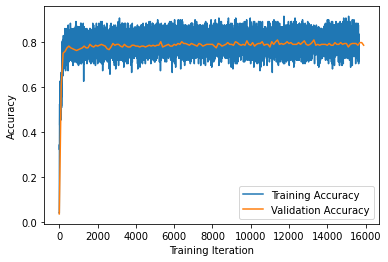

In [16]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()